In [1]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
# Cart pole system parameters
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 100                                                     # Number of trajectories to execute, data collection
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust]) - hover_thrust    # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

[-0.75349806 -0.83061578  0.34356694  0.02798223 -0.27163423 -0.23063823]
[-0.75330149 -0.83358934  0.34129572  0.01134874 -0.32307233 -0.22360556]
[-0.75337986 -0.83676914  0.33896791 -0.02697926 -0.31287128 -0.24195737]
[-0.75381051 -0.83993088  0.33642036 -0.05911345 -0.31946481 -0.26755131]
[-0.75461202 -0.84301272  0.33365495 -0.10113261 -0.29688258 -0.28553178]
[-0.75570481 -0.84623629  0.33067715 -0.11740071 -0.34782454 -0.31002771]
[-0.75704247 -0.84972666  0.32746034 -0.1500806  -0.35023117 -0.33333429]
[-0.7588724  -0.85274705  0.32415581 -0.21579803 -0.25381024 -0.32757197]
[-0.76128131 -0.85502609  0.32077723 -0.26590019 -0.20197027 -0.34814477]
[-0.76414401 -0.85692076  0.31709485 -0.30656394 -0.17693863 -0.38833062]
[-0.76750777 -0.85826815  0.31304228 -0.36606396 -0.09249887 -0.42218342]
[-0.7713975  -0.85897243  0.30874321 -0.41178036 -0.04832483 -0.43763061]
[-0.77566965 -0.85945974  0.30425365 -0.44257822 -0.04911465 -0.46028122]
[-0.7803605  -0.85959262  0.29947455 -

[-1.99335881 -0.40508338  0.05895586 -0.37471176  0.13180269 -0.00517344]
[-1.99714898 -0.40352621  0.05887876 -0.38332005  0.17963114 -0.0102466 ]
[-2.00101272 -0.40170205  0.05881267 -0.38942708  0.18520231 -0.00297159]
[-2.00492141 -0.4000957   0.0588379  -0.39231036  0.13606772  0.00801787]
[-2.00886771 -0.39883169  0.05874145 -0.39694861  0.1167329  -0.02730764]
[-2.01287986 -0.3974286   0.05857894 -0.40547628  0.16388584 -0.00519355]
[-2.01696229 -0.39580821  0.05848591 -0.41100906  0.16019191 -0.01341374]
[-2.02113381 -0.39364691  0.05839388 -0.4232926   0.27206891 -0.00499251]
[-1.38421918  0.71644639 -0.26880667  0.09675817 -0.90151873  0.6778354 ]
[-1.38313858  0.70735462 -0.26206373  0.11926878 -0.91681148  0.67075409]
[-1.38176956  0.69835926 -0.25543052  0.15438774 -0.88222046  0.65588788]
[-1.38015751  0.68930997 -0.24890545  0.16796495 -0.92762341  0.64912486]
[-1.37830685  0.68022217 -0.24249049  0.2020227  -0.88990039  0.63386723]
[-1.3762248   0.67108488 -0.23621496  

[-0.76391278 -0.58280313  0.04697519  0.5958896  -0.70815261  0.08716765]
[-0.75797173 -0.58999794  0.04789792  0.59230883 -0.73081012  0.09737915]
[-0.75206959 -0.59736227  0.04876298  0.58810628 -0.74205614  0.07563264]
[-0.74622682 -0.60449299  0.04958968  0.58042707 -0.68408812  0.08970693]
[-0.74044757 -0.61132302  0.05043339  0.57540739 -0.68191912  0.07903438]
[-0.73472096 -0.61809137  0.05116805  0.5699016  -0.67175204  0.06789798]
[-0.72906022 -0.62455548  0.05188948  0.56222931 -0.62106994  0.07638833]
[-0.72348842 -0.63028909  0.05263571  0.55210588 -0.52565422  0.0728587 ]
[-0.71802026 -0.6350367   0.05334202  0.54150352 -0.42386903  0.0684019 ]
[-0.71262649 -0.63936907  0.05384624  0.53724363 -0.44260518  0.03244277]
[-0.70726895 -0.64400968  0.05410191  0.53426135 -0.48551672  0.0186918 ]
[-0.70194731 -0.64896865  0.05440379  0.53006282 -0.5062772   0.04168303]
[-0.69668668 -0.65378963  0.05497766  0.52204882 -0.45791995  0.07309162]
[-0.69149038 -0.65842182  0.05567729  

[-0.99401554 -0.92701191  0.03754967  0.32826893 -1.7585341   0.07567087]
[-0.99076241 -0.94430581  0.03817742  0.32234128 -1.70024497  0.04988102]
[-0.9875513  -0.96147804  0.03871266  0.31987444 -1.73420109  0.05716693]
[-0.98437973 -0.97861186  0.03908476  0.31443143 -1.69256334  0.01725193]
[-0.98125225 -0.99559779  0.03914941  0.31106255 -1.70462401 -0.00432202]
[-0.97817933 -1.01217089  0.03893119  0.3035289  -1.60999495 -0.03932119]
[-0.97517155 -1.02805238  0.03848089  0.2980366  -1.56630298 -0.05073985]
[-0.9722153  -1.04357654  0.03789687  0.2932256  -1.53852733 -0.066064  ]
[-0.96929459 -1.05914606  0.03726175  0.29092302 -1.57537672 -0.06095958]
[-0.96640629 -1.07482642  0.03682297  0.28674664 -1.56069532 -0.02679724]
[-0.96356135 -1.09031066  0.03650822  0.28224694 -1.5361537  -0.03615279]
[-0.96074809 -1.10590981  0.03615084  0.28040865 -1.5836747  -0.03532289]
[-0.95794901 -1.12209802  0.03569179  0.27940885 -1.65396719 -0.05648736]
[-0.95518315 -1.13833351  0.03511632  

[ 0.59330521 -0.22321958 -0.12668873 -0.98356884 -0.90586622 -0.19915503]
[ 0.58354282 -0.23219626 -0.12860894 -0.96887296 -0.88947556 -0.18488625]
[ 0.57392589 -0.24102888 -0.13032967 -0.95448073 -0.87705254 -0.15926106]
[ 0.56445869 -0.24970017 -0.13186004 -0.93892835 -0.85720785 -0.14681262]
[ 0.5551211  -0.25837432 -0.13310297 -0.9285732  -0.87762491 -0.10177315]
[ 0.54593145 -0.26692541 -0.13414751 -0.9093336  -0.8325963  -0.1071341 ]
[ 0.53690269 -0.27526468 -0.13528146 -0.89639978 -0.8352612  -0.11965636]
[ 0.52800796 -0.28360038 -0.13649104 -0.88252481 -0.83188155 -0.12225943]
[ 0.51923899 -0.29200117 -0.13764007 -0.87125442 -0.84827824 -0.10754761]
[ 0.5105955  -0.30047727 -0.13875159 -0.85742551 -0.84694425 -0.11475675]
[ 0.50211808 -0.30874563 -0.13985261 -0.8380316  -0.80673181 -0.10544657]
[ 0.49381545 -0.31675297 -0.14079845 -0.82247822 -0.7947368  -0.08372132]
[ 0.48563363 -0.32488837 -0.14170129 -0.81387723 -0.83234551 -0.09684641]
[ 0.4776024  -0.33295019 -0.14270672 -

[-1.59941976 -1.45463137 -0.11018703  0.72721745 -0.11616243  0.45724974]
[-1.59210986 -1.45593768 -0.10548852  0.73470686 -0.1450947   0.4824514 ]
[-1.58472902 -1.45755518 -0.1007026   0.7414104  -0.17839851  0.47473263]
[-1.5772766  -1.45944435 -0.09594374  0.74901258 -0.19943112  0.47703922]
[-1.56972921 -1.46132401 -0.09109258  0.76036671 -0.17649179  0.49319371]
[-1.56209142 -1.46319899 -0.08619196  0.76712919 -0.19849761  0.48693034]
[-1.55436704 -1.46504794 -0.08115063  0.77764258 -0.17128313  0.52133629]
[-1.54655523 -1.46680666 -0.07587886  0.78464006 -0.18045427  0.53301743]
[-1.53868249 -1.46874683 -0.07052157  0.78984535 -0.20757537  0.53843946]
[-1.53077049 -1.47111624 -0.06511025  0.79251958 -0.26630473  0.54382577]
[-1.52281799 -1.47383911 -0.05971573  0.79790221 -0.27826461  0.5350775 ]
[-1.51481327 -1.47666913 -0.05432619  0.80296206 -0.28773421  0.54283037]
[-1.50672196 -1.47886342 -0.04890944  0.81508815 -0.15111343  0.54051897]
[-1.49855369 -1.48049629 -0.0435918   

[-0.18739329  1.53536384 -0.06072958 -1.21538275  0.36556623 -0.19295322]
[-0.19954537  1.53855744 -0.0625719  -1.21503165  0.27315262 -0.1755127 ]
[-0.21165407  1.54145656 -0.06431016 -1.20667018  0.30666895 -0.17213743]
[-0.22367777  1.54469457 -0.06604042 -1.19803137  0.34093156 -0.17391597]
[-0.23561893  1.54820042 -0.06764228 -1.19016957  0.36023486 -0.14645612]
[-0.24749531  1.55168304 -0.06925598 -1.18508768  0.33628924 -0.17628252]
[-0.25931795  1.55495898 -0.0711409  -1.17941453  0.3188958  -0.20070149]
[-0.27109645  1.55787493 -0.07309134 -1.17627178  0.26429359 -0.18938673]
[-0.28281369  1.56064336 -0.07482071 -1.16714055  0.28939095 -0.15648812]
[-0.29445562  1.56343734 -0.07628565 -1.16122636  0.26940312 -0.13649932]
[-0.30602743  1.56616701 -0.0776515  -1.1531113   0.27652841 -0.13667121]
[-0.31754794  1.56857734 -0.07899397 -1.15098353  0.20553816 -0.13182302]
[-0.32903697  1.57040354 -0.08030699 -1.14681196  0.15970026 -0.1307803 ]
[-0.34045135  1.57217422 -0.08155238 -

[-0.42221462  1.36998438  0.44175308 -0.72720532 -0.06778736 -0.52609281]
[-0.42971032  1.36929105  0.4365288  -0.77185089 -0.07084097 -0.51876345]
[-0.43756877  1.36839347  0.43116062 -0.79978557 -0.10864845 -0.55487297]
[-0.44578301  1.36728921  0.42536185 -0.84297061 -0.11216236 -0.60488002]
[-0.45445516  1.36621516  0.41924595 -0.8913497  -0.10259827 -0.61829977]
[-0.46359031  1.36519883  0.41293772 -0.93557526 -0.1006219  -0.64334678]
[-0.47330266  1.3645208   0.40649905 -1.00671951 -0.03490735 -0.644387  ]
[-0.4834812   1.36394144  0.39999437 -1.02893268 -0.08094167 -0.65654856]
[-0.4940225   1.36324117  0.39335738 -1.07919379 -0.05905651 -0.67085084]
[-0.50494611  1.36247939  0.38668609 -1.1054562  -0.09326905 -0.66340664]
[-0.51626687  1.36171412  0.38006335 -1.15855142 -0.05972658 -0.66114195]
[-0.52806121  1.36115246  0.37344947 -1.20020075 -0.05256032 -0.66163272]
[-0.54031873  1.36079271  0.36678337 -1.25115699 -0.01933207 -0.67158895]
[-0.5530776   1.36075698  0.36002861 -

[-0.9794844  -1.49162255 -0.40594938  1.11358608 -0.11758902  0.71968339]
[-0.96805129 -1.49259276 -0.39864438  1.17286555 -0.07637989  0.74131559]
[-0.95618893 -1.49352738 -0.39103253  1.199525   -0.1105117   0.78105375]
[-0.94401465 -1.4946855  -0.38320266  1.23521711 -0.12106521  0.78492195]
[-0.93142691 -1.49579786 -0.37533771  1.28217639 -0.10134573  0.78806644]
[-0.91844831 -1.49690066 -0.36736955  1.31343837 -0.11917114  0.80556562]
[-0.9051512  -1.4981566  -0.35921947  1.34586762 -0.13197295  0.82445177]
[-0.8914488  -1.49931228 -0.3508303   1.39442898 -0.09909536  0.85338253]
[-0.87732805 -1.50030728 -0.34224965  1.42958082 -0.09985452  0.86274639]
[-0.86279022 -1.50111075 -0.33359479  1.47778844 -0.06076952  0.86822544]
[-0.84780297 -1.50159904 -0.3247137   1.51947991 -0.03682803  0.9079934 ]
[-0.83234224 -1.50165984 -0.31558978  1.57242356  0.02474953  0.91678928]
[-0.81653749 -1.50165368 -0.30640482  1.5884494  -0.02349259  0.9202027 ]
[-0.80054404 -1.502031   -0.29730684  

[-0.62074101 -1.09966062  0.09446725 -0.53477884 -0.58466195 -0.27541265]
[-0.62614513 -1.10539723  0.09152745 -0.54598473 -0.56265291 -0.31254808]
[-0.63167034 -1.1107938   0.08842176 -0.55898442 -0.51665585 -0.30859066]
[-0.6372841  -1.11617801  0.08536559 -0.56373808 -0.56018388 -0.30264378]
[-0.64294896 -1.12194548  0.0825243  -0.56920349 -0.59330583 -0.26561389]
[-0.64869442 -1.12771595  0.07980797 -0.57983026 -0.56078352 -0.27765053]
[-0.65453114 -1.13332834  0.0771064  -0.58747019 -0.56169075 -0.26266504]
[-0.66047101 -1.1385825   0.07442705 -0.60042641 -0.48913655 -0.27320368]
[-0.66649369 -1.14371431  0.07167611 -0.60408659 -0.53722388 -0.27698397]
[-0.67258098 -1.14892177  0.06879721 -0.61330934 -0.50426422 -0.29879762]
[-0.67875828 -1.15380395  0.06579249 -0.62208463 -0.47216594 -0.30214617]
[-0.68500687 -1.15858838  0.06279978 -0.62759223 -0.48471777 -0.29639491]
[-0.69131899 -1.16334104  0.05967173 -0.6347694  -0.4658111  -0.32921499]
[-0.69768971 -1.16809698  0.05640264 -

[ 0.26889227 -0.93375687  0.25346822  0.18153879 -0.2177378   0.19735316]
[ 0.27060622 -0.9360342   0.25532184  0.16122799 -0.2377344   0.17337039]
[ 0.27206439 -0.938313    0.25703183  0.13037228 -0.21803583  0.16862793]
[ 0.27321539 -0.94040409  0.25857198  0.0997978  -0.20018959  0.13940284]
[ 0.27406315 -0.94232962  0.2599822   0.06972774 -0.18492237  0.14264145]
[ 0.27463317 -0.94419183  0.26138419  0.04425317 -0.1875253   0.13775571]
[ 0.2748776  -0.94581843  0.26282912  0.00459823 -0.13780608  0.15122936]
[ 0.27482181 -0.94730944  0.26423794 -0.01577529 -0.16040027  0.13053633]
[ 0.27450568 -0.94881957  0.2654827  -0.04747514 -0.14163164  0.11841539]
[ 0.27399556 -0.95059651  0.26672219 -0.05455426 -0.21375863  0.12948273]
[ 0.27330876 -0.95270856  0.26812489 -0.08282803 -0.20865722  0.15105662]
[ 0.27226949 -0.95451918  0.26969277 -0.12506776 -0.15347787  0.16251905]
[ 0.27090237 -0.95612411  0.27123518 -0.14837615 -0.16751477  0.14596381]
[ 0.26928328 -0.95780403  0.27273296 -

[0.76294943 1.30062217 0.08659945 0.86709432 1.36620647 0.10811683]
[0.77156882 1.31438497 0.08773483 0.8567621  1.38635186 0.11895885]
[0.78012646 1.32787091 0.08890974 0.85476207 1.31083697 0.11602383]
[0.7886479  1.34078126 0.09007021 0.84951335 1.27123184 0.11606952]
[0.79710464 1.35342636 0.09126279 0.84181745 1.25778556 0.12244693]
[0.80547327 1.36605268 0.0924831  0.83188636 1.26747636 0.12161335]
[0.81375158 1.37867224 0.09366315 0.82375963 1.25643389 0.11439864]
[0.82192442 1.39143277 0.09467949 0.81078508 1.29567121 0.08886879]
[0.8300203  1.4040247  0.09541973 0.80838739 1.22271435 0.05917838]
[0.83807283 1.41608812 0.09599286 0.8021133  1.1899676  0.05544785]
[0.84604307 1.42802485 0.09656149 0.79192384 1.19737754 0.05827828]
[0.85392492 1.43989332 0.09709225 0.78444027 1.17631714 0.04787365]
[0.86173076 1.45156124 0.0976571  0.77671976 1.15726468 0.06509606]
[0.86943173 1.46331788 0.0983496  0.76345773 1.19406295 0.073405  ]
[0.87705498 1.47488249 0.0989102  0.76119144 1.1

[ 1.31146987 -0.33979102  0.15623478 -1.46314567  2.06968303 -0.25063897]
[ 1.29679705 -0.31932063  0.1535961  -1.47139511  2.02439997 -0.27709678]
[ 1.28197872 -0.29888868  0.15072075 -1.49220623  2.06199975 -0.29797507]
[ 1.26696326 -0.27814005  0.14776138 -1.51082549  2.08773463 -0.29389758]
[ 1.25178763 -0.25729754  0.14488844 -1.5242566   2.08077515 -0.28069123]
[ 1.23645354 -0.23634887  0.14205075 -1.54250145  2.10896563 -0.28684661]
[ 1.22102649 -0.21573537  0.13916884 -1.54290761  2.01373512 -0.28953459]
[ 1.20553434 -0.19563497  0.13615248 -1.55547708  2.00635177 -0.31373892]
[ 1.18988302 -0.1753516   0.13284367 -1.57470691  2.05033284 -0.3480219 ]
[ 1.1740685  -0.15482939  0.12927059 -1.58813812  2.05411687 -0.36659367]
[ 1.15809771 -0.13408438  0.12565915 -1.6059356   2.09489637 -0.35569513]
[ 1.14197269 -0.11310094  0.12191889 -1.61900378  2.10179859 -0.39235757]
[ 1.12571249 -0.09199447  0.11788351 -1.63295826  2.11950532 -0.41471762]
[ 1.1093306  -0.07084293  0.11367136 -

[-0.35688325 -1.65542753  0.18474611  0.37266769  0.19760081 -0.00340886]
[-0.35322915 -1.65355363  0.18461508  0.35815527  0.1771796  -0.02279742]
[-0.34971542 -1.65190896  0.18438138  0.34459266  0.15175405 -0.02394323]
[-0.34636031 -1.65039475  0.18412949  0.32643363  0.15108865 -0.02643392]
[-0.34314051 -1.64913509  0.18387431  0.31752741  0.10084441 -0.02460276]
[-0.34006939 -1.64805685  0.18361366  0.29670186  0.11480454 -0.027526  ]
[-0.33722889 -1.64671762  0.18326115  0.27140608  0.15304321 -0.04297595]
[-0.33454532 -1.64551305  0.18271297  0.26531172  0.08787189 -0.06666125]
[-0.33199108 -1.64458897  0.18195008  0.2455492   0.09694632 -0.0859156 ]
[-0.32959666 -1.64377747  0.18095557  0.2333452   0.06535523 -0.11298691]
[-0.32733976 -1.64319518  0.17986298  0.21805192  0.05110642 -0.10553052]
[-0.32526718 -1.64257974  0.1787755   0.19648436  0.07198553 -0.11196529]
[-0.32340163 -1.64179965  0.1775422   0.17664783  0.08403483 -0.13469537]
[-0.32165714 -1.64132698  0.17619406  

[-2.09911994  0.02348389 -0.26125147  0.83515742 -2.16773745  0.54921285]
[-2.09062747e+00  1.84691416e-03 -2.55651047e-01  8.63236411e-01
 -2.15963179e+00  5.70872286e-01]
[-2.08184684 -0.01966816 -0.24989014  0.89278064 -2.14335429  0.58130868]
[-2.0727653  -0.04098493 -0.2440524   0.92340928 -2.11997116  0.58623944]
[-2.06338284 -0.06207435 -0.23819098  0.95296406 -2.09788372  0.58604398]
[-2.05371774 -0.08298103 -0.23241971  0.9799476  -2.08342605  0.56821041]
[-2.04372524 -0.10348325 -0.22661171  1.01839445 -2.01698049  0.59338955]
[-2.03344955 -0.12374204 -0.22066274  1.03666303 -2.03475939  0.59640448]
[-2.02296475 -0.1440483  -0.21455027  1.0601894  -2.02646947  0.62608986]
[-2.01222605 -0.16416925 -0.2081597   1.08741513 -1.99769153  0.65202336]
[-2.0012401  -0.1841016  -0.20161534  1.10965854 -1.98875307  0.65684993]
[-1.99005953 -0.20406409 -0.1950386   1.12636425 -2.00372781  0.65849748]
[-1.97866695 -0.22393164 -0.18851923  1.152007   -1.96975342  0.64537651]
[-1.96704349 

[ 0.34598581  0.92878768 -0.16901572  2.16528828 -0.10277409  0.90674592]
[ 0.36774274  0.92789047 -0.16004215  2.18591304 -0.07663879  0.88796799]
[ 0.38967175  0.92707474 -0.15113495  2.19975649 -0.08648583  0.89347142]
[ 0.41176438  0.9263563  -0.14226552  2.21858168 -0.05717394  0.88041566]
[ 0.43405013  0.92600675 -0.13333955  2.23835598 -0.01270734  0.90477783]
[ 0.45647785  0.92572611 -0.12424409  2.24708534 -0.04340788  0.91431296]
[ 0.47899604  0.92519024 -0.11513504  2.25643628 -0.06375093  0.90749768]
[ 0.50163881  0.92475866 -0.1060023   2.27190398 -0.02254146  0.91905107]
[ 0.52441314  0.92457808 -0.09673078  2.28279742 -0.01355836  0.93525255]
[ 0.54727373  0.92429935 -0.08744829  2.28921314 -0.04217827  0.92124596]
[ 0.57021888  0.92401396 -0.07823754  2.2996251  -0.0148823   0.9209031 ]
[ 0.59324936  0.92382912 -0.06906787  2.30633205 -0.02207702  0.91303118]
[ 0.61633206  0.9234109  -0.06000485  2.31011955 -0.06156043  0.89957289]
[ 0.63946527  0.92286572 -0.05099143  

[-0.37635262 -0.58558047  0.35364121  0.83117672  0.6483768   0.24904306]
[-0.36817764 -0.57921758  0.35599821  0.80378972  0.62419077  0.22235795]
[-0.36030505 -0.57302258  0.35810748  0.77069653  0.61479734  0.19949537]
[-0.35287451 -0.56662797  0.36002471  0.71536589  0.66410743  0.18395062]
[-0.34590523 -0.55998844  0.36170946  0.67846131  0.66378795  0.15299855]
[-0.3392836  -0.55341096  0.36318288  0.64584479  0.65169995  0.14168576]
[-0.33304123 -0.54681671  0.36461836  0.60260189  0.66714036  0.14541   ]
[-0.32719584 -0.54016322  0.36596818  0.56645426  0.66354939  0.1245538 ]
[-0.32167759 -0.53363694  0.36703895  0.53718256  0.64170169  0.0896011 ]
[-0.31634798 -0.5276007   0.36800725  0.52873463  0.56554422  0.1040586 ]
[-0.31117805 -0.52213157  0.36906406  0.50524222  0.52827758  0.10730377]
[-0.30638124 -0.5166791   0.37002928  0.45409857  0.56220807  0.0857391 ]
[-0.30204011 -0.51103273  0.37092755  0.4141114   0.56706012  0.09391635]
[-0.2980643  -0.50542799  0.37174281  

[-0.98534994 -0.12570052 -0.44713958  0.89978655  1.79531605  0.57205643]
[-0.97614697 -0.10780802 -0.44130646  0.94072401  1.78322404  0.59456799]
[-0.96669687 -0.09037509 -0.43541803  0.94927723  1.70337014  0.58311822]
[-0.95691349 -0.07320399 -0.42956681  1.00727649  1.73090614  0.5871249 ]
[-0.94669331 -0.05606192 -0.4234633   1.03669436  1.69753812  0.63357809]
[-0.93622534 -0.03935164 -0.41704044  1.05684983  1.64453956  0.65099403]
[-0.92543352 -0.02288968 -0.41047496  1.10140309  1.64790055  0.66210134]
[-0.91430887 -0.00664543 -0.40377514  1.12347076  1.60097398  0.67786143]
[-0.90293678  0.00919737 -0.3970735   1.15087528  1.56761747  0.66246821]
[-0.89129966  0.02469105 -0.39048328  1.17648039  1.53114647  0.65557443]
[-0.8794066   0.03982553 -0.38398988  1.20206286  1.49577687  0.64310669]
[-0.86719904  0.05475834 -0.37748258  1.23934836  1.49082508  0.65835323]
[-0.85462894  0.0696244  -0.37093103  1.27457408  1.48242538  0.65195568]
[-0.84169655  0.08444117 -0.36433108  

[ 2.19246857  1.16370371  0.43614632 -0.5753008   0.59638277 -0.64702169]
[ 2.18645669  1.16973565  0.42955552 -0.62695338  0.61006057 -0.67113827]
[ 2.17995769  1.17584968  0.42270302 -0.67273125  0.61279893 -0.69936279]
[ 2.17301712  1.18196423  0.41575934 -0.71527299  0.61016089 -0.68937273]
[ 2.16576089  1.18781123  0.40886259 -0.73591795  0.55926208 -0.68997768]
[ 2.15807691  1.19366773  0.40196385 -0.80070434  0.61211296 -0.68977013]
[ 2.14995431  1.19957194  0.3950337  -0.82375263  0.56875546 -0.69625857]
[ 2.14158549  1.20508595  0.38805405 -0.84993697  0.53407666 -0.69967212]
[ 2.13285449  1.21050665  0.38105383 -0.89613037  0.55011799 -0.70037114]
[ 2.12393039  1.21542383  0.3739899  -0.8887113   0.43330914 -0.71241615]
[ 2.11483517  1.21980042  0.36691325 -0.9302081   0.44205674 -0.70291253]
[ 2.10548241  1.22386327  0.3597849  -0.94031078  0.37052526 -0.72275878]
[ 2.09589114  1.22758189  0.3527002  -0.97782431  0.37324315 -0.69418103]
[ 2.08577639  1.23174461  0.34570517 -

[-1.54869069  1.48331086 -0.17733357  0.54401112 -0.63047929  0.20992392]
[-1.54312886  1.4771975  -0.17526448  0.56830906 -0.59218387  0.20389411]
[-1.53739813  1.47105525 -0.17310418  0.57781618 -0.63626256  0.22816584]
[-1.53155287  1.46458759 -0.17085478  0.59120755 -0.6572632   0.22171561]
[-1.52553493  1.45814086 -0.16850226  0.61233286 -0.63207507  0.24878835]
[-1.51934696  1.45171156 -0.16587405  0.62522747 -0.65377961  0.27685175]
[-1.51298325  1.44535263 -0.16313745  0.64745216 -0.6179963   0.27046938]
[-1.50643583  1.43912758 -0.16039561  0.66199146 -0.62700685  0.27789898]
[-1.49970861  1.43303418 -0.15760856  0.68338992 -0.59166428  0.27951032]
[-1.4928042   1.42707346 -0.15472675  0.69745015 -0.60047288  0.29685102]
[-1.4857655   1.42099256 -0.15174036  0.71024955 -0.61570062  0.30042723]
[-1.47853012  1.41521991 -0.14874709  0.73673915 -0.5388162   0.29822757]
[-1.4711331   1.40954027 -0.14583679  0.74264472 -0.59710898  0.28383145]
[-1.46362614  1.40363046 -0.14300683  

[-0.65297391 -0.74260283 -0.31745736 -0.27460826 -0.44187178  0.85756822]
[-0.65554978 -0.74698894 -0.30877167 -0.24071796 -0.43530274  0.87957104]
[-0.65777217 -0.75124717 -0.29985668 -0.20393335 -0.41628839  0.90342716]
[-0.65954502 -0.7550294  -0.29084927 -0.1508998  -0.34007753  0.89805442]
[-0.66094679 -0.75855846 -0.2817237  -0.12956288 -0.36570141  0.92705805]
[-0.66212713 -0.76230299 -0.27253244 -0.10662855 -0.38316969  0.91119556]
[-0.66307554 -0.76619844 -0.26333749 -0.08318598 -0.3958846   0.92779386]
[-0.66378169 -0.77017568 -0.25403334 -0.05819003 -0.39952449  0.93303535]
[-0.66421376 -0.77407688 -0.24467157 -0.02840666 -0.38067004  0.93931908]
[-0.66437932 -0.77789302 -0.23528763 -0.0048548  -0.38251957  0.93746895]
[-0.66429674 -0.78165411 -0.22592239  0.02119656 -0.36965883  0.93558027]
[-0.66398908 -0.78541881 -0.21659421  0.04020519 -0.38325203  0.93005466]
[-0.66348799 -0.78928502 -0.2072341   0.05986913 -0.38995763  0.94196716]
[-0.66272028 -0.79285853 -0.19788646  

[ 0.43510514 -0.2601133  -0.1658921  -1.3670071  -1.87508465 -0.50398214]
[ 0.42157142 -0.27854858 -0.17094876 -1.33960017 -1.81199418 -0.50734862]
[ 0.40826224 -0.29666108 -0.17586657 -1.32215538 -1.81051989 -0.47621434]
[ 0.39510441 -0.31490142 -0.18053478 -1.30935537 -1.83755899 -0.45742622]
[ 0.3821557  -0.33298056 -0.18487775 -1.28027256 -1.77829017 -0.41116951]
[ 0.36949256 -0.35051305 -0.18879438 -1.25225852 -1.72822619 -0.37215639]
[ 0.35709362 -0.36764303 -0.19253199 -1.22744944 -1.69778494 -0.37536514]
[ 0.34488769 -0.38476198 -0.19620332 -1.21369385 -1.72601251 -0.35889991]
[ 0.33283943 -0.40206918 -0.19974948 -1.19590466 -1.73543768 -0.35033232]
[ 0.32101385 -0.41925868 -0.2031549  -1.16913705 -1.70247768 -0.330753  ]
[ 0.30947568 -0.4360344  -0.20647693 -1.13841553 -1.65268342 -0.33365299]
[ 0.29824848 -0.45230656 -0.20985285 -1.10694045 -1.60176631 -0.34152957]
[ 0.28726317 -0.46842206 -0.2131846  -1.09007814 -1.62134391 -0.32482059]
[ 0.27644742 -0.48473521 -0.21629307 -

[-1.02647815 -0.4244306  -0.16812291  0.25835382  0.24102261  0.19838414]
[-1.02380589 -0.42198606 -0.16610037  0.27606144  0.2478931   0.2061246 ]
[-1.02097488 -0.41957589 -0.16402085  0.29011264  0.23414451  0.20977984]
[-1.01799044 -0.4172193  -0.16171596  0.30673535  0.2371809   0.25119888]
[-1.0148448  -0.41485556 -0.15923455  0.32235388  0.2355738   0.24508199]
[-1.01156475 -0.41263655 -0.15670947  0.33362647  0.20823178  0.25993446]
[-1.00817247 -0.41068825 -0.15412558  0.34479787  0.1814332   0.25684251]
[-1.00463612 -0.40879232 -0.15144044  0.36242005  0.1977608   0.28018529]
[-1.00091783 -0.4066846  -0.14842728  0.38117683  0.22379273  0.32244795]
[-0.99701153 -0.40430011 -0.14497156  0.40001002  0.2531159   0.36869617]
[-0.99294023 -0.4017676  -0.14139075  0.41419132  0.25339495  0.34746544]
[-0.9887373  -0.39929192 -0.13789944  0.42634346  0.24174842  0.35079564]
[-0.98444969 -0.3971892  -0.13438116  0.43115864  0.1787984   0.35286174]
[-0.98005014 -0.39523531 -0.13085319  

[-0.30884454 -1.34085716 -0.23376043  0.14138778 -0.44399432 -0.27675528]
[-0.30733909 -1.34540462 -0.2365157   0.15973621 -0.46550592 -0.27429884]
[-0.30563082 -1.35009181 -0.23911001  0.18195812 -0.4719412  -0.24456429]
[-0.30366915 -1.35472083 -0.24143182  0.21042182 -0.45387504 -0.21979736]
[-0.30141642 -1.35914889 -0.24367963  0.24016819 -0.43174804 -0.22976474]
[-0.29879672 -1.36308284 -0.2460332   0.28384108 -0.35505875 -0.24095009]
[-0.29567126 -1.36598467 -0.24837866  0.34134025 -0.22533021 -0.22814174]
[-0.29208657 -1.36805526 -0.2506643   0.37564826 -0.18880005 -0.22898594]
[-0.28813673 -1.36968093 -0.2528354   0.41437442 -0.13634805 -0.20523277]
[-0.28379978 -1.37078918 -0.25485287  0.45306641 -0.08531546 -0.19826278]
[-0.27915089 -1.37168024 -0.2566889   0.47673743 -0.09290374 -0.16894237]
[-0.2741969  -1.37239038 -0.25828072  0.51409876 -0.04913291 -0.1494212 ]
[-0.26878521 -1.37234942 -0.2595631   0.56828419  0.05731353 -0.10705616]
[-0.26286739 -1.37138322 -0.26067315  

[1.40977172 0.47396366 0.33226804 0.85710316 1.48062578 0.30187237]
[1.4182148  0.48864901 0.33536991 0.83147387 1.45643185 0.31850089]
[1.42632841 0.50329795 0.33854959 0.79118616 1.47333417 0.31743566]
[1.43409491 0.51795222 0.34167482 0.76207272 1.4575052  0.30761018]
[1.44162413 0.53229329 0.34462792 0.7437444  1.41070052 0.28300901]
[1.44892957 0.54627645 0.34744192 0.7173101  1.38591822 0.27979124]
[1.45592145 0.5601441  0.35021994 0.68102039 1.3875953  0.27581287]
[1.46263237 0.57380057 0.3530684  0.66113793 1.34368926 0.29388049]
[1.46903358 0.58731557 0.35606681 0.61904584 1.35928955 0.30580112]
[1.47512093 0.60069434 0.35904724 0.59839728 1.31645413 0.29028397]
[1.48108639 0.61341756 0.36187804 0.5946901  1.22818895 0.27587667]
[1.48688937 0.6255881  0.36457804 0.56587163 1.20590628 0.26412271]
[1.49234169 0.63769604 0.3672779  0.5245438  1.21566265 0.27584943]
[1.49744267 0.64973661 0.37010059 0.49561672 1.1924366  0.28868903]
[1.50223221 0.6615987  0.37301488 0.46225111 1.1

[-1.10260478  0.4423713  -0.13580956 -0.48193434  0.17996407 -0.39708928]
[-1.10732136  0.44442504 -0.13981532 -0.4612834   0.23076878 -0.40406301]
[-1.11186214  0.44674931 -0.14377444 -0.44680584  0.23407583 -0.38776212]
[-1.11626521  0.44904443 -0.14765315 -0.43374989  0.22494083 -0.38797856]
[-1.12051757  0.45137075 -0.15151979 -0.41664824  0.24031139 -0.3853505 ]
[-1.124593    0.45387459 -0.15538635 -0.39836157  0.26044404 -0.38796041]
[-1.12849518  0.45650404 -0.15922472 -0.38200862  0.26543721 -0.37971521]
[-1.13228547  0.45885197 -0.16289688 -0.37602774  0.20414498 -0.35471504]
[-1.13592501  0.4611321  -0.16652313 -0.35179198  0.25186585 -0.37053673]
[-1.13929499  0.46403377 -0.17027175 -0.3220957   0.32844975 -0.37918721]
[-1.14242884  0.46733065 -0.17392765 -0.30461317  0.33091507 -0.35199098]
[-1.14543617  0.47036868 -0.1772687  -0.29682801  0.27668592 -0.31621942]
[-1.14835858  0.47289953 -0.18041652 -0.2876277   0.22947922 -0.31334514]
[-1.15114297  0.47520462 -0.1836558  -

[ 0.20252011 -1.63286374  0.38091032 -0.22899662 -0.7095378  -0.39443775]
[ 0.20011122 -1.6401515   0.37678681 -0.25274068 -0.74799627 -0.43026493]
[ 0.19730188 -1.64740647  0.37254656 -0.30902634 -0.70295941 -0.41778502]
[ 0.19397098 -1.65430828  0.3683803  -0.35706718 -0.67736848 -0.41546735]
[ 0.19025011 -1.66118174  0.36424288 -0.38705345 -0.6973024  -0.41201628]
[ 0.18611567 -1.66795016  0.35998452 -0.43973463 -0.65634481 -0.43965517]
[ 0.18159111 -1.67466459  0.35545545 -0.46512622 -0.68652147 -0.46615946]
[ 0.1767655  -1.68154839  0.35077373 -0.49992202 -0.69021285 -0.47018477]
[ 0.17156983 -1.68840154  0.34621792 -0.53913106 -0.68038735 -0.44097613]
[ 0.16596502 -1.69510136  0.34183816 -0.58174458 -0.65954481 -0.43497695]
[ 0.16002519 -1.70184178  0.33752912 -0.60617127 -0.68852049 -0.42683044]
[ 0.1537756  -1.7086797   0.33326652 -0.64367061 -0.67903878 -0.42568936]
[ 0.14702773 -1.71505763  0.3290779  -0.70577736 -0.59650265 -0.41203537]
[ 0.13975992 -1.72089529  0.32480221 -

[ 1.89225793e-02 -1.08370393e+00 -2.31134474e-01 -6.81161956e-01
 -9.40801156e-02 -8.52678937e-04]
[ 0.01227204 -1.08445086 -0.23132996 -0.64894069 -0.05530752 -0.03824441]
[ 0.00595581 -1.08475966 -0.23168655 -0.61429792 -0.00645387 -0.03307282]
[-9.79500845e-05 -1.08493669e+00 -2.31970901e-01 -5.96449906e-01
 -2.89527216e-02 -2.37981465e-02]
[-0.00592746 -1.08514547 -0.23220101 -0.56944761 -0.01280379 -0.02222392]
[-0.01152147 -1.08533924 -0.23224155 -0.54935453 -0.02595065  0.01411523]
[-0.01688651 -1.08554577 -0.23209587 -0.52365526 -0.01535486  0.01502262]
[-0.02194239 -1.08542527 -0.2319925  -0.48752394  0.03945453  0.00565129]
[-0.02673632 -1.08517703 -0.2319872  -0.47126144  0.01019506 -0.00459264]
[-0.03133175 -1.08506953 -0.23195744 -0.44782439  0.01130451  0.01054484]
[-0.03571283 -1.08503559 -0.23176807 -0.42839615 -0.0045156   0.02732895]
[-0.03986106 -1.08499584 -0.23140207 -0.4012562   0.01246597  0.04587249]
[-0.04376891 -1.08491692 -0.23080648 -0.38032197  0.00332193  

[-0.73651163  0.07254873 -0.17979063 -0.96063728 -1.77144822  0.28770916]
[-0.74604436  0.05475114 -0.17683348 -0.94595014 -1.78806165  0.30371981]
[-0.7553706   0.03713017 -0.17377761 -0.91937353 -1.7361189   0.30745376]
[-0.76443923  0.01999547 -0.17064876 -0.89442809 -1.69080935  0.31831629]
[-0.77330665  0.0030457  -0.1675942  -0.87910092 -1.6991353   0.29259654]
[-0.78201877 -0.01396704 -0.16462414 -0.86336933 -1.70340586  0.30141541]
[-0.79056569 -0.03096599 -0.16160398 -0.84606728 -1.69637559  0.30261556]
[-0.79895032 -0.0479508  -0.1585496  -0.83090646 -1.70057905  0.30826198]
[-0.80718843 -0.06500031 -0.15528097 -0.81676481 -1.70931507  0.34546317]
[-0.8152453  -0.08187094 -0.15181985 -0.79469206 -1.66479843  0.34676156]
[-0.82311663 -0.09851145 -0.14831229 -0.77963098 -1.66329443  0.35475003]
[-0.83085829 -0.11526612 -0.14466357 -0.76874647 -1.68763216  0.37499346]
[-0.83843427 -0.13186083 -0.140827   -0.74654806 -1.63129507  0.39232028]
[-0.84580464 -0.14798703 -0.13695531 -

[ 0.22294399  0.75305994 -0.29871139 -0.03738779 -0.05960753  0.32621334]
[ 0.22267367  0.752311   -0.2954341  -0.01671201 -0.09016929  0.32924322]
[ 0.22265256  0.75140043 -0.29223339  0.0124379  -0.09193019  0.31089885]
[ 0.22290103  0.75040466 -0.28909349  0.03721303 -0.10720929  0.31708222]
[ 0.2233934   0.74924795 -0.28574948  0.06121553 -0.12412051  0.35171889]
[ 0.2241966   0.74816931 -0.28229256  0.09934822 -0.09158527  0.33966495]
[ 0.22530764  0.74717002 -0.27885382  0.12281415 -0.10825797  0.34808275]
[ 0.22668873  0.74613346 -0.27551946  0.15334485 -0.09903855  0.31878943]
[ 0.22829336  0.74490535 -0.27236825  0.16755307 -0.1465759   0.31145386]
[ 0.23006996  0.74331242 -0.26926235  0.18773058 -0.17199937  0.30972595]
[ 0.23205986  0.74151157 -0.26614052  0.21020591 -0.18815919  0.31463988]
[ 0.23437533  0.73992559 -0.26298218  0.25280583 -0.12901389  0.31702743]
[ 0.23703366  0.73863088 -0.25978826  0.27880788 -0.12991346  0.32175612]
[ 0.23996868  0.73739649 -0.2565978   

[-0.75718072 -0.27633477  0.21747425 -0.47321546 -0.02374247 -0.08112402]
[-0.76208445 -0.27628528  0.21671287 -0.50751003  0.03364553 -0.07115242]
[-0.76729521 -0.27582252  0.21612424 -0.53463023  0.05890866 -0.04657401]
[-0.77267477 -0.27557234  0.21551883 -0.54127784 -0.00887302 -0.07450742]
[-0.77821774 -0.2755561   0.21469102 -0.56730086  0.01212567 -0.09105572]
[-0.78402159 -0.2753244   0.21371352 -0.59344874  0.03421749 -0.104443  ]
[-0.79009378 -0.27483709  0.21255535 -0.62096572  0.06325115 -0.12719135]
[-0.79637206 -0.27437646  0.21127887 -0.63467645  0.02887804 -0.12810501]
[-0.80280275 -0.27418605  0.20992646 -0.65144339  0.00920703 -0.14237583]
[-0.80934266 -0.27446463  0.20848828 -0.65653266 -0.06492277 -0.14526176]
[-0.81599392 -0.27519719  0.20699838 -0.673699   -0.08158496 -0.15271769]
[-0.82290311 -0.27568154  0.20555369 -0.70809964 -0.01527587 -0.13622058]
[-0.83007166 -0.27590391  0.20414296 -0.72559015 -0.02919421 -0.1459248 ]
[-0.83746338 -0.27602873  0.20275488 -

[ 0.70277306 -0.22762947  0.1969086   1.27594505 -1.00654467  0.2165991 ]
[ 0.71546177 -0.23783213  0.19901321  1.26177221 -1.03399194  0.20432454]
[ 0.72800139 -0.24827657  0.20087012  1.24612688 -1.05490031  0.16705639]
[ 0.74042029 -0.25910855  0.20236649  1.23764282 -1.11149834  0.13221702]
[ 0.7526382  -0.26994316  0.20371191  1.20590409 -1.05543108  0.13686752]
[ 0.76457729 -0.28040864  0.20503036  1.18188904 -1.0376695   0.12682276]
[ 0.77628423 -0.29073857  0.20621165  1.15947728 -1.02832227  0.10943551]
[ 0.78778243 -0.3010515   0.20739039  1.14014436 -1.0342667   0.12631244]
[ 0.7990484  -0.3112421   0.20852924  1.11302525 -1.00385968  0.1014577 ]
[ 0.81005787 -0.3212014   0.20957306  1.0888498  -0.98800279  0.10730508]
[ 0.82080021 -0.33088592  0.21057252  1.05959549 -0.94890762  0.09258877]
[ 0.8312561  -0.34021117  0.21150551  1.03156133 -0.91614612  0.09400808]
[ 0.84147519 -0.34941427  0.21242867  1.01224287 -0.92447746  0.09062503]
[ 0.85146615 -0.35854082  0.21319487  

[ 2.03721739  0.71221894  0.32448725 -0.41764699 -1.24690982 -0.58287656]
[ 2.03271486  0.70023495  0.31865228 -0.48266995 -1.14982397 -0.58411675]
[ 2.02776664  0.68861699  0.31282433 -0.50690155 -1.17374499 -0.58147325]
[ 2.02244801  0.67716596  0.30693936 -0.55667234 -1.11641332 -0.59552145]
[ 2.0167141   0.6660425   0.30080523 -0.59000029 -1.10824372 -0.63130413]
[ 2.01062873  0.6550716   0.29443194 -0.62694602 -1.08589727 -0.64335359]
[ 2.00421567  0.64419939  0.28789849 -0.65556242 -1.08851388 -0.66333625]
[ 1.99751378  0.63332171  0.28125592 -0.68470467 -1.08698848 -0.6651782 ]
[ 1.99053134  0.62243392  0.27450636 -0.71167741 -1.09053994 -0.68473362]
[ 1.98324097  0.61165987  0.26773518 -0.74625713 -1.06423074 -0.66950261]
[ 1.97559681  0.60119481  0.26112295 -0.78242713 -1.02874127 -0.65294259]
[ 1.96765571  0.59085795  0.25456118 -0.80569648 -1.03860551 -0.65941278]
[ 1.95955138  0.5801651   0.24790562 -0.8151292  -1.09995472 -0.67169803]
[ 1.95124805  0.56928138  0.24125413 -

[-0.02328663 -1.64735472 -0.35701862 -0.0533009  -0.45961282  0.32517294]
[-0.0235753  -1.65178412 -0.35374738 -0.00450579 -0.42624082  0.32907508]
[-2.35942773e-02 -1.65646617e+00 -3.50594887e-01  7.03262898e-04
 -5.10165180e-01  3.01424483e-01]
[-0.02337174 -1.66146716 -0.34746843  0.0437422  -0.49001097  0.32386629]
[-0.02271317 -1.66624502 -0.34410806  0.0879041  -0.46553631  0.34820772]
[-0.02162829 -1.67081444 -0.34070463  0.12900518 -0.44832375  0.33247826]
[-0.02018157 -1.67534471 -0.33736516  0.16028941 -0.45771294  0.33541576]
[-0.01839693 -1.67989236 -0.33411953  0.19658366 -0.45179811  0.31371117]
[-0.01630559 -1.68453809 -0.33100524  0.22164609 -0.47733459  0.30914594]
[-0.01369409 -1.68864841 -0.32772679  0.30052726 -0.34468766  0.34654463]
[-0.01047803 -1.69196342 -0.32423558  0.34261369 -0.31828837  0.35169694]
[-0.00692973 -1.6952719  -0.3206064   0.36700134 -0.34339313  0.37414003]
[-0.0030729  -1.69863138 -0.3168332   0.40429315 -0.3284791   0.38049989]
[ 1.10878055e

[-0.76963118 -0.14063593 -0.36069114  0.4837686   1.18089657  0.69065698]
[-0.76455852 -0.12869013 -0.35375607  0.53061777  1.20831617  0.69635573]
[-0.75907482 -0.11661328 -0.34666663  0.5660076   1.20709716  0.72153357]
[-0.75322385 -0.10450037 -0.33942428  0.60405792  1.2155293   0.726935  ]
[-0.74698812 -0.09227854 -0.33208027  0.64295331  1.22888421  0.74186792]
[-0.74051639 -0.08035687 -0.32464729  0.65136079  1.15546126  0.74472691]
[-0.73382967 -0.06877413 -0.3171643   0.68585348  1.1611294   0.75187142]
[-0.72686578 -0.05732963 -0.30960511  0.70684297  1.12779756  0.75996808]
[-0.71976185 -0.04643019 -0.30199301  0.71391551  1.05210001  0.76245092]
[-0.71251962 -0.03606582 -0.29434818  0.73444528  1.02079897  0.76651538]
[-0.70500844 -0.02579325 -0.28671959  0.76765033  1.03375723  0.75920182]
[-0.69720302 -0.01550488 -0.27924531  0.79332273  1.02394987  0.73565472]
[-0.68899871 -0.00480169 -0.27197445  0.84730872  1.11675358  0.71851627]
[-0.68046778  0.00608465 -0.26491782  

[-0.49603886 -0.95348025 -0.11798775 -0.00415733  0.02358596 -0.2520027 ]
[-0.49602823 -0.95329767 -0.12045639  0.00631782  0.01292542 -0.24172388]
[-0.49592916 -0.95336431 -0.12270742  0.01351831 -0.02625687 -0.20848221]
[-0.49573522 -0.95364366 -0.12480115  0.02530301 -0.02961579 -0.21026525]
[-0.49538477 -0.95365823 -0.1269616   0.04484219  0.02669445 -0.22182358]
[-0.49486966 -0.95336243 -0.12924941  0.05822011  0.03246096 -0.23573982]
[-0.49424299 -0.95318824 -0.13154621  0.06714006  0.00237317 -0.22361874]
[-0.49353669 -0.95339273 -0.1337103   0.07413852 -0.04327391 -0.20919883]
[-0.49273495 -0.95386959 -0.13569798  0.08623872 -0.05210159 -0.188339  ]
[-0.49179788 -0.95433661 -0.13747319  0.10120728 -0.04130744 -0.16670205]
[-0.49073904 -0.95490344 -0.13907786  0.11058024 -0.07206043 -0.15423161]
[-0.48958175 -0.95574816 -0.14064148  0.1208953  -0.09688713 -0.15849242]
[-0.48826291 -0.95643445 -0.14241027  0.14291916 -0.04037642 -0.19526624]
[-0.48676689 -0.95686474 -0.14432679  

[ 1.94562926 -0.48417877  0.37407709  0.6225383  -2.12249505  0.22567567]
[ 1.95172469 -0.5055639   0.37629732  0.59652279 -2.15454065  0.21837113]
[ 1.95739522 -0.52685553  0.37839504  0.53753125 -2.10380568  0.20117202]
[ 1.96251095 -0.54773241  0.38036644  0.48557331 -2.07158816  0.19310731]
[ 1.96705536 -0.56816158  0.38223853  0.42325837 -2.01426419  0.18131246]
[ 1.9711523  -0.5884579   0.38400231  0.39611102 -2.04500856  0.17144328]
[ 1.97490478 -0.60888296  0.38554826  0.35435871 -2.04001467  0.13774592]
[ 1.97817278 -0.62909542  0.38672564  0.29921474 -2.00248757  0.09773083]
[ 1.98100487 -0.64921807  0.38751532  0.26719143 -2.02204695  0.06020459]
[ 1.98342268 -0.66930677  0.38790067  0.21636308 -1.99569587  0.01686629]
[ 1.98535139 -0.68917937  0.38797256  0.1693785  -1.97882463 -0.00248833]
[ 1.98688924 -0.70907653  0.38788053  0.13819155 -2.0006069  -0.01591802]
[ 1.9880983  -0.72914997  0.38767477  0.10362447 -2.01408084 -0.0252338 ]
[ 1.98901483 -0.74948802  0.38736164  

[-0.2927026   0.01462308 -0.1812982  -1.08839711  0.47896402 -0.32151611]
[-0.3035281   0.01923931 -0.18431237 -1.07667196  0.44427617 -0.28131937]
[-0.31418452  0.02378023 -0.18707167 -1.05455646  0.463896   -0.27054068]
[-0.3246556   0.02832028 -0.18969885 -1.03962546  0.44410843 -0.25489373]
[-0.33494422  0.03282882 -0.19228819 -1.01805178  0.45759066 -0.26297508]
[-0.34505374  0.03727727 -0.19480728 -1.00382019  0.43209323 -0.24084388]
[-0.35496969  0.0417247  -0.19717503 -0.97932171  0.45738217 -0.23270557]
[-0.36467251  0.04625872 -0.19943171 -0.96120888  0.44941522 -0.21863089]
[-0.37422029  0.05057936 -0.20158388 -0.94832439  0.41470923 -0.21180307]
[-0.38364187  0.05453667 -0.20350375 -0.93597224  0.37674798 -0.17217097]
[-0.39290073  0.05830106 -0.20505224 -0.91577518  0.37612518 -0.13752678]
[-0.40194724  0.06210549 -0.20644322 -0.8935007   0.38475573 -0.14066774]
[-0.41075314  0.06607754 -0.20788611 -0.86765084  0.40964851 -0.14791066]
[-0.41926887  0.07044397 -0.20928566 -

[-1.2883418   0.42500422 -0.26312806  1.73258503  0.03648735  0.7827213 ]
[-1.27088446  0.42537185 -0.25522848  1.75875208  0.03707329  0.79719436]
[-1.25312707  0.42591031 -0.24724713  1.79255199  0.07066338  0.79907539]
[-1.23507942  0.42661577 -0.23927308  1.81684739  0.07046086  0.79573606]
[-1.21682802  0.42717378 -0.23128079  1.83334089  0.04116329  0.80272208]
[-1.19845534  0.42726369 -0.22322765  1.84114964 -0.02316965  0.8079048 ]
[-1.17986164  0.42735424 -0.21519359  1.87737357  0.04132784  0.7989069 ]
[-1.16098393  0.42775884 -0.20719984  1.89803928  0.03961879  0.79984383]
[-1.14184032  0.42845138 -0.199146    1.93047051  0.09893277  0.81092511]
[-1.12244645  0.42939828 -0.19097715  1.94818182  0.09047211  0.82284402]
[-1.10281422  0.43060209 -0.18282659  1.97805088  0.15032959  0.80726706]
[-1.08294282  0.43211398 -0.17471424  1.99609327  0.15207333  0.81520359]
[-1.06295919  0.43327487 -0.16645953  2.00059612  0.08011032  0.83573775]
[-1.04283037  0.43432944 -0.15806893  

[ 1.19603375 -0.13182911  0.52134612 -1.03549049  1.88459715 -0.82510536]
[ 1.18537647 -0.11294381  0.51306897 -1.09581892  1.89254756 -0.83032612]
[ 1.17419241 -0.09410529  0.50461875 -1.14087889  1.87521844 -0.85971778]
[ 1.16246084 -0.0752552   0.49591116 -1.20526356  1.89489446 -0.88179915]
[ 1.15023365 -0.0564718   0.48701776 -1.24007941  1.86183593 -0.89688127]
[ 1.13759195 -0.03788571  0.47791241 -1.28811975  1.85545498 -0.92418893]
[ 1.12447297 -0.01935906  0.46847872 -1.33553182  1.84995073 -0.96254925]
[ 1.11085405e+00 -8.24983919e-04  4.58894820e-01 -1.38808456e+00
  1.85694775e+00 -9.54230476e-01]
[ 1.09677398  0.01766047  0.44929321 -1.42779793  1.84020649 -0.96609232]
[ 1.08232458  0.03593052  0.43956478 -1.46196745  1.8138586  -0.97959223]
[ 1.067611    0.05378002  0.42946605 -1.48067944  1.75607235 -1.04015508]
[ 1.05262237  0.07125093  0.41912007 -1.51690792  1.73817344 -1.02904056]
[ 1.03725563  0.08858997  0.4087824  -1.55628597  1.72970216 -1.03849281]
[ 1.02135179 

[ 1.61754985 -1.54696503  0.17869549 -1.41204711  0.21595609 -0.32614269]
[ 1.60328633 -1.54449893  0.17529906 -1.44056694  0.27728069 -0.3531436 ]
[ 1.58878707 -1.54168458  0.17173015 -1.4592205   0.28559996 -0.3606384 ]
[ 1.57412457 -1.5389108   0.16805762 -1.47323081  0.26916468 -0.37386693]
[ 1.55935101 -1.53646465  0.16412945 -1.48144758  0.22007017 -0.41176658]
[ 1.54442774 -1.53409191  0.16000891 -1.50311567  0.25449369 -0.41234255]
[ 1.52934464 -1.53171277  0.15584915 -1.51345949  0.22134236 -0.41960942]
[ 1.51420451 -1.52995428  0.15172914 -1.51456213  0.13035612 -0.40439168]
[ 1.49902471 -1.52891561  0.14766124 -1.52136819  0.07738092 -0.40918892]
[ 1.48373799 -1.5281367   0.14361249 -1.53590742  0.07841117 -0.40056048]
[ 1.46830999 -1.52736191  0.13957687 -1.5496277   0.07655751 -0.40656326]
[ 1.45272077 -1.52641873  0.13554045 -1.56812616  0.11208993 -0.40072068]
[ 1.43697458 -1.52530742  0.13158908 -1.58105004  0.11018181 -0.38955372]
[ 1.4210936  -1.52415825  0.12768236 -

[ 1.42735589 -0.38293288  0.36836714 -0.91301274 -2.10825901 -0.2475434 ]
[ 1.41811187 -0.40421013  0.36565141 -0.93576558 -2.14717965 -0.29560272]
[ 1.40855953 -0.42566246  0.36271328 -0.97465097 -2.14326696 -0.29202367]
[ 1.39858261 -0.44697665  0.35967139 -1.02067261 -2.11954822 -0.31635478]
[ 1.38811707 -0.46797212  0.35642968 -1.07236001 -2.07951816 -0.33198532]
[ 1.37713326 -0.48855653  0.35299608 -1.12432136 -2.0373338  -0.35473474]
[ 1.36580023 -0.50917568  0.34939825 -1.14225573 -2.08648565 -0.36483115]
[ 1.35412163 -0.52982558  0.3456103  -1.19337454 -2.04346277 -0.39276015]
[ 1.34196284 -0.55012309  0.34160785 -1.23830021 -2.01600784 -0.40772893]
[ 1.3293972  -0.57025775  0.33745778 -1.27475624 -2.01089874 -0.4222853 ]
[ 1.31646001 -0.5903143   0.33308461 -1.31260294 -2.00038535 -0.45235004]
[ 1.30315627 -0.61029246  0.32846834 -1.34806587 -1.99521831 -0.47090319]
[ 1.28945221 -0.63007624  0.32368366 -1.39264059 -1.96150299 -0.48603351]
[ 1.27541636 -0.64985375  0.3187361  -

[-1.37575097  1.57565559  0.11285047  0.01186388  0.56845119 -0.07714696]
[-1.37573245  1.58173522  0.1119536  -0.00813347  0.64747726 -0.10222592]
[-1.3758692   1.58821399  0.11084349 -0.01919816  0.6482782  -0.11979783]
[-1.3761141   1.59468349  0.10963478 -0.02976304  0.64562418 -0.1219437 ]
[-1.37640943  1.60062826  0.1084676  -0.02930398  0.54333096 -0.11149244]
[-1.37675746  1.60607774  0.10742096 -0.04028401  0.54656574 -0.09783441]
[-1.37718865  1.61131653  0.1065957  -0.04594666  0.5011941  -0.067219  ]
[-1.37768376  1.61617182  0.10586379 -0.05306716  0.46986477 -0.07916145]
[-1.37827432  1.62094505  0.10504745 -0.06503042  0.484783   -0.08410791]
[-1.37896651  1.62570076  0.10412176 -0.07339513  0.46636069 -0.10103001]
[-1.37973492  1.63020471  0.1030651  -0.08027487  0.43442894 -0.11030083]
[-1.3805867   1.63453441  0.10182172 -0.09006243  0.43151371 -0.13837561]
[-1.38151754  1.63865609  0.10040372 -0.09609048  0.39282412 -0.14522527]
[-1.38254685  1.64277634  0.09878724 -

[ 1.95557155 -0.82077939  0.42516684  0.99276553  1.96258872  0.89034482]
[ 1.96529315 -0.80119243  0.43377077  0.95142596  1.95474218  0.83044306]
[ 1.9744325  -0.78133186  0.44184131  0.87622744  2.01727109  0.78366425]
[ 1.98304227 -0.76132938  0.44945194  0.84564437  1.98318677  0.7384623 ]
[ 1.99113391 -0.74123642  0.45657961  0.77250632  2.03531909  0.68707017]
[ 1.99869881 -0.72104949  0.46320626  0.74040125  2.00202989  0.63826127]
[ 2.00581403 -0.70094451  0.4694342   0.68252484  2.01890603  0.6073262 ]
[ 2.01250889 -0.68099016  0.47523787  0.65639735  1.97193967  0.55340711]
[ 2.01896063 -0.66154411  0.48049928  0.63391255  1.91724977  0.49887632]
[ 2.02497569 -0.64224282  0.48515971  0.56900233  1.94295753  0.43320956]
[ 2.03048082 -0.62295423  0.48924778  0.53197701  1.9147359   0.38440428]
[ 2.03557951 -0.60388338  0.49283724  0.4877118   1.89940825  0.3334866 ]
[ 2.04020365 -0.58490995  0.49602926  0.43706478  1.89525092  0.30491853]
[ 2.04444897 -0.5662169   0.4989487   

[-1.42058919 -0.12473278 -0.01877531 -0.93484713  0.18441976  0.23074585]
[-1.42992781 -0.12283223 -0.01650145 -0.93291843  0.19568987  0.2240275 ]
[-1.43925133 -0.12100687 -0.01445567 -0.93180939  0.16938442  0.18512869]
[-1.44855744 -0.11893776 -0.01260116 -0.92946667  0.24443737  0.1857723 ]
[-1.4578484  -0.11667549 -0.01088842 -0.92874371  0.20801748  0.156775  ]
[-1.46713004 -0.11452717 -0.00940542 -0.92761155  0.22164525  0.13982557]
[-1.47640533 -0.11270947 -0.00816893 -0.92745079  0.14189624  0.10747216]
[-1.48567796 -0.11154098 -0.00719995 -0.92708274  0.09180095  0.08632385]
[-1.49494644 -0.11077354 -0.00642791 -0.92662052  0.06168703  0.06808491]
[-1.504209   -0.11006337 -0.00592051 -0.92590298  0.08034751  0.03339452]
[-1.51346449 -0.10914225 -0.00571882 -0.92519781  0.10387602  0.00694454]
[-1.52271409 -0.10817833 -0.0057239  -0.92472321  0.08890811 -0.00796053]
[-1.53195876 -0.10733654 -0.00604138 -0.92420527  0.07945008 -0.05553635]
[-1.54119848 -0.10666077 -0.00690894 -

[-0.99692851 -1.61026185 -0.0478912   2.29870721 -0.88396873  0.77614974]
[-0.97391009 -1.61890111 -0.04028922  2.30480048 -0.84387491  0.74424707]
[-0.95084995 -1.62750963 -0.03300719  2.30715069 -0.87782785  0.71215831]
[-0.92776586 -1.63636794 -0.02596243  2.30957097 -0.89383015  0.6967937 ]
[-0.90465744 -1.64525867 -0.01884406  2.31198502 -0.88431417  0.72688048]
[-0.8815272  -1.65396083 -0.01176921  2.3139143  -0.85611537  0.68808964]
[-0.85838506 -1.66269674 -0.00489671  2.31444045 -0.89106589  0.68641106]
[-8.35239411e-01 -1.67162341e+00  1.82372829e-03  2.31458398e+00
 -8.94268381e-01  6.57675907e-01]
[-0.81209582 -1.68049666  0.00842594  2.31401054 -0.88038138  0.6627669 ]
[-0.78896128 -1.68926668  0.01491244  2.3127844  -0.87362314  0.63453173]
[-0.76584593 -1.69775909  0.02118336  2.31013176 -0.82486169  0.61965287]
[-0.74276332 -1.70569321  0.02725046  2.30622873 -0.76196741  0.59376667]
[-0.71971851 -1.71320519  0.03306443  2.30261723 -0.74043071  0.56902877]
[-0.69671131 

[-0.46068659 -1.40306942  0.14720788  0.90488066 -0.96620916  0.2527183 ]
[-0.45172869 -1.41261249  0.14973207  0.88664844 -0.94241248  0.25212045]
[-0.44293716 -1.42203294  0.15196322  0.87162118 -0.94168263  0.19410963]
[-0.43431166 -1.43135047  0.15387561  0.85344152 -0.92183056  0.18836847]
[-0.42583917 -1.44066161  0.15574528  0.84102994 -0.9404005   0.18556437]
[-0.41749736 -1.45012165  0.15752987  0.8273065  -0.95161221  0.17135497]
[-0.4093301  -1.45946471  0.15930125  0.80610729 -0.91700509  0.18292015]
[-0.40137761 -1.46845196  0.16107993  0.78434948 -0.88045154  0.17281545]
[-0.393595   -1.47737361  0.16264342  0.77215463 -0.90388237  0.13988402]
[-0.38597765 -1.48626967  0.16391801  0.75128692 -0.87533381  0.11503245]
[-0.3785821  -1.49480595  0.16510676  0.727796   -0.83192752  0.12271799]
[-0.3713708  -1.50321662  0.16618296  0.71445011 -0.85020882  0.09252199]
[-0.36428594 -1.51185424  0.16703357  0.70251054 -0.87731603  0.07759963]
[-0.35739776 -1.52030719  0.16789461  

[ 1.81866771 -1.72713809  0.28809784  0.91719066  0.01233351  0.15545667]
[ 1.82760533 -1.72671616  0.28964527  0.87029279  0.07204019  0.15402797]
[ 1.83622352 -1.72620248  0.29120936  0.85333137  0.03069129  0.15879157]
[ 1.84457911 -1.72579429  0.29286172  0.81775425  0.05093741  0.17167882]
[ 1.85271735 -1.72564533  0.29472083  0.80988457 -0.02114888  0.20014431]
[ 1.86071559 -1.72601671  0.29670189  0.78974248 -0.05313277  0.19606817]
[ 1.86845846 -1.72653418  0.29866099  0.75879843 -0.05037141  0.19575153]
[ 1.87592324 -1.72712912  0.30054863  0.73413263 -0.06862515  0.18177699]
[ 1.88312274 -1.72784926  0.30243649  0.70573789 -0.07541187  0.19579318]
[ 1.89002369 -1.72859366  0.30433309  0.67442117 -0.07347764  0.18352828]
[ 1.89663038 -1.72938202  0.30611583  0.64689097 -0.08420224  0.17302009]
[ 1.90300381 -1.73041307  0.30802309  0.62777568 -0.12201435  0.2084312 ]
[ 1.90909468 -1.73153771  0.31018293  0.59035484 -0.10292699  0.22353747]
[ 1.9148076  -1.7324643   0.31250452  

[-0.27630169 -1.98775709 -0.38359716 -0.70014399 -0.2228508  -0.45453967]
[-0.28315956 -1.99012192 -0.38815409 -0.67137688 -0.25013764 -0.45684591]
[-0.28974101 -1.99279162 -0.39275976 -0.64486434 -0.28382144 -0.46428736]
[-0.29596423 -1.99557857 -0.39738768 -0.5996956  -0.27360346 -0.46129643]
[-0.30173609 -1.99827105 -0.40186123 -0.55459573 -0.26492737 -0.43341349]
[-0.30710108 -2.00098672 -0.4062158  -0.5183414  -0.27823337 -0.43750141]
[-0.31202373 -2.00365575 -0.41055964 -0.46610125 -0.25560883 -0.43126672]
[-0.31643791 -2.00613751 -0.41483482 -0.41665523 -0.24077948 -0.42376984]
[-0.32044003 -2.00866386 -0.41910154 -0.3837156  -0.26451279 -0.42957409]
[-0.32411017 -2.011426   -0.42333818 -0.35025848 -0.28793976 -0.4177523 ]
[-0.32738459 -2.01429142 -0.42752302 -0.30455674 -0.28517533 -0.41921672]
[-0.33011149 -2.01693682 -0.43168187 -0.24072493 -0.24394916 -0.41255315]
[-0.33222865 -2.01923935 -0.43573077 -0.1826237  -0.2165958  -0.3972276 ]
[-0.33388583 -2.02153394 -0.4396439  -

[-0.62075366  0.88738785 -0.48248939  0.51150355 -1.65524697  0.27035516]
[-0.61532601  0.87094308 -0.47959323  0.57396914 -1.63367559  0.30887834]
[-0.60914523  0.85496615 -0.47627859  0.662094   -1.56166281  0.3540482 ]
[-0.60227311  0.83934735 -0.4725845   0.71227007 -1.56206528  0.3847715 ]
[-0.59482967  0.82386564 -0.46847866  0.7763298  -1.53423423  0.43639538]
[-0.5867496   0.80866109 -0.46391551  0.83958959 -1.50662736  0.47623435]
[-0.57814963  0.79351386 -0.4588334   0.88033461 -1.52278307  0.54018808]
[-0.56920087  0.77809126 -0.45329841  0.90936364 -1.5617109   0.56681073]
[-0.55987657  0.76245947 -0.44743747  0.9554019  -1.56460174  0.6053757 ]
[-0.55009844  0.74679243 -0.44122273  1.00012857 -1.56876067  0.63757295]
[-0.53981856  0.7312075  -0.43472996  1.05571805 -1.54816457  0.66098221]
[-0.52902267  0.71575241 -0.42801982  1.1033438  -1.54279923  0.68104407]
[-0.51775767  0.70034457 -0.42110776  1.14953834 -1.53871659  0.70136819]
[-0.50589838  0.68528454 -0.41398175  

[-0.08358582 -0.56428785 -0.32001793  0.49471454 -0.51351932  0.32708692]
[-0.07837239 -0.56910707 -0.31663976  0.54788023 -0.45029389  0.34854796]
[-0.07279992 -0.57381348 -0.31303658  0.56658032 -0.49097744  0.37208755]
[-0.06703167 -0.57889591 -0.3092799   0.58702886 -0.52549599  0.37924945]
[-0.06088779 -0.58378138 -0.3054899   0.64163996 -0.45156325  0.37875079]
[-0.05429983 -0.58824111 -0.3016512   0.67588033 -0.44036067  0.38898817]
[-0.04736759 -0.59257522 -0.29772576  0.71049545 -0.42643814  0.39610057]
[-0.04010273 -0.5968065  -0.293738    0.74240698 -0.41979708  0.40145117]
[-0.03258068 -0.60116947 -0.28971533  0.7619599  -0.45278487  0.40308212]
[-0.02485753 -0.60583878 -0.28573105  0.78262206 -0.48106294  0.39377494]
[-0.01678831 -0.61030871 -0.28183852  0.83111513 -0.41289053  0.3847312 ]
[-0.00834003 -0.61445219 -0.27789768  0.85847922 -0.41578738  0.40343556]
[ 3.91043492e-04 -6.18585171e-01 -2.73821000e-01  8.87664469e-01
 -4.10789977e-01  4.11900918e-01]
[ 0.00940271 

[-1.15470833 -0.54631697 -0.3871628   0.74720333  2.04675624  0.25704446]
[-1.14704924 -0.52587998 -0.38445578  0.78457386  2.04065858  0.28435916]
[-1.13908625 -0.50567329 -0.38149771  0.80799469  2.00069055  0.3072555 ]
[-1.13084842 -0.48576211 -0.37832915  0.83953098  1.98156338  0.32645542]
[-1.12235993 -0.4662018  -0.37502504  0.85814077  1.93050861  0.33436716]
[-1.1135669  -0.44684786 -0.3716342   0.90040405  1.94030355  0.34379988]
[-1.10444771 -0.42763888 -0.36831086  0.92340141  1.90150419  0.32086904]
[-1.09501257 -0.40859147 -0.36492593  0.96356739  1.90799993  0.35611658]
[-1.0852886  -0.38977004 -0.36137141  0.98119812  1.8562965   0.35478813]
[-1.07524941 -0.37109422 -0.35763735  1.02656628  1.87889742  0.39202294]
[-1.0648481  -0.35243134 -0.35375575  1.0536473   1.85369576  0.3842979 ]
[-1.0541953  -0.3340686  -0.34979624  1.07687182  1.81886671  0.40760472]
[-1.04336743 -0.31620759 -0.34570548  1.08868031  1.75334326  0.41054616]
[-1.03240567 -0.29895567 -0.34155709  

[ 1.56592246 -0.53382137  0.23262559  0.64807686 -1.04316049 -0.0866181 ]
[ 1.57222207 -0.54397776  0.23163706  0.61187005 -0.9881106  -0.11108841]
[ 1.57820533 -0.55377414  0.23045803  0.58480348 -0.9711613  -0.12471705]
[ 1.5839029  -0.56333379  0.22919744  0.55473935 -0.94076234 -0.12740164]
[ 1.58934038 -0.57275987  0.227942    0.53277597 -0.94444975 -0.12368633]
[ 1.59450671 -0.58199764  0.22665892  0.50051958 -0.90309628 -0.13292941]
[ 1.59934129 -0.59077778  0.22528695  0.46643099 -0.85292505 -0.1414655 ]
[ 1.60380728 -0.59893031  0.22390607  0.42680604 -0.77756986 -0.1347107 ]
[ 1.60788107 -0.60634151  0.22236831  0.38799582 -0.70466147 -0.17284006]
[ 1.61162964 -0.613296    0.22064038  0.3617525  -0.6862278  -0.17274686]
[ 1.61513061 -0.62012768  0.21884227  0.33847251 -0.68010157 -0.18687466]
[ 1.61839291 -0.62686704  0.21687241  0.31402275 -0.66776322 -0.20709746]
[ 1.62141884 -0.63351474  0.21484358  0.29119838 -0.66176925 -0.19866908]
[ 1.62417801 -0.63992031  0.2126333   

[-0.94781619  0.03255364 -0.42689454  0.79973293  0.96342509  0.41802818]
[-0.93965981  0.04204833 -0.4227071   0.83149259  0.93553628  0.41945891]
[-0.93125467  0.05111453 -0.41834183  0.84950773  0.87771736  0.45359596]
[-0.92244607  0.06010929 -0.41379048  0.91210425  0.92128156  0.45667304]
[-0.91302907  0.06950839 -0.40906417  0.97118871  0.95858431  0.48858939]
[-0.90317952  0.07892269 -0.40423134  0.99866966  0.92429836  0.47797607]
[-0.8930105   0.08810328 -0.39938483  1.03506586  0.9118487   0.49132675]
[-0.88239421  0.09736357 -0.39426551  1.08808368  0.94025383  0.53253659]
[-0.87125605  0.10689721 -0.38894665  1.1394386   0.96652024  0.53123533]
[-0.85963977  0.11661612 -0.38347867  1.18371702  0.97730214  0.56236161]
[-0.84753308  0.12657032 -0.3778184   1.23749457  1.01358821  0.56969276]
[-0.83490055  0.13686831 -0.37218106  1.28888873  1.04605789  0.55777425]
[-0.821893    0.14714406 -0.36651066  1.31256424  1.00911461  0.57630663]
[-0.80862222  0.157125   -0.36065673  

[-1.23207588 -0.20420971 -0.40471209 -0.70728603  1.89435331  0.26301315]
[-1.23891215 -0.18520299 -0.4019952  -0.66001787  1.90701148  0.28036435]
[-1.24540572 -0.16637196 -0.39916188 -0.63871913  1.8592059   0.28629911]
[-1.25158712 -0.14778124 -0.39641723 -0.5976057   1.85895613  0.26263056]
[-1.25743569 -0.12937687 -0.39390539 -0.57213389  1.82192807  0.23973779]
[-1.26293908 -0.11112256 -0.39162266 -0.5285851   1.82895052  0.2168081 ]
[-1.26809966 -0.09301957 -0.38943565 -0.50355268  1.79165643  0.22059501]
[-1.27303501 -0.07534889 -0.38724929 -0.48353431  1.74248737  0.21667664]
[-1.27774449 -0.05810526 -0.38507099 -0.45838356  1.70624735  0.21898253]
[-1.28222491 -0.04127759 -0.38277059 -0.43772081  1.65929432  0.24109782]
[-1.2864039  -0.0246817  -0.38038308 -0.39811636  1.65990004  0.23640412]
[-1.29026979 -0.00828425 -0.37796702 -0.37508543  1.61959895  0.24680872]
[-1.29385543  0.00783836 -0.37543557 -0.34207698  1.60493683  0.25948145]
[-1.29705676  0.0239554  -0.37287955 -

[-0.81165567 -0.23324212  0.13409884  0.27511093 -0.44478936 -0.151655  ]
[-0.80898323 -0.2375952   0.13261777  0.25940654 -0.42582214 -0.14455897]
[-0.80647433 -0.241703    0.13105558  0.24240557 -0.3957345  -0.16787877]
[-0.8041394  -0.24547183  0.12942818  0.22461821 -0.35802684 -0.1576024 ]
[-0.80195622 -0.24905658  0.12785234  0.21204408 -0.35892009 -0.15756546]
[-0.7999004  -0.2526314   0.12618259  0.19914675 -0.35603957 -0.17638409]
[-0.79796604 -0.25623001  0.12434965  0.18775433 -0.36367842 -0.19020503]
[-0.79615686 -0.25980742  0.12235905  0.17411713 -0.35179995 -0.20791305]
[-0.79447469 -0.26333342  0.12036952  0.16234852 -0.35339521 -0.18999472]
[-0.79289464 -0.26699686  0.1184002   0.15368622 -0.37928956 -0.20386872]
[-0.79142586 -0.27070453  0.11629745  0.14011012 -0.3622415  -0.21668022]
[-0.79007088 -0.2744202   0.11415359  0.13091464 -0.38088813 -0.21209258]
[-0.78884259 -0.27800975  0.11194555  0.11479399 -0.33701646 -0.22951563]
[-0.78775103 -0.28136536  0.10955271  

[ 1.5764711  -0.27902041  0.24596773 -1.99753571  2.11664094 -0.80848773]
[ 1.55642231 -0.2580486   0.23780976 -2.01214259  2.07774227 -0.82310672]
[ 1.53623075 -0.23746884  0.22955272 -2.02608809  2.03822835 -0.82830038]
[ 1.51584432 -0.21703289  0.22109435 -2.051046    2.04899761 -0.86337508]
[ 1.49523412 -0.19658359  0.21238724 -2.07086358  2.04089056 -0.87804604]
[ 1.47442414 -0.17618842  0.20345282 -2.09098904  2.03817378 -0.90883778]
[ 1.45340522 -0.15576045  0.19432184 -2.11263227  2.04745277 -0.91735839]
[ 1.43220858 -0.1354133   0.18516412 -2.12658372  2.02199746 -0.91418533]
[ 1.41091697 -0.11554383  0.17597423 -2.13169681  1.95190425 -0.92379218]
[ 1.3895002  -0.09594385  0.16678763 -2.15148207  1.96812368 -0.91352949]
[ 1.36793692 -0.07645979  0.15760001 -2.16108425  1.9287023  -0.92399434]
[ 1.34623178 -0.05705795  0.14840861 -2.17975673  1.95169389 -0.91428597]
[ 1.32441731 -0.03791603  0.13925212 -2.18310266  1.87669594 -0.91701149]
[ 1.30254292 -0.01932309  0.13000704 -

[-1.35060001  0.97047416  0.09349548  0.11056969 -0.50178694  0.3010044 ]
[-1.34952056  0.96524271  0.09648758  0.10529292 -0.54450596  0.2974156 ]
[-1.348506    0.95969943  0.09956033  0.09757929 -0.56415371  0.31713337]
[-1.34760025  0.95426129  0.10265318  0.08349849 -0.52348     0.30143662]
[-1.34685067  0.94935685  0.10574467  0.06633286 -0.45741715  0.31686138]
[-1.34626652  0.94503079  0.10889764  0.05041864 -0.40780462  0.31373324]
[-1.34579073  0.94071943  0.11202766  0.04471371 -0.4544696   0.31227097]
[-1.3454049   0.93622407  0.11525207  0.03239376 -0.44460827  0.33261211]
[-1.34517197  0.93206598  0.1186146   0.01410615 -0.38702009  0.33989196]
[-1.34510268e+00  9.28301802e-01  1.21975179e-01 -3.14931986e-04
 -3.65824213e-01  3.32224865e-01]
[-1.34515355  0.92453892  0.12514463 -0.00990041 -0.38675788  0.30166621]
[-1.34531365  0.92066261  0.12817517 -0.02216936 -0.38850934  0.30444082]
[-1.34559872  0.91677486  0.13118339 -0.03489304 -0.38904807  0.29720261]
[-1.3459837  

[ 0.69310319 -1.55073668  0.22791205 -0.2896781  -0.11682393  0.04066852]
[ 0.6900503  -1.55172277  0.22827885 -0.32090761 -0.0803965   0.03269234]
[ 0.68664469 -1.55217164  0.22851758 -0.3602223  -0.00937915  0.01505309]
[ 0.6828738  -1.5520309   0.22867693 -0.39395971  0.03752655  0.01681748]
[ 0.67882465 -1.55167552  0.22870451 -0.4158705   0.03355016 -0.01130063]
[ 0.67453786 -1.55128012  0.22843739 -0.44148198  0.04552963 -0.0421242 ]
[ 0.67000673 -1.55081471  0.22797503 -0.46473718  0.04755568 -0.05034799]
[ 0.66524383 -1.55033133  0.22750486 -0.48783536  0.04912211 -0.04368619]
[ 0.66020206 -1.5496243   0.2271033  -0.52050869  0.09228454 -0.03662517]
[ 0.65493102 -1.54890643  0.22688949 -0.53369717  0.05128978 -0.00613819]
[ 0.64948465 -1.54841015  0.22689544 -0.55557686  0.04796612  0.00732865]
[ 0.64381573 -1.54793098  0.22701901 -0.57820822  0.04786825  0.01738547]
[ 0.6378704  -1.54723628  0.22723646 -0.61086436  0.09107076  0.02610473]
[ 0.63169652 -1.54653405  0.2274685  -

[ 2.12236917 -1.38441378  0.16686498 -0.02422912 -0.78460185 -0.19882819]
[ 2.1220256  -1.39214654  0.16483277 -0.04444309 -0.76194496 -0.20761487]
[ 2.12151538 -1.39985924  0.1626619  -0.05757245 -0.78059011 -0.22655857]
[ 2.12087824 -1.40777955  0.16027337 -0.06982703 -0.80346559 -0.25114833]
[ 2.12009495 -1.41577597  0.15769724 -0.08678467 -0.79581134 -0.26407619]
[ 2.11909066 -1.42336157  0.15496321 -0.11399416 -0.72129762 -0.28273125]
[ 2.11788647 -1.43065116  0.1520084  -0.12680297 -0.73661289 -0.30823087]
[ 2.11652481 -1.43789234  0.14890678 -0.1454655  -0.71161446 -0.31209191]
[ 2.11499394 -1.44498725  0.14574744 -0.16065595 -0.70735911 -0.31977654]
[ 2.11333213 -1.45217212  0.1424461  -0.17166342 -0.72960831 -0.3404913 ]
[ 2.11149221 -1.4590921   0.13904189 -0.19622152 -0.65437414 -0.34035115]
[ 2.10943957 -1.46547485  0.13575817 -0.21423685 -0.62216517 -0.31639328]
[ 2.10723137 -1.47170137  0.13275193 -0.22735366 -0.62313293 -0.28485289]
[ 2.10487112 -1.47776911  0.12991142 -

[-1.40447357  1.01966875 -0.46988089  0.80802078 -0.46187899  0.47647359]
[-1.39619137  1.01495885 -0.46490386  0.84835474 -0.48006769  0.51893159]
[-1.38745892  1.01016609 -0.45954068  0.89804488 -0.4784395   0.55370476]
[-1.37817241  1.0055126  -0.4538133   0.95913908 -0.45220161  0.59177235]
[-1.36829386  1.00109179 -0.44772892  1.01644947 -0.43190168  0.62510403]
[-1.35788327  0.99679747 -0.44138214  1.06555981 -0.42691042  0.64425061]
[-1.34706125  0.9923921  -0.43482374  1.09876803 -0.45412668  0.66742911]
[-1.33575206  0.98805661 -0.42809313  1.1629136  -0.41290057  0.67869305]
[-1.32391384  0.98389807 -0.4211893   1.20462334 -0.41875799  0.70207292]
[-1.31165587  0.97969565 -0.41395501  1.24685652 -0.42167525  0.74478621]
[-1.2989351   0.97556635 -0.40645024  1.29715197 -0.40412253  0.75616645]
[-1.28577024  0.97148699 -0.39880745  1.33570626 -0.41170068  0.77239278]
[-1.27215994  0.9674848  -0.39104454  1.38619675 -0.38867172  0.78018831]
[-1.25803599  0.96374782 -0.38303002  

[ 0.3542481  -1.71141962  0.22905743 -0.54252152 -0.30984259 -0.22995335]
[ 0.34867048 -1.71435259  0.22672253 -0.57295077 -0.2767396  -0.23702799]
[ 0.34285435 -1.71723359  0.22425829 -0.59024534 -0.29945177 -0.25581897]
[ 0.3368757  -1.72038324  0.22179032 -0.60545768 -0.33047245 -0.23777493]
[ 0.33063993 -1.72337199  0.21944052 -0.64163295 -0.26726352 -0.23218623]
[ 0.32406382 -1.72581615  0.21714734 -0.67353269 -0.22155678 -0.22644948]
[ 0.31727547 -1.72828099  0.21485655 -0.68412    -0.27140757 -0.23170762]
[ 0.31029991 -1.73086757  0.21248862 -0.71094262 -0.2458975  -0.24187867]
[ 0.30308976 -1.73334833  0.21002784 -0.73104898 -0.25024648 -0.25027787]
[ 0.29567939 -1.7358708   0.20747347 -0.75098533 -0.25423858 -0.26059579]
[ 0.28805962 -1.73837924  0.20484406 -0.77292346 -0.24743875 -0.26528711]
[ 0.2802038  -1.74073216  0.20224631 -0.79818667 -0.2231359  -0.25426248]
[ 0.27213654 -1.74303579  0.19970443 -0.81522893 -0.23758286 -0.25411258]
[ 0.26389602 -1.74546426  0.19713181 -

[-0.05781746  1.13276962 -0.21141312 -1.00487558  0.91136863 -0.41945239]
[-0.06780804  1.14166202 -0.21572497 -0.99320102  0.86710415 -0.44291833]
[-0.07764706  1.15026389 -0.22018533 -0.97454189  0.85325626 -0.44915352]
[-0.08728165  1.15879771 -0.22468667 -0.95230085  0.85349098 -0.45111375]
[-0.0966765   1.16739904 -0.22915101 -0.9265866   0.86675445 -0.4417545 ]
[-0.10576468  1.1763328  -0.2335909  -0.89093852  0.91997107 -0.44622334]
[-0.11459225  1.18538365 -0.2380098  -0.87452368  0.89018716 -0.43755816]
[-0.12325795  1.19412075 -0.24246394 -0.85856855  0.85722241 -0.45326933]
[-0.13170969  1.20274053 -0.24706844 -0.83169699  0.86671127 -0.46763069]
[-0.13991518  1.21135624 -0.251741   -0.80933284  0.85641414 -0.46688052]
[-0.14792888  1.2197375  -0.2564101  -0.79335914  0.81982533 -0.46693997]
[-0.15570287  1.22805019 -0.26103827 -0.76134477  0.84268799 -0.45869444]
[-0.16321392  1.23636754 -0.26554067 -0.74080977  0.82076713 -0.44178471]
[-0.17046269  1.24466722 -0.26989346 -

[ 1.05680545e+00  9.35917634e-04  2.35564146e-01 -2.16002125e+00
 -1.12720520e+00 -1.18736138e+00]
[ 1.03505203 -0.01017697  0.22367868 -2.19040641 -1.09531308 -1.18973204]
[ 1.01303757 -0.0211263   0.21186647 -2.21229085 -1.09450789 -1.17270973]
[ 0.9907769  -0.03190908  0.20022956 -2.23958869 -1.06199544 -1.15467275]
[ 0.96826311 -0.0424269   0.18872229 -2.26294226 -1.04152439 -1.14678156]
[ 0.94557887 -0.05303952  0.17724224 -2.27379471 -1.08097974 -1.14922734]
[ 0.92274795 -0.06380908  0.16575275 -2.29218536 -1.07289713 -1.14867007]
[ 0.89972429 -0.0744053   0.15419711 -2.31230613 -1.0463065  -1.16245853]
[ 0.87650993 -0.08475612  0.14258263 -2.33033182 -1.02382288 -1.16043822]
[ 0.85311254 -0.09481111  0.13107808 -2.3488878  -0.98714062 -1.14047041]
[ 0.82955156 -0.1046096   0.11976834 -2.36309723 -0.97252909 -1.12147898]
[ 0.80582966 -0.11404542  0.1086651  -2.38099306 -0.91460224 -1.09916877]
[ 0.7819313  -0.1228431   0.09788653 -2.39837848 -0.84490339 -1.05654474]
[ 0.75788249 

[ 1.85968521  1.56688232  0.25961799 -0.53452154  0.39939363 -0.7761569 ]
[ 1.85421019  1.57087961  0.25188423 -0.56035613  0.40009803 -0.7705949 ]
[ 1.84858909  1.57445897  0.24423693 -0.56384633  0.31577873 -0.75886589]
[ 1.84290452  1.57731327  0.23666899 -0.57301996  0.25509265 -0.75472183]
[ 1.83693936  1.58035871  0.22917727 -0.61976667  0.35405395 -0.74362133]
[ 1.83066963  1.58372117  0.22162534 -0.6340995   0.31845594 -0.76676384]
[ 1.82423692  1.58682714  0.21405761 -0.65233853  0.30276    -0.74678232]
[ 1.81760899  1.58985099  0.206645   -0.67312826  0.30203573 -0.73574137]
[ 1.81082158  1.59265186  0.19926465 -0.68428571  0.25815278 -0.74032689]
[ 1.80390947  1.59509027  0.19181174 -0.6980508   0.22954622 -0.75025518]
[ 1.79686979  1.59720402  0.18435923 -0.7098077   0.19321846 -0.74024814]
[ 1.78968872  1.59909697  0.17688348 -0.72629394  0.18539257 -0.75490101]
[ 1.78234943  1.60089387  0.16927414 -0.74145472  0.17400572 -0.76696801]
[ 1.77479751  1.60295961  0.161772   -

[-0.60012953  1.78233425 -0.16023511  0.18757381  0.48616128  0.04572368]
[-0.59819777  1.78705242 -0.15968971  0.1987738   0.45747292  0.06335635]
[-0.59614293  1.79155374 -0.15914089  0.21218463  0.44279175  0.04640646]
[-0.59397864  1.79575592 -0.15854267  0.22066862  0.39764574  0.07323913]
[-0.59167141  1.79987178 -0.15776138  0.24076204  0.42552941  0.08301848]
[-0.58919661  1.80405956 -0.15703463  0.25418737  0.41202872  0.06233072]
[-0.58657473  1.80819523 -0.1565052   0.27017848  0.41510567  0.04355485]
[-0.58377498  1.81247733 -0.15598549  0.28976269  0.44131533  0.06038785]
[-0.58083468  1.81667165 -0.15528797  0.29828914  0.39755107  0.07911727]
[-0.57776792  1.82069334 -0.15450529  0.31504932  0.40678763  0.07741743]
[-0.57453124  1.82482501 -0.15374111  0.33227213  0.41954968  0.07541861]
[-0.57111197  1.82915406 -0.15301047  0.35156654  0.44626321  0.07070974]
[-0.56753257  1.83354022 -0.15219943  0.36430359  0.43096895  0.091498  ]
[-0.56382395  1.83778785 -0.15122414  

[-0.30156717 -0.6786681  -0.04095507  0.8002473  -0.8967801   0.1225374 ]
[-0.29354409 -0.68761861 -0.03981182  0.80434942 -0.8933216   0.10611186]
[-0.28547097 -0.69629174 -0.03867372  0.81024546 -0.84130259  0.12150793]
[-0.27734012 -0.70445379 -0.03750683  0.81589561 -0.79110731  0.11187079]
[-0.26917646 -0.71272872 -0.0363922   0.81683191 -0.86387855  0.11105594]
[-0.26099693 -0.72154671 -0.03523897  0.81906323 -0.89971735  0.11958949]
[-0.25278304 -0.73036775 -0.03422954  0.82369197 -0.86448986  0.0822955 ]
[-0.24451391 -0.73855552 -0.0334954   0.8301094  -0.7730648   0.06453388]
[-0.23619103 -0.74612235 -0.03292886  0.8344556  -0.74029954  0.04877406]
[-0.22783631 -0.75370577 -0.03240025  0.83648245 -0.77638397  0.056948  ]
[-0.21945828 -0.76154995 -0.03173682  0.83911528 -0.79245221  0.07573653]
[-0.21104508 -0.76926549 -0.03105947  0.84350735 -0.75065557  0.05973488]
[-0.20259317 -0.77671713 -0.03049406  0.84686506 -0.73967224  0.05334748]
[-0.19410982 -0.78411955 -0.02997258  

[-0.09285986  1.89437951  0.06531358 -2.35755827 -0.6713188  -1.76913399]
[-0.1164439   1.88731792  0.04778414 -2.35916661 -0.74099392 -1.73675382]
[-0.14003924  1.87950497  0.03045481 -2.35985145 -0.82159373 -1.7291123 ]
[-0.16365136  1.87134925  0.0132328  -2.36225666 -0.80954361 -1.7152905 ]
[-0.18727489  1.86289139 -0.00377651 -2.36237716 -0.88202943 -1.68657046]
[-0.21089733  1.85372292 -0.02052694 -2.36203069 -0.95166399 -1.66351591]
[-0.23451817  1.84369552 -0.03701633 -2.3621474  -1.05381588 -1.63436296]
[-0.25813604  1.83275153 -0.05324751 -2.36138241 -1.13498437 -1.61187231]
[-0.2817264   1.82131126 -0.06920373 -2.35647594 -1.15308252 -1.57937283]
[-0.30531504  1.80896968 -0.08479866 -2.36141888 -1.31522097 -1.53961194]
[-0.32890317  1.79561602 -0.10004457 -2.35606057 -1.35552507 -1.50957145]
[-0.35244491  1.78174919 -0.11501107 -2.35219801 -1.41784932 -1.48372742]
[-0.37594692  1.76724596 -0.12973909 -2.3481213  -1.48280751 -1.46187708]
[-0.39937586  1.7523134  -0.14427383 -

[-0.89095056  1.59916977 -0.20216853 -0.58125488  0.48392375 -0.47145671]
[-0.89664073  1.60411087 -0.20683187 -0.55668643  0.50427824 -0.46121075]
[-0.9020571   1.6093749  -0.21149534 -0.52647666  0.54850311 -0.47148289]
[-0.90718504  1.61500197 -0.21600109 -0.49901621  0.57689031 -0.42966832]
[-0.91211285  1.62056261 -0.22011008 -0.48650887  0.53522845 -0.39212955]
[-0.91691022  1.62572528 -0.22393237 -0.47292519  0.49729713 -0.3723285 ]
[-0.92154553  1.63061789 -0.22753102 -0.45408866  0.48121368 -0.34740059]
[-0.92597957  1.63539865 -0.23080737 -0.4326683   0.47492758 -0.30786874]
[-0.93030808  1.63964969 -0.23369957 -0.43303441  0.37527993 -0.27057148]
[-0.93453651  1.64333839 -0.23636964 -0.41261471  0.36245152 -0.2634425 ]
[-0.938603    1.64671914 -0.23894567 -0.4006621   0.31369237 -0.25176383]
[-0.94257168  1.64952077 -0.24132887 -0.39306092  0.24663205 -0.22487685]
[-0.94640409  1.65189433 -0.24336275 -0.37339521  0.22807222 -0.18189879]
[-0.9500258   1.65413556 -0.24494689 -

[-0.92992666  0.82454835  0.08575105 -0.40764848 -0.5883426  -0.30525618]
[-0.93407323  0.81899941  0.08273116 -0.42158067 -0.52143855 -0.29872333]
[-0.93833779  0.81388957  0.07986035 -0.43127516 -0.50052321 -0.27543851]
[-0.9426896   0.80888764  0.07705059 -0.43904057 -0.49985952 -0.28651374]
[-0.94710701  0.80375277  0.07424552 -0.44440948 -0.52711328 -0.27449996]
[-0.95158164  0.7984068   0.07146683 -0.45047773 -0.54207639 -0.28123799]
[-0.95610807  0.79280209  0.06857186 -0.45477861 -0.57886466 -0.2977557 ]
[-0.96070231  0.78720938  0.0655351  -0.46399972 -0.5396724  -0.3095959 ]
[-0.96536747  0.78171177  0.06240264 -0.46899185 -0.55984623 -0.31689743]
[-0.97009065  0.77616436  0.05917741 -0.47558537 -0.5496328  -0.32814722]
[-0.97489457  0.77100432  0.05583402 -0.48510694 -0.48236913 -0.34053078]
[-0.97977456  0.76621852  0.05231451 -0.4908292  -0.47478721 -0.36337166]
[-0.9847036   0.76138585  0.04853286 -0.49492611 -0.4917461  -0.39295743]
[-0.98967893  0.75652981  0.0444927  -

[ 2.07302475  0.30477822  0.52175291 -1.49465946 -2.02307367 -1.09466055]
[ 2.0579451   0.28429043  0.51059206 -1.52118455 -2.07443654 -1.13750933]
[ 2.04244334  0.26357777  0.49918672 -1.578968   -2.06798419 -1.14355898]
[ 2.02640472  0.24286822  0.4874111  -1.62857469 -2.07382805 -1.21156363]
[ 2.00993931  0.22198175  0.47513814 -1.66436746 -2.10339436 -1.24302914]
[ 1.99314419  0.20075472  0.46258219 -1.69453161 -2.14194721 -1.2681617 ]
[ 1.97577238  0.17970919  0.44981019 -1.77946265 -2.0669795  -1.28623731]
[ 1.95761118  0.15931656  0.43679372 -1.85244388 -2.01138696 -1.31705652]
[ 1.93894745  0.13901402  0.42337446 -1.88016679 -2.04905857 -1.36679645]
[ 1.91995826  0.1184542   0.40968112 -1.91747946 -2.06282079 -1.37187072]
[ 1.90065998  0.09762344  0.39601408 -1.94204494 -2.10327479 -1.36153837]
[ 1.8810206   0.07663058  0.38234435 -1.98558869 -2.09519807 -1.37240652]
[ 1.8609272   0.05578666  0.36849392 -2.03281397 -2.07347801 -1.39767904]
[ 1.84038041  0.0351356   0.35450297 -

[-0.3831111   0.04664563 -0.08075737  2.16467073  0.19523163  0.68021056]
[-0.36143817  0.04844081 -0.07409341  2.16984207  0.16380931  0.6525829 ]
[-0.33971346  0.04995326 -0.06763715  2.1750215   0.13868726  0.63866808]
[-0.31790815  0.05168933 -0.0613204   2.18586377  0.20853717  0.62468185]
[-0.29604197  0.05341136 -0.05511729  2.18734596  0.13587052  0.61593956]
[-0.27415156  0.05459844 -0.04904874  2.19066978  0.10154909  0.59777194]
[-0.2522276   0.05548998 -0.04308703  2.19404937  0.07676242  0.59456923]
[-0.23026552  0.056292   -0.03722897  2.19826599  0.08364517  0.57704266]
[-0.2082615   0.05724236 -0.03152881  2.20242217  0.10643187  0.56299   ]
[-0.18622154  0.05834673 -0.02593948  2.20547136  0.11444503  0.55487563]
[-0.16415724  0.05939847 -0.02044619  2.20731613  0.09590297  0.54378239]
[-0.14207815  0.06018496 -0.01509249  2.20844539  0.06139748  0.52695729]
[-0.11998442  0.06100215 -0.00997779  2.21018106  0.10204074  0.49598331]
[-0.09787704  0.06220129 -0.00501679  

[-0.97353295  0.14208103 -0.23272582  0.44721955 -0.20802246  0.0580184 ]
[-0.96895623  0.13995168 -0.23206022  0.46811308 -0.21784643  0.075102  ]
[-0.96409585  0.13804205 -0.23138149  0.50394673 -0.16407453  0.0606455 ]
[-0.95897124  0.13627253 -0.23071303  0.52096685 -0.18982829  0.0730463 ]
[-0.95367258  0.13426304 -0.22992009  0.53875522 -0.21206792  0.08554053]
[-0.94814641  0.13224478 -0.22920466  0.56646396 -0.19158079  0.05754612]
[-0.94239498  0.13021084 -0.22854754  0.58381493 -0.21520429  0.07387765]
[-0.93640269  0.12823164 -0.22792968  0.6146297  -0.18063351  0.0496938 ]
[-0.93006124  0.12677678 -0.22735195  0.65364283 -0.11033423  0.06585279]
[-0.92341359  0.12566417 -0.22671649  0.67587777 -0.11218454  0.06123941]
[-0.91653366  0.12457752 -0.22605647  0.70009633 -0.10514338  0.07076488]
[-0.90940087  0.12360938 -0.22539067  0.72644885 -0.0884824   0.06239434]
[-0.90203967  0.1226563  -0.22466918  0.74578186 -0.10213076  0.081904  ]
[-0.89445379  0.12170555 -0.22388917  

[-0.46283303 -0.82363576 -0.48037873  0.1796635  -1.27572073  0.42361779]
[-0.46069375 -0.83622364 -0.47609131  0.24809759 -1.24180552  0.43386583]
[-0.45789724 -0.84851806 -0.47157993  0.31111175 -1.21703187  0.46840931]
[-0.45447513 -0.86056664 -0.46679988  0.37321372 -1.19263486  0.48760209]
[-0.45044422 -0.87238818 -0.46172221  0.43286679 -1.17162147  0.5279309 ]
[-0.44576814 -0.88389355 -0.45626096  0.50222254 -1.12939089  0.56431905]
[-0.44055047 -0.89527782 -0.45047539  0.54123421 -1.14742511  0.59279617]
[-0.43496732 -0.9068876  -0.44443738  0.57532372 -1.17449706  0.61480516]
[-0.42894654 -0.91855829 -0.43832745  0.62871781 -1.15958478  0.60718043]
[-0.42234486 -0.92997011 -0.43214167  0.69147826 -1.1227146   0.62997655]
[-0.41525154 -0.94129851 -0.42591335  0.72710538 -1.14292922  0.61568602]
[-0.40774819 -0.95270347 -0.41969649  0.77345745 -1.13801389  0.62768735]
[-0.39977423 -0.96403455 -0.41326507  0.82121909 -1.12815088  0.65859573]
[-0.39123676 -0.9750603  -0.40655296  

[-0.12786103  0.69233193 -0.33990598 -0.18274327  1.88551225  0.17016812]
[-0.12952436  0.71116146 -0.33814736 -0.14994971  1.88040334  0.18155528]
[-0.13079706  0.7301212  -0.33633509 -0.10462849  1.9115579   0.18089781]
[-0.13171794  0.74910566 -0.33451301 -0.07957008  1.88534109  0.18351916]
[-0.13255713  0.7673432  -0.33273326 -0.08826045  1.76216556  0.17242959]
[-0.13322671  0.78509189 -0.33113584 -0.04568823  1.78758353  0.14705487]
[-0.13341069  0.80327227 -0.32974646  0.00885632  1.84850427  0.13082199]
[-0.13322733  0.82154419 -0.32845122  0.02780354  1.80588404  0.12822461]
[-0.13271814  0.83979174 -0.32723048  0.07400721  1.84363612  0.1159239 ]
[-0.13189863  0.85797189 -0.3261473   0.0898844   1.79239705  0.1007127 ]
[-0.13081467  0.87595335 -0.32501003  0.1268885   1.80390102  0.12674106]
[-0.12946967  0.89372802 -0.32388599  0.14210168  1.75103705  0.09806696]
[-0.12791705  0.91114033 -0.32294792  0.16841022  1.73142828  0.08954635]
[-0.12608335  0.92841159 -0.32202809  

[-1.52358227 -0.10580909 -0.19083611  0.79530071 -1.11133539  0.12465495]
[-1.51552437 -0.11686877 -0.18958176  0.81625617 -1.10059725  0.12621478]
[-1.50729372 -0.12800957 -0.18828583  0.82985918 -1.12755931  0.13296977]
[-1.49888506 -0.13919661 -0.18692897  0.85184599 -1.10984455  0.13840324]
[-1.49020558 -0.14993205 -0.18555152  0.88401145 -1.03723545  0.13708734]
[-1.48120291 -0.1599268  -0.1842693   0.91648527 -0.96170821  0.11935672]
[-1.47191195 -0.16935623 -0.18303073  0.94167983 -0.92417177  0.12835664]
[-1.46235902 -0.17835122 -0.18169022  0.96887284 -0.87481947  0.13974525]
[-1.45255764 -0.18697513 -0.18030279  0.99137444 -0.84995824  0.13774162]
[-1.44252093 -0.19528883 -0.17890598  1.01593704 -0.81277493  0.14161886]
[-1.43222741 -0.20316328 -0.17745973  1.04272953 -0.76210879  0.14763118]
[-1.42171036 -0.21077293 -0.17590492  1.06065539 -0.75981618  0.16333193]
[-1.41100967 -0.21833029 -0.17428681  1.07945404 -0.75165199  0.16028939]
[-1.40014092 -0.2259145  -0.17257072  

[-1.18246017  1.46490208 -0.00351574 -0.12053917  0.49156256  0.12693838]
[-1.18366366  1.46994067 -0.00226398 -0.12018497  0.51615541  0.12341419]
[-1.18486514e+00  1.47481129e+00 -9.53467339e-04 -1.20120253e-01
  4.57967441e-01  1.38687561e-01]
[-1.18606598e+00  1.47964842e+00  4.36289408e-04 -1.20081499e-01
  5.09460152e-01  1.39263789e-01]
[-1.18726716  1.48465777  0.00180946 -0.12017277  0.49240902  0.1353697 ]
[-1.18847016  1.48965904  0.00308692 -0.12045217  0.50784566  0.12012387]
[-1.18967621  1.49468613  0.00427182 -0.12077556  0.49757116  0.11685594]
[-1.19088364  1.49910103  0.00546785 -0.12070714  0.38540865  0.12235006]
[-1.1920925   1.50276915  0.00669655 -0.12107754  0.34821685  0.1233897 ]
[-1.19330928  1.50660521  0.00790184 -0.12231104  0.41899399  0.1176672 ]
[-1.19453582  1.51071796  0.00921408 -0.12301661  0.40355634  0.14478054]
[-1.1957715   1.51483136  0.01063595 -0.12414528  0.41912341  0.13959405]
[-1.19701798  1.51898468  0.0121044  -0.12517343  0.41154018  

[-1.81115887 -0.09280529 -0.43698775  1.12343971  1.3302384   0.64632683]
[-1.79975559 -0.07962978 -0.43035752  1.15713689  1.30490161  0.67971948]
[-1.78787478 -0.06639311 -0.42349913  1.21886994  1.34250225  0.69195987]
[-1.77545928 -0.05295232 -0.41645489  1.2641107   1.34570949  0.71688769]
[-1.76263649 -0.03957227 -0.40909896  1.3003463   1.33034411  0.75429857]
[-1.74929403 -0.02597198 -0.40145994  1.36794587  1.38980075  0.7735055 ]
[-1.73551557 -0.01232957 -0.39349582  1.38768259  1.33870768  0.81931826]
[-1.72147003e+00  9.76594409e-04 -3.85199303e-01  1.42131334e+00
  1.32257142e+00  8.39984697e-01]
[-1.7071159   0.01406237 -0.37679184  1.44941402  1.2946233   0.84150856]
[-1.69239125  0.02710547 -0.36826767  1.49534801  1.31406248  0.86332394]
[-1.67727697  0.04017593 -0.35964047  1.5273881   1.30007425  0.86211596]
[-1.66193195  0.05287704 -0.35089504  1.5415595   1.24016868  0.88697063]
[-1.64643281  0.06501858 -0.34207674  1.55820166  1.18816354  0.87669033]
[-1.63067301 

[ 8.80638376e-01 -1.58999162e+00  4.80759003e-01 -1.24131840e+00
 -1.07494685e-03 -9.40839577e-01]
[ 0.8679087  -1.58988139  0.47135398 -1.30442589  0.02321936 -0.94016604]
[ 0.85455253 -1.58952291  0.46178416 -1.36660996  0.04857582 -0.97379668]
[ 0.84067377 -1.5890968   0.45185584 -1.40899987  0.03671589 -1.01186724]
[ 0.82633555 -1.58870429  0.44167063 -1.45846783  0.04187142 -1.02517437]
[ 0.81149802 -1.5882365   0.43126873 -1.50885164  0.05177405 -1.05520594]
[ 0.79632844 -1.58803143  0.42060444 -1.52500138 -0.01073303 -1.07765275]
[ 0.78094727 -1.5883332   0.40979373 -1.55112484 -0.04957374 -1.08448975]
[ 0.76516243 -1.5886833   0.39886882 -1.6056112  -0.02034651 -1.1004916 ]
[ 0.7489667  -1.58904256  0.38791262 -1.63341342 -0.05145557 -1.09074841]
[ 0.73241825 -1.58951763  0.3770333  -1.67608501 -0.04348058 -1.08511499]
[ 0.71542193 -1.58984192  0.3660888  -1.72295904 -0.02129147 -1.1037848 ]
[ 0.69804526 -1.59015743  0.35513441 -1.75223372 -0.04175738 -1.08709362]
[ 0.68028757 

[-0.50519087  1.66146618  0.01038582 -1.79116725  0.16677209 -0.55435334]
[-0.52310748  1.66322216  0.00483181 -1.79204822  0.18442519 -0.5564491 ]
[-5.41029931e-01  1.66523625e+00 -7.25751255e-04 -1.79231920e+00
  2.18392663e-01 -5.55062602e-01]
[-0.55895171  1.66747215 -0.00639781 -1.79193497  0.22878616 -0.57934904]
[-0.57686705  1.66975196 -0.01218912 -1.79103818  0.22717668 -0.57891393]
[-0.5947695   1.6720936  -0.018113   -1.78934254  0.24114937 -0.60586025]
[-0.61265758  1.67428009 -0.02420638 -1.78821915  0.19614721 -0.61281658]
[-0.63052971  1.67613458 -0.03026202 -1.78612882  0.17474807 -0.5983109 ]
[-0.64837245  1.6779662  -0.03627388 -1.78230469  0.19157168 -0.60406129]
[-0.6661755   1.67991306 -0.04245748 -1.7781982   0.19779747 -0.63265837]
[-0.68394085  1.68177355 -0.04871146 -1.77479438  0.17429645 -0.61813918]
[-0.70166075  1.68357773 -0.05499267 -1.7690699   0.18653314 -0.63810177]
[-0.71932151  1.68547613 -0.06136923 -1.76297092  0.19314137 -0.6372113 ]
[-0.73692031 

[-0.64745114 -0.46607902 -0.0955624   2.1054528  -0.18241526  0.61723426]
[-0.62632027 -0.46757989 -0.08957136  2.12055827 -0.1177438   0.58097299]
[-0.60508412 -0.46889998 -0.08385604  2.12660545 -0.14626866  0.56209166]
[-0.58375708 -0.47011109 -0.07832135  2.13866555 -0.09594106  0.54484549]
[-0.5623255  -0.47097481 -0.07283939  2.14754457 -0.07679574  0.55154786]
[-0.54084121 -0.47210885 -0.0672096   2.14929053 -0.15000966  0.57440902]
[-0.51933127 -0.473839   -0.06146689  2.15264673 -0.19601653  0.57413409]
[-0.49777486 -0.47578755 -0.0558117   2.15854109 -0.1936883   0.55690289]
[-0.47617548 -0.47795635 -0.05029727  2.16128709 -0.24006972  0.54598258]
[-0.45454354 -0.48045452 -0.04480739  2.16502833 -0.25956124  0.55199303]
[-0.43285815 -0.48272442 -0.03941302  2.17190344 -0.19441165  0.52688278]
[-0.41111245 -0.48445154 -0.03424508  2.17711486 -0.15100797  0.50670436]
[-0.38932451 -0.48593672 -0.02920521  2.1803858  -0.14602541  0.50127057]
[-0.36751899 -0.48782694 -0.02420933  

[ 0.09950125  0.72428346 -0.1943726  -0.42997078  0.32587994 -0.15050185]
[ 0.09529421  0.72752125 -0.19591602 -0.41141231  0.32167409 -0.15818097]
[ 0.09133507  0.73102627 -0.19749965 -0.38037434  0.37932106 -0.15854482]
[ 0.08760559  0.73469909 -0.1990881  -0.36550181  0.35523812 -0.15914683]
[ 0.08409094  0.7384548  -0.20060504 -0.33739403  0.39589862 -0.14424088]
[ 0.0808124   0.74239129 -0.20212688 -0.31828971  0.39139278 -0.16012643]
[ 0.0776387   0.74585947 -0.20389538 -0.31644758  0.30224309 -0.19357463]
[ 0.07457896  0.74889625 -0.20591707 -0.29546659  0.30510638 -0.21076197]
[ 0.07167505  0.75169892 -0.20811831 -0.28529831  0.25542439 -0.22948577]
[ 0.06887165  0.75399657 -0.21044527 -0.27536351  0.20410146 -0.23590742]
[ 0.06624395  0.75613438 -0.21283734 -0.2501294   0.22344961 -0.24250647]
[ 0.06382265  0.75824705 -0.21532703 -0.23410047  0.19907889 -0.25543053]
[ 0.06157965  0.76019361 -0.21786626 -0.21446187  0.19022447 -0.25241673]
[ 0.05955259  0.76213437 -0.22024684 -

[-0.44299197  0.31086488 -0.30572109  1.40303989  2.11405916  0.50407153]
[-0.42880351  0.33201877 -0.30059346  1.43456748  2.11674587  0.52145496]
[-0.41427897  0.35327635 -0.2951774   1.47023451  2.13480333  0.56175804]
[-0.39946094  0.37451695 -0.28948359  1.49329882  2.11333748  0.57700267]
[-0.38442752  0.39549942 -0.28363596  1.5133197   2.08317766  0.5925234 ]
[-0.36907156  0.41661062 -0.27762151  1.5577186   2.13910609  0.61036609]
[-0.35333714  0.4380672  -0.27148569  1.5890508   2.15224238  0.6167989 ]
[-0.33739049  0.45930244 -0.26530363  1.60023749  2.09481635  0.61961254]
[-0.32127271  0.48018836 -0.25903402  1.6232295   2.08239286  0.63430969]
[-0.3049919   0.50070643 -0.25280556  1.63289377  2.02123061  0.6113827 ]
[-0.28854631  0.52088362 -0.24665509  1.6561299   2.01423082  0.61871171]
[-0.27187105  0.54099203 -0.24047147  1.67882828  2.00747381  0.61801198]
[-0.25500386  0.56090097 -0.23418113  1.69454194  1.97433204  0.64005568]
[-0.23793656  0.58066955 -0.22783755  

[-1.43523809 -0.37667495 -0.28111126  0.34385098 -2.01111896  0.07759642]
[-1.43168482 -0.3968788  -0.28023355  0.36679123 -2.0296484   0.09794593]
[-1.42790358 -0.41727157 -0.27928493  0.38944298 -2.04890161  0.09177675]
[-1.42396867 -0.43810976 -0.27832535  0.39753484 -2.11873495  0.10014109]
[-1.41976747 -0.45899618 -0.27725912  0.44267666 -2.058541    0.11310483]
[-1.41515628 -0.47942307 -0.27603522  0.47953597 -2.02682931  0.13167439]
[-1.41009412 -0.4992384  -0.27469232  0.53285364 -1.936225    0.13690542]
[-1.4047179  -0.51892165 -0.27321791  0.54238144 -2.00042305  0.15797731]
[-1.39908827 -0.53868045 -0.27168299  0.58350703 -1.95132528  0.14900589]
[-1.39306597 -0.55801075 -0.2701329   0.62091933 -1.9147259   0.16101198]
[-1.38668377 -0.57702238 -0.268425    0.65548406 -1.88759117  0.18056876]
[-1.37991079 -0.5955939  -0.26667933  0.6990661  -1.82669868  0.16856447]
[-1.37274109 -0.6136946  -0.26502858  0.73483653 -1.7934314   0.16158677]
[-1.36517626 -0.63132014 -0.26340921  

[ 0.54293591  0.4870205  -0.0710281  -1.13780972 -0.03285703 -0.41128959]
[ 0.53160666  0.48687468 -0.07530858 -1.12794418  0.00368731 -0.44480615]
[ 0.52037385  0.48702722 -0.07973829 -1.11852709  0.02681319 -0.44113587]
[ 0.50924173  0.48745771 -0.084224   -1.10780097  0.05927626 -0.45600656]
[ 0.49818196  0.48777222 -0.08876092 -1.10412021  0.00362395 -0.45137653]
[ 0.48716676  0.48760525 -0.09334138 -1.09887519 -0.03702304 -0.46471615]
[ 0.47620508  0.4870289  -0.09803107 -1.09341711 -0.07825155 -0.4732209 ]
[ 0.46532154  0.48626259 -0.10271684 -1.08321065 -0.07501683 -0.46393263]
[ 0.45456192  0.48571453 -0.10736948 -1.06860771 -0.03460709 -0.46659521]
[ 0.44393712  0.48543838 -0.11196162 -1.05626603 -0.02063197 -0.45183385]
[ 0.43343392  0.48526337 -0.11641775 -1.04429699 -0.01438037 -0.43939132]
[ 0.42303565  0.48500648 -0.12084394 -1.03530134 -0.03700397 -0.44584652]
[ 0.41272417  0.48448381 -0.12520871 -1.02694533 -0.06753516 -0.4271091 ]
[ 0.40255585  0.48411226 -0.12955182 -

[-0.40950554  0.71312138 -0.14887311 -0.82489428  1.49366502  0.58561088]
[-0.41764267  0.72832299 -0.14314352 -0.80267557  1.54667853  0.56030714]
[-0.42560126  0.74377857 -0.13760639 -0.78912956  1.54445019  0.54711845]
[-0.43341451  0.75930377 -0.13216509 -0.77362472  1.56060443  0.54114238]
[-0.44113796  0.77451693 -0.12678642 -0.77108244  1.48203066  0.53459184]
[-0.44877482  0.78943531 -0.12146909 -0.75639429  1.50165776  0.52887237]
[-0.45627725  0.80447281 -0.11620318 -0.74418072  1.50585333  0.5243109 ]
[-0.46366742  0.81949004 -0.11090269 -0.7339333   1.49760105  0.53578727]
[-0.47094126  0.83457331 -0.10561012 -0.72094035  1.51906409  0.52272572]
[-0.47809762  0.84978221 -0.10042107 -0.71042067  1.52272628  0.51508556]
[-0.4851799   0.86474034 -0.09542966 -0.70607225  1.4689018   0.48319471]
[-0.49221908  0.87916785 -0.09065341 -0.70179887  1.41660359  0.4720555 ]
[-0.4991931   0.89333562 -0.08595662 -0.69308258  1.41695794  0.46730245]
[-0.50605623  0.90781467 -0.08142477 -

[ 0.77907312  1.31509602 -0.1352325   0.40508419 -0.71303495 -0.03212715]
[ 0.7831767   1.30786248 -0.13560589  0.41563784 -0.73367372 -0.0425514 ]
[ 0.78738488  1.30041444 -0.13615028  0.42600495 -0.75593547 -0.06632576]
[ 0.79172534  1.29295053 -0.13682355  0.44209935 -0.7368482  -0.06832776]
[ 0.79625312  1.28586576 -0.13762086  0.46347822 -0.6801081  -0.09113484]
[ 0.80093156  1.27888873 -0.13846048  0.47221866 -0.71529844 -0.07678938]
[ 0.80575686  1.27198383 -0.1392004   0.4928592  -0.66568543 -0.07119519]
[ 0.81075898  1.26536041 -0.1398255   0.50757532 -0.65899961 -0.05382424]
[ 0.81593092  1.25896245 -0.1403406   0.52682403 -0.62059413 -0.04919515]
[ 0.82124584  1.25259609 -0.1407318   0.53616432 -0.65267842 -0.02904508]
[ 0.82666125  1.24595818 -0.14088686  0.54692115 -0.67490343 -0.00196719]
[ 0.83222229  1.23936617 -0.14078858  0.56528456 -0.64349796  0.02162338]
[ 0.83794191  1.23291196 -0.14080504  0.57863982 -0.64734446 -0.02491574]
[ 0.84380628  1.2264977  -0.14110334  

[ 1.54276502 -0.48101477  0.19216295 -2.0988773   0.49246708 -1.04363442]
[ 1.52167715 -0.47606162  0.18169944 -2.11851604  0.49819661 -1.04906806]
[ 1.50042884 -0.47121957  0.17125817 -2.13102352  0.47023503 -1.03918613]
[ 1.47904454 -0.46657054  0.16096993 -2.14568578  0.45959718 -1.01846225]
[ 1.45751443 -0.46200402  0.15081755 -2.16018163  0.45373137 -1.01201299]
[ 1.43583684 -0.45744706  0.14078748 -2.17516602  0.45768456 -0.99400192]
[ 1.41404696 -0.4530845   0.13088389 -2.18271797  0.41484093 -0.98671583]
[ 1.39216722 -0.44901699  0.12123616 -2.193099    0.39867815 -0.94282936]
[ 1.37018605 -0.44509781  0.11180626 -2.20300096  0.38517292 -0.94315079]
[ 1.34810248 -0.44124555  0.10236581 -2.21355985  0.38529627 -0.94494024]
[ 1.3259156  -0.43736811  0.09309854 -2.22365629  0.39020657 -0.90851425]
[ 1.3036704  -0.43386089  0.08404124 -2.22535526  0.31123964 -0.90294521]
[ 1.2814011  -0.43104518  0.07507594 -2.22844567  0.2519073  -0.89011386]
[ 1.25907644 -0.42846001  0.06616999 -

[-0.48399876  0.4055905   0.02038121  0.42369612  1.82138249 -0.04581577]
[-0.47976473  0.4234587   0.0198351   0.42311301  1.7522565  -0.06340601]
[-0.47554214  0.44092594  0.01924436  0.42141277  1.74119183 -0.05474319]
[-0.47133991  0.45847149  0.01870813  0.41904398  1.76791871 -0.05250215]
[-0.46715546  0.47598368  0.01808412  0.41785252  1.73451993 -0.07229949]
[-0.46298177  0.49310925  0.01727148  0.41689392  1.69059453 -0.09022788]
[-0.458818    0.50982945  0.01636849  0.41586863  1.65344496 -0.09037092]
[-0.45466781  0.52640236  0.01538518  0.41418743  1.66113822 -0.10629079]
[-0.45052858  0.54269924  0.01434291  0.41366431  1.59823715 -0.10216419]
[-0.44639751  0.55858904  0.0134139   0.41256095  1.57972298 -0.0836375 ]
[-0.44227696  0.57428112  0.01254371  0.41156017  1.55869384 -0.09040077]
[-0.43816421  0.58960999  0.01164532  0.41099795  1.50708011 -0.08927758]
[-0.43405777  0.60450233  0.0107851   0.41029836  1.4713872  -0.0827658 ]
[-0.42996253  0.61946285  0.0099152   

[ 0.2443808   1.26298938 -0.10103472 -1.58423928  0.05717106 -0.56570883]
[ 0.22859243  1.26359372 -0.10661025 -1.57333708  0.06368778 -0.54939761]
[ 0.21295907  1.26465878 -0.11207877 -1.55316739  0.1493049  -0.54430761]
[ 0.19750342  1.26632604 -0.11739438 -1.53784536  0.18413446 -0.518813  ]
[ 0.18216672  1.26802564 -0.12275675 -1.5294324   0.15577834 -0.55366241]
[ 0.16696214  1.26980922 -0.12851474 -1.51134637  0.2009187  -0.59793552]
[ 0.15183736  1.27124173 -0.1345345  -1.51362581  0.08558702 -0.60601563]
[ 0.13681645  1.27244662 -0.14050123 -1.49039009  0.15536635 -0.58732971]
[ 0.1219579   1.27382601 -0.1463518  -1.48125728  0.12050336 -0.58278523]
[ 0.10723563  1.27514508 -0.15209277 -1.46308094  0.14329315 -0.56540904]
[ 0.09269142  1.27664551 -0.1577054  -1.44565651  0.15677586 -0.55711753]
[ 0.0783206   1.27825556 -0.1633126  -1.42840775  0.16521833 -0.56432057]
[ 0.06410605  1.27983431 -0.16887846 -1.41442545  0.15051847 -0.54885288]
[ 0.05002427  1.28121144 -0.17430966 -

[-1.57136358 -0.06102249 -0.02252224 -0.37277964  0.96721961 -0.34421137]
[-1.57508125 -0.05141324 -0.02595657 -0.37070643  0.95462901 -0.34265418]
[-1.57877445 -0.04184614 -0.02945068 -0.3678739   0.95878839 -0.35616849]
[-1.58243916 -0.03229134 -0.03320491 -0.36500995  0.95217117 -0.39467661]
[-1.58607709 -0.02290784 -0.03724791 -0.36252815  0.92452674 -0.41392393]
[-1.58968527 -0.01371091 -0.04146883 -0.35904712  0.91485619 -0.43026012]
[-1.59326789 -0.00486985 -0.04567814 -0.35745082  0.85335475 -0.41160153]
[-1.5968207   0.00363406 -0.04979491 -0.35304762  0.84742442 -0.41175256]
[-1.60034069  0.01182261 -0.05387415 -0.35092228  0.79028507 -0.40409597]
[-1.60385112  0.01921315 -0.05792752 -0.3511664   0.68782242 -0.40657654]
[-1.60733011  0.02615125 -0.06205535 -0.34455627  0.69979388 -0.41898949]
[-1.61074526  0.03313739 -0.06622919 -0.33840688  0.69742941 -0.41577858]
[-1.61410968  0.03991126 -0.07039367 -0.33443784  0.65734203 -0.41711805]
[-1.61743043  0.04632276 -0.07472459 -

[-0.89644335 -1.18410178  0.07311929  1.27889164 -0.52599363  0.20064167]
[-0.88369315 -1.18932833  0.07505702  1.27111361 -0.51931867  0.18690469]
[-0.87101476 -1.19458017  0.07690658  1.26453828 -0.5310507   0.18300733]
[-0.85841954 -1.19973521  0.07865846  1.2544675  -0.49996015  0.16736914]
[-0.84591083 -1.20477228  0.08033962  1.24724949 -0.50745637  0.16886203]
[-0.83351775 -1.20935784  0.08202382  1.23131119 -0.409661    0.16797805]
[-0.82126805 -1.2131788   0.08369835  1.21858542 -0.35453459  0.16692866]
[-0.80914835 -1.21643128  0.08528213  1.20531451 -0.29596484  0.14982787]
[-0.79714125 -1.21934581  0.08666186  1.19608018 -0.28694335  0.12611691]
[-0.78521683 -1.22228898  0.0878258   1.1887884  -0.30169181  0.10667231]
[-0.77335514 -1.22550013  0.08884285  1.18354019 -0.34053892  0.09673697]
[-0.76157177 -1.22881392  0.08979162  1.17311393 -0.32222067  0.09301748]
[-0.74988618 -1.23202245  0.09068381  1.1639895  -0.31948695  0.08542009]
[-0.73829354 -1.23518972  0.09151757  

[-0.56002169 -0.16348502 -0.15220907  1.80883664 -1.05107793  0.59646219]
[-0.5418944  -0.17422921 -0.14643201  1.81657159 -1.09775161  0.55894985]
[-0.52362511 -0.1849858  -0.14084014  1.83715323 -1.05354857  0.55942354]
[-0.50519007 -0.1955577  -0.13517858  1.84976977 -1.06081923  0.57288992]
[-0.4866361  -0.20623657 -0.12935501  1.86094355 -1.0749435   0.59182317]
[-0.46790134 -0.21649798 -0.12341156  1.8858138  -0.97731459  0.59686595]
[-0.44896716 -0.22613843 -0.1174088   1.90089729 -0.95075889  0.60368734]
[-0.42987482 -0.23541738 -0.11144469  1.91742729 -0.90501532  0.58913375]
[-0.41065712 -0.24456298 -0.10557948  1.92603524 -0.92409665  0.5839097 ]
[-0.39133675 -0.25371743 -0.09986027  1.93793011 -0.90678247  0.55993087]
[-0.37193641 -0.2630618  -0.0942218   1.9420965  -0.96208594  0.56776386]
[-0.35244369 -0.27239823 -0.08855664  1.95630088 -0.90518805  0.56526808]
[-0.33282788 -0.2813329  -0.0829244   1.96674811 -0.88173488  0.56118011]
[-0.31313765 -0.29036076 -0.07743323  

[-1.26004196 -0.23410825 -0.35557471  0.85861718  0.52387862  0.39630177]
[-1.25134408 -0.22905794 -0.35170942  0.88092068  0.4861983   0.37675708]
[-1.24241952 -0.22437088 -0.34783709  0.90395013  0.45122879  0.39770992]
[-1.23326442 -0.22002892 -0.3437105   0.92702556  0.41717832  0.42760653]
[-1.22383091 -0.21588947 -0.33948575  0.95961174  0.4107345   0.41734361]
[-1.21386073 -0.21120878 -0.3354358   1.03428168  0.52545462  0.39264746]
[-1.20343817 -0.20621503 -0.33142557  1.05019827  0.47330612  0.40939771]
[-1.19276564 -0.20147463 -0.32726769  1.08423957  0.4747983   0.42217949]
[-1.18179225 -0.19682945 -0.32295156  1.11038327  0.45425595  0.44104653]
[-1.17057409 -0.19243411 -0.31851422  1.13319666  0.42482797  0.4464215 ]
[-1.15915724 -0.1884176  -0.31408171  1.15013609  0.37848618  0.44007964]
[-1.14750243 -0.18464853 -0.30983699  1.18075851  0.37535106  0.40886407]
[-1.13558079 -0.1810276  -0.30579411  1.20352057  0.34884963  0.39971259]
[-1.12333162 -0.17734868 -0.30179326  

[-1.86900036 -0.63799244 -0.22583874 -0.3228431  -0.16716434  0.03716471]
[-1.87209521 -0.6395728  -0.22538023 -0.29613513 -0.14890598  0.0545366 ]
[-1.87495304 -0.6411005  -0.22490869 -0.27543821 -0.15663212  0.03977186]
[-1.87758855 -0.64263741 -0.22451087 -0.25167032 -0.15074695  0.03979226]
[-1.8799691  -0.64403874 -0.22401345 -0.22444938 -0.12951782  0.05969102]
[-1.8821726  -0.64564436 -0.22343782 -0.21625546 -0.19160547  0.05543395]
[-1.88420991 -0.64749922 -0.22277581 -0.19121873 -0.17936426  0.07696843]
[-1.88596403 -0.64908484 -0.22211512 -0.15962064 -0.13775447  0.05517091]
[-1.8873994  -0.65024011 -0.22156816 -0.12746643 -0.09329731  0.05421981]
[-1.88855558 -0.65113715 -0.22097693 -0.10378008 -0.08610806  0.06402672]
[-1.88947431 -0.65195812 -0.22024857 -0.07997853 -0.07808302  0.08164502]
[-1.89015481 -0.65269597 -0.21953584 -0.05613257 -0.06948399  0.06090085]
[-1.89058443 -0.65329043 -0.21882211 -0.02980549 -0.04940655  0.08184468]
[-1.89081139 -0.65395494 -0.21805115 -

[ 1.83635125 -0.7141402   0.2150905  -0.18588434 -1.44881793 -0.045718  ]
[ 1.83437073 -0.72856151  0.2146112  -0.21021081 -1.43544257 -0.05014181]
[ 1.83215323 -0.74287666  0.21419593 -0.23328139 -1.42758562 -0.03291275]
[ 1.82972958 -0.75722521  0.21372981 -0.25144084 -1.44212195 -0.06031115]
[ 1.8271011  -0.77161083  0.21310886 -0.27424494 -1.43499957 -0.06387936]
[ 1.82422836 -0.78584856  0.2123753  -0.30028813 -1.41254446 -0.08283178]
[ 1.82107782 -0.79977876  0.21149847 -0.32980042 -1.37349066 -0.09253398]
[ 1.81768974 -0.81358404  0.21070596 -0.34780498 -1.38756393 -0.06596869]
[ 1.81409351 -0.82739711  0.21013774 -0.37142932 -1.37504632 -0.04767566]
[ 1.81025449 -0.84105282  0.20969201 -0.39636717 -1.35609359 -0.04147055]
[ 1.80611383 -0.85427213  0.20937686 -0.43175578 -1.28776736 -0.02155794]
[ 1.80164676 -0.86693647  0.20917878 -0.4616525  -1.24510044 -0.01805798]
[ 1.79687708 -0.87915632  0.20904311 -0.49228076 -1.19886733 -0.00907762]
[ 1.79188694 -0.89131803  0.20885648 -

[ 1.12353063  1.01189356  0.0468128  -0.0544758  -0.06237756 -0.08262303]
[ 1.12295278  1.01148995  0.04599784 -0.06107604 -0.01834369 -0.08036805]
[ 1.12232038  1.01128885  0.04523304 -0.06539224 -0.02187437 -0.07259145]
[ 1.12164889  1.01096992  0.04438147 -0.06889397 -0.04191223 -0.09772273]
[ 1.12093676  1.010586    0.04354009 -0.07351665 -0.03487108 -0.07055352]
[ 1.12018543  1.01011976  0.04282957 -0.07674008 -0.05837632 -0.071551  ]
[ 1.11938439  1.00983495  0.0420811  -0.0834483   0.00141489 -0.07814345]
[ 1.11852872  1.009865    0.04131849 -0.08767381  0.00459544 -0.0743767 ]
[ 1.11762596  1.0100537   0.04054518 -0.09286137  0.03314586 -0.08028568]
[ 1.11668175  1.01028172  0.03976403 -0.09597124  0.01245872 -0.07594449]
[ 1.11571331  1.01013643  0.03913503 -0.09771187 -0.04151685 -0.04985633]
[ 1.11472375  1.00954985  0.03855873 -0.10019304 -0.07579991 -0.06540379]
[ 1.11371046  1.00859742  0.03803398 -0.10246059 -0.11468479 -0.03954483]
[ 1.11267358  1.00728378  0.03759224 -

[-0.0641322   0.32157801  0.0720249  -0.88114126 -0.41382199 -0.51123977]
[-0.07296531  0.31725731  0.06703571 -0.88543056 -0.45031359 -0.48659791]
[-0.08184102  0.31259042  0.06223408 -0.88965986 -0.48306007 -0.4737283 ]
[-0.0907636   0.30769702  0.05756292 -0.894789   -0.4956162  -0.46050484]
[-0.09973965  0.30275246  0.05287987 -0.90034156 -0.4932913  -0.47610466]
[-0.10877122  0.29787739  0.04817837 -0.90588686 -0.48171842 -0.46419434]
[-0.11785397  0.29308126  0.04362581 -0.91058505 -0.47750478 -0.44631778]
[-0.12699562  0.2886648   0.03920504 -0.91762112 -0.40578272 -0.43783761]
[-0.1361982   0.28481476  0.0348042  -0.92279212 -0.36422143 -0.44233037]
[-0.1454406   0.28111668  0.03021578 -0.92562162 -0.37539094 -0.47535234]
[-0.15470527  0.27716797  0.02515393 -0.92726237 -0.41435075 -0.53701803]
[-0.16398763  0.27295075  0.01971073 -0.92913362 -0.42909232 -0.55162138]
[-0.1732886   0.26870865  0.01416277 -0.9309613  -0.41932423 -0.55797112]
[-0.18260836  0.26484807  0.00872116 -

[ 0.56671488  0.25976774 -0.14433208  0.98410336  0.09814764  0.367292  ]
[ 0.57661769  0.26068743 -0.14069115  0.99640661  0.08579717  0.36089393]
[ 0.58667071  0.26168861 -0.13695808  1.01411946  0.11444894  0.38571904]
[ 0.59688714  0.2628938  -0.13301374  1.02909437  0.12659915  0.40314907]
[ 0.60726785  0.26434701 -0.1290755   1.04695854  0.16405545  0.38449838]
[ 0.61779804  0.26596867 -0.12529381  1.0590199   0.16028492  0.37184024]
[ 0.62840691  0.26723073 -0.12159946  1.06273512  0.0921286   0.3670294 ]
[ 0.63906611  0.26792486 -0.11790715  1.06907326  0.0467004   0.37143372]
[ 0.64982258  0.26846223 -0.11418455  1.08215035  0.06078173  0.3730861 ]
[ 0.66070772  0.26914062 -0.11037722  1.09480548  0.07490444  0.38837903]
[ 0.67169979  0.26980113 -0.10647795  1.10355756  0.05720411  0.39147542]
[ 0.68276888  0.27020006 -0.102678    1.11021934  0.02258498  0.36851438]
[ 0.69393236  0.27053756 -0.09884746  1.12239925  0.0449236   0.39759393]
[ 0.70519481  0.27088929 -0.09502157  

[-0.02304096 -0.76807883  0.10228307 -0.46072354 -1.23209522 -0.12372014]
[-0.02772302 -0.7801582   0.10097769 -0.47565729 -1.18377611 -0.13735642]
[-0.03253829 -0.79190455  0.09960052 -0.48736889 -1.16549021 -0.13807793]
[-0.03747717 -0.80339462  0.09830472 -0.50037915 -1.13252105 -0.12108085]
[-0.0425244  -0.81476815  0.09718466 -0.50904962 -1.14218469 -0.10293255]
[-0.04765737 -0.82624325  0.09613972 -0.51752959 -1.15283254 -0.1060547 ]
[-0.05286529 -0.83792257  0.09516597 -0.52404346 -1.18303098 -0.088696  ]
[-0.05815571 -0.84971824  0.09444948 -0.53402802 -1.17610129 -0.05460157]
[-0.06349766 -0.86195211  0.09394185 -0.53436137 -1.27067257 -0.0469244 ]
[-0.06888684 -0.87466485  0.09342517 -0.54346655 -1.27187449 -0.05641203]
[-0.07439244 -0.88711559  0.09294192 -0.55764159 -1.21827338 -0.04023728]
[-0.08002652 -0.89916918  0.09245251 -0.56916435 -1.1924438  -0.05764518]
[-0.08575672 -0.91116727  0.09168383 -0.57686458 -1.20717319 -0.0960901 ]
[-0.09159767 -0.9229403   0.09070884 -

[-0.12730414 -0.35621125  0.09209202 -0.29536075  0.18881672 -0.25391377]
[-0.13029909 -0.35436188  0.0896075  -0.30359022  0.18105976 -0.24299064]
[-0.1333826  -0.35250704  0.08723266 -0.31307068  0.18991209 -0.23197699]
[-0.13656925 -0.35045299  0.08491352 -0.32420948  0.22090347 -0.23185024]
[-0.13986053 -0.34815152  0.08275296 -0.33400345  0.23939319 -0.20026206]
[-0.14321862 -0.34602858  0.08073647 -0.33760045  0.18519667 -0.20303555]
[-0.14666534 -0.34378587  0.07876798 -0.35168514  0.2633506  -0.1906622 ]
[-0.15019153 -0.34152357  0.07691431 -0.35354579  0.18910816 -0.18007328]
[-0.15374904 -0.33983456  0.0750534  -0.35793817  0.14869604 -0.19210814]
[-0.15738042 -0.33814051  0.07307769 -0.36829211  0.19011741 -0.20303403]
[-0.16108647 -0.33641094  0.0710933  -0.37289724  0.15579774 -0.19384473]
[-0.16484553 -0.33491703  0.06913553 -0.37888733  0.14298688 -0.19770759]
[-0.16866836 -0.33348274  0.06730427 -0.38564819  0.14387239 -0.16854453]
[-0.17257185 -0.33183151  0.0657399  -

[ 0.01471254 -1.35882129  0.00568265 -2.16943459 -0.2621992  -0.6734127 ]
[-6.98313714e-03 -1.36154706e+00 -1.07202485e-03 -2.16961316e+00
 -2.82954449e-01 -6.77522847e-01]
[-0.0286776  -1.36436624 -0.0078973  -2.16916475 -0.28088273 -0.68753229]
[-0.05036367 -1.36711855 -0.01474367 -2.16792567 -0.2695792  -0.68174098]
[-0.07203461 -1.36981652 -0.02170889 -2.16614786 -0.27001676 -0.71130282]
[-0.09368809 -1.37267498 -0.02874508 -2.16447059 -0.30167753 -0.69593667]
[-0.1153137  -1.37556756 -0.03568196 -2.16050863 -0.27684394 -0.69143888]
[-0.13690789 -1.37853969 -0.04251952 -2.15826395 -0.31758427 -0.67607268]
[-0.15846653 -1.3816703  -0.04917398 -2.15334649 -0.30854219 -0.65481876]
[-0.17998008 -1.38485882 -0.05578385 -2.1492777  -0.32916631 -0.6671552 ]
[-0.201452   -1.38828189 -0.06250909 -2.14502593 -0.35545375 -0.67789327]
[-0.22286168 -1.3917013  -0.06927618 -2.1367695  -0.32843773 -0.67552592]
[-0.2441867  -1.39488052 -0.07603277 -2.12809952 -0.30741568 -0.6757912 ]
[-0.26543669 

[ 1.38330923  0.63669811  0.47932407 -0.76018717  0.92660385 -0.61239826]
[ 1.3754102   0.64604823  0.47322766 -0.8195021   0.94348185 -0.6068851 ]
[ 1.36703294  0.65535025  0.46707147 -0.85587613  0.91695998 -0.62435155]
[ 1.35822242  0.66453119  0.46082992 -0.90612342  0.91927855 -0.62396006]
[ 1.3489515   0.67365804  0.45456148 -0.94797199  0.90613508 -0.62972742]
[ 1.33934407  0.68249163  0.4481723  -0.97345833  0.86061014 -0.64810907]
[ 1.32949583  0.69084494  0.44153886 -0.99613685  0.81007843 -0.67857917]
[ 1.31927399  0.69900956  0.43469352 -1.04810458  0.82290365 -0.69048751]
[ 1.3084789   0.70742854  0.42780684 -1.1107569   0.86096547 -0.68684801]
[ 1.29708454  0.71618048  0.42101708 -1.16797206  0.88948718 -0.67110404]
[ 1.28527168  0.72488398  0.4141933  -1.19453141  0.8512425  -0.69365196]
[ 1.27309248  0.73344126  0.40730586 -1.24118581  0.86026767 -0.68383618]
[ 1.26045459  0.74208066  0.40038632 -1.28626975  0.86766415 -0.70007207]
[ 1.24744971  0.75060495  0.39326335 -

[ 0.27104825 -0.2096111   0.09043316 -2.08633057  0.75421545 -0.61875158]
[ 0.25013368 -0.20198095  0.08435632 -2.09646657  0.77182407 -0.5966177 ]
[ 0.22911223 -0.19406535  0.07839958 -2.10768736  0.81130705 -0.59472977]
[ 0.20800306 -0.18602108  0.07248047 -2.11406221  0.79755418 -0.58909242]
[ 0.18683096 -0.17809044  0.06663832 -2.12027101  0.78857964 -0.5793367 ]
[ 0.16562165 -0.17059325  0.06083395 -2.12157172  0.71085918 -0.58153869]
[ 0.14436961 -0.16335922  0.05511036 -2.12871966  0.73595321 -0.56317803]
[ 0.12304974 -0.15587707  0.04947524 -2.13513827  0.76048353 -0.56384635]
[ 0.10167277 -0.14822548  0.04378529 -2.14015345  0.76983784 -0.57414423]
[ 0.0802662  -0.14089737  0.03807643 -2.14113819  0.69578611 -0.56762829]
[ 0.05883004 -0.13374546  0.03243337 -2.14596635  0.73460102 -0.56098347]
[ 0.03735866 -0.12650684  0.02681012 -2.14823691  0.71312461 -0.56366603]
[ 0.01585847 -0.11915141  0.02119668 -2.15166807  0.75796496 -0.55902235]
[-0.00566297 -0.1118163   0.01563811 -

[ 0.76667413 -0.66065011  0.07587905 -2.29195224 -0.97095663 -0.78238786]
[ 0.74372015 -0.6703808   0.06816635 -2.29872405 -0.97517174 -0.76015205]
[ 0.72067482 -0.67973899  0.06048313 -2.3101161  -0.89645152 -0.77649295]
[ 0.69755025 -0.68879034  0.05279604 -2.31469289 -0.91381393 -0.76092404]
[ 0.67437844 -0.69792459  0.04535536 -2.3195468  -0.91303    -0.72721342]
[ 0.65115281 -0.70684334  0.03812811 -2.32541043 -0.87071244 -0.71823524]
[ 0.62787786 -0.715458    0.03096308 -2.32943964 -0.85221458 -0.71477069]
[ 0.60456447 -0.72380609  0.02381557 -2.33308101 -0.81739925 -0.71473199]
[ 0.58121725 -0.73170539  0.0167328  -2.33618259 -0.76245698 -0.7018222 ]
[ 0.55784669 -0.73921404  0.0097431  -2.3377877  -0.73927021 -0.69611665]
[ 0.53446191 -0.74616882  0.00285184 -2.3389549  -0.65168473 -0.68213646]
[ 0.51107212 -0.75277286 -0.00392547 -2.338911   -0.66912312 -0.67332512]
[ 0.48768863 -0.75904351 -0.01063285 -2.33758382 -0.58500815 -0.66815155]
[ 0.46432132 -0.76472117 -0.01730149 -

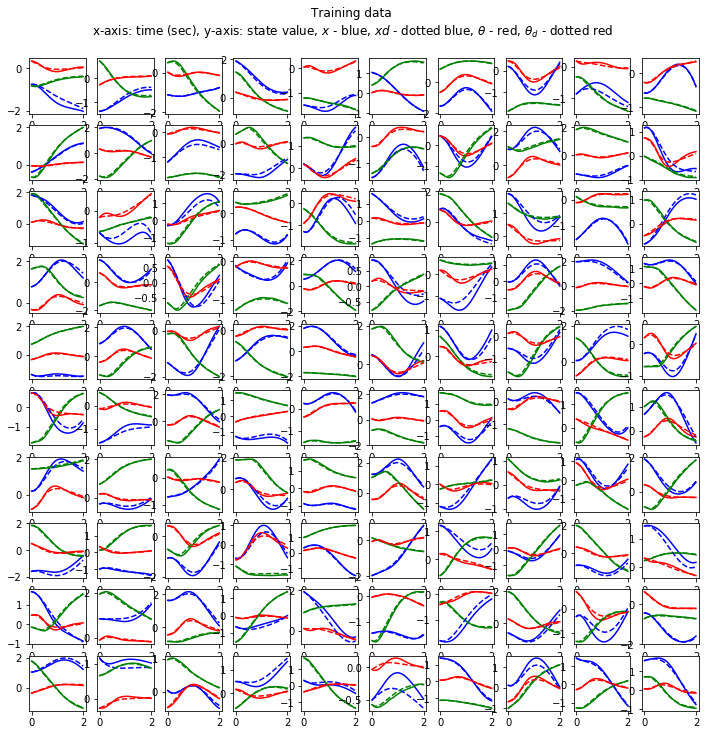

In [4]:
xd = np.empty((n_traj_dc, n_pred_dc + 1, n))
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd[ii, :, :] = mpc_trajgen.parse_result().T
    while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
    xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
    plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
    plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
    plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
    plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
    y=0.94)
plt.show()

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [5]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [6]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_dc, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [7]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [8]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_dc, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
model_edmd.reduce_mdl()
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis_reduced, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [9]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [10]:
n_lift_bedmd = n_lift_edmd
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: planar_quad_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    

### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [11]:
# Prediction performance evaluation parameters:
folder_plots = 'examples/figures/'                                  # Path to save plots
n_traj_ol = 100                                                     # Number of trajectories to execute, open loop

In [12]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_dmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_edmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

    xs_ol[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:]-hover_thrust, t_eval[:-1])

    xs_dmd_ol[ii,:,:], _ = sys_dmd.simulate(x0, ol_controller_nom, t_eval[:-1])

    z_0_edmd = sys_edmd.basis(np.atleast_2d(x0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ol_controller_nom, t_eval[:-1])
    xs_edmd_ol[ii,:,:] = np.dot(model_edmd.C, zs_edmd_tmp.T).T

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T

error_dmd = xs_ol[:,:-1,:] - xs_dmd_ol
error_dmd_mean = np.mean(error_dmd, axis=0).T
error_dmd_std = np.std(error_dmd, axis=0).T
mse_dmd = np.mean(np.square(error_dmd))
std_dmd = np.std(error_dmd)

error_edmd = xs_ol[:,:-1,:] - xs_edmd_ol
error_edmd_mean = np.mean(error_edmd, axis=0).T
error_edmd_std = np.std(error_edmd, axis=0).T
mse_edmd = np.mean(np.square(error_edmd))
std_edmd = np.std(error_edmd)

error_bedmd = xs_ol[:,:-1,:] - xs_bedmd_ol
error_bedmd_mean = np.mean(error_bedmd, axis=0).T
error_bedmd_std = np.std(error_bedmd, axis=0).T
mse_bedmd = np.mean(np.square(error_bedmd))
std_bedmd = np.std(error_bedmd)

print('\nOpen loop performance statistics:\n')
print(tabulate([['DMD', "{:.5f}".format(mse_dmd), '-', '-', "{:.5f}".format(std_dmd), '-', '-'],
               ['EDMD', "{:.5f}".format(mse_edmd), "{:.2f}".format((1 - mse_edmd / mse_dmd) * 100)+' %', '-', "{:.5f}".format(std_edmd), "{:.2f}".format((1 - std_edmd / std_dmd) * 100)+' %', '-'],
               ['bEDMD', "{:.5f}".format(mse_bedmd), "{:.2f}".format((1 - mse_bedmd / mse_dmd) * 100)+' %', "{:.2f}".format((1 - mse_bedmd / mse_edmd) * 100)+' %', "{:.5f}".format(std_bedmd), "{:.2f}".format((1 - std_bedmd / std_dmd) * 100)+' %', "{:.2f}".format((1 - std_bedmd / std_edmd) * 100)+' %']], 
               headers=['MSE', 'MSE improvement\nover DMD', 'MSE improvement\nover EDMD', 'Standard\ndeviation', 'std improvement\nover DMD', 'std improvement\nover EDMD']))

[-0.68321019 -1.29551366  0.06364466  0.84776908 -0.08289461  0.56644305]
[-0.67475141 -1.29654484  0.069209    0.84393294 -0.12334416  0.54642465]
[-0.66636815 -1.29748067  0.07461285  0.83257775 -0.06383234  0.53434603]
[-0.65804843 -1.29853037  0.07992229  0.83135255 -0.14610838  0.52754126]
[-0.64978571 -1.29986108  0.08506442  0.82108363 -0.1200427   0.50088396]
[-0.64163237 -1.30089061  0.08989457  0.80947922 -0.08587363  0.46514756]
[-0.63359627 -1.3015996   0.09442152  0.797643   -0.05593248  0.44024166]
[-0.62567129 -1.30211448  0.0988189   0.78727404 -0.0470509   0.43923396]
[-0.61786277 -1.30243719  0.10307164  0.77434127 -0.01749936  0.41131487]
[-0.61017647 -1.30255774  0.10714657  0.76284347 -0.00661996  0.40366978]
[-0.60263765 -1.30229168  0.11114861  0.74481162  0.05982085  0.3967393 ]
[-0.59525583 -1.30159683  0.11493979  0.73147767  0.07914062  0.36149592]
[-0.58801592 -1.30065403  0.11834882  0.71643133  0.10941032  0.32031126]
[-0.58091951 -1.29948438  0.12133345  

[1.21965805 0.22542943 0.10404574 1.56635801 0.12923265 0.37827111]
[1.23527232 0.22669772 0.1078839  1.55643659 0.12441948 0.38936128]
[1.25078086 0.22796074 0.11172166 1.54520632 0.12817613 0.37819101]
[1.26616758 0.22932788 0.1155606  1.5320631  0.14524309 0.38959759]
[1.28143908 0.23070832 0.11938931 1.52218446 0.1308393  0.37614345]
[1.29659733 0.23205081 0.12312942 1.5093999  0.1376504  0.37187873]
[1.31162143 0.23349595 0.12686489 1.49534979 0.15137034 0.37521504]
[ 1.28900293  1.1770832  -0.00632078  0.36961266 -0.80952597  0.16391135]
[ 1.29270148  1.16891721 -0.0046757   0.37007435 -0.82367045  0.16510422]
[ 1.29640253  1.16026534 -0.00301329  0.3701323  -0.90670484  0.1673776 ]
[ 1.30010637  1.15173164 -0.00135016  0.37057869 -0.80003391  0.16524867]
[ 1.30381213e+00  1.14319992e+00  3.20625698e-04  3.70574459e-01
 -9.06311512e-01  1.68909041e-01]
[ 1.30751761  1.13393207  0.00218821  0.37050447 -0.94725867  0.20460813]
[ 1.31122174  1.1242844   0.00431302  0.37030023 -0.982

[ 0.93106907 -1.28758687  0.0896433  -1.21952347 -1.25715778 -0.1627909 ]
[ 0.91882416 -1.3000927   0.08788069 -1.22942705 -1.24400472 -0.18973201]
[ 0.90648105 -1.31246499  0.08603715 -1.23915997 -1.23044993 -0.17897576]
[ 0.8940298  -1.32456367  0.08436871 -1.25105181 -1.18928383 -0.15471173]
[ 0.88148505 -1.33653977  0.08282193 -1.25787645 -1.20593493 -0.1546443 ]
[ 0.86887555 -1.34871709  0.08141273 -1.26400694 -1.22952677 -0.12719581]
[ 0.85617878 -1.36080428  0.08015958 -1.27531831 -1.18790978 -0.12343473]
[ 0.84337722 -1.37256856  0.07889571 -1.28496737 -1.16494355 -0.12933896]
[ 0.83049607 -1.38430818  0.07763531 -1.29124601 -1.18297946 -0.12274122]
[ 0.81752815 -1.3959118   0.07639387 -1.30230733 -1.13774164 -0.12554643]
[ 0.80447883 -1.40743482  0.07516902 -1.30754441 -1.16686171 -0.11942238]
[ 0.7913699  -1.41914711  0.07406425 -1.31422375 -1.17559456 -0.10153318]
[ 0.77817371 -1.43066291  0.07299813 -1.32498958 -1.12756362 -0.11169098]
[ 0.76488876 -1.4419472   0.07182404 -

[-1.40870783 -1.35991046  0.04828331  0.87884858 -0.9017616   0.2960706 ]
[-1.39994573 -1.36888311  0.05103352  0.87352251 -0.89277138  0.25396998]
[-1.39123906 -1.37775174  0.05371804  0.86776305 -0.88095695  0.28293506]
[-1.38258631 -1.38659692  0.05640667  0.86274646 -0.88808056  0.25478984]
[-1.3739889  -1.39544379  0.05896001  0.85668972 -0.88129549  0.25587791]
[-1.36545065 -1.40426886  0.0615177   0.85091949 -0.88372252  0.25566019]
[-1.35696482 -1.41322247  0.06403189  0.84621581 -0.90699997  0.24717891]
[-1.34852696 -1.42240887  0.06648113  0.8413263  -0.93028312  0.24266865]
[-1.340138   -1.43184155  0.06888642  0.83643656 -0.95625338  0.23838933]
[-1.33181359 -1.44132191  0.07120007  0.82839992 -0.9398221   0.22434051]
[-1.32356629 -1.45070136  0.07332024  0.82102514 -0.93607011  0.19969357]
[-1.31541349 -1.45977754  0.0753853   0.80948104 -0.87917135  0.21331909]
[-1.30737749 -1.46828824  0.07741836  0.79766665 -0.82297132  0.19329165]
[-1.29943809 -1.47653201  0.07937524  

[-0.5390687   0.71946043 -0.05771205  1.02044062  1.24378375  0.37773895]
[-0.52884381  0.73177044 -0.05373315  1.02448921  1.21822098  0.41804066]
[-0.51855506  0.74429926 -0.04957184  1.03314451  1.28755013  0.41422171]
[-0.50821647  0.75683259 -0.04527041  1.03455318  1.21911679  0.44606424]
[-0.49785039  0.76900258 -0.04057015  1.03858827  1.21488512  0.49398674]
[-0.48743539  0.78140903 -0.03552135  1.04428628  1.26640861  0.5157742 ]
[-0.47698653  0.79375977 -0.03047511  1.04545523  1.20374037  0.49347253]
[-0.46651954  0.80573817 -0.0255627   1.04787361  1.1919418   0.4890099 ]
[-0.45603754  0.81730302 -0.0206817   1.04850232  1.12102947  0.48718966]
[-0.44553916  0.82872358 -0.01581675  1.05106013  1.16308297  0.48580169]
[-0.43502598  0.84004615 -0.01068109  1.05154475  1.10143131  0.54132891]
[-0.42450245  0.8514801  -0.0053372   1.05300059  1.18536182  0.52744957]
[-4.13971271e-01  8.63169193e-01 -1.27446806e-04  1.05317801e+00
  1.15245611e+00  5.14501591e-01]
[-0.40344    

[ 0.43363522 -0.92727093  0.14088405 -0.56662575 -0.43118527 -0.01943254]
[ 0.42787436 -0.93140595  0.14073325 -0.58554305 -0.39581987 -0.01072853]
[ 0.4219616  -0.93544991  0.14064935 -0.59700731 -0.4129707  -0.00605108]
[ 0.41591857 -0.93955477  0.1405767  -0.61159659 -0.40800212 -0.00847914]
[ 0.40973856 -0.94367261  0.14047283 -0.6244041  -0.41556432 -0.01229509]
[ 0.40338477 -0.94754227  0.14023705 -0.646348   -0.35836764 -0.03486045]
[ 0.39683677 -0.95101721  0.13993876 -0.66324693 -0.33661961 -0.02479701]
[ 0.39010553 -0.95417229  0.13964339 -0.68299294 -0.2943952  -0.03427682]
[ 0.3832636  -0.95752126  0.1392722  -0.68539285 -0.37539866 -0.03996282]
[ 0.37630951 -0.9610505   0.13884837 -0.70541541 -0.33044739 -0.04480158]
[ 0.36919665 -0.96442499  0.13840334 -0.71714867 -0.34445019 -0.04420432]
[ 0.36196028 -0.96789363  0.13793005 -0.73011897 -0.34927762 -0.05045456]
[ 0.35460212 -0.97146597  0.13737825 -0.74150538 -0.36518794 -0.05990516]
[ 0.34707211 -0.97477564  0.13678363 -

[-0.30627571 -0.01221326 -0.40057951 -0.89645053  0.86791563 -0.08022793]
[-0.31527085 -0.00409689 -0.40134064 -0.90257913  0.75535912 -0.07199679]
[-0.32411815  0.00338649 -0.40211634 -0.86687092  0.74131381 -0.08314424]
[-0.33251529  0.01094717 -0.40306083 -0.81253629  0.77081211 -0.10575228]
[-0.34033001  0.01889257 -0.40420368 -0.75037939  0.81825663 -0.12281958]
[-0.34769992  0.02689727 -0.40537084 -0.72359125  0.78267858 -0.11061186]
[-0.35491086  0.03429171 -0.4063559  -0.71859371  0.69620764 -0.08639925]
[-0.36196461  0.04107025 -0.40707087 -0.69214925  0.65949807 -0.0565943 ]
[-0.36870558  0.04759319 -0.40767829 -0.65603769  0.6450855  -0.06488988]
[-0.37508101  0.05398155 -0.40829978 -0.61903781  0.63258424 -0.05940829]
[-0.38104314  0.06034422 -0.40878383 -0.57338136  0.63994577 -0.03740176]
[-0.38656058  0.06675249 -0.40923249 -0.53009884  0.64170446 -0.05233006]
[-0.39157944  0.07332923 -0.40970055 -0.47366297  0.67363861 -0.04128178]
[-0.39619894  0.07984473 -0.41011747 -

[ 2.16166584  1.18850355  0.35847856  1.00785958 -0.09987184  0.22325073]
[ 2.17142552  1.18786365  0.36063154  0.94401452 -0.02813052  0.2073443 ]
[ 2.18069379  1.18754664  0.36276942  0.90960643 -0.03528399  0.22023249]
[ 2.18958386  1.18724478  0.36506741  0.86836623 -0.02510358  0.23936489]
[ 2.19815978  1.18678449  0.36740458  0.84679561 -0.0669642   0.22806899]
[ 2.20644735  1.18609198  0.36959848  0.81068451 -0.07155012  0.21071075]
[ 2.21432632  1.185473    0.37157549  0.76507174 -0.05226195  0.18469155]
[2.22165521 1.18528431 0.37329483 0.70065895 0.0145066  0.15917777]
[ 2.22850849  1.18532971  0.37481081  0.66997786 -0.00543451  0.14401802]
[2.23499922 1.18531554 0.37612059 0.62814425 0.00259108 0.11793734]
[ 2.2411305   1.18523076  0.3771635   0.59809922 -0.01955143  0.09064485]
[ 2.24689446  1.18509222  0.3779051   0.55467757 -0.00816344  0.05767523]
[2.25219245 1.18514644 0.37837966 0.50491108 0.01900459 0.03723608]
[2.2570285  1.18538177 0.37864333 0.46229442 0.02806005 

[ 0.18347583  0.70848793 -0.26407716 -1.50981776 -0.55925396 -0.53979233]
[ 0.16850038  0.7028556  -0.26931499 -1.48519377 -0.56723313 -0.50777286]
[ 0.15364526  0.69668131 -0.27433244 -1.48583253 -0.66762478 -0.49571766]
[ 0.13900046  0.69026854 -0.27923182 -1.44300405 -0.61496485 -0.48415789]
[ 0.12475353  0.68426318 -0.28397961 -1.40628221 -0.58613607 -0.46539952]
[ 0.11087151  0.67852723 -0.28868381 -1.37002425 -0.56108269 -0.47544232]
[ 0.09724535  0.67267389 -0.29354719 -1.35516781 -0.60959649 -0.49723223]
[ 0.08380455  0.66645205 -0.29846774 -1.33293293 -0.63478962 -0.48687885]
[ 0.07060027  0.66001781 -0.30318991 -1.30785957 -0.65207858 -0.4575545 ]
[ 0.0577099   0.65360502 -0.3076942  -1.27012487 -0.63050829 -0.44330446]
[ 0.04510775  0.64711972 -0.31203276 -1.25025933 -0.66656613 -0.42440723]
[ 0.03272095  0.64032079 -0.3162161  -1.22705204 -0.69323544 -0.41226088]
[ 0.02064719  0.63349653 -0.32027946 -1.18761856 -0.67164304 -0.40040948]
[ 0.00892349  0.62674728 -0.3241848  -

[ 1.12172313 -0.51345934  0.1556211   1.7291564   0.98000034  0.15683746]
[ 1.13890676 -0.50346413  0.15709392  1.70753526  1.01903757  0.13772694]
[ 1.15595664 -0.49360395  0.15846618  1.70243445  0.95299729  0.13672588]
[ 1.17291515 -0.48415369  0.15983244  1.68924818  0.93705123  0.13652629]
[ 1.18974668 -0.47489663  0.16110984  1.67704159  0.91435737  0.1189534 ]
[ 1.20646169 -0.46590346  0.16220716  1.66594795  0.88427588  0.10051087]
[ 1.22305787 -0.45716515  0.1631293   1.65327572  0.86338311  0.08391672]
[ 1.23950481 -0.4485014   0.16405959  1.63609668  0.86936439  0.10214127]
[ 1.25581353 -0.43998333  0.16499295  1.62563852  0.83424942  0.08453102]
[ 1.2719941  -0.43167678  0.16583555  1.61046224  0.82705797  0.0839881 ]
[ 1.28804202 -0.42355843  0.16657138  1.59911238  0.79660977  0.06317749]
[ 1.3039218  -0.41542156  0.16733517  1.57682799  0.83076185  0.08958197]
[ 1.31963715 -0.40729162  0.16822115  1.56623162  0.79522452  0.08761255]
[ 1.33524293 -0.39949758  0.16907854  

[-0.08239846  0.75913363 -0.10765174  1.69818329  1.58827225  0.35712199]
[-0.06535746  0.7750795  -0.10405404  1.7099494   1.60090741  0.36241838]
[-0.04821141  0.79104916 -0.10045575  1.71920706  1.59303058  0.35723918]
[-0.03098976  0.80678592 -0.09697052  1.72508837  1.55432558  0.33980703]
[-0.01369947  0.82224855 -0.09361765  1.73292366  1.53820531  0.33076558]
[ 0.00366647  0.83753567 -0.09031679  1.74022037  1.51922282  0.32940766]
[ 0.0210763   0.8523226  -0.08713969  1.74173603  1.4381637   0.30601211]
[ 0.03851491  0.86646003 -0.08391588  1.74596084  1.38932441  0.33874932]
[ 0.05600598  0.88024177 -0.08074829  1.75221305  1.36702551  0.2947687 ]
[ 0.0735544   0.89375031 -0.07792366  1.75743981  1.33468562  0.27015721]
[ 0.09112808  0.90659729 -0.07526924  1.75729595  1.23471104  0.26072803]
[ 0.1087449   0.91904226 -0.07273089  1.76601844  1.2542854   0.24694024]
[ 0.12644418  0.93163744 -0.07023273  1.77379298  1.26475531  0.25269198]
[ 0.14422334  0.94438772 -0.06770943  

[-0.7881526   0.01593567 -0.20261806  1.97387736 -1.4710168   0.68344796]
[-7.68259109e-01  1.49704601e-03 -1.95590141e-01  2.00464255e+00
 -1.41667125e+00  7.22134797e-01]
[-0.74803236 -0.01223838 -0.18834953  2.04048377 -1.3303712   0.72598702]
[-0.72754333 -0.02558496 -0.18100473  2.05721299 -1.33892409  0.74297245]
[-0.70692399 -0.03920307 -0.17356368  2.0665903  -1.38468576  0.74523791]
[-0.68620597 -0.05323874 -0.16602981  2.07693821 -1.42243457  0.76153736]
[-0.66531941 -0.06724312 -0.15824455  2.10018976 -1.37841203  0.79551342]
[-0.64423761 -0.08100834 -0.15027971  2.11603526 -1.37461116  0.79745539]
[-0.6229659  -0.09449615 -0.14237161  2.13810936 -1.32292191  0.78416429]
[-0.60149485 -0.10757635 -0.13445891  2.15593195 -1.29309464  0.79837639]
[-0.57987218 -0.12051992 -0.12640648  2.16847275 -1.2956013   0.81210929]
[-0.55812138 -0.13343499 -0.11829478  2.18154439 -1.28739603  0.81023078]
[-0.53619119 -0.14581122 -0.11020947  2.20422764 -1.18781889  0.80682999]
[-0.51406239 

[ 0.14744662  1.14759168 -0.37571721 -1.42100505  0.9793088  -0.27370851]
[ 0.13332141  1.15710879 -0.37833174 -1.40401814  0.92410609 -0.24919787]
[ 0.11941333  1.1661909  -0.38077712 -1.37757138  0.89230445 -0.23987864]
[ 0.10581896  1.17507546 -0.3829747  -1.3412683   0.88459417 -0.19963693]
[ 0.09258993  1.18388592 -0.38484416 -1.30450971  0.87748585 -0.17425427]
[ 0.07957058  1.19223374 -0.38649321 -1.29935674  0.7920773  -0.15555677]
[ 0.06688692  1.20042438 -0.38805538 -1.23733669  0.84603532 -0.15687564]
[ 0.05470779  1.20886867 -0.38971519 -1.19846228  0.84281234 -0.17508717]
[ 0.0428997   1.21723537 -0.39156512 -1.16312945  0.83051661 -0.19489894]
[ 0.0314537   1.22549803 -0.39337187 -1.12604343  0.82200258 -0.1664515 ]
[ 0.02033526  1.23356918 -0.39495449 -1.09762682  0.79222063 -0.15007146]
[ 0.00953877  1.24143155 -0.39641655 -1.06165046  0.78024529 -0.14234143]
[-9.33815915e-04  1.24908690e+00 -3.97691112e-01 -1.03285185e+00
  7.50819051e-01 -1.12570630e-01]
[-0.01107533 

 -1.71547784e+00 -8.66783543e-02]
[ 1.82555056 -0.49926138  0.18249338 -0.0103316  -1.75418328 -0.07796194]
[ 1.82530833 -0.51653978  0.18159106 -0.03809216 -1.70149368 -0.10250181]
[ 1.82478744 -0.53328141  0.18050217 -0.06605789 -1.64682726 -0.11527627]
[ 1.82398602 -0.54946667  0.17927508 -0.09419441 -1.59021816 -0.13014113]
[ 1.82289854 -0.56505415  0.17778055 -0.12326062 -1.52727069 -0.16876524]
[ 1.82154295 -0.5801306   0.17596912 -0.14781547 -1.48801163 -0.19352142]
[ 1.81993241 -0.59475375  0.17386693 -0.17424032 -1.43660991 -0.22691604]
[ 1.81810614 -0.60913063  0.17136324 -0.19097341 -1.43875802 -0.27382183]
[ 1.81611972 -0.62356313  0.16858105 -0.20626998 -1.44773571 -0.28261631]
[ 1.81396865 -0.6380088   0.16573995 -0.22389402 -1.44138933 -0.2856044 ]
[ 1.81163654 -0.65235292  0.16288414 -0.24247463 -1.42742752 -0.28555702]
[ 1.80913811 -0.66666665  0.16003048 -0.2571688  -1.43530993 -0.28517437]
[ 1.80645673 -0.68082653  0.15716096 -0.27904154 -1.39665572 -0.28872969]
[ 1.

[ 0.37675693  0.78705448 -0.00213566 -2.06694939  1.46568831 -0.56818629]
[ 0.35608893  0.80158931 -0.00794225 -2.06657959  1.44127861 -0.59313156]
[ 0.33542261  0.81545911 -0.01394576 -2.06669436  1.33268059 -0.60757125]
[ 0.31476304  0.8287573  -0.01995615 -2.06512735  1.32695641 -0.5945058 ]
[ 0.29412296  0.84204679 -0.02584    -2.06278841  1.33093876 -0.58226448]
[ 0.27350513  0.85522738 -0.03171828 -2.06070664  1.30517806 -0.5933914 ]
[ 0.25291062  0.86816083 -0.03772008 -2.05812224  1.28150975 -0.60696878]
[ 0.23235769  0.88119693 -0.04381104 -2.05231881  1.32570435 -0.61122316]
[ 0.21185648  0.89444267 -0.04985626 -2.04782617  1.32343901 -0.59782046]
[ 0.19140057  0.9076173  -0.05583723 -2.04326955  1.3114827  -0.59837521]
[ 0.17100512  0.92088492 -0.06182082 -2.03569243  1.34203308 -0.59834239]
[ 0.15067224  0.93419092 -0.06777916 -2.03081041  1.31916247 -0.59332456]
[ 0.13041868  0.9476728  -0.07365696 -2.01974867  1.37720147 -0.58223595]
[ 0.11024733  0.96129948 -0.07935145 -

[-0.65109713 -0.34635196 -0.39568331  0.92945679 -1.40102914  0.23259966]
[-0.64153965 -0.36022192 -0.39319832  0.98198684 -1.37294196  0.2643976 ]
[-0.63155443 -0.37404218 -0.39044675  1.01502165 -1.39109479  0.28591675]
[-0.62111813 -0.38774661 -0.38743069  1.07216721 -1.3497628   0.31729432]
[-0.61016405 -0.40116342 -0.38412171  1.11858601 -1.33357366  0.34450205]
[-0.59874233 -0.41440412 -0.38041418  1.16568609 -1.31453717  0.39700471]
[-0.58681924 -0.4273716  -0.37621169  1.21883857 -1.27892114  0.44349274]
[-0.57441203 -0.44009494 -0.37166072  1.26251775 -1.26571416  0.46670036]
[-0.56158781 -0.45272948 -0.36670826  1.30224282 -1.26116009  0.52379294]
[-0.54841372 -0.4654346  -0.36126825  1.33250305 -1.27983723  0.56420829]
[-0.53484754 -0.47808156 -0.35543114  1.38060739 -1.24950727  0.60321332]
[-0.52082787 -0.4904881  -0.34929036  1.42320812 -1.23175837  0.62494326]
[-0.50643924 -0.50286355 -0.34289156  1.45442496 -1.24329712  0.6548162 ]
[-0.49181132 -0.515551   -0.33622859  

[-0.59707845  0.00323858 -0.48586274  0.64891903  0.96630317  0.6148392 ]
[-0.59053472  0.0125149  -0.47960141  0.65980401  0.88897159  0.6374273 ]
[-0.58361108  0.02154343 -0.47312378  0.72478815  0.91680543  0.65809896]
[-0.57623421  0.03047436 -0.46631831  0.75052841  0.86940895  0.70299391]
[-0.5684119   0.03931153 -0.4591493   0.81378342  0.89810116  0.73080761]
[-0.56008422  0.04818839 -0.45194884  0.85165915  0.8773151   0.70928585]
[-0.55118885  0.05725602 -0.44477654  0.92722644  0.93630216  0.72517334]
[-0.54165541  0.06668    -0.43730874  0.97932517  0.9485577   0.76838732]
[-0.53161898  0.07619877 -0.42945337  1.02782359  0.95526152  0.80268673]
[-0.52129031  0.08537181 -0.42130317  1.03788032  0.87935869  0.82735171]
[-0.51074683  0.0940451  -0.41297387  1.07071255  0.855346    0.83850865]
[-0.49967407  0.10294898 -0.40438606  1.14359878  0.92553449  0.87905311]
[-0.48788276  0.11255085 -0.39557945  1.21441747  0.99494326  0.88227004]
[-0.47565696  0.12220688 -0.38668358  

[-0.47418151  1.1257421  -0.07805736 -2.01997193  0.15324206 -0.59105225]
[-0.49431877  1.12756299 -0.08389571 -2.00732761  0.21092523 -0.57661693]
[-0.5143613   1.12953897 -0.08979426 -2.0011094   0.18426469 -0.60309257]
[-0.53430592  1.13161329 -0.09577742 -1.98766948  0.23058508 -0.59354042]
[-0.55417185  1.13353832 -0.1016961  -1.98549671  0.15441864 -0.59019578]
[-0.57399123  1.13493416 -0.10748439 -1.97831263  0.12474334 -0.56746207]
[-0.59369781  1.13638816 -0.11316949 -1.96287095  0.16604015 -0.5695572 ]
[-0.61327403  1.13801219 -0.11884432 -1.95228766  0.15875761 -0.56540879]
[-0.6327659   1.13936485 -0.12452449 -1.9460376   0.11176858 -0.57062511]
[-0.65214304  1.14064692 -0.13021053 -1.92926637  0.1446282  -0.56658454]
[-0.67131669  1.14249853 -0.13574156 -1.9052991   0.22567141 -0.53961952]
[-0.6902794   1.14491705 -0.14109652 -1.88712571  0.25801784 -0.53137243]
[-0.70906237  1.14762036 -0.14654143 -1.86935774  0.28262777 -0.55760985]
[-0.72767439  1.1505017  -0.15210538 -

[ 0.75139764  0.30964739  0.13131048 -0.76507749  1.7841692  -0.09762945]
[ 0.74370359  0.32732707  0.13047915 -0.77372483  1.75176706 -0.06863614]
[ 0.73592411  0.3446766   0.12975985 -0.78216208  1.71814026 -0.07522475]
[ 0.72805772  0.36171125  0.12902568 -0.79110784  1.68879202 -0.07160927]
[ 0.72007742  0.37864329  0.12819753 -0.80493805  1.6976175  -0.09402025]
[ 0.71196647  0.39560774  0.12725405 -0.8172357   1.69527459 -0.09467583]
[ 0.70376043  0.41233397  0.126227   -0.82396419  1.64997308 -0.11073281]
[ 0.69543615  0.42901215  0.12515267 -0.84086872  1.68566405 -0.10413366]
[ 0.68695979  0.44591773  0.1240561  -0.85438356  1.69545603 -0.11518145]
[ 0.67838111  0.46266211  0.12286029 -0.86134105  1.65342113 -0.12397961]
[ 0.6696994   0.47926082  0.12160562 -0.87497749  1.66632372 -0.12695486]
[ 0.66086203  0.49615278  0.1203716  -0.89246599  1.71207152 -0.11984871]
[ 0.65192602  0.51287715  0.11919731 -0.89473256  1.63280361 -0.11500983]
[ 0.64293018  0.52912107  0.1180903  -

[-0.43641466 -0.13934016  0.15548426  1.61907524 -0.46720635  0.48070843]
[-0.4202807  -0.14414416  0.16023315  1.60766043 -0.49360216  0.46907063]
[-0.40433893 -0.14874454  0.16487367  1.58056501 -0.42649532  0.45903268]
[-0.38862578 -0.15294922  0.1693781   1.56198286 -0.41445549  0.44185345]
[-0.37310529 -0.15700842  0.17367587  1.54203187 -0.39739821  0.41770042]
[-0.35770087 -0.161383    0.17775544  1.53883974 -0.47752082  0.39821356]
[-0.34244636 -0.16590906  0.18167871  1.51196588 -0.42770816  0.38644045]
[-0.32742475 -0.17014669  0.18538474  1.4922913  -0.41983024  0.35476672]
[-0.31257293 -0.17445888  0.18894056  1.47802829 -0.44261511  0.35639595]
[-0.29786164 -0.17901696  0.19233488  1.46418819 -0.46900864  0.32246981]
[-0.28328212 -0.18387916  0.19557036  1.4516821  -0.50343849  0.32462519]
[-0.26885096 -0.18897406  0.19878392  1.43450351 -0.51555029  0.31808685]
[-0.25464726 -0.1939223   0.20199562  1.40616198 -0.47411281  0.32425397]
[-0.24073371 -0.19843474  0.20508283  

[ 1.47783492 -1.62927508  0.17771328 -0.73874851 -0.08877483 -0.25522609]
[ 1.47037873 -1.63026889  0.175162   -0.75245801 -0.10998105 -0.25502995]
[ 1.46273206 -1.63116589  0.17257174 -0.77681558 -0.06940777 -0.26302371]
[ 1.45491713 -1.63208069  0.16994284 -0.78614777 -0.11354925 -0.26275448]
[ 1.44693602 -1.63300586  0.16732859 -0.81001276 -0.07147341 -0.26009685]
[ 1.43873395 -1.63360439  0.16474839 -0.83034827 -0.04822369 -0.25594225]
[ 1.43039396 -1.63435634  0.16210561 -0.83763091 -0.10216292 -0.27261487]
[ 1.42189246 -1.6350985   0.15929561 -0.86259695 -0.04625878 -0.28938486]
[ 1.41320081 -1.63564025  0.15633453 -0.87569114 -0.06208292 -0.30283128]
[ 1.40437023 -1.63628107  0.1533345  -0.89037959 -0.06607381 -0.29717499]
[ 1.39535665 -1.63671721  0.15027116 -0.91226266 -0.02114291 -0.31549233]
[ 1.38613986 -1.63679278  0.14709965 -0.93102902  0.0060385  -0.31881001]
[ 1.37676567 -1.63678835  0.14367859 -0.94375871 -0.00514685 -0.36540156]
[ 1.36725547 -1.63682404  0.14002494 -

[-1.07164354 -0.5804461   0.01072154  0.36837389  1.40590788  0.04604761]
[-1.06796965 -0.56597142  0.01113035  0.36639224  1.48902865  0.03571379]
[-1.06430846 -0.55132831  0.01142889  0.36584282  1.43959338  0.02399446]
[-1.06065377 -0.53709816  0.01160072  0.36509424  1.40643711  0.01037222]
[-1.05700395 -0.52342796  0.01166351  0.36486999  1.32760334  0.00218533]
[-1.05336071 -0.51017494  0.01179502  0.363775    1.32299978  0.02411642]
[-1.04972953 -0.49688231  0.01197647  0.36245896  1.33552613  0.01217479]
[-1.04610521 -0.48399483  0.01215834  0.36240416  1.24197101  0.02419874]
[-1.04248611 -0.47166202  0.01239001  0.36141322  1.22458912  0.02213614]
[-1.03887848 -0.45938492  0.01264833  0.36010752  1.23083158  0.02952753]
[-1.03528517 -0.4469583   0.01301323  0.35854657  1.25449166  0.04345116]
[-1.03170612 -0.43441654  0.01337753  0.35725921  1.25386036  0.02940961]
[-1.02813544 -0.42222619  0.01366265  0.35687451  1.18420955  0.02761433]
[-1.02457058 -0.41059237  0.01407578  

[-0.76276147 -1.78874048 -0.14573804  1.10826108  0.30547596  0.45576724]
[-0.75156594 -1.78539859 -0.14108074  1.13072425  0.36291915  0.47569129]
[-0.7401686  -1.78161809 -0.13620723  1.14864038  0.39319581  0.49901126]
[-0.7285746  -1.77738174 -0.13117492  1.17002527  0.45409073  0.50745136]
[-0.71682788 -1.77297443 -0.12605227  1.17925846  0.42738015  0.51707771]
[-0.70498832 -1.76881521 -0.12080099  1.18858753  0.40447157  0.53317883]
[-0.69302759 -1.76463515 -0.11551376  1.203447    0.4315537   0.52426754]
[-0.68095758 -1.76049905 -0.11023178  1.21050029  0.39567335  0.53212777]
[-0.66877036 -1.75627767 -0.10488773  1.22680987  0.44861548  0.5366822 ]
[-0.6564653  -1.75192485 -0.09959798  1.23413878  0.42195603  0.52126831]
[-0.64406863 -1.74763259 -0.094298    1.24509586  0.43650483  0.53872786]
[-0.63160622 -1.74363459 -0.08896113  1.24736455  0.36309719  0.5286462 ]
[-0.61909298 -1.74004096 -0.08343151  1.25520051  0.35563736  0.57727762]
[-0.60648373 -1.7362743  -0.07765215  

[-0.48096557 -0.17409209 -0.01007987 -1.66373231 -1.15368883 -0.51547962]
[-0.49759676 -0.18559894 -0.01515725 -1.66241721 -1.14768103 -0.49999742]
[-0.51420976 -0.1969022  -0.0201501  -1.66007226 -1.11297328 -0.49857214]
[-0.53079783 -0.20794201 -0.02507639 -1.65744569 -1.09499194 -0.48668524]
[-0.5473551  -0.2187382  -0.02980367 -1.65390636 -1.06424922 -0.45877244]
[-0.56387659 -0.22931011 -0.03425606 -1.65030836 -1.05013411 -0.43170532]
[-0.58036529 -0.23989927 -0.03852024 -1.64737586 -1.0676999  -0.42112922]
[-0.5968152  -0.25046924 -0.04261676 -1.64252288 -1.04629756 -0.39817474]
[-0.61320386 -0.26059123 -0.04658877 -1.63510066 -0.97810674 -0.3962283 ]
[-0.62953439 -0.2704355  -0.05037946 -1.63095157 -0.99074801 -0.36190884]
[-0.64581173 -0.28021037 -0.05406145 -1.62443939 -0.96423083 -0.3744908 ]
[-0.6620478  -0.29019268 -0.05763526 -1.62275586 -1.03223284 -0.34027129]
[-0.6782495  -0.3005659  -0.06096943 -1.61753486 -1.04241281 -0.32656187]
[-0.69438765 -0.3108819  -0.06415727 -

[-1.52221587 -1.06510796 -0.2495593   0.8703516  -0.18423897  0.37347283]
[-1.51336566 -1.06686226 -0.24576295  0.89961689 -0.1666032   0.38579669]
[-1.50425254 -1.06854999 -0.24182237  0.92294405 -0.17092753  0.40231932]
[-1.49486215 -1.07009349 -0.23792933  0.95504947 -0.13775039  0.37628918]
[-1.48514389 -1.07126589 -0.23411257  0.98851455 -0.09670993  0.38706273]
[-1.47504094 -1.07180484 -0.23007291  1.03195223 -0.01104913  0.42087009]
[-1.46464282 -1.07206809 -0.22563434  1.04762067 -0.04158969  0.46684416]
[-1.4540286  -1.07236893 -0.22096601  1.0751284  -0.01855679  0.46682075]
[-1.44314211 -1.07243867 -0.21631135  1.10207672  0.00462928  0.46411058]
[-1.43202685 -1.07244967 -0.21158439  1.12090611 -0.00681441  0.48128278]
[-1.4206818  -1.07237015 -0.20662078  1.14799834  0.02274022  0.51143849]
[-1.40909845 -1.07213591 -0.20157969  1.1685886   0.02412469  0.49678047]
[-1.39729899 -1.07182464 -0.1965771   1.19121034  0.0381485   0.50373734]
[-1.38529784 -1.07148252 -0.19146594  

[-0.96269345 -0.40545081  0.00959456 -0.30936706 -0.1630453   0.04450164]
[-0.96579287 -0.40698336  0.01014202 -0.31052639 -0.14346513  0.06499036]
[-0.96890187 -0.40854703  0.01079322 -0.31128317 -0.16926924  0.0652485 ]
[-0.9720226  -0.41001567  0.01162737 -0.31288099 -0.12445809  0.10158287]
[-0.97515852 -0.41115621  0.01262133 -0.31432317 -0.10365013  0.09720857]
[-0.97831007 -0.4120407   0.01365702 -0.31601032 -0.07324832  0.10993009]
[-0.98147711 -0.4127694   0.01471736 -0.31741355 -0.07249182  0.10213783]
[-0.98465889 -0.41347693  0.01577329 -0.31896165 -0.06901554  0.10904667]
[-0.98785537 -0.41423212  0.01685354 -0.32035008 -0.08202217  0.10700321]
[-0.99107102 -0.41483778  0.01800635 -0.3228062  -0.0391108   0.12355979]
[-9.94311672e-01 -4.15035825e-01  1.92210184e-02 -3.25351697e-01
 -4.98270870e-04  1.19373741e-01]
[-0.99757415 -0.41507492  0.02047512 -0.3271627  -0.0073208   0.13144697]
[-1.00085907 -0.4150033   0.02185421 -0.329851    0.02164328  0.14437142]
[-1.00416852 

[ 1.11106237  0.9835072  -0.21582427  0.09296804 -0.96220414  0.07906394]
[ 1.1120997   0.9738863  -0.21493514  0.11448193 -0.96197298  0.09876074]
[ 1.11339551  0.96446885 -0.21388742  0.14465611 -0.92151249  0.1107846 ]
[ 1.11502285  0.95559696 -0.21284431  0.18078377 -0.85285855  0.09783734]
[ 1.11695936  0.94717415 -0.21192125  0.20649892 -0.83169992  0.08677352]
[ 1.11909762  0.93870773 -0.21097083  0.2211432  -0.861582    0.10331085]
[ 1.12143834  0.93020615 -0.20984237  0.24697703 -0.83872811  0.12238118]
[ 1.1239959   0.92174142 -0.20860389  0.26451839 -0.85421562  0.12531486]
[ 1.12674063  0.91318003 -0.20729039  0.28440753 -0.85805776  0.13738439]
[ 1.12967445  0.90453663 -0.20597533  0.30233785 -0.8706183   0.12562877]
[ 1.13279766  0.89581875 -0.20467903  0.3222828  -0.87295303  0.13363097]
[ 1.1361402   0.88717666 -0.20341552  0.34620074 -0.85545963  0.11907157]
[ 1.1396977   0.87859546 -0.20217225  0.36527956 -0.86077713  0.12958191]
[ 1.14346936  0.87007847 -0.20073994  

[ 0.01085281 -0.03982321  0.0457448   1.09364013 -1.99906975  0.74523761]
[ 0.02176655 -0.05983463  0.05305529  1.08899298 -2.00321971  0.71686032]
[ 0.032619   -0.07968189  0.06011699  1.08133881 -1.96624089  0.69547859]
[ 0.04341815 -0.09960701  0.06699513  1.07843911 -2.01878724  0.68014944]
[ 0.05417286 -0.11985751  0.07381437  1.07240501 -2.03131946  0.68369955]
[ 0.06488808 -0.14054535  0.08053108  1.07061306 -2.10625161  0.65964133]
[ 0.07555283 -0.16159918  0.0870415   1.06222774 -2.10452321  0.64244392]
[ 0.08614953 -0.18284886  0.09342354  1.05705141 -2.1454169   0.63396441]
[ 0.09664568 -0.20401736  0.09964414  1.0420179  -2.08829994  0.61015367]
[ 0.10701846 -0.22492622  0.1056343   1.03244547 -2.09348171  0.58788026]
[ 0.11727213 -0.2456962   0.11150668  1.0181606  -2.0605281   0.58659528]
[ 0.12739435 -0.26627072  0.1172628   1.00618274 -2.05438654  0.56462769]
[ 0.13744236 -0.2871897   0.12290019  1.00339845 -2.1294117   0.56285024]
[ 0.14737334 -0.30815296  0.12837842  

[-1.11377109  0.95810494  0.0375866   0.3383912   0.15969619 -0.05336584]
[-1.1103963   0.95945499  0.03706998  0.33657198  0.11031287 -0.04995979]
[-1.10704152  0.96036407  0.03659324  0.33438743  0.07150403 -0.04538748]
[-1.10371818  0.96115134  0.03627117  0.33028781  0.08594971 -0.01902599]
[-1.10043001  0.96192639  0.03612522  0.32734743  0.06906068 -0.01016396]
[-1.09717981  0.96277101  0.03606458  0.32269355  0.09986358 -0.00196461]
[-1.09397709  0.96395005  0.03613298  0.31784965  0.13594469  0.01564488]
[-1.09082858  0.96564706  0.03638196  0.31184492  0.20345606  0.03415124]
[-1.08774193  0.96806174  0.03680613  0.30547256  0.27948035  0.05068318]
[-1.08471008  0.97098426  0.03731997  0.30088805  0.3050227   0.05208453]
[-1.0817246   0.97416806  0.03776819  0.29619829  0.33173703  0.03755973]
[-1.07877441  0.97730603  0.03818624  0.29383463  0.29585752  0.04604911]
[-1.07585017  0.98014186  0.03856221  0.29100982  0.27130668  0.02914545]
[-1.07294741  0.98255423  0.03894376  

[0.82956404 0.89239117 0.0600128  0.78998486 0.54454714 0.88277971]
[0.83743324 0.8978323  0.06888584 0.78371097 0.54366983 0.8918293 ]
[0.84524538 0.9031253  0.07787329 0.77861354 0.5149226  0.9056611 ]
[0.85300284 0.90813774 0.08694236 0.77277138 0.48755718 0.90815166]
[0.86069675 0.91289757 0.09606791 0.76589523 0.46439829 0.91695899]
[0.86834739 0.91713461 0.10517092 0.76420814 0.38300691 0.90364353]
[0.87591148 0.92119222 0.11424005 0.74839335 0.42849209 0.91018132]
[0.88333686 0.92548363 0.12333272 0.73653238 0.42977199 0.90835387]
[0.89070779 0.92924677 0.13239086 0.73766561 0.32285765 0.90327333]
[0.89807883 0.93202608 0.14139129 0.73653001 0.23300108 0.89681196]
[0.90545083 0.93381952 0.15047658 0.73788366 0.12569005 0.92024621]
[0.91278799 0.93485521 0.15965476 0.72946652 0.08143394 0.91539031]
[0.92000964 0.93562379 0.16883695 0.7147283  0.07226088 0.92104773]
[0.92707694 0.93631654 0.17814896 0.69858834 0.06626426 0.94135441]
[0.93397704 0.93695673 0.18750954 0.68128483 0.0

[-0.42748476 -0.3248789  -0.45054459 -0.8774389  -0.53522981 -0.78960069]
[-0.43600226 -0.33019415 -0.45823776 -0.82592746 -0.52788685 -0.74903324]
[-0.443939   -0.33531366 -0.46547742 -0.7612635  -0.49609172 -0.698899  ]
[-0.45129941 -0.34026581 -0.47243349 -0.71070211 -0.49439809 -0.6923151 ]
[-0.45818161 -0.34526286 -0.47936033 -0.66563807 -0.50506402 -0.69305211]
[-0.46452102 -0.35019761 -0.48619121 -0.60210562 -0.48195711 -0.67312289]
[-0.47022072 -0.35490289 -0.49282484 -0.5377     -0.45917052 -0.6536038 ]
[-0.47526944 -0.359377   -0.49945838 -0.47190886 -0.43572365 -0.67310502]
[-0.4798885  -0.36404239 -0.50622559 -0.45186354 -0.497377   -0.68033547]
[-0.48405904 -0.36888216 -0.51314553 -0.38209963 -0.47065796 -0.70365363]
[-0.48760164 -0.37358788 -0.52012255 -0.32630665 -0.47055061 -0.69175039]
[-0.49064774 -0.37840705 -0.52690973 -0.28282836 -0.49333341 -0.66568536]
[-0.49308352 -0.38315964 -0.53353106 -0.20417996 -0.45727174 -0.65858052]
[-0.49471966 -0.3875395  -0.54007056 -

[-0.09136461  0.65858249  0.09505361 -0.45587564 -0.42711544 -0.49053308]
[-0.09596559  0.65427155  0.09010259 -0.46424612 -0.43506605 -0.49967123]
[-0.10066096  0.65002703  0.08507746 -0.47472633 -0.41382792 -0.50535587]
[-0.10544164  0.64579818  0.0799015  -0.48134144 -0.43193634 -0.52983477]
[-0.11029469  0.64149461  0.07459048 -0.48917949 -0.42877236 -0.53236951]
[-0.11523936  0.63744126  0.06923266 -0.4996244  -0.38188778 -0.53919534]
[-0.12026561  0.63357621  0.06378514 -0.50554473 -0.3911159  -0.5503075 ]
[-0.12533733  0.62943688  0.05823419 -0.50875018 -0.43674796 -0.55988372]
[-0.13046507  0.62529223  0.05257601 -0.51666451 -0.39217487 -0.57175191]
[-0.13565073  0.62125499  0.04683403 -0.52039603 -0.41526957 -0.57664487]
[-0.14087964  0.6171669   0.04110383 -0.52528017 -0.40234423 -0.56939444]
[-0.14614056  0.61285977  0.03539222 -0.52686318 -0.4590795  -0.57292792]
[-0.15142573  0.60827248  0.02962867 -0.53007705 -0.45837503 -0.57978098]
[-0.15673205  0.60339858  0.02381456 -

[ 1.32710496e+00  1.43438474e+00 -1.36052792e-03  1.24119283e-01
 -1.09073114e+00  1.58755339e-01]
[ 1.32834623e+00  1.42308171e+00  2.80547966e-04  1.24129689e-01
 -1.16987409e+00  1.69459839e-01]
[ 1.32958748  1.410949    0.00211249  0.12411642 -1.25666904  0.19692761]
[ 1.3308274   1.39834114  0.0041676   0.12383552 -1.2649028   0.21409619]
[ 1.33206465  1.38542631  0.00641626  0.12359851 -1.31806318  0.23563406]
[ 1.33330247  1.37150078  0.00889537  0.123987   -1.46704228  0.26018933]
[ 1.33454068  1.35650948  0.0115722   0.12364023 -1.53121762  0.27517533]
[ 1.33577385  1.34096525  0.01447252  0.12296838 -1.57762985  0.30489028]
[ 1.33700196  1.32480022  0.01762789  0.12264203 -1.65537643  0.32618232]
[ 1.33822163  1.30811634  0.02099705  0.12125116 -1.68139925  0.34765105]
[ 1.33942905  1.29104145  0.02451837  0.12020629 -1.73357951  0.35661264]
[ 1.34061719  1.2737562   0.02818591  0.11735597 -1.7234721   0.37689433]
[ 1.34177897  1.25643093  0.03192175  0.11495087 -1.74158443  

[-1.97861037 -1.83357628 -0.74293676 -0.33355392 -0.60848654  0.46745847]
[-1.98164076 -1.83981836 -0.7382211  -0.27257506 -0.63988204  0.47567251]
[-1.98409126 -1.8464042  -0.73347715 -0.2175747  -0.67724191  0.47311769]
[-1.98584215 -1.85319418 -0.72870268 -0.13267803 -0.68068574  0.48177718]
[-1.98678925 -1.86006477 -0.72378725 -0.05681247 -0.69337146  0.50130777]
[-1.98689693 -1.86696623 -0.7187281   0.03518954 -0.68684157  0.51052154]
[-1.98626451 -1.87400337 -0.71352826  0.09123817 -0.72053774  0.52944718]
[-1.98498876 -1.88127797 -0.70806877  0.16383492 -0.73431762  0.56245004]
[-1.98296884 -1.88866425 -0.70225071  0.24006272 -0.74286459  0.601163  ]
[-1.98037168 -1.89635017 -0.69609092  0.27932166 -0.79427855  0.63079477]
[-1.97731702 -1.90446925 -0.68971547  0.33154208 -0.82948116  0.64429518]
[-1.97340162 -1.91252393 -0.68305187  0.45137676 -0.78132285  0.68842432]
[-1.96842221 -1.92025273 -0.6761041   0.54437076 -0.76432859  0.70112974]
[-1.96260412 -1.92791755 -0.66879698  

[-1.38104064 -0.77908285  0.06998182 -0.4096538  -0.69050856  0.84930539]
[-1.38516852 -0.7860487   0.07839381 -0.41604235 -0.7026691   0.83309204]
[-1.38935276 -0.793273    0.08664264 -0.42088734 -0.74219803  0.81667409]
[-1.39363252 -0.8003944   0.09483744 -0.43528085 -0.68210187  0.822287  ]
[-1.39802133 -0.80733815  0.10303847 -0.44258119 -0.70665844  0.81791816]
[-1.40251394 -0.81426593  0.11115588 -0.45611167 -0.67891564  0.80556464]
[-1.40712449 -0.82111315  0.11901403 -0.46611051 -0.69054226  0.76606568]
[-1.41185588 -0.82793366  0.1265692  -0.48031296 -0.67357782  0.7449687 ]
[-1.41672972 -0.834615    0.13386124 -0.49458623 -0.66270737  0.71343908]
[-1.42172925 -0.84134102  0.14092521 -0.50541323 -0.68250762  0.6993538 ]
[-1.42684385 -0.84823734  0.14779837 -0.51760249 -0.6967713   0.67527874]
[-1.43210905 -0.85510552  0.15428895 -0.53556582 -0.67688365  0.62283615]
[-1.43753446 -0.8619224   0.16039311 -0.54960487 -0.68650613  0.59799728]
[-1.44313662 -0.86863014  0.16621942 -

[-1.5174105  -1.12300695  0.01386673  0.75788959  0.42639123  0.611968  ]
[-1.50983303 -1.11914348  0.0200275   0.75758448  0.34630069  0.62018742]
[-1.50226167 -1.11596797  0.02614581  0.7566464   0.28880167  0.60347354]
[-1.49471509 -1.112864    0.03204582  0.7525312   0.33198882  0.57652916]
[-1.48720669 -1.10953663  0.03775341  0.74905313  0.33348036  0.56498794]
[-1.47974079 -1.10607123  0.04333638  0.7440127   0.35959533  0.55160692]
[-1.47232603 -1.10240459  0.048842    0.7388361   0.3737284   0.54951586]
[-1.46496842 -1.09855107  0.05416175  0.73257766  0.39697062  0.51443476]
[-1.45765917 -1.09477631  0.05927808  0.72922125  0.35797747  0.50883137]
[-1.45041066 -1.09097089  0.0641801   0.72036455  0.40309998  0.47157332]
[-1.44329013 -1.08616748  0.06870067  0.70355072  0.55756978  0.43254051]
[-1.43629862 -1.08045593  0.07296288  0.69466189  0.58473326  0.41990022]
[-1.4293828  -1.07468564  0.07704407  0.68844677  0.56932056  0.39633845]
[-1.42255582 -1.06875042  0.08075621  

[-0.7219425  -0.51745251 -0.06148127  0.98370066  0.17248421  0.22021993]
[-0.71207442 -0.51570737 -0.05925839  0.98987609  0.17654726  0.2243552 ]
[-0.70213847 -0.51379747 -0.05700727  0.99726677  0.20543567  0.22587039]
[-0.69215442 -0.51203148 -0.05475549  0.99952823  0.14776325  0.22448562]
[-0.68213025 -0.51050987 -0.05245686  1.00526499  0.15655964  0.23523929]
[-0.67207057 -0.50929872 -0.04993799  1.00666014  0.08567147  0.26853558]
[-0.66198381 -0.50852186 -0.04727729  1.01065517  0.06970304  0.26360332]
[-0.65187281 -0.50821948 -0.04474327  1.01153743 -0.00922807  0.24320091]
[-0.64173222 -0.50822884 -0.04229665  1.01653207  0.0073596   0.24612389]
[-0.63154762 -0.50818134 -0.03994798  1.020352    0.00214162  0.22361041]
[-0.62131406 -0.50788469 -0.03776622  1.02630449  0.05718937  0.21274048]
[-0.61102936 -0.50721897 -0.0355557   1.03059252  0.07595737  0.22936308]
[-0.60071269 -0.50664123 -0.03324228  1.03271716  0.03959164  0.2333213 ]
[-0.59036529 -0.5061131  -0.03095075  

[-1.32017426  0.73985348 -0.25396308 -2.00005266  1.21947306 -0.36070042]
[-1.340064    0.75198246 -0.25748419 -1.9778449   1.2063096  -0.34352033]
[-1.3597404   0.7639408  -0.26087621 -1.95739213  1.18534572 -0.33488485]
[-1.37927193  0.77546186 -0.26416507 -1.94889574  1.11886218 -0.32288708]
[-1.39863769  0.78661349 -0.2674359  -1.92420742  1.11144983 -0.331279  ]
[-1.41771515  0.79783571 -0.27067079 -1.89121956  1.13297801 -0.31569901]
[-1.43650435  0.80911645 -0.27377974 -1.86657563  1.12315563 -0.30609125]
[-1.45503289  0.82034425 -0.27675056 -1.83908329  1.12239052 -0.28807299]
[-1.47330748  0.83148542 -0.27960508 -1.81579594  1.1058325  -0.28283039]
[-1.49134036  0.84248733 -0.28235741 -1.79074119  1.09453805 -0.26763608]
[-1.50915646  0.85325589 -0.28509569 -1.77245072  1.05916639 -0.28001894]
[-1.52675782  0.86377583 -0.28785856 -1.74778114  1.04480934 -0.27255455]
[-1.54407622  0.87427    -0.29064698 -1.71584982  1.05400984 -0.28512936]
[-1.56110389  0.88475546 -0.29355129 -

[-1.21903465 -0.11002483 -0.38088815  1.03833554 -2.05567874  0.13703782]
[-1.20851741 -0.13073728 -0.37921543  1.06509412 -2.0868038   0.19750627]
[-1.19769667 -0.15166888 -0.37703519  1.09902189 -2.09950369  0.23854211]
[-1.18650288 -0.17263908 -0.37454225  1.13969448 -2.09451989  0.26004506]
[-1.1748335  -0.19337991 -0.37177987  1.19411787 -2.05361995  0.29243043]
[-1.16267039 -0.21383575 -0.3686748   1.23844363 -2.03752521  0.32858416]
[-1.15007047 -0.23414185 -0.36517046  1.28147591 -2.02366953  0.3722834 ]
[-1.13708325 -0.25441621 -0.36119331  1.31590764 -2.03118079  0.42314642]
[-1.12368592 -0.27458509 -0.35685493  1.3634672  -2.00255985  0.44452986]
[-1.1098066  -0.29444199 -0.35236683  1.41229726 -1.96878321  0.4530912 ]
[-1.09544722 -0.31397436 -0.34772555  1.4594787  -1.93765499  0.47516352]
[-1.0805957  -0.33312949 -0.34278304  1.51070859 -1.89332933  0.51333849]
[-1.06529591 -0.35201036 -0.33763194  1.54915666 -1.88281089  0.5168822 ]
[-1.04964824 -0.37088183 -0.33232622  

[ 1.76836784 -0.69801157  0.34301036  0.67950083 -1.21893581  0.1760209 ]
[ 1.77490656 -0.70997508  0.34468795  0.62820311 -1.17378176  0.15949741]
[ 1.78095087 -0.72154233  0.34611778  0.58062895 -1.13967939  0.12646977]
[ 1.78649528 -0.73270434  0.34723474  0.5282246  -1.09273323  0.09692091]
[ 1.79163901 -0.74373979  0.34806079  0.5005111  -1.11435943  0.06828961]
[ 1.79652726 -0.75505202  0.34870592  0.47713165 -1.14808953  0.0607373 ]
[ 1.8010759  -0.76641131  0.34926328  0.43258571 -1.12377279  0.05073411]
[ 1.80526322 -0.77775933  0.3496609   0.40487335 -1.14583179  0.02878896]
[ 1.80917882 -0.78934312  0.34986646  0.37824325 -1.17092785  0.01232425]
[ 1.81276784 -0.80101286  0.34987246  0.33956104 -1.16302095 -0.01112572]
[ 1.81593858 -0.81251718  0.34963424  0.29459136 -1.13783968 -0.03651725]
[ 1.81858815 -0.823573    0.34923728  0.23533364 -1.07332029 -0.04287532]
[ 1.8208155  -0.83445057  0.34872371  0.21014249 -1.10219284 -0.05983829]
[ 1.82271863 -0.84541727  0.34808091  

[ 0.44161776 -0.27897482  0.16705863  1.00710914 -0.36908723 -0.45279278]
[ 0.4515853  -0.28253632  0.1624514   0.98649258 -0.34319697 -0.46865318]
[ 0.46143218 -0.28634762  0.15783566  0.98290109 -0.41906067 -0.45449531]
[ 0.4711581  -0.29037465  0.1532889   0.962383   -0.38633028 -0.45485621]
[ 0.4806988  -0.29418497  0.14885178  0.94583627 -0.37572122 -0.43256856]
[ 0.49007263 -0.29786328  0.14435927  0.92901494 -0.35992769 -0.46593217]
[ 0.49926224 -0.3012539   0.13974037  0.9090159  -0.31818023 -0.45784874]
[ 0.50829228 -0.30449393  0.13509886  0.89705799 -0.32981789 -0.47045325]
[ 0.51718774 -0.30772331  0.1303137   0.8821226  -0.31604608 -0.48657724]
[ 0.52597544 -0.31111522  0.12548587  0.87545927 -0.36232986 -0.47898909]
[ 0.53470806 -0.31505261  0.12075895  0.87109323 -0.42514522 -0.46639484]
[ 0.54335359 -0.3192485   0.11610525  0.85809704 -0.41402179 -0.46434558]
[ 0.55187443 -0.32335661  0.11142252  0.84615299 -0.40759135 -0.47220138]
[ 0.56027737 -0.32739183  0.10670338  

[ 1.70801513 -0.81887158 -0.07458003 -0.09707496 -1.63139999 -0.07310022]
[ 1.70706802 -0.83536069 -0.07529181 -0.09233923 -1.66642398 -0.06925665]
[ 1.70618969 -0.85191994 -0.07599362 -0.08331335 -1.64542669 -0.07110428]
[ 1.70540019 -0.86829333 -0.07667818 -0.07457254 -1.62925127 -0.06580836]
[ 1.704694   -0.88456323 -0.07727833 -0.0666563  -1.62473006 -0.05422126]
[ 1.70406864 -0.90077012 -0.07782026 -0.05840553 -1.61664963 -0.05416587]
[ 1.70353901 -0.91673077 -0.0783603  -0.04750778 -1.57548064 -0.05384144]
[ 1.7031095  -0.9323971  -0.07890339 -0.03838398 -1.55778686 -0.05477717]
[ 1.70273855 -0.94830283 -0.07929898 -0.0358048  -1.62335934 -0.02433994]
[ 1.7024363  -0.96432541 -0.07951742 -0.02463954 -1.58115641 -0.01934787]
[ 1.70222352 -0.98020601 -0.07971224 -0.01791444 -1.59496435 -0.01961696]
[ 1.70209217 -0.9960482  -0.07984372 -0.00835204 -1.57347226 -0.00667949]
[ 1.70206227 -1.01160338 -0.07988929  0.00237391 -1.53756541 -0.00243405]
[ 1.7021073  -1.02720362 -0.07987172  

[-0.11238759 -0.36954383  0.01766366  0.35251059 -0.23493213  0.13295599]
[-0.10887077 -0.37192544  0.01892137  0.35083293 -0.24138958  0.11858564]
[-0.10537375 -0.37424449  0.02009919  0.34854843 -0.22242041  0.11697873]
[-0.10189767 -0.37650073  0.02137514  0.34664835 -0.22882826  0.13821155]
[-0.09843902 -0.37892088  0.02273999  0.34506581 -0.2552034   0.13475784]
[-0.09499819 -0.38153924  0.02402404  0.34308091 -0.2684675   0.12205223]
[-0.09157706 -0.38431852  0.02523268  0.34113034 -0.28738942  0.11967561]
[-0.08818323 -0.38700103  0.02642814  0.33760689 -0.24911389  0.11941752]
[-0.08482154 -0.38944726  0.02770603  0.33470929 -0.24013246  0.13615869]
[-0.08148708 -0.39189015  0.02896426  0.33216296 -0.24844633  0.11548845]
[-0.07818034 -0.39435796  0.03003715  0.32916844 -0.24511597  0.09908983]
[-0.07490422 -0.39678695  0.0309936   0.32603803 -0.24068263  0.09220037]
[-0.07166861 -0.39889321  0.03189229  0.32106108 -0.1805692   0.08753585]
[-0.06847935 -0.40052637  0.03279865  

[-0.21638423  1.48937085 -0.3360464   0.55298111  0.89917698  0.25317312]
[-0.21063972  1.49848849 -0.33346355  0.59586896  0.92436897  0.26339602]
[-0.20456873  1.50756678 -0.3308485   0.6182994   0.89129754  0.25961545]
[-0.19822687  1.51645308 -0.32826663  0.65003262  0.88597714  0.25675718]
[-0.1916058   1.52517786 -0.32570063  0.67415064  0.85898864  0.25644306]
[-0.18468652  1.53380515 -0.32308965  0.70966092  0.86648507  0.26575432]
[-0.17737938  1.54261013 -0.32044245  0.75171096  0.89452939  0.26368427]
[-0.1697632   1.55136433 -0.31764444  0.77149619  0.85631967  0.29591871]
[-0.16180051  1.56019305 -0.31466995  0.82096818  0.90944875  0.29897843]
[-0.15349435  1.56909446 -0.31159763  0.84023279  0.87084385  0.31548646]
[-0.14497837  1.57766655 -0.30833936  0.86292441  0.84358615  0.33616736]
[-0.13623522  1.58597094 -0.30497362  0.8856656   0.81730522  0.33698081]
[-0.12727464  1.5939849  -0.30173018  0.90641468  0.78549843  0.31170766]
[-0.11804956  1.60186839 -0.2985853   

[0.51950371 1.01222237 0.2980336  0.16115722 0.66212843 0.02003592]
[0.52108057 1.01846613 0.29816046 0.15421463 0.58662318 0.0053361 ]
[ 0.52248466  1.02429107  0.29815023  0.12660382  0.57836474 -0.00738239]
[ 0.52364775  1.02991926  0.29803508  0.106015    0.54727359 -0.01564729]
[ 0.52460633  1.03523221  0.29774358  0.08570535  0.51531807 -0.04265236]
[ 0.52540994  1.04006917  0.2972816   0.07501774  0.45207435 -0.04974272]
[ 0.52601132  1.04458539  0.29676863  0.04526704  0.45117268 -0.05285146]
[ 0.52634618  1.04899214  0.29617182  0.02171201  0.43017957 -0.0665109 ]
[ 0.52633141  1.053564    0.29538636 -0.02464487  0.48419933 -0.09058083]
[ 0.52598367  1.05824874  0.2944499  -0.0448922   0.45275009 -0.09671193]
[ 0.52548059  1.06246455  0.29340732 -0.05571857  0.39041493 -0.11180306]
[ 0.52473897  1.06648948  0.29227666 -0.09258264  0.41457863 -0.11432924]
[ 0.52369608  1.07053437  0.29109882 -0.11597995  0.39440264 -0.12123871]
[ 0.52243507  1.07432621  0.28986742 -0.13620873  

[-0.78716615  0.15484549 -0.18521006  1.08738412 -0.96466117  0.17183644]
[-0.77625292  0.14491927 -0.18340603  1.09524846 -1.02057924  0.18897001]
[-0.76521021  0.13471116 -0.18140384  1.11326109 -1.02103633  0.21146773]
[-0.7539838   0.12452375 -0.17933807  1.13198712 -1.01644038  0.20168588]
[-0.74258319  0.1143159  -0.1772646   1.14810226 -1.02512356  0.21300844]
[-0.73107359  0.10373436 -0.17513342  1.15380702 -1.09118255  0.2132276 ]
[-0.71942581  0.09295461 -0.1730517   1.17570598 -1.06476057  0.20311601]
[-0.70766322  0.08184829 -0.17104092  1.17681078 -1.15650242  0.1990412 ]
[-0.69575675  0.07059702 -0.16896721  1.2044266  -1.09374163  0.21570043]
[-0.68356844  0.06001717 -0.16682344  1.23317574 -1.02221884  0.21305391]
[-0.67112735  0.0499566  -0.16464649  1.25499405 -0.98988678  0.22233542]
[-0.65847519  0.04018531 -0.1623505   1.27538984 -0.96436361  0.23686223]
[-0.64562478  0.03064335 -0.15997442  1.29464551 -0.94402089  0.23835421]
[-0.63259016  0.02126181 -0.15764488  

[0.69934038 0.0116501  0.44263967 1.29860711 2.02828864 0.13895195]
[0.71214857 0.03181736 0.44378501 1.2630155  2.00515612 0.09011511]
[0.72465006 0.05164885 0.44454925 1.23727707 1.96113878 0.06273369]
[0.73679215 0.07125377 0.44507093 1.19113207 1.95984138 0.04160164]
[0.74859541 0.09058816 0.44542213 1.16951652 1.90703619 0.02863863]
[0.76017155 0.10941727 0.44564789 1.14571046 1.85878427 0.01651256]
[0.77136122 0.12807435 0.44592044 1.0922176  1.87263052 0.0379984 ]
[0.78196776 0.14697023 0.44630868 1.02908145 1.90653988 0.03964928]
[0.79205064 0.16597954 0.44655235 0.98749252 1.89532032 0.00908465]
[ 8.01721386e-01  1.84868655e-01  4.46588508e-01  9.46655469e-01
  1.88250301e+00 -1.85333038e-03]
[ 0.81091109  0.20378136  0.4464745   0.89128835  1.90003932 -0.02094754]
[ 0.81948493  0.22299968  0.44606309  0.82348941  1.94362905 -0.06133444]
[ 0.82760119  0.24219369  0.44543671  0.79976695  1.89517565 -0.0639429 ]
[ 0.83529085  0.26130046  0.44469719  0.73818035  1.92618645 -0.083

[-0.28826898  0.14862962  0.01264669 -0.05366809  0.79312113  0.03657995]
[-0.28881097  0.15648726  0.01280818 -0.05473229  0.77840796 -0.00428069]
[-0.28936345  0.1641846   0.01273548 -0.0557641   0.76106042 -0.01025988]
[-0.2899276   0.17181638  0.0126721  -0.05706354  0.76529483 -0.00241682]
[-0.29050196  0.17927337  0.0126309  -0.05780901  0.72610245 -0.00582164]
[-0.29108162  0.18616797  0.01271312 -0.05812292  0.65281878  0.02226399]
[-0.29167042  0.19279784  0.01291133 -0.05964093  0.67315545  0.01737815]
[-0.29227077  0.19934235  0.01314552 -0.06043104  0.63574467  0.02946113]
[-0.29288095  0.20565256  0.01341774 -0.0616089   0.62629773  0.02498158]
[-0.29350758  0.21220626  0.01362127 -0.0637226   0.68444321  0.01572574]
[-0.29415356  0.21920109  0.01371228 -0.06547591  0.71452193  0.002475  ]
[-0.2948135   0.22623365  0.01371624 -0.06651261  0.69199106 -0.00168283]
[-0.29548551  0.2331652   0.013669   -0.06788832  0.694318   -0.00776518]
[-0.29616854  0.23992077  0.01377575 -

[ 0.79042989 -1.78122622  0.00461199  0.86179052  0.07445603  0.6468067 ]
[ 0.79904304 -1.78027037  0.01111363  0.86068768  0.11671348  0.65352104]
[ 0.80763892 -1.77876659  0.01769448  0.85830595  0.184041    0.6626505 ]
[ 0.81620941 -1.77678526  0.02428307  0.85565429  0.21222157  0.65506612]
[ 0.8247508  -1.77458088  0.03071929  0.85250164  0.22864987  0.63217856]
[ 0.83324605 -1.77187781  0.03696412  0.84635778  0.3119588   0.61678803]
[ 0.84168858 -1.76870941  0.04296179  0.84204213  0.32171597  0.5827453 ]
[ 0.85007885 -1.76531115  0.04855262  0.83588663  0.3579313   0.53541994]
[ 0.85840914 -1.76165479  0.05372531  0.83007365  0.37333523  0.49911922]
[ 0.86664617 -1.75726255  0.05864555  0.81714213  0.50510242  0.48492871]
[ 0.87477377 -1.75197562  0.06344081  0.80826177  0.55227683  0.47412418]
[ 0.88281121 -1.74624937  0.06810271  0.79911841  0.5929649   0.45825518]
[ 0.89074442 -1.73997884  0.07261498  0.78739872  0.66113236  0.44419927]
[ 0.8985612  -1.73308709  0.07684623  

[ 1.12294784  0.14686671  0.0746415  -0.11368522  0.87416845  0.11794731]
[ 1.12177092  0.15565098  0.07572698 -0.1217178   0.88268348  0.09914976]
[ 1.12051161  0.16453989  0.07687901 -0.13016385  0.89509838  0.13125481]
[ 1.11916823  0.17353915  0.07823222 -0.13853679  0.90475172  0.13938723]
[ 1.11773411  0.1827143   0.07968081 -0.14831693  0.930276    0.15033251]
[ 1.11619937  0.1921683   0.08126597 -0.15866575  0.96051938  0.16669895]
[ 1.11458555  0.20161418  0.08297497 -0.16411701  0.92865706  0.1750998 ]
[ 1.11290338  0.21089978  0.08479256 -0.17234761  0.92845895  0.18841816]
[ 1.11116265  0.21989532  0.08653049 -0.17580838  0.87064901  0.15916866]
[ 1.10936847  0.22852476  0.08825748 -0.18305133  0.85523643  0.18622971]
[ 1.10748546  0.23717567  0.09021887 -0.19359019  0.87494272  0.20604778]
[ 1.10551355  0.24582954  0.09235888 -0.20081972  0.8558282   0.2219553 ]
[ 1.10346535  0.25432578  0.09453143 -0.20885089  0.84341588  0.212553  ]
[ 1.10133442  0.26271347  0.09674239 -

[ 0.70525146  1.06078402  0.08053859  1.27454046 -1.13743865  0.74870803]
[ 0.71796829  1.04926264  0.08792148  1.26873951 -1.16684554  0.72787148]
[ 0.73059758  1.03774511  0.09515375  1.25696397 -1.13667443  0.7185826 ]
[ 0.7431108   1.0264644   0.10230309  1.24554344 -1.11948145  0.71128387]
[ 0.75551028  1.01531182  0.10928674  1.2342281  -1.11104714  0.68544797]
[ 0.76779384  1.00423507  0.11603077  1.2223658  -1.10431623  0.6633569 ]
[ 0.78002562  0.99263301  0.1226341   1.22400594 -1.21609457  0.6573086 ]
[ 0.79217031  0.98074165  0.12917333  1.20476628 -1.16219732  0.65053839]
[ 0.80418653  0.9688672   0.135664    1.1984263  -1.21270011  0.64759528]
[ 0.81604026  0.95719105  0.14192983  1.17212297 -1.12255725  0.60557104]
[ 0.82763375  0.94635646  0.14777773  1.14640297 -1.04438522  0.56400955]
[ 0.83899539  0.9361012   0.15333694  1.12579977 -1.00668691  0.54783246]
[ 0.85016788  0.92609046  0.15881176  1.10859923 -0.99547628  0.54713101]
[ 0.86117659  0.91612226  0.16413992  

[-0.02979937 -0.62078169 -0.13866565 -0.08055451 -0.15293445  0.96769914]
[-0.03056406 -0.62250182 -0.12909706 -0.0724804  -0.19107902  0.94601958]
[-0.03123589 -0.62448478 -0.11977646 -0.06201504 -0.20549596  0.91810016]
[-0.03185026 -0.62698096 -0.11067717 -0.06087429 -0.29373862  0.90175795]
[-0.03241574 -0.63000859 -0.1017373  -0.05233991 -0.31177515  0.88621631]
[-0.03287777 -0.63299766 -0.09290229 -0.04024874 -0.28602025  0.88078469]
[-0.03322694 -0.6357575  -0.08418094 -0.02975845 -0.265932    0.86348589]
[-0.03348807 -0.63845992 -0.07566456 -0.02259271 -0.27454254  0.83979111]
[-0.03368173 -0.64125397 -0.06743018 -0.01626072 -0.28425907  0.80708294]
[-0.033811   -0.6440728  -0.05930488 -0.00973302 -0.27949849  0.81797771]
[-0.03389338 -0.64709449 -0.05127655 -0.00681404 -0.32483486  0.7876883 ]
[-0.03394365 -0.65046653 -0.04364267 -0.00333246 -0.34956839  0.73908831]
[-3.39578296e-02 -6.53988340e-01 -3.63607595e-02  3.83145895e-04
 -3.54789568e-01  7.17293512e-01]
[-0.03394225 

[ 0.12023069 -1.50407519 -0.0660229   0.55695322 -0.59130389  0.27430609]
[ 0.12580605 -1.51038937 -0.06331035  0.5581105  -0.67153138  0.26820446]
[ 0.13142858 -1.51693237 -0.06065153  0.56633712 -0.63706483  0.26355792]
[ 0.13712744 -1.5232007  -0.05806732  0.5733824  -0.61659873  0.25328559]
[ 0.142899   -1.5291983  -0.05546526  0.58087272 -0.58291718  0.26712518]
[ 0.14874601 -1.5348171  -0.05275665  0.58846614 -0.54083981  0.27459745]
[ 0.15465083 -1.54032729 -0.04981887  0.59245948 -0.56119515  0.31295852]
[ 0.16060921 -1.54573746 -0.04663925  0.5991436  -0.52083533  0.3229661 ]
[ 0.16661854 -1.55104383 -0.04341834  0.60268055 -0.54043737  0.32121553]
[ 0.17266307 -1.55652041 -0.0402192   0.60618102 -0.55487607  0.31861208]
[ 0.17874027 -1.56216681 -0.03698834  0.60921633 -0.57440312  0.32756053]
[ 0.18484168 -1.56814391 -0.03370629  0.61103705 -0.62101655  0.3288497 ]
[ 0.1909699  -1.57429723 -0.03032416  0.61454475 -0.60964388  0.34757521]
[ 0.19712622 -1.58051134 -0.02689142  

[ 1.3700141  -0.16707602 -0.00888717  0.77942827 -0.84180949  0.06730715]
[ 1.37781656 -0.17504399 -0.00835554  0.78104577 -0.75178426  0.03901994]
[ 1.38562946 -0.18275464 -0.00790111  0.78153037 -0.79034539  0.05186455]
[ 1.39345106 -0.19033445 -0.00739714  0.7827755  -0.7256161   0.04893011]
[ 1.40128161 -0.19769422 -0.00689334  0.78332857 -0.74633908  0.05183067]
[ 1.4091177  -0.20523137 -0.00640133  0.78388227 -0.76108905  0.04657139]
[ 1.41695956 -0.21284504 -0.00580057  0.78447959 -0.76164492  0.07357912]
[ 1.4248077  -0.22034932 -0.00502061  0.78513263 -0.73921249  0.08241404]
[ 1.43266321 -0.22734879 -0.00415667  0.7859443  -0.6606817   0.09037336]
[ 1.44052389 -0.23412485 -0.00320708  0.78618136 -0.69453001  0.09954447]
[ 1.44838806 -0.24073687 -0.00212128  0.78662279 -0.62787239  0.11761607]
[ 1.45625552e+00 -2.46795465e-01 -9.55127423e-04  7.86841169e-01
 -5.83847376e-01  1.15614328e-01]
[ 1.46412417e+00 -2.52680853e-01  2.99017577e-04  7.86871722e-01
 -5.93230216e-01  1.35

[ 2.35950912 -0.41573822  0.33702426  0.3139008   1.99094042 -0.04508429]
[ 2.362457   -0.39577359  0.33661218  0.2756821   2.00198876 -0.03733168]
[ 2.3650794  -0.37585988  0.33607452  0.24880476  1.98075611 -0.07019979]
[ 2.36737043 -0.35597843  0.33541865  0.20941463  1.99553805 -0.06097379]
[ 2.36926773 -0.33594847  0.3347221   0.17005901  2.0104587  -0.07833714]
[ 2.37080391 -0.31586129  0.33401862  0.13718762  2.00697973 -0.06235806]
[ 2.37191919 -0.29554203  0.33327476  0.08588664  2.05688028 -0.08641386]
[ 2.37252169 -0.27472241  0.33223421  0.03463849  2.10705131 -0.12169607]
[ 2.3727415  -0.25377505  0.33095296  0.00933969  2.08242631 -0.13455475]
[ 2.37260155 -0.23276115  0.32962543 -0.03730011  2.12036402 -0.1309519 ]
[ 2.37209883 -0.2116683   0.3283074  -0.0632266   2.09821192 -0.132653  ]
[ 2.37138623 -0.19094051  0.32700199 -0.07928282  2.04734963 -0.12842868]
[ 2.37037755 -0.1703202   0.32570831 -0.12242674  2.0767212  -0.1303078 ]
[ 2.36889933 -0.14929046  0.32433467 -

[ 1.96852661 -0.70755641  0.30894329 -0.43207063  0.86599182  0.25129745]
[ 1.96403691 -0.69885899  0.31138184 -0.46591308  0.87347774  0.23641156]
[ 1.9591855  -0.69001887  0.31362292 -0.50441317  0.89453194  0.21180407]
[ 1.95402267 -0.68119894  0.31569247 -0.52817798  0.86944664  0.20210745]
[ 1.94868945 -0.67283782  0.31764607 -0.53847681  0.80277336  0.18861204]
[ 1.94309126 -0.66465279  0.31937718 -0.58119733  0.83422092  0.15760958]
[ 1.93705838 -0.6561342   0.32085461 -0.6254127   0.86948601  0.13787598]
[ 1.93063964 -0.64743528  0.32216824 -0.65835589  0.87029084  0.12485092]
[ 1.92394231 -0.63888252  0.32348204 -0.68112458  0.84025551  0.13790943]
[ 1.91691427 -0.63032477  0.32481247 -0.72451296  0.8712847   0.12817632]
[ 1.90948952 -0.62156973  0.32600667 -0.76045903  0.87971677  0.11066404]
[ 1.90158985 -0.61239119  0.32692334 -0.81950167  0.95598179  0.07267002]
[ 1.89316161 -0.60263458  0.32750733 -0.86615945  0.99533573  0.04412674]
[ 1.88417132 -0.59220465  0.32783917 -

[ 0.04914359  0.59657105 -0.60004258  1.63421488  0.42641406 -0.15894906]
[ 0.06578657  0.60078388 -0.60161161  1.69440414  0.41613586 -0.15485785]
[ 0.08310763  0.60500335 -0.60298036  1.76983247  0.4277407  -0.1188914 ]
[ 0.10112923  0.60925936 -0.60429735  1.83450885  0.42344791 -0.14450598]
[ 0.11975689  0.61341216 -0.60578345  1.89104352  0.40709835 -0.15271531]
[ 0.13909552  0.61761016 -0.60729508  1.97671297  0.43247983 -0.14961033]
[ 0.15921063  0.6219447  -0.60874296  2.0463338   0.43441174 -0.13996466]
[ 0.17997149  0.62622473 -0.61004894  2.10585553  0.42158113 -0.12123178]
[-0.48593105  1.46543109 -0.06181709  0.95593574 -0.84193968 -0.55596683]
[-0.47634348  1.45696366 -0.06747366  0.96166262 -0.85155181 -0.57534853]
[-0.46668734  1.44852638 -0.07307712  0.96967175 -0.83591228 -0.54534312]
[-0.45694338  1.44030628 -0.07854198  0.979234   -0.80811565 -0.54762856]
[-0.44710988  1.43224572 -0.08399203  0.98755917 -0.80400461 -0.54238118]
[-0.43719155  1.42421219 -0.08933426  

[ 0.97592368  0.68031041  0.22783828  0.99085794 -0.51401736  0.32430828]
[ 0.98566722  0.67538807  0.23107413  0.95777263 -0.47046752  0.32286215]
[ 0.99511147  0.67075748  0.23429559  0.9310173  -0.45566557  0.32142944]
[ 1.00426858  0.66634857  0.23749859  0.9003375  -0.42613219  0.31917064]
[ 1.01310203  0.66229553  0.24058627  0.86628021 -0.38449301  0.29836568]
[ 1.0216123   0.65857919  0.24355678  0.83571129 -0.35878996  0.2957362 ]
[ 1.0298314   0.65505391  0.24633438  0.80805891 -0.34627895  0.25978262]
[ 1.03778069  0.65162089  0.24901062  0.78175202 -0.34033757  0.27546593]
[ 1.04546416  0.64825216  0.2517587   0.75489357 -0.33342035  0.27414967]
[ 1.05283702  0.64510945  0.25444552  0.71961695 -0.29513743  0.26321576]
[ 1.05987467  0.64227486  0.25711082  0.6878596  -0.27179447  0.26984297]
[ 1.06663399  0.63951842  0.25974699  0.66396462 -0.27950337  0.25739071]
[ 1.0731552   0.63667703  0.26232644  0.64023866 -0.28878567  0.25850042]
[ 1.07944411  0.63371978  0.26500752  

[ 1.15371236 -1.54860726  0.53580122 -0.46416099 -0.37873633 -0.57098756]
[ 1.14868616 -1.55223452  0.5299029  -0.5409507  -0.34663946 -0.60867634]
[ 1.14291711 -1.55557472  0.52360705 -0.61272961 -0.32132591 -0.65049441]
[ 1.13631129 -1.55844544  0.51696195 -0.70825107 -0.25271326 -0.67852566]
[ 1.12891204 -1.56090301  0.51009915 -0.77146906 -0.23872864 -0.69403257]
[ 1.12093703 -1.56331294  0.50293038 -0.82342158 -0.24319378 -0.73972172]
[ 1.11234947 -1.56558928  0.49549533 -0.89393121 -0.2119869  -0.74728877]
[ 1.10319399 -1.56779728  0.48787336 -0.93706078 -0.22955902 -0.77710554]
[ 1.09348153 -1.56993505  0.47989247 -1.00525961 -0.19790498 -0.81907325]
[ 1.0832245  -1.57200916  0.47157262 -1.04603732 -0.21685968 -0.84489602]
[ 1.07252948 -1.57420489  0.4630745  -1.09283516 -0.22221977 -0.85472736]
[ 1.06140822 -1.57652847  0.45459571 -1.13130551 -0.24244213 -0.84103002]
[ 1.04976564 -1.57876431  0.44614491 -1.19702058 -0.20463245 -0.84913089]
[ 1.0374534  -1.58058079  0.43756692 -

[ 0.35906106  0.59205395 -0.2113539  -0.65855283 -2.10492579 -0.35933984]
[ 0.35255983  0.57090484 -0.21484144 -0.64164757 -2.12490591 -0.33816832]
[ 0.3463166   0.54995501 -0.21817173 -0.60690936 -2.06507847 -0.32788963]
[ 0.34035106  0.5292784  -0.22143049 -0.58614888 -2.07025471 -0.32386357]
[ 0.33458872  0.50852359 -0.22464011 -0.56627159 -2.08071768 -0.31805976]
[ 0.32904998  0.48776585 -0.22775039 -0.54142178 -2.07084354 -0.30399649]
[ 0.32378076  0.46718978 -0.23050353 -0.51236546 -2.04438425 -0.24663153]
[ 0.31877667  0.44676299 -0.23314425 -0.48840761 -2.04098402 -0.28151255]
[ 0.31395533  0.4261258  -0.23574578 -0.47583684 -2.08645906 -0.23879341]
[ 0.30924622  0.40497506 -0.23801422 -0.4659707  -2.14369423 -0.21489465]
[ 0.30478719  0.38387224 -0.24007119 -0.42577848 -2.07688179 -0.19649895]
[ 0.30069298  0.36327937 -0.24185454 -0.39302246 -2.04170238 -0.16017154]
[ 0.29688028  0.34284719 -0.24333697 -0.3694952  -2.04473922 -0.13631333]
[ 0.29336193  0.32261936 -0.24455254 -

[ 1.30018409 -0.84649315  0.16733954  1.34563581 -0.69931056  0.17552843]
[ 1.31352818 -0.85331439  0.16898228  1.32314505 -0.66494327  0.15302059]
[ 1.32663375 -0.85971875  0.17048008  1.29793258 -0.61593365  0.14653947]
[ 1.33950585 -0.86574743  0.17180098  1.27645952 -0.58980853  0.11764119]
[ 1.35210511 -0.87118525  0.1728444   1.24336002 -0.49775994  0.09104299]
[ 1.36441364 -0.87593823  0.17377171  1.21832292 -0.45284097  0.09441853]
[ 1.37653885 -0.88062723  0.17467834  1.20670927 -0.48496033  0.08690659]
[ 1.3885156  -0.88545627  0.17552242  1.18862681 -0.48085124  0.08190933]
[ 1.40032634 -0.89033001  0.17618983  1.17351142 -0.49389848  0.05157401]
[ 1.41195888 -0.89518386  0.17656779  1.15298974 -0.47687278  0.02401733]
[ 1.42334524 -0.89963905  0.17686688  1.12427443 -0.41416579  0.03580041]
[ 1.43452535 -0.90392099  0.17723484  1.11174206 -0.44222227  0.03779204]
[ 1.44559136 -0.90854689  0.17753601  1.10145791 -0.4829596   0.02244131]
[ 1.45656139 -0.9136188   0.17778787  

[ 0.81011446  0.11683843  0.4659096  -0.78500499  1.56808009 -0.59394967]
[ 0.80214126  0.13227487  0.46005692 -0.80958867  1.519231   -0.57658625]
[ 0.79372982  0.14761659  0.45420612 -0.87257283  1.54917392 -0.59357518]
[ 0.78470229  0.16323909  0.44822534 -0.93281021  1.5753863  -0.60257961]
[ 0.77513717  0.17899795  0.44192196 -0.98011013  1.57643708 -0.65809618]
[ 0.76518576  0.19459132  0.43528938 -1.01010018  1.54226965 -0.66842037]
[ 0.75491179  0.20989766  0.42853911 -1.04461054  1.51903702 -0.68163352]
[ 0.7444102   0.22471972  0.4216872  -1.0556797   1.445387   -0.68874952]
[ 0.73360021  0.239251    0.41471125 -1.10618511  1.46092735 -0.70644041]
[ 0.72226383  0.25399736  0.40763429 -1.160943    1.48841058 -0.70895144]
[ 0.71047952  0.26879862  0.40042985 -1.19582098  1.47188182 -0.73193581]
[ 0.69828723  0.28358369  0.39312237 -1.24250068  1.48519031 -0.72955989]
[ 0.68566809  0.29841649  0.38568117 -1.28121115  1.48141773 -0.75868098]
[ 0.67269908  0.31312946  0.37790017 -

[-0.00983967  0.16527524  0.2915546   1.49998485 -0.45759855  0.30304304]
[ 0.00501683  0.16068472  0.2944899   1.47126703 -0.4605196   0.2840178 ]
[ 0.01956906  0.15611622  0.29726954  1.43912987 -0.45319601  0.2719089 ]
[ 0.03378164  0.15167526  0.29993536  1.40333589 -0.43501211  0.26125636]
[ 0.04764146  0.14739408  0.30242411  1.36858197 -0.42123795  0.23649269]
[ 0.06120619  0.14307826  0.30469578  1.34433447 -0.44193378  0.21784234]
[ 0.07446844  0.13874285  0.30679227  1.30807437 -0.42516163  0.20145419]
[ 0.08736703  0.13457439  0.30875389  1.27160678 -0.40854167  0.1908705 ]
[ 0.0999398   0.13044676  0.31065679  1.24291913 -0.41699379  0.18971001]
[ 0.112127    0.12653848  0.31249108  1.19447387 -0.3646779   0.17714853]
[ 0.12389599  0.1229441   0.31421297  1.1592932  -0.35420786  0.1672285 ]
[ 0.13537168  0.11927165  0.31570915  1.13582629 -0.38028786  0.13200684]
[ 0.14654181  0.11555342  0.31687956  1.09817822 -0.36336497  0.10207501]
[ 0.15734635  0.1119692   0.31774597  

[-1.81393273  0.39895946 -0.51077203 -0.69401363 -0.02101079  0.12309856]
[-1.82040488  0.39909484 -0.50940146 -0.60045446  0.04810752  0.15101362]
[-1.82620134  0.39945838 -0.50790652 -0.55885655  0.02461062  0.14797559]
[-1.83139305  0.39992786 -0.50620652 -0.47952558  0.06930813  0.19202474]
[-1.83581924  0.40079722 -0.50405309 -0.40576029  0.10459134  0.23865969]
[-1.83963559  0.40179085 -0.50159417 -0.35754659  0.09415419  0.25312544]
[-1.84301811  0.40259448 -0.49889879 -0.31898789  0.0665895   0.28595038]
[-1.84609889  0.40297056 -0.49592214 -0.29718935  0.00863636  0.30937935]
[-1.84884276  0.40298895 -0.4927674  -0.25162785 -0.0049332   0.32156902]
[-1.85098138  0.40315428 -0.48954908 -0.1761717   0.03803867  0.32209486]
[-1.85258579e+00  4.03340176e-01 -4.86202606e-01 -1.44744561e-01
 -8.41897979e-04  3.47199997e-01]
[-1.85371653  0.4034422  -0.48267455 -0.08147272  0.02128336  0.35841124]
[-1.85411995e+00  4.03951783e-01 -4.78888839e-01  6.87953084e-04
  8.06856217e-02  3.98

[-0.40762495 -0.32237301  0.19061424  1.28423711 -1.90279465  0.23836065]
[-0.39487269 -0.34142641  0.19296123  1.26617798 -1.90789294  0.23103569]
[-0.38233443 -0.36036623  0.19519843  1.24142757 -1.88007932  0.2164043 ]
[-0.37000124 -0.37924891  0.1973056   1.2251806  -1.89646268  0.20503106]
[-0.35785874 -0.3981592   0.19932627  1.20328365 -1.8856023   0.19910185]
[-0.34594145 -0.41693563  0.20119187  1.18013942 -1.86969218  0.17401831]
[-0.33422535 -0.43570603  0.20289587  1.16305539 -1.88439242  0.166783  ]
[-0.32266909 -0.45468034  0.20446652  1.14817897 -1.91047339  0.14734565]
[-0.3113829  -0.47333463  0.20593267  1.10901322 -1.82039439  0.14588568]
[-0.30038137 -0.49160591  0.20732142  1.09127225 -1.83386485  0.13186308]
[-0.2895687  -0.50996048  0.20874101  1.07123993 -1.83705534  0.15205454]
[-0.27892667 -0.52849016  0.21027881  1.05714894 -1.86888442  0.15550535]
[-0.26853082 -0.54684866  0.21182478  1.02197831 -1.80282274  0.15368953]
[-0.25847947 -0.56458603  0.21323325  

[ 0.11420972  1.2853339  -0.33627139 -0.05820311 -0.93979918 -0.25015372]
[ 0.11386314  1.27611723 -0.338632   -0.01106121 -0.90355296 -0.22196843]
[ 0.11379189  1.26670271 -0.34075462 -0.00318059 -0.97935417 -0.20255435]
[ 0.1139291   1.25689435 -0.3426572   0.03065323 -0.98232998 -0.17796307]
[ 0.11436566  1.24694441 -0.34423591  0.05667862 -1.00766367 -0.13777859]
[ 0.11511836  1.23689515 -0.34535288  0.09387943 -1.00219492 -0.0856145 ]
[ 0.11621059  1.22680881 -0.34617677  0.12457787 -1.01507886 -0.07916407]
[ 0.11759875  1.21656196 -0.34678477  0.15306221 -1.03429236 -0.04243599]
[ 0.11930782  1.20622216 -0.3470579   0.18875746 -1.03366997 -0.01218955]
[ 0.12140473  1.19597365 -0.34717311  0.23062672 -1.01603371 -0.01085392]
[ 0.12392533  1.18591514 -0.34717268  0.27349357 -0.99566742  0.01094134]
[ 0.12694075  1.17624332 -0.34685069  0.32958147 -0.93869386  0.05345639]
[ 0.13047059  1.16701368 -0.34628814  0.37637343 -0.90723039  0.05905406]
[ 0.13445259  1.15805618 -0.34564151  

[-0.7412389   0.06418165 -0.36584049  0.91707263  1.12451568  0.26437687]
[-0.73193461  0.07528592 -0.3630497   0.94375333  1.09634937  0.29377981]
[-0.72232176  0.0862218  -0.35997178  0.97876917  1.09084582  0.32180438]
[-0.712347    0.09713844 -0.35660761  1.01612598  1.09250252  0.35103009]
[-0.70204567  0.10795033 -0.35301505  1.0440952   1.06989172  0.36748197]
[-0.69141694  0.11867034 -0.34926567  1.08158696  1.07413444  0.38239392]
[-0.6804188   0.12942365 -0.3454754   1.11797829  1.07655043  0.37566103]
[-0.66906495  0.14018421 -0.34166659  1.15272993  1.07558456  0.38610085]
[-0.65736993  0.15092312 -0.3378341   1.1862135   1.07221791  0.38039597]
[-0.6453927   0.16148374 -0.33403526  1.20918999  1.03992136  0.37937328]
[-0.63312622  0.17189763 -0.33004728  1.2440393   1.04287973  0.41822274]
[-0.62057698  0.18215512 -0.32582616  1.26576368  1.00863207  0.42599966]
[-0.60791769  0.19175587 -0.32159847  1.26609485  0.91151914  0.41953836]
[-0.59526184  0.20036519 -0.31734789  

[ 1.74257178  0.2307925   0.3195646  -0.56057974 -1.58970588  0.01510557]
[ 1.73678299  0.21495791  0.31955049 -0.59717885 -1.57721081 -0.01792694]
[ 1.73059219  0.19935735  0.31929612 -0.64097586 -1.5428989  -0.03294875]
[ 1.72391932  0.18423406  0.31877172 -0.6935827  -1.48175488 -0.07192987]
[ 1.71679345  0.16950232  0.31805233 -0.73157762 -1.46458882 -0.07194888]
[ 1.70930924  0.15487802  0.31709279 -0.76524817 -1.46026635 -0.11995904]
[ 1.7013988   0.14057209  0.31567285 -0.81680388 -1.4009061  -0.16402815]
[ 1.69306566  0.12657902  0.31386526 -0.84979214 -1.39769852 -0.19749072]
[ 1.68446881  0.11241702  0.31185389 -0.86955816 -1.43469614 -0.20478393]
[ 1.67560663  0.0980976   0.30965983 -0.90284025 -1.42917467 -0.23402779]
[ 1.66654518  0.08341891  0.30723214 -0.90944031 -1.50656086 -0.25150877]
[ 1.65732767  0.06825197  0.3045594  -0.93402674 -1.52681554 -0.28304068]
[ 1.64777156  0.05318232  0.30158371 -0.97712785 -1.48709407 -0.31209643]
[ 1.63774008  0.03866045  0.29838809 -

[-1.66261008 -1.7032953  -0.42524135 -0.77665205  0.26573493  0.01505379]
[-1.6701964  -1.70073048 -0.42501287 -0.74061523  0.24722999  0.0306409 ]
[-1.67746737 -1.6984499  -0.42454325 -0.71358396  0.2088876   0.06328307]
[-1.6844087  -1.69642095 -0.42375576 -0.67469298  0.19690774  0.09421676]
[-1.69088016 -1.69433116 -0.42275934 -0.6196185   0.22106063  0.10506701]
[-1.69687288 -1.69215834 -0.4215787  -0.57894342  0.21351013  0.13106076]
[-1.70257599 -1.69032104 -0.42024837 -0.56168785  0.1539552   0.13500428]
[-1.70797255 -1.68877836 -0.41886619 -0.51764739  0.15458998  0.14143213]
[-1.71306014 -1.68752306 -0.41741201 -0.49988056  0.09647382  0.14940459]
[-1.71779519 -1.68645322 -0.41577492 -0.44716079  0.1175088   0.17801215]
[-1.72205432 -1.68528659 -0.41388116 -0.40469543  0.115832    0.20074051]
[-1.72589124 -1.68413972 -0.41182133 -0.36272168  0.11355466  0.21122493]
[-1.72933558 -1.68307519 -0.40963452 -0.32617796  0.09936452  0.22613699]
[-1.73243865 -1.68220573 -0.40723884 -

[ 0.8414018  -0.65115306 -0.2497113  -0.68724152 -0.61055612 -0.24403921]
[ 0.83465304 -0.65726586 -0.251932   -0.66247597 -0.61201244 -0.20010084]
[ 0.82820325 -0.66319855 -0.25387578 -0.62743674 -0.5745367  -0.18865367]
[ 0.82204678 -0.66898122 -0.25576033 -0.6038291  -0.58200568 -0.18825813]
[ 0.81615365 -0.67473797 -0.25742396 -0.57476554 -0.56935143 -0.14446724]
[ 0.81050471 -0.68054774 -0.25871215 -0.55500775 -0.59260617 -0.11317032]
[ 0.80510487 -0.68639741 -0.25972286 -0.52494074 -0.57733364 -0.08897159]
[ 0.79998064 -0.69219071 -0.26051826 -0.49989346 -0.58133018 -0.07010937]
[ 0.79513018 -0.69793798 -0.26102715 -0.4701883  -0.56812628 -0.03166824]
[ 0.79050911 -0.7038073  -0.26123018 -0.45402291 -0.60573857 -0.00893825]
[ 0.78610291 -0.70985389 -0.26121563 -0.42721816 -0.60357768  0.01184836]
[ 0.78202057 -0.71566987 -0.26100935 -0.38925549 -0.55961713  0.02940858]
[ 0.77832409 -0.72102212 -0.26063053 -0.35004927 -0.51083049  0.04635607]
[ 0.7749884  -0.72600255 -0.26003913 -

[-0.74128785 -1.05524899 -0.40374051  0.9844429   0.17952983  0.39347257]
[-0.73127531 -1.05354925 -0.39976293  1.01801228  0.16044114  0.40204369]
[-0.72084575 -1.05184273 -0.39560973  1.06781728  0.18089775  0.42859656]
[-0.7099191  -1.04992685 -0.39121685  1.11742532  0.20231461  0.4499793 ]
[-0.69855159 -1.04792364 -0.38662298  1.1560052   0.19835524  0.46879513]
[-0.68679062 -1.04593485 -0.38186586  1.19610929  0.19943538  0.48262753]
[-0.6745394  -1.04370506 -0.3767874   1.25401191  0.24657089  0.53306515]
[-0.66186333 -1.04138444 -0.37129915  1.28114031  0.21757861  0.5645843 ]
[-0.64882127 -1.03910343 -0.36561925  1.32715844  0.23866627  0.5713955 ]
[-0.63541847 -1.03686252 -0.35960661  1.35333113  0.20954234  0.63113285]
[-0.62170343 -1.03477111 -0.3533521   1.3895764   0.208777    0.61977019]
[-0.60764097 -1.03271901 -0.34719808  1.4228223   0.20167886  0.6110331 ]
[-0.59309833 -1.03031819 -0.34094728  1.48552324  0.278549    0.63912636]
[-0.57808611 -1.02757771 -0.33444014  

[-0.29074612  1.72066904  0.02569275  2.21151242 -0.04082486  0.78331685]
[-0.26864216  1.72016498  0.03339914  2.2091779  -0.05999109  0.75796146]
[-0.2465753   1.71976871  0.04077602  2.2040222  -0.01926746  0.71741373]
[-2.24560183e-01  1.71966674e+00  4.79199988e-02  2.19886353e+00
 -1.13442537e-03  7.11382519e-01]
[-0.20259103  1.71955193  0.05497222  2.19487714 -0.02183141  0.6990625 ]
[-0.18065824  1.71912189  0.06181519  2.19161657 -0.06418091  0.66953065]
[-0.15878155  1.71860514  0.06846761  2.18358517 -0.03917702  0.66095421]
[-0.13697132  1.71808487  0.07504679  2.17838112 -0.06488362  0.65488027]
[-0.1152242   1.71741975  0.08150794  2.1709411  -0.06814867  0.6373502 ]
[-0.09356509  1.71684784  0.08791211  2.16075165 -0.04624308  0.6434832 ]
[-0.07201322  1.71651112  0.09433337  2.14949113 -0.02111309  0.64076949]
[-0.05056713  1.71631393  0.10076817  2.13961955 -0.01833525  0.64619122]
[-0.02924935  1.71639931  0.10724928  2.12377137  0.03539318  0.65003039]
[-0.00809298 

[ 0.39557993 -1.3861822   0.36261168  0.67720584  0.59328913 -0.06232649]
[ 0.40208051 -1.38002375  0.36190172  0.62292666  0.63840674 -0.07966544]
[ 0.40821877 -1.3738896   0.36100149  0.60473326  0.58842712 -0.10038206]
[ 0.41405072 -1.36792473  0.35989245  0.56167735  0.60455402 -0.12142569]
[ 0.41947518 -1.36185797  0.35863997  0.52323646  0.60880678 -0.12906946]
[ 0.42450723 -1.35572527  0.35722156  0.48319854  0.61774098 -0.15461259]
[ 0.42916469 -1.34956998  0.35553257  0.44831864  0.61332875 -0.18318479]
[ 0.43351332 -1.34356414  0.35368749  0.42143124  0.58784556 -0.18583216]
[ 0.43754963 -1.33769312  0.35171909  0.38586199  0.58637071 -0.20784815]
[ 0.44118006 -1.3316967   0.34947975  0.34026922  0.61293025 -0.24002026]
[ 0.44441888 -1.32560715  0.34710688  0.30753215  0.60499255 -0.23455405]
[ 0.44733127 -1.31959625  0.34484417  0.27498005  0.59719996 -0.21798769]
[ 0.45000878 -1.31391301  0.34257881  0.26053614  0.53945348 -0.23508458]
[ 0.45241905 -1.30846054  0.34009247  

[ 0.46278867  0.27553284 -0.05381147 -1.88110208 -0.53378178 -0.5472887 ]
[ 0.44401319  0.27034244 -0.05938264 -1.87387592 -0.50430374 -0.56694576]
[ 0.42530446  0.26529841 -0.0650634  -1.86777691 -0.50450873 -0.56920573]
[ 0.40664766  0.26007561 -0.07072597 -1.86352306 -0.54005601 -0.56330708]
[ 0.3880518   0.25472563 -0.07653131 -1.85554447 -0.52994686 -0.59776127]
[ 0.36952974  0.24935997 -0.08241525 -1.84878521 -0.54319209 -0.57902768]
[ 0.35109088  0.24401718 -0.08811803 -1.83887568 -0.52537559 -0.56152733]
[ 0.33274462  0.23874389 -0.09373937 -1.83028796 -0.52929042 -0.5627421 ]
[ 0.31452527  0.2338314  -0.09937373 -1.81341874 -0.45322348 -0.56412835]
[ 0.29647635  0.22964798 -0.10494097 -1.79620987 -0.38347571 -0.54932072]
[ 0.27855659  0.2257178  -0.11035651 -1.7876707  -0.40256757 -0.5337876 ]
[ 0.26071887  0.22154784 -0.11565982 -1.77981265 -0.43143213 -0.5268736 ]
[ 0.24297433  0.2171974  -0.12080312 -1.76901707 -0.43866536 -0.50178589]
[ 0.22536606  0.21298563 -0.12582356 -

[-0.12808172 -0.02973412 -0.12542985  0.65092874 -0.96036348  0.46755261]
[-0.12153538 -0.03953067 -0.12077946  0.65829326 -0.99894072  0.46252551]
[-0.11489438 -0.04952586 -0.11613011  0.66983201 -1.00008952  0.46734576]
[-0.10813776 -0.05951071 -0.11149881  0.68141281 -0.99687131  0.45891365]
[-0.10126909 -0.06947586 -0.10681971  0.69224468 -0.99614953  0.47690568]
[-0.09428936 -0.07938548 -0.10203503  0.70361498 -0.98576589  0.48003139]
[-0.08718806 -0.08908722 -0.09726177  0.71654109 -0.95457249  0.47462075]
[-0.0799766  -0.09864362 -0.09254808  0.72567637 -0.95669902  0.46811632]
[-0.0726535  -0.10797414 -0.08791784  0.73883106 -0.90939518  0.45793251]
[-0.06520954 -0.11691596 -0.0833071   0.74986283 -0.87896111  0.46421431]
[-0.05769444 -0.12599504 -0.07861826  0.7531257  -0.93685218  0.47355361]
[-0.05009356 -0.13495216 -0.07386973  0.76690662 -0.85456002  0.47615257]
[-0.04238516 -0.1434449  -0.06905094  0.77468701 -0.84398301  0.48760703]
[-0.03460128 -0.15182717 -0.06417113  

[-1.29707463 -0.31833272 -0.22624974  1.70971739  1.96893427  0.58393196]
[-1.27983601 -0.29851389 -0.22047491  1.73788862  1.99485941  0.57103442]
[-1.26228521 -0.27828179 -0.21471253  1.77212294  2.05159348  0.58144027]
[-1.24441032 -0.25754516 -0.20894035  1.80271706  2.09576178  0.57299716]
[-1.22630869 -0.23672346 -0.20300829  1.81753974  2.06859302  0.61341324]
[-1.2080407  -0.21607352 -0.19683492  1.83596335  2.06141308  0.62126135]
[-1.18964006 -0.19574201 -0.19058973  1.84412126  2.00489734  0.62777665]
[-1.17109764 -0.17565288 -0.18415813  1.86425059  2.01295092  0.65854287]
[-1.15241923 -0.15581874 -0.17754831  1.87138795  1.95388373  0.66342149]
[-1.13358649 -0.13609943 -0.17081476  1.89500855  1.99000559  0.68328896]
[-1.11453529 -0.11609564 -0.16403227  1.91509718  2.01077536  0.67320952]
[-1.09523663 -0.09557357 -0.157364    1.94443365  2.09366981  0.66044285]
[-1.07574622 -0.07483279 -0.15070689  1.95358352  2.05449689  0.67098008]
[-1.05617658 -0.0545523  -0.14401249  

[ 0.66286422 -1.48744772  0.6377493   0.07789427  0.00551601 -0.79243299]
[ 0.66328758 -1.48740057  0.62981074  0.00690654  0.00400795 -0.79528051]
[ 0.66296423 -1.48730954  0.62178328 -0.07143141  0.01430178 -0.81021087]
[ 0.66167422 -1.48684905  0.61366562 -0.18635193  0.0779516  -0.81332056]
[ 0.6594177  -1.48599886  0.60547844 -0.26479959  0.09219326 -0.82411537]
[ 0.65632887 -1.48492681  0.59716329 -0.35278848  0.12233903 -0.83891615]
[ 0.65243527 -1.48365283  0.58870637 -0.42577864  0.13256021 -0.85246647]
[ 0.64773225 -1.48214678  0.58017427 -0.51463387  0.16877693 -0.85395389]
[ 0.6422317  -1.48040569  0.57159806 -0.58532132  0.17954188 -0.86128887]
[ 0.63589451 -1.47834358  0.56296951 -0.6818983   0.23301917 -0.86441994]
[ 0.62865376 -1.47583122  0.55404664 -0.76605174  0.2695781  -0.9201551 ]
[ 0.62051002 -1.47283943  0.54461557 -0.86244981  0.32893009 -0.96605791]
[ 0.61135563 -1.46915937  0.53472734 -0.9681357   0.4072571  -1.01158891]
[ 0.60114104 -1.46466999  0.52451049 -

[-1.40934392  0.43416464 -0.33074662 -0.69559765  1.81997474  0.45417457]
[-1.41616344  0.45227328 -0.32613366 -0.66836793  1.80177505  0.46841836]
[-1.42264874  0.47039014 -0.32142364 -0.6287838   1.82162782  0.47358561]
[-1.42886958  0.48831818 -0.31672792 -0.6154166   1.76399074  0.46555859]
[-1.4348431   0.50602165 -0.31206115 -0.57937369  1.77672998  0.46779401]
[-1.44049489  0.52374082 -0.30735029 -0.55105367  1.76712753  0.47437919]
[-1.44588781  0.5412942  -0.302574   -0.52758951  1.7435672   0.48087855]
[-1.4510516   0.55860057 -0.29763981 -0.50522753  1.71772467  0.50595955]
[-1.45603815  0.57550289 -0.29255223 -0.49211854  1.66274972  0.51155653]
[-1.46087029  0.59193734 -0.28742573 -0.47436185  1.6241555   0.51374194]
[-1.46540763  0.60839064 -0.28226893 -0.43322621  1.66653968  0.51761872]
[-1.46964454  0.62489647 -0.27709204 -0.41421214  1.63464271  0.5177591 ]
[-1.4735911   0.64144457 -0.27178588 -0.37522373  1.67501249  0.54347262]
[-1.47728544  0.65791343 -0.26627612 -

[ 0.28239146  0.40891995 -0.04265599 -2.14314364 -0.09056293 -0.51060848]
[ 0.26098685  0.4081281  -0.04772351 -2.13767782 -0.06780999 -0.5028958 ]
[ 0.23964173  0.4076002  -0.05262479 -2.1312407  -0.03777643 -0.47735952]
[ 0.21837606  0.40759307 -0.05742874 -2.12175533  0.03634282 -0.48343098]
[ 0.19718156  0.40785618 -0.0621646  -2.11708239  0.01627525 -0.46374055]
[ 0.17602301  0.40772074 -0.06682622 -2.11459859 -0.04336438 -0.46858303]
[ 0.15492643  0.40751797 -0.07150897 -2.10460399  0.00280224 -0.46796872]
[ 0.13393262  0.40776909 -0.07616077 -2.09404711  0.0474129  -0.46238957]
[ 0.11303117  0.4082538  -0.08083262 -2.08616545  0.04952447 -0.47198054]
[ 0.09220587  0.40869879 -0.08542409 -2.07882775  0.03946778 -0.44631482]
[ 0.07147907  0.4093086  -0.08983319 -2.06642887  0.08248428 -0.43550463]
[ 0.05088176  0.4103748  -0.09408594 -2.0529288   0.13074741 -0.415046  ]
[ 0.03039718  0.41165879 -0.09812745 -2.04392342  0.12604281 -0.39325514]
[ 0.00999157  0.41276567 -0.10209495 -

[ 0.50867103  0.34826109  0.31052479 -1.55626609 -1.0794201  -0.64549819]
[ 0.49292244  0.33756017  0.30389228 -1.59332438 -1.06072195 -0.68100277]
[ 0.47676258  0.32719084  0.29708052 -1.63848102 -1.01309407 -0.68134852]
[ 0.46019678  0.31716549  0.2901451  -1.67454244 -0.99193298 -0.70573596]
[ 0.44320743  0.30757976  0.28293902 -1.72312804 -0.92515592 -0.73548032]
[ 0.42581635  0.29839247  0.27542836 -1.75495001 -0.91226149 -0.76665157]
[ 0.40820685  0.28899375  0.26765277 -1.76689358 -0.96746644 -0.78846591]
[ 0.39026312  0.27984115  0.25967509 -1.82158447 -0.8629815  -0.80707183]
[ 0.37196931  0.2710175   0.25161148 -1.83709704 -0.90172837 -0.80564991]
[ 0.3534353   0.26215111  0.24356648 -1.86953339 -0.87150647 -0.80334946]
[ 0.33460967  0.25347594  0.23544956 -1.89544785 -0.86349099 -0.82003398]
[ 0.31553681  0.24485003  0.2272423  -1.91898833 -0.86165891 -0.8214177 ]
[ 0.29619669  0.23640085  0.21906217 -1.9488566  -0.82813752 -0.81460853]
[ 0.27660989  0.22807594  0.21086438 -

[-0.72548608  0.69256399  0.06065081  0.55498754  0.08964688  0.25609043]
[-0.71996025  0.69336067  0.0629858   0.55014785  0.06968843  0.2109091 ]
[-0.71448498  0.69397787  0.06520476  0.54487599  0.05374962  0.23288143]
[-0.70909743  0.69495114  0.067552    0.53256199  0.1408978   0.23656819]
[-0.70378962  0.69612984  0.06980003  0.52898123  0.09484083  0.21303658]
[-0.69852788  0.69698528  0.0719125   0.52333807  0.07624647  0.20945794]
[-0.69335243  0.69805373  0.07395699  0.51169812  0.13743922  0.19943971]
[-0.6882815   0.69955375  0.07591785  0.50244608  0.16256231  0.19273268]
[-0.68332189  0.70153456  0.07765303  0.48942813  0.23359492  0.15430225]
[-0.67847186  0.7039449   0.07922187  0.48054886  0.24847074  0.15946582]
[-0.6737138   0.70653264  0.08080426  0.47103043  0.26907468  0.15701395]
[-0.6690575   0.70939547  0.08231863  0.46019711  0.30348887  0.14585911]
[-0.66450157  0.71249467  0.08373716  0.45096239  0.31634856  0.13784622]
[-0.66004024  0.71573997  0.08503898  

[ 1.15388862  1.24830601 -0.58760123  0.32730396 -0.08179642  0.81950587]
[ 1.15738772  1.24733896 -0.57925822  0.37241911 -0.11155223  0.84909479]
[ 1.16127988  1.24599133 -0.57077111  0.40594141 -0.15792551  0.84832858]
[ 1.16576861  1.24459443 -0.56219327  0.49161125 -0.12133271  0.86723891]
[ 1.17086343  1.24317609 -0.55344078  0.52726924 -0.1622822   0.88325801]
[ 1.17634836  1.24140856 -0.5446076   0.56961527 -0.19116259  0.88337779]
[ 1.18236026  1.23953123 -0.5356057   0.63260745 -0.18420781  0.91700235]
[ 1.18909146  1.23788609 -0.52630755  0.71341811 -0.14469487  0.94262866]
[ 1.19645475  1.2363459  -0.51667874  0.75911233 -0.16327009  0.98313315]
[ 1.20425737  1.23459781 -0.5067895   0.80128779 -0.18627807  0.99471409]
[ 1.21253405  1.23272351 -0.49663703  0.85388728 -0.18849397  1.03578005]
[ 1.22142876  1.2310101  -0.48627388  0.92482529 -0.15406404  1.03684997]
[ 1.23082089  1.22925347 -0.47558385  0.95350234 -0.19721246  1.10115714]
[ 1.2405678   1.22720604 -0.46431305  

[ 1.72106379  1.2006201   0.3594032  -2.12637241  0.04026364 -1.50390125]
[ 1.69961723  1.2010264   0.344244   -2.16268954  0.04108826 -1.52793791]
[ 1.677911    1.20117166  0.32886629 -2.1784398  -0.01199608 -1.54760407]
[ 1.65601036  1.2009077   0.31328168 -2.2015095  -0.04073478 -1.56931833]
[ 1.63376943  1.20071965  0.2975261  -2.24630347  0.00324262 -1.58179796]
[ 1.61120036  1.20061397  0.28179948 -2.26732442 -0.02432413 -1.56352573]
[ 1.58839066  1.20036093  0.26627822 -2.29436802 -0.02621462 -1.54072708]
[ 1.56531751  1.20009272  0.25091847 -2.32001321 -0.02736207 -1.53122236]
[ 1.54198277  1.19986514  0.23551612 -2.34665838 -0.01808479 -1.54924763]
[ 1.51837761e+00  1.19978469e+00  2.20042033e-01 -2.37406854e+00
  2.06507781e-03 -1.54556955e+00]
[ 1.49454838  1.19972049  0.20468136 -2.39156968 -0.01485936 -1.52656495]
[ 1.47049638  1.1997552   0.18948185 -2.41848982  0.02186918 -1.51333627]
[ 1.44624694  1.19982933  0.1743616  -2.43122314 -0.00701042 -1.51071534]
[ 1.42190221 

[-0.3907334  -0.82679717  0.04857483  0.68818298  0.63386535  0.21169164]
[-0.38386546 -0.82066762  0.05086931  0.68538403  0.59204446  0.24720262]
[-0.37703738 -0.81473969  0.05327659  0.68019204  0.59353967  0.23425348]
[-0.37024041 -0.80920322  0.05570936  0.67919337  0.51375312  0.25230146]
[-0.36346597 -0.80424716  0.05808003  0.67567168  0.4774571   0.2218323 ]
[-0.35674341 -0.79938281  0.06024854  0.66879647  0.49541056  0.21186932]
[-0.35010108 -0.79417145  0.06235855  0.65961687  0.54685951  0.21013261]
[-0.34353353 -0.7887401   0.06433098  0.6538651   0.53940827  0.18435456]
[-0.3370061  -0.78366398  0.06618589  0.65161012  0.47581484  0.18662719]
[-0.33052431 -0.77888339  0.06803714  0.64471484  0.48030024  0.18362296]
[-0.32412424 -0.77388617  0.06982807  0.63525907  0.51914197  0.17456335]
[-0.31781249 -0.76860617  0.0716211   0.62705542  0.53685579  0.18404253]
[-0.31157118 -0.763324    0.07345904  0.6211824   0.51957574  0.18354423]
[-0.30539295 -0.75816604  0.07525029  

[0.59391041 0.36442114 0.14343438 1.56823236 0.08431936 0.20110819]
[0.60955    0.36506826 0.14551904 1.55966631 0.04510149 0.21582375]
[0.62510153 0.36533515 0.14774275 1.55061753 0.00827446 0.22891794]
[ 0.64057909  0.36511867  0.15002694  1.54487994 -0.05157379  0.2279204 ]
[ 0.6559484   0.36463552  0.15245948  1.52893912 -0.04506217  0.25858765]
[ 0.67115929  0.36420231  0.15516985  1.51319296 -0.04158586  0.28348609]
[ 0.68620681  0.36383228  0.15800025  1.49625938 -0.03242866  0.28259444]
[ 0.70107493  0.36360682  0.16087684  1.47730893 -0.01267374  0.29272318]
[ 7.15758408e-01  3.63538438e-01  1.63734626e-01  1.45933427e+00
 -1.01019451e-03  2.78834587e-01]
[0.73026649 0.36355094 0.16651827 1.44223437 0.00350274 0.27789332]
[ 0.74461639  0.36352406  0.16927371  1.42770647 -0.00888472  0.27319466]
[ 0.75880742  0.36344536  0.17198512  1.41045469 -0.00686313  0.26908773]
[ 0.77290146  0.36294642  0.17454592  1.40834766 -0.09292591  0.24307306]
[ 0.78688983  0.36206348  0.17697051 

[-1.90049976 -2.02229423 -0.12036169 -1.7909732   0.46793236 -1.83359094]
[-1.91837974 -2.01787139 -0.13866354 -1.78487966  0.41661664 -1.8267788 ]
[-1.93614116 -2.01359631 -0.1568517  -1.7670425   0.43834501 -1.81085353]
[-1.95372797 -2.00919452 -0.1748593  -1.75001404  0.44196183 -1.79066742]
[-1.97116308 -2.00490961 -0.19246327 -1.73679936  0.41498234 -1.73012632]
[-1.98843911 -2.00079242 -0.20972395 -1.71814256  0.40840191 -1.72200893]
[-2.0054846  -1.99657777 -0.22687116 -1.69060102  0.43444945 -1.70743375]
[-2.02228756 -1.99228858 -0.24360841 -1.66974861  0.4233299  -1.64001506]
[-2.03873523 -1.98756342 -0.2597368  -1.61925637  0.52156591 -1.58566324]
[-2.05474922 -1.98218021 -0.27538024 -1.58319846  0.55498268 -1.54302552]
[-2.07047552 -1.97675406 -0.29071569 -1.56187441  0.53019285 -1.52406433]
[-2.08603733 -1.97175577 -0.30564788 -1.550395    0.46943625 -1.46237288]
[-2.1013861  -1.96706829 -0.32004132 -1.51912814  0.46798528 -1.41631561]
[-2.11646154 -1.9625348  -0.33387942 -

[-0.8522273  -0.83910104  0.31163771  0.62724887 -0.51562052 -0.62853783]
[-0.84621712 -0.84392754  0.30526694  0.5749613  -0.44962322 -0.64561743]
[-0.84063148 -0.84839     0.2989048   0.54227736 -0.44283452 -0.62681009]
[-0.83535017 -0.8528463   0.29258598  0.5140816  -0.44839531 -0.63695398]
[-0.83040865 -0.85715401  0.28613713  0.47436686 -0.41310441 -0.6528167 ]
[-0.82585537 -0.86112319  0.27961779  0.43643024 -0.38069032 -0.65105107]
[-0.82168496 -0.86473979  0.27310438  0.39780077 -0.34258843 -0.65163109]
[-0.81798429 -0.86765767  0.26657325  0.34254943 -0.24092744 -0.65459424]
[-0.81467143 -0.87014139  0.25995682  0.32011449 -0.25579119 -0.66869098]
[-0.81172158 -0.87223645  0.25327373  0.27006825 -0.16316612 -0.66792756]
[-0.80916268 -0.87380579  0.2466321   0.24183478 -0.15067026 -0.6603993 ]
[-0.80696078 -0.8749352   0.2400718   0.19873457 -0.07516431 -0.65166014]
[-0.80515812 -0.87541569  0.23350792  0.16196372 -0.02089383 -0.6611162 ]
[-0.80375371 -0.87520127  0.22687289  

[ 1.03019141  1.61680051 -0.45666142 -0.24503431 -0.91516445 -0.22412123]
[ 1.02794457  1.6075718  -0.45888944 -0.20430329 -0.93059275 -0.22148359]
[ 1.02608779  1.59815165 -0.46109701 -0.16702497 -0.95345017 -0.22003055]
[ 1.02457849  1.58845001 -0.46332519 -0.13481104 -0.9868895  -0.22560496]
[ 1.0235026   1.57863448 -0.46555719 -0.08032658 -0.97623753 -0.22079488]
[ 1.02288258  1.5687457  -0.46765518 -0.04365226 -1.00153154 -0.19880279]
[ 1.02253603  1.55841776 -0.46946826 -0.02564641 -1.06406052 -0.16381271]
[ 1.02256451  1.54784762 -0.4709817   0.03137069 -1.04998289 -0.13887496]
[ 1.02306731  1.53722825 -0.47221066  0.06920554 -1.07389823 -0.106918  ]
[ 1.02391459  1.52630243 -0.47303359  0.10025712 -1.11127006 -0.05766769]
[ 1.02526772  1.51538393 -0.47343978  0.17037848 -1.07243575 -0.02357001]
[ 1.02735409  1.50491577 -0.47354027  0.24689836 -1.02119742  0.00347053]
[ 1.03019781  1.49494466 -0.47333034  0.32184043 -0.97302105  0.03851607]
[ 1.0335812   1.48504623 -0.47277601  

[ 1.82202063  1.23237579  0.12277006 -1.26754895  0.23376681 -0.81988097]
[ 1.80926326  1.23490165  0.11474896 -1.28374392  0.27142702 -0.78433873]
[ 1.79635412  1.23776224  0.10685204 -1.29791709  0.30070891 -0.79504456]
[ 1.78332191  1.24078601  0.09884518 -1.30838899  0.30405893 -0.80632912]
[ 1.77018737  1.24386114  0.09083333 -1.31837825  0.31098075 -0.79604092]
[ 1.75698006  1.24674657  0.0828884  -1.32301344  0.26611144 -0.79294359]
[ 1.74369934  1.24954624  0.07497286 -1.33296517  0.29383523 -0.79016561]
[ 1.73034248  1.25236965  0.06699006 -1.33830728  0.27085514 -0.80639448]
[ 1.716932    1.25501289  0.05921556 -1.34367683  0.2577994  -0.74850491]
[ 1.70345687  1.25777589  0.05178481 -1.35118199  0.29481021 -0.73764496]
[ 1.68993606  1.26041569  0.04432532 -1.35293498  0.23315033 -0.75425301]
[ 1.67638538  1.26276664  0.03680667 -1.3570744   0.23704605 -0.74947766]
[ 1.6628035   1.26497096  0.02933808 -1.35922042  0.20381962 -0.74424009]
[ 1.64919852  1.26699415  0.02190476 -

[ 1.7429409   0.19799262  0.55135479 -1.00857647  0.11448806 -0.79448862]
[ 1.73239783  0.1993951   0.54317108 -1.09983155  0.16613379 -0.8422523 ]
[ 1.72118883  0.20091717  0.53453095 -1.14186899  0.13834014 -0.88577465]
[ 1.70941275  0.20241785  0.52559663 -1.21316523  0.16190197 -0.90108961]
[ 1.69688888  0.20422737  0.51628753 -1.2913974   0.20012356 -0.96072992]
[ 1.68395538  0.20577277  0.50645896 -1.29529154  0.10896238 -1.00498431]
[ 1.67066273  0.20698924  0.49625107 -1.36302785  0.13444679 -1.03659239]
[ 1.65692662  0.20804029  0.48580184 -1.38412485  0.07580071 -1.05325414]
[ 1.64289878  0.20866424  0.47506512 -1.42131541  0.04905565 -1.09409025]
[ 1.62832045  0.2093807   0.46406102 -1.49408753  0.09436888 -1.10672908]
[ 1.61312532  0.21034659  0.45298595 -1.5447493   0.09890352 -1.10828607]
[ 1.59741798  0.21138405  0.44178159 -1.59651725  0.10868549 -1.13258498]
[ 1.58108788  0.21275962  0.43034258 -1.66920494  0.16656709 -1.15521748]
[ 1.5641945   0.21437789  0.41875297 -

[-0.68277672  1.50642002 -0.15358004  0.62087153  0.2452889   0.29509415]
[-0.67649804  1.50883735 -0.15060486  0.6348195   0.23818541  0.29994323]
[-0.67004419  1.51142965 -0.14765146  0.6558823   0.28028377  0.29073664]
[-0.66337565  1.51448461 -0.14469648  0.67775156  0.33071967  0.30025952]
[-0.65651484  1.51787703 -0.14166702  0.69435346  0.34777236  0.30563086]
[-0.64953375  1.52112952 -0.13861202  0.70183792  0.30272955  0.3053693 ]
[-0.642466    1.5240229  -0.13541171  0.71167328  0.2759517   0.33469338]
[-0.63532105  1.52650079 -0.13201782  0.71729333  0.21962854  0.34408441]
[-0.62803155  1.52909224 -0.12853415  0.7405041   0.29867581  0.35264917]
[-0.62055766  1.53212617 -0.12491559  0.75420764  0.30811928  0.37106383]
[-0.61296077  1.53515797 -0.12094904  0.7651126   0.29824813  0.42224666]
[-0.60523433  1.53827701 -0.11665761  0.78008508  0.32556986  0.43603789]
[-0.59737011  1.54158983 -0.1123777   0.79268219  0.33700296  0.41994389]
[-0.58936293  1.54519079 -0.10791462  

[ 0.91499298  0.6401605   0.49810521  0.80980937  0.01149613 -0.63554184]
[ 0.92289548  0.64014643  0.49181134  0.77076628 -0.0142698  -0.62323072]
[ 0.93031864  0.64004694  0.48570312  0.71397413 -0.00557074 -0.59841452]
[ 0.93727328  0.6398531   0.47954993  0.6770267  -0.03315899 -0.63222405]
[ 0.94388739  0.63933284  0.47320437  0.64585916 -0.07085908 -0.63688707]
[ 0.95009411  0.63862827  0.4668076   0.59559057 -0.07000112 -0.64246626]
[ 0.95571681  0.63810249  0.46035742  0.52909229 -0.03508434 -0.64757123]
[ 0.96061982  0.63804768  0.45382303  0.4516806   0.02420703 -0.65930688]
[ 0.96483369  0.63842377  0.4472689   0.39123025  0.05107657 -0.65151827]
[ 0.96859409  0.6387625   0.44054238  0.36092121  0.01670408 -0.69378536]
[ 0.97189247  0.63910239  0.43341223  0.29891273  0.05134698 -0.73224529]
[ 0.97470184  0.63951632  0.42601907  0.26305732  0.03148417 -0.7463868 ]
[ 0.97706756  0.63992817  0.41849744  0.21023476  0.05095169 -0.7579381 ]
[ 0.97888277  0.64059718  0.41093594  

[ 0.40921705  1.09210702 -0.07496182  0.30010646  0.09988314  0.13091934]
[ 0.41225192  1.09306816 -0.07358696  0.30684637  0.09234613  0.14405254]
[ 0.41534542  1.09384304 -0.07217462  0.31183879  0.06263046  0.13841681]
[ 0.41850393  1.09453749 -0.07072486  0.31983671  0.07626048  0.15153412]
[ 0.42172952  1.09519673 -0.0690921   0.32526009  0.05559059  0.17501837]
[ 0.42502059  1.09582268 -0.06734254  0.33291985  0.0696012   0.17489377]
[ 0.42838432  1.09654473 -0.06559093  0.33979673  0.07481154  0.17542817]
[ 0.43179745  1.09703531 -0.06387122  0.34281674  0.02330518  0.16851474]
[ 0.43525314  1.09721176 -0.06229811  0.34829691  0.01198588  0.14610568]
[ 0.43878457  1.09762463 -0.06064795  0.35794717  0.0705912   0.18392756]
[ 0.44240037  1.09844458 -0.05871001  0.36517345  0.09339986  0.20365984]
[ 0.44609329  1.09959674 -0.05680264  0.37336564  0.13703552  0.17781436]
[ 0.44984754  1.10084248 -0.05504705  0.37746204  0.11211243  0.17330392]
[ 0.45364637  1.10191724 -0.05325686  

[-1.22749038  1.05949633 -0.4019134   1.36645537 -0.69847311  0.69425849]
[-1.21344121  1.05293183 -0.39491201  1.4431648  -0.6143373   0.70601942]
[-1.19880775  1.04678538 -0.38781623  1.48341221 -0.61490504  0.71313719]
[-1.18369685  1.04082803 -0.3806151   1.53860466 -0.5764991   0.72708782]
[-1.16813946  1.03500384 -0.37310036  1.5727655  -0.58829528  0.77586207]
[-1.15227564  1.02898093 -0.36525625  1.59990629 -0.61625217  0.79295942]
[-1.13602213  1.02299863 -0.35715003  1.65061316 -0.58013981  0.82828509]
[-1.11918974  1.01758848 -0.34888739  1.71562199 -0.50180085  0.82424188]
[-1.10182079  1.01266986 -0.34046658  1.75800216 -0.48186383  0.85991939]
[-1.08388105  1.00838557 -0.3316802   1.82964728 -0.37488853  0.89735797]
[-1.06544349  1.00455988 -0.32253038  1.85773748 -0.39020631  0.9326046 ]
[-1.04680526  1.00035131 -0.31314353  1.8698508  -0.45148789  0.94476671]
[-1.02796967  0.99577389 -0.30370651  1.89713301 -0.46395362  0.9426374 ]
[-1.00890046  0.99095964 -0.29433613  

[-1.73930511 -0.26250639 -0.18411342  0.34687202 -1.31724078  0.31582665]
[-1.73579786 -0.27596115 -0.18088734  0.35455613 -1.3737073   0.32938903]
[-1.73207146 -0.28919373 -0.17757132  0.39061383 -1.27278839  0.33381394]
[-1.72811028 -0.3021034  -0.17410525  0.4015864  -1.309139    0.35940131]
[-1.72395986 -0.31491486 -0.17051347  0.42840543 -1.25313746  0.3589548 ]
[-1.7195445  -0.3271686  -0.16681473  0.45457081 -1.19759513  0.38079194]
[-1.71490747 -0.33908837 -0.16287723  0.4727641  -1.18634584  0.40670808]
[-1.71009592 -0.35092727 -0.15865849  0.48947377 -1.18142272  0.43704043]
[-1.70516143 -0.36298117 -0.15416473  0.49738662 -1.2293527   0.46171154]
[-1.70012628 -0.3753668  -0.1495241   0.50958134 -1.24776238  0.46641478]
[-1.69493952 -0.38772466 -0.14473379  0.52767418 -1.22379599  0.49164628]
[-1.68956145 -0.39974986 -0.13978368  0.54782231 -1.18122817  0.49837637]
[-1.68405011 -0.41181437 -0.13471053  0.55440582 -1.23166664  0.51625339]
[-1.67845629 -0.42424953 -0.12950176  

[ 0.36910906 -0.52019963 -0.33509306  0.83049505 -0.36061238  0.32010085]
[ 0.37762746 -0.52368116 -0.33184851  0.87311862 -0.33567067  0.32880972]
[ 0.3865878  -0.52686096 -0.32845713  0.91887327 -0.30026422  0.3494661 ]
[ 0.39586372 -0.53009729 -0.32491377  0.93628024 -0.34699116  0.35920498]
[ 0.40542943 -0.53345291 -0.32126566  0.97678947 -0.32410754  0.37041806]
[ 0.41533794 -0.53676018 -0.31745988  1.00485887 -0.33732909  0.39073737]
[ 0.42560858 -0.53994515 -0.31341044  1.04917606 -0.29963553  0.41915144]
[ 0.43618473 -0.54317038 -0.30922998  1.0660175  -0.34539745  0.41694052]
[ 0.44699438 -0.54664471 -0.30501702  1.09584682 -0.34944812  0.42565111]
[ 0.4581235  -0.55008497 -0.30075425  1.1298999  -0.33857896  0.4269018 ]
[ 0.46957655 -0.55346208 -0.29650611  1.16063891 -0.33682257  0.4227267 ]
[ 0.4813017  -0.5569301  -0.29224832  1.18433598 -0.35676386  0.42883127]
[ 0.49335488 -0.56028721 -0.28797889  1.22620065 -0.31462925  0.42505453]
[ 0.50576046 -0.56343675 -0.28366206  

[ 1.19855647 -1.11203849  0.23894091 -1.84624813 -0.37546588 -0.57633933]
[ 1.18005049 -1.11610356  0.23311439 -1.85491314 -0.43754    -0.58896372]
[ 1.16134675 -1.12031251  0.22715261 -1.88570455 -0.40421951 -0.60339346]
[ 1.1423605  -1.12428105  0.22104637 -1.9114294  -0.38946178 -0.61785436]
[ 1.12311157 -1.12806118  0.21477084 -1.93822949 -0.36653612 -0.63725026]
[ 1.10360341 -1.13163404  0.20835328 -1.96327901 -0.34800949 -0.64626284]
[ 1.08389261 -1.13523164  0.2017271  -1.97879861 -0.37149288 -0.67897234]
[ 1.06392744 -1.13856054  0.19486979 -2.01403453 -0.29424693 -0.69249001]
[ 1.04366459 -1.14136519  0.18791036 -2.03838931 -0.26665635 -0.69939519]
[ 1.02317903 -1.14398069  0.18087381 -2.05859611 -0.25641938 -0.70791638]
[ 1.0025649  -1.14687926  0.17383647 -2.06419369 -0.32328834 -0.69955185]
[ 0.98180834 -1.14994087  0.16678671 -2.08696185 -0.28900522 -0.71039983]
[ 0.96087436 -1.15293348  0.15970737 -2.09974378 -0.30950194 -0.70546691]
[ 0.93980763 -1.15608231  0.15260165 -

[-1.67944011 -1.24887009 -0.12028123 -0.65876513 -0.15676073 -0.17739801]
[-1.68597743 -1.25051375 -0.12194861 -0.64867547 -0.17197429 -0.15607768]
[-1.69241759 -1.25234534 -0.12342233 -0.63933659 -0.19434513 -0.13866677]
[-1.69876777 -1.25443258 -0.12485206 -0.63068487 -0.22310456 -0.14727812]
[-1.70505107 -1.25696721 -0.1262835  -0.6259658  -0.28382257 -0.13900989]
[-1.711247   -1.25979584 -0.12769641 -0.61319642 -0.28190635 -0.14357325]
[-1.71729578 -1.26245989 -0.12906629 -0.59652957 -0.25090854 -0.13040308]
[-1.72320639 -1.26503949 -0.13026886 -0.58557515 -0.26501283 -0.11011073]
[-1.72897594 -1.26752384 -0.13116928 -0.56831499 -0.23185969 -0.06997237]
[-1.73455955 -1.26957968 -0.13171718 -0.54839451 -0.17931082 -0.03960847]
[-1.73997152 -1.27132049 -0.13202057 -0.53399365 -0.16885157 -0.02106962]
[-1.74522059 -1.27281554 -0.13216592 -0.51581682 -0.13015816 -0.00799989]
[-1.75028879 -1.27393099 -0.1322473  -0.49782103 -0.09293329 -0.00827667]
[-1.75522916 -1.27506636 -0.1321818  -

[-0.74726009 -0.0981166   0.14815228 -1.84306416  1.88531079 -1.70892068]
[-0.76580477 -0.07895883  0.13095245 -1.86541459  1.94630645 -1.73104513]
[-0.78451916 -0.0595075   0.11367936 -1.8771891   1.94399398 -1.72357347]
[-0.80333999 -0.04010648  0.09644425 -1.88671577  1.93623695 -1.72344778]
[-0.82224485 -0.02082005  0.07924173 -1.8940193   1.92107107 -1.71705636]
[-8.41235259e-01 -1.41821433e-03  6.21919037e-02 -1.90367505e+00
  1.95932333e+00 -1.69290852e+00]
[-0.86030292  0.01823051  0.04530393 -1.90955003  1.97043834 -1.6846866 ]
[-0.87941255  0.03779999  0.02863945 -1.91217869  1.94346372 -1.64820838]
[-0.89854617  0.05725493  0.01223858 -1.9142658   1.94753108 -1.63196723]
[-0.9176927   0.07680981 -0.00413906 -1.91472863  1.96344518 -1.64356037]
[-0.9368346   0.09651405 -0.02049872 -1.91334675  1.97740013 -1.62837079]
[-0.9559496   0.11651024 -0.03669355 -1.90926781  2.02182693 -1.61059615]
[-0.97501664  0.1368476  -0.05266651 -1.90381487  2.04562935 -1.58399495]
[-0.9940196  

[ 1.35263062 -0.70623798  0.34748083  0.87749944  0.55109365 -0.3977993 ]
[ 1.36125348 -0.70079576  0.34357435  0.84712767  0.53737024 -0.383498  ]
[ 1.36959579 -0.69555061  0.33971326  0.82138057  0.51167648 -0.3887198 ]
[ 1.37767825 -0.69055112  0.33569946  0.795161    0.48823739 -0.41403978]
[ 1.38552607 -0.68586045  0.33159043  0.77444369  0.44991092 -0.40776534]
[ 1.39318926 -0.68161483  0.32758792  0.758226    0.39922386 -0.39273817]
[ 1.40060297 -0.67761497  0.32368788  0.72458     0.40077051 -0.38726871]
[ 1.40772879 -0.67373862  0.31986901  0.70063024  0.37451526 -0.37650474]
[ 1.41457494 -0.66999846  0.31620929  0.66865888  0.37353502 -0.35544048]
[ 1.42102482 -0.66602732  0.31279537  0.62140114  0.42072135 -0.32734258]
[ 1.42706207 -0.661762    0.30954614  0.58610694  0.43236208 -0.32250402]
[ 1.43281948 -0.65760356  0.30630376  0.56541038  0.39933657 -0.32597256]
[ 1.43825569 -0.6534091   0.30304284  0.52190674  0.43957856 -0.32621047]
[ 1.44335512 -0.64911972  0.29979264  

[-0.68992258  0.58980904 -0.3942084  -0.20351121 -0.10449648  0.09907536]
[-0.69166165  0.58898585 -0.39340133 -0.14432152 -0.06013337  0.06233847]
[-0.69296094  0.58824103 -0.39264891 -0.11554405 -0.08882664  0.08814542]
[-0.69409554  0.58691263 -0.39186255 -0.11137729 -0.1768541   0.06912561]
[-0.69513786  0.5848266  -0.39120411 -0.09709074 -0.24034874  0.06256279]
[-0.69591719  0.58239735 -0.39063711 -0.05878383 -0.2454979   0.0508377 ]
[-0.69653032  0.57939042 -0.39021125 -0.06384231 -0.35588965  0.03433433]
[-0.69709292  0.57552544 -0.38974686 -0.04868075 -0.41710506  0.05854304]
[-0.69753853  0.57096424 -0.38931952 -0.04044229 -0.49513466  0.02692552]
[-0.69780238  0.56586513 -0.38899537 -0.01233149 -0.52468529  0.03790361]
[-6.97866866e-01  5.60271356e-01 -3.88613673e-01 -5.67342333e-04
 -5.94068335e-01  3.84364020e-02]
[-0.6977467   0.55414764 -0.38821165  0.02459709 -0.63067228  0.04196817]
[-0.69753806  0.5472591  -0.38783717  0.01713191 -0.74703622  0.03292794]
[-0.69740262 

[ 0.54307143 -1.99061417 -0.34633848 -0.6290603   0.58157088  0.73707607]
[ 0.53701204 -1.98464336 -0.33910451 -0.58297315  0.61264755  0.70971777]
[ 0.53134808 -1.97853385 -0.33206104 -0.54992917  0.60929333  0.69897668]
[ 0.52601271 -1.97245241 -0.32497917 -0.51725848  0.60703292  0.71739717]
[ 0.52108874 -1.96612883 -0.31787322 -0.46771131  0.65774094  0.70379191]
[ 0.51671573 -1.95911034 -0.31087392 -0.40710761  0.7460281   0.69606778]
[ 0.51286058 -1.95146312 -0.30391614 -0.36408002  0.78346638  0.69548928]
[ 0.50944197 -1.9434047  -0.29690847 -0.31980903  0.82826927  0.70604482]
[ 0.50645142 -1.93492835 -0.28968391 -0.27846585  0.86705096  0.73886611]
[ 0.50380135 -1.92629269 -0.28230391 -0.25165956  0.86011221  0.73713462]
[ 0.50153767 -1.91730209 -0.27501081 -0.20129184  0.93806947  0.72148476]
[ 0.49983693 -1.90729517 -0.2676968  -0.13912829  1.06339132  0.74131785]
[ 0.4986545  -1.89638277 -0.26016019 -0.09754971  1.11914103  0.76600306]
[ 0.49788805 -1.88488837 -0.25241048 -

[ 0.55649111  0.39556341 -0.47377361 -0.55918398  0.74616209 -0.20590901]
[ 0.55107003  0.40286702 -0.47580345 -0.52500957  0.71454784 -0.2000597 ]
[ 0.54596422  0.40980155 -0.47780618 -0.49613304  0.67234989 -0.2004858 ]
[ 0.54138489  0.41677108 -0.4796887  -0.41968732  0.72153118 -0.17601794]
[ 0.53740109  0.42390492 -0.48133658 -0.37704962  0.70522441 -0.15355805]
[ 0.53397365  0.43112269 -0.48270635 -0.30840889  0.73831391 -0.12039656]
[ 0.53108051  0.43837937 -0.48372477 -0.27020592  0.71301694 -0.08328746]
[ 0.52867925  0.44559124 -0.48442896 -0.21003346  0.72935    -0.05755108]
[ 0.52669317  0.45261127 -0.4847948  -0.18718023  0.67465336 -0.01561687]
[ 0.52507744  0.45935345 -0.48475749 -0.13596576  0.67378287  0.02308031]
[ 0.52403218  0.46619789 -0.48433487 -0.07309384  0.69511048  0.06144284]
[ 0.52367153  0.47336267 -0.4835958   0.00094597  0.73785414  0.08637063]
[ 0.52397702  0.48081481 -0.48255486  0.06013261  0.75258437  0.121818  ]
[ 0.52493125  0.48852454 -0.4810915   

[-0.92884404 -1.3778436  -0.27435647 -0.16653069  0.02016912 -0.92643679]
[-9.30399161e-01 -1.37774551e+00 -2.83645617e-01 -1.44373326e-01
 -5.84306546e-04 -9.31391995e-01]
[-0.93163721 -1.37754432 -0.29298233 -0.10301854  0.0407577  -0.93595091]
[-0.93254944 -1.37724057 -0.30222962 -0.07930858  0.01995542 -0.91350758]
[-0.9331976  -1.3770716  -0.31124782 -0.05018605  0.01379513 -0.89013099]
[-0.93347724 -1.37674032 -0.32001798 -0.00554294  0.05239656 -0.86390207]
[-0.93335037 -1.37616199 -0.32853765  0.03107249  0.06321726 -0.84003113]
[-0.93282451 -1.3753949  -0.33672219  0.07426915  0.09014151 -0.79687721]
[-0.93179489 -1.3741711  -0.34442373  0.13186534  0.15454439 -0.74343014]
[-0.93024065 -1.37246443 -0.35164105  0.1791393   0.18673267 -0.70003474]
[-0.92829968 -1.37068282 -0.35844252  0.20914462  0.16955527 -0.66025952]
[-0.92607967 -1.36913682 -0.36486601  0.23493188  0.13961661 -0.62443827]
[-0.92355082 -1.36776402 -0.37086253  0.27093009  0.13490794 -0.57486609]
[-0.92079147 

[ 0.73046093 -0.23153991  0.26036811 -0.89306195  0.3987553  -0.10603465]
[ 0.72144289 -0.22771427  0.25934814 -0.91053474  0.36637649 -0.09795902]
[ 0.71213062 -0.22376005  0.25822872 -0.95188844  0.42447579 -0.12592507]
[ 0.70249008 -0.21954438  0.25698924 -0.9762021   0.41866193 -0.12197143]
[ 0.69258629 -0.21530792  0.25573995 -1.00453264  0.4286369  -0.12788666]
[ 0.68243291 -0.21109807  0.25448506 -1.02612645  0.41333823 -0.12309162]
[ 0.67207513 -0.20708356  0.25336756 -1.04541545  0.38956725 -0.10040866]
[ 0.66155564 -0.20342568  0.25229085 -1.05847403  0.34200931 -0.11493292]
[ 0.65078984 -0.19979256  0.25104702 -1.09465667  0.38462263 -0.13383218]
[ 0.6396847  -0.19581741  0.24976863 -1.12634399  0.41041462 -0.12184641]
[ 0.62829805 -0.19171999  0.24873435 -1.15097008  0.40907265 -0.08501038]
[ 0.61667845 -0.18768659  0.24791694 -1.17293753  0.39761103 -0.07847168]
[ 0.60486903 -0.1838844   0.24721959 -1.18894039  0.36282905 -0.06099754]
[ 0.59290767 -0.18046124  0.24651111 -

[ 0.11518457 -0.6085133   0.01494722  0.55850318 -0.27754534  0.18088805]
[ 0.12075991 -0.61115669  0.01683713  0.55652594 -0.25113417  0.19709442]
[ 0.12631417 -0.61352967  0.01881874  0.55428368 -0.22346289  0.19922797]
[ 0.13185403 -0.61610215  0.02079242  0.55367887 -0.29103398  0.19550721]
[ 0.13737805 -0.61890723  0.02268706  0.55108694 -0.26998279  0.18342136]
[ 0.14288119 -0.62176571  0.02451629  0.54952015 -0.30171283  0.1824245 ]
[ 0.14835903 -0.62458246  0.02634345  0.54600568 -0.26163751  0.18300797]
[ 0.15380263 -0.62707891  0.02815348  0.54267787 -0.23765431  0.17899833]
[ 0.15920574 -0.62912342  0.03000897  0.53789429 -0.1712485   0.19210002]
[ 0.16457192 -0.63090977  0.03188994  0.53531403 -0.18602287  0.18409373]
[ 0.16990829 -0.63274458  0.03363149  0.53193077 -0.18094018  0.164216  ]
[ 0.17520904 -0.63450122  0.03511867  0.52819161 -0.1703895   0.13322018]
[ 0.18046761 -0.63603962  0.03644982  0.52349472 -0.1372904   0.13300873]
[ 0.1856862  -0.63745976  0.0377886   

[-1.052005    1.15580709 -0.01399008 -0.80913305  0.4035074  -0.17015524]
[-1.0600909   1.15972446 -0.01582784 -0.80802305  0.379967   -0.19739698]
[-1.06816386  1.16347453 -0.01779855 -0.80654028  0.37004666 -0.19674351]
[-1.07621863  1.16726149 -0.01959209 -0.80437928  0.3873448  -0.16196576]
[-1.08425248  1.17113919 -0.02102688 -0.80236633  0.3881945  -0.12499068]
[-1.09226418  1.17508824 -0.02234932 -0.79994864  0.40161496 -0.1394976 ]
[-1.10025725  1.17889506 -0.02371051 -0.79865302  0.35974948 -0.13274079]
[-1.1082258   1.18274658 -0.02498493 -0.7950255   0.41055382 -0.12214272]
[-1.11616316  1.18686982 -0.02609353 -0.79242725  0.41409272 -0.09957863]
[-1.1240757   1.19096394 -0.02711275 -0.79006631  0.40473149 -0.10426374]
[-1.131965    1.19493449 -0.02806806 -0.78778152  0.38937757 -0.08679854]
[-1.13983294  1.19868667 -0.02871401 -0.78579726  0.36105825 -0.04239185]
[-1.14768277  1.20208871 -0.02906068 -0.78416709  0.31934956 -0.02694344]
[-1.15550566  1.20543572 -0.02933877 -

[-0.64291178  0.11165028  0.06985285  0.04880056 -1.76763201  0.23127526]
[-0.64245082  0.09386594  0.0719859   0.04336425 -1.78923814  0.19533452]
[-0.64206099  0.0760853   0.07389175  0.03456243 -1.7668914   0.1858354 ]
[-0.64174279  0.05829335  0.07560894  0.02905705 -1.79150153  0.15760237]
[-0.64146778  0.04009183  0.0771309   0.02593475 -1.84880199  0.14678955]
[-0.64125032  0.02165188  0.07856941  0.01753198 -1.83919176  0.14091389]
[-0.64114623  0.00366888  0.07996418  0.00324308 -1.75741157  0.13804003]
[-0.64116737 -0.01373096  0.08120889 -0.00749745 -1.72255821  0.11090176]
[-0.64130707 -0.03065508  0.08216278 -0.02046866 -1.662268    0.07987557]
[-0.64157721 -0.04697592  0.08290257 -0.03357878 -1.60190016  0.06808269]
[-0.64196488 -0.0628627   0.08352182 -0.04396744 -1.5754585   0.05576696]
[-0.64246598 -0.07837559  0.08399585 -0.05626385 -1.52711917  0.03903965]
[-0.64305919 -0.09377462  0.08422938 -0.06238103 -1.55268732  0.00766592]
[-0.64370418 -0.10954112  0.08425043 -

[ 0.36098743  0.51146452 -0.03695238 -0.45109693  0.29837286 -0.14164506]
[ 0.35648893  0.51429078 -0.03840314 -0.44858663  0.26687703 -0.14850638]
[ 0.35201676  0.51682107 -0.03990921 -0.44582873  0.23918045 -0.15270931]
[ 0.34758559  0.51939298 -0.04138059 -0.44037316  0.27520108 -0.1415666 ]
[ 0.34320085  0.52210803 -0.04280385 -0.43655295  0.26780833 -0.1430848 ]
[ 0.33885817  0.52482298 -0.04434357 -0.43195615  0.27518033 -0.16485811]
[ 0.3345564   0.52748046 -0.04593172 -0.42837652  0.25631354 -0.15277328]
[ 0.33031073  0.5303726  -0.04747976 -0.42071649  0.32211238 -0.15683426]
[ 0.32612014  0.53344814 -0.04913167 -0.41738256  0.29299595 -0.17354699]
[ 0.32197432  0.53645048 -0.05090543 -0.41174779  0.30746985 -0.18120649]
[ 0.31788462  0.53957345 -0.05274777 -0.4061589   0.31712215 -0.18726091]
[ 0.31384042  0.54257973 -0.05463982 -0.40265968  0.28413339 -0.19114896]
[ 0.30983085  0.54523822 -0.05656303 -0.39923518  0.24756214 -0.19349263]
[ 0.30584572  0.54734947 -0.05834124 -

[-0.85181452  0.66463156  0.05506917 -0.07098704 -1.9475326  -0.25710264]
[-0.8525488   0.64511549  0.05252387 -0.07583048 -1.9556798  -0.25195715]
[-0.85332682  0.62544903  0.05017075 -0.07974286 -1.97761102 -0.21866695]
[-0.85415197  0.6057428   0.04788605 -0.08524416 -1.9636319  -0.23827399]
[-0.85502023  0.58595158  0.04554583 -0.08838154 -1.99461209 -0.2297706 ]
[-0.85592338  0.56594641  0.0433782  -0.09221891 -2.00642003 -0.20375502]
[-0.85687298  0.54603349  0.04124708 -0.09765531 -1.9761624  -0.22246813]
[-0.85786027  0.52604616  0.03900316 -0.09978169 -2.02130143 -0.22631641]
[-0.85888306  0.50599513  0.03685679 -0.10473125 -1.98890473 -0.20295698]
[-0.85995073  0.48617803  0.03478362 -0.10876325 -1.97451351 -0.21167671]
[-0.86106279  0.46665899  0.03264776 -0.11359774 -1.92929159 -0.21549528]
[-0.86221676  0.44743884  0.030486   -0.11715521 -1.91473677 -0.2168582 ]
[-0.86340447  0.428344    0.02826851 -0.12034759 -1.90422998 -0.22664005]
[-0.86461317  0.40900073  0.02614301 -

[-0.09054247  0.62969703 -0.37372219  0.0045371   0.13864669  1.03221539]
[-0.09045945  0.63069001 -0.36322483  0.01203417  0.05996203  1.06725662]
[-0.09018646  0.63120513 -0.35233659  0.04241656  0.04311743  1.11039015]
[-0.08963422  0.63149818 -0.34108818  0.06789893  0.01554038  1.13929272]
[-0.08885438  0.63145067 -0.32967694  0.08795979 -0.02500502  1.14295532]
[-0.08788097  0.63098775 -0.31801087  0.10661286 -0.06754112  1.1902584 ]
[-0.0866018   0.63047783 -0.30601677  0.14895987 -0.03435951  1.20856291]
[-0.08513322  0.62957625 -0.29403049  0.14478199 -0.14596513  1.188693  ]
[-0.08370928  0.62754611 -0.28204511  0.14003959 -0.2600708   1.20838243]
[-0.08216443  0.62496105 -0.26983831  0.168723   -0.25688318  1.23297656]
[-0.08031498  0.62249779 -0.25749631  0.20092308 -0.2357035   1.23542437]
[-0.07820383  0.62004381 -0.24514402  0.22114297 -0.25504974  1.23503264]
[-0.07591917  0.61730074 -0.23278747  0.23566637 -0.29353523  1.23627848]
[-0.07349719  0.61415556 -0.22036307  

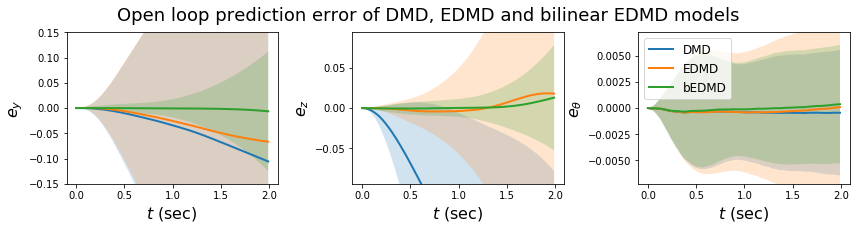

In [13]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 16
y_lim_gain = 1.2

#Plot open loop results:
ylabels = ['$e_{y}$', '$e_z$', '$e_{\\theta}$']
plt.figure(figsize=(figwidth,3))
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(t_eval[:-1], error_dmd_mean[ii,:], linewidth=lw, label='DMD')
    plt.fill_between(t_eval[:-1], error_dmd_mean[ii,:] - error_dmd_std[ii,:], error_dmd_mean[ii,:] + error_dmd_std[ii,:], alpha=0.2)
    plt.plot(t_eval[:-1], error_edmd_mean[ii, :], linewidth=lw, label='EDMD')
    plt.fill_between(t_eval[:-1], error_edmd_mean[ii, :] - error_edmd_std[ii, :],error_edmd_mean[ii, :] + error_edmd_std[ii, :], alpha=0.2)
    plt.plot(t_eval[:-1], error_bedmd_mean[ii, :], linewidth=lw, label='bEDMD')
    plt.fill_between(t_eval[:-1], error_bedmd_mean[ii, :] - error_bedmd_std[ii, :],error_bedmd_mean[ii, :] + error_bedmd_std[ii, :], alpha=0.2)
    ylim = max(max(np.abs(error_bedmd_mean[ii, :] - error_bedmd_std[ii, :])), max(np.abs(error_bedmd_mean[ii, :] + error_bedmd_std[ii, :])))
    plt.ylim([-ylim * y_lim_gain, ylim * y_lim_gain])
    plt.xlabel('$t$ (sec)', fontsize=fs)
    plt.ylabel(ylabels[ii], fontsize=fs)

plt.legend(loc='upper left', fontsize=fs-4)
suptitle = plt.suptitle('Open loop prediction error of DMD, EDMD and bilinear EDMD models', y=1.05, fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()


# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [14]:
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
#QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
QN_mpc = Q_mpc
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

ctrl_offset = np.array([hover_thrust, hover_thrust])

# Design trajectory:
x0_cl = np.array([0., 0., 0., 0., 0., 0.])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.5, 0.5, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xmax = np.array([2, 2, np.pi/3, 1.,1.,1.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = np.zeros((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [15]:
from koopman_core.controllers import MPCController, NonlinearMPCController, BilinearMPCController

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCController(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)
z0_cl = sys_bedmd.basis(x0_cl.reshape((1,-1))).squeeze()
z_init = sys_bedmd.basis(x_init)
controller_bedmd.construct_controller(z_init, u_init)

#### Design controller using full knowledge of nonlinear controller

In [16]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCController(quadrotor_d, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init+hover_thrust)

#### Design trajectories with the contructed MPCs

In [17]:
max_iter = 50

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction() + hover_thrust

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction() + hover_thrust

controller_bedmd.solve_to_convergence(z0_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = sys_bedmd.C@controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T + hover_thrust

/Users/carlaxelfolkestad/OneDrive - California Institute of Technology/Research/Learning to fly/Code/koopman-learning-control/koopman_core/controllers/nonlinear_mpc_controller.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  while (iter == 0 or np.linalg.norm(u_prev-self.cur_u)/np.linalg.norm(u_prev) > eps) and iter < max_iter:


In [18]:

controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init + ctrl_offset.reshape(1,-1), max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [19]:
ol_controller_dmd = OpenLoopController(quadrotor, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = quadrotor.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(quadrotor, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = quadrotor.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[ 1.60396456e-08  3.60611623e-10 -1.96203472e-04  6.41585823e-06
  7.18709094e-08 -3.92406943e-02]
[ 2.56634301e-07  1.39706665e-09 -7.84813633e-04  5.13268547e-05
  1.30889070e-07 -7.84813379e-02]
[ 1.29921077e-06  2.75431940e-09 -1.76582999e-03  1.73228055e-04
  1.20421197e-07 -1.17721933e-01]
[ 4.10614569e-06  3.09603174e-09 -3.13925205e-03  4.10614328e-04
 -1.06710342e-07 -1.56962480e-01]
[ 1.00957257e-05  1.93816202e-05 -4.89732625e-03  8.17181848e-04
  3.87569205e-03 -1.94652360e-01]
[ 2.12026301e-05  9.40098420e-05 -7.02294933e-03  1.44149452e-03
  1.10497307e-02 -2.30472257e-01]
[ 3.97288898e-05  2.39844971e-04 -9.49116241e-03  2.30701993e-03
  1.81169386e-02 -2.63170359e-01]
[ 6.82588361e-05  4.55817900e-04 -1.22712910e-02  3.44764945e-03
  2.50771183e-02 -2.92855356e-01]
[ 1.09699291e-04  7.40856342e-04 -1.53337397e-02  4.89401033e-03
  3.19298314e-02 -3.19634387e-01]
[ 1.67247553e-04  1.09388244e-03 -1.86499768e-02  6.67359029e-03
  3.86744044e-02 -3.43613041e-01]
[ 2.443606

[0.6680501  0.22190543 0.01373732 0.88131611 0.1613968  0.07697761]
[0.6768563  0.22352606 0.01452507 0.8799112  0.16273054 0.08057303]
[0.68564804 0.22516155 0.01535269 0.87842151 0.1643661  0.08495144]
[0.69442443 0.22681484 0.01622786 0.87684236 0.16629252 0.09008115]
[0.70318456 0.22848879 0.01715789 0.87516834 0.16849601 0.09592479]
[0.71192745 0.23018607 0.01814971 0.87339337 0.17095977 0.10243962]
[0.72065206 0.23190919 0.0192098  0.87151076 0.17366395 0.10957774]
[0.72935728 0.23366044 0.02034412 0.86951325 0.17658548 0.11728636]
[0.73804191 0.23544186 0.02155809 0.8673931  0.17969875 0.12550861]
[0.7467047  0.23725523 0.02285655 0.86514216 0.18297541 0.13418381]
[0.75534428 0.23910203 0.02424371 0.86275194 0.18638408 0.14324784]
[0.76395924 0.24098341 0.02572312 0.86021373 0.18989048 0.15263369]
[0.77254803 0.24290015 0.02729765 0.85751868 0.19345765 0.16227216]
[0.78110906 0.24485268 0.02896947 0.85465789 0.19704646 0.17209269]
[0.78964061 0.246841   0.03074006 0.85162249 0.2

  2.46839422e-02 -1.47457491e-01]
[ 1.76556504e-05  8.91468417e-04 -5.46231061e-03  1.15741611e-03
  2.95223643e-02 -1.71712680e-01]
[ 3.23445957e-05  1.21072554e-03 -7.29252718e-03  1.81176315e-03
  3.43288604e-02 -1.94330634e-01]
[ 5.45556155e-05  1.57788907e-03 -9.34096405e-03  2.66556287e-03
  3.91035544e-02 -2.15356739e-01]
[ 8.63921768e-05  1.99264102e-03 -1.15919272e-02  3.74033197e-03
  4.38464326e-02 -2.34835888e-01]
[ 1.30164834e-04  2.45466257e-03 -1.40301690e-02  5.05597913e-03
  4.85573417e-02 -2.52812480e-01]
[ 1.88375386e-04  2.96363265e-03 -1.66408835e-02  6.63085226e-03
  5.32359886e-02 -2.69330422e-01]
[ 2.63701503e-04  3.51922659e-03 -1.94097013e-02  8.48178522e-03
  5.78819442e-02 -2.84433124e-01]
[ 0.00035898  0.00412111 -0.02232268  0.01062414  0.06249465 -0.2981635 ]
[ 0.0004772   0.00476896 -0.02536632  0.01307187  0.06707342 -0.31056398]
[ 0.00062148  0.00546242 -0.02852752  0.01583753  0.07161745 -0.32167647]
[ 0.00079505  0.00620115 -0.03179362  0.01893235  0

[ 0.65609994  0.25072425 -0.06948785  1.24172377  0.31898299  0.14536722]
[ 0.6685512   0.25391582 -0.06805842  1.24850468  0.31933154  0.14051813]
[ 0.68106955  0.25711058 -0.06667786  1.25514275  0.31962272  0.1355939 ]
[ 0.69365359  0.26030796 -0.06534683  1.26164299  0.31985578  0.13061245]
[ 0.70630196  0.26350739 -0.06406581  1.26801043  0.32003     0.12559225]
[ 0.71901336  0.26670825 -0.06283508  1.27425015  0.32014467  0.12055237]
[ 0.73178655  0.26990997 -0.06165476  1.28036726  0.32019911  0.11551243]
[ 0.74462031  0.27311192 -0.06052473  1.28636682  0.32019266  0.11049263]
[ 0.7575135   0.2763135  -0.0594447   1.2922539   0.32012474  0.10551377]
[ 0.77046502  0.27951411 -0.05841414  1.29803371  0.31999822  0.10059885]
[ 0.78347383  0.2827132  -0.05743228  1.30371165  0.31982068  0.0957735 ]
[ 0.79653893  0.28591032 -0.05649808  1.30929322  0.31960349  0.09106553]
[ 0.80965939  0.28910514 -0.05561023  1.31478393  0.31936128  0.0865044 ]
[ 0.82283432  0.2922975  -0.05476711  

[ 0.67457057  0.72951681 -0.00833808  1.0680906   0.58496916  0.05581668]
[ 0.68525514  0.73532476 -0.00782429  1.06881526  0.5766217   0.04694245]
[ 0.69594673  0.74104946 -0.00739601  1.06949803  0.56831899  0.03871284]
[ 0.70664498  0.74669122 -0.00704644  1.07014605  0.56003287  0.03120113]
[ 0.71734956  0.75225007 -0.00676802  1.07076585  0.55173628  0.02448238]
[ 0.72806022  0.75772577 -0.00655245  1.07136329  0.54340393  0.01863333]
[ 0.73877677  0.76311786 -0.00639061  1.0719435   0.53501477  0.013733  ]
[ 0.74949905  0.76842569 -0.0062726   1.07251076  0.52655033  0.00986968]
[ 0.76022695  0.77364822 -0.00618766  1.0730682   0.51795679  0.00711755]
[ 0.77096039  0.77878386 -0.00612442  1.07361791  0.50917104  0.00553076]
[ 0.78169928  0.78383038 -0.00607107  1.07416096  0.50013278  0.00513978]
[ 0.79244358  0.78878499 -0.00601562  1.07469741  0.49078836  0.00594962]
[ 0.8031932   0.79364438 -0.00594618  1.07522629  0.48109096  0.0079397 ]
[ 0.81394807  0.79840485 -0.00585115  

[ 1.67174505  0.57119368  0.01301916  0.17325157  0.18146712 -0.30362927]
[ 1.67347221  0.5729633   0.01015614  0.17222175  0.17245668 -0.26897334]
[ 1.67519018  0.57465403  0.00764909  0.17141141  0.16569038 -0.23243841]
[ 1.67690101  0.57629566  0.00551479  0.17078883  0.16263464 -0.19441988]
[ 1.6786065   0.577922    0.0037668   0.17033678  0.16263359 -0.15517988]
[ 1.68030826  0.57954833  0.0024112   0.17003696  0.16263312 -0.11593988]
[ 1.68200762e+00  5.81174663e-01  1.44799796e-03  1.69850872e-01
  1.62632944e-01 -7.66998824e-02]
[ 1.68370552e+00  5.82800992e-01  8.77199142e-04  1.69740029e-01
  1.62632880e-01 -3.74598819e-02]
[1.68540254e+00 5.84427321e-01 6.98800326e-04 1.69665934e-01
 1.62632851e-01 1.78011861e-03]
[ 1.60393488e-08  1.06014400e-12 -1.96199984e-04  6.41573949e-06
 -3.93772489e-11 -3.92399969e-02]
[ 2.56629575e-07 -3.35633594e-11 -7.84799938e-04  5.13259138e-05
 -1.14161888e-08 -7.84799938e-02]
[ 1.29918711e-06 -4.43828341e-10 -1.76579986e-03  1.73224928e-04
 -

  5.15545306e-01 -5.80129841e-03]
[ 7.33076318e-01  7.57755155e-01  5.82826768e-05  1.00472622e+00
  5.06188036e-01 -6.95258910e-03]
[ 7.43123564e-01  7.62769172e-01 -1.16368051e-05  1.00472415e+00
  4.96615450e-01 -7.03130728e-03]
[ 7.53170821e-01  7.67686415e-01 -7.69797870e-05  1.00472814e+00
  4.86833154e-01 -6.03728909e-03]
[ 7.63218144e-01  7.72504821e-01 -1.27058051e-04  1.00473728e+00
  4.76848091e-01 -3.97836377e-03]
[ 7.73265578e-01  7.77222393e-01 -1.51301614e-04  1.00474974e+00
  4.66666147e-01 -8.70348833e-04]
[ 7.83313141e-01  7.81837172e-01 -1.39338562e-04  1.00476279e+00
  4.56289731e-01  3.26295931e-03]
[ 7.93360823e-01  7.86347197e-01 -8.10746436e-05  1.00477281e+00
  4.45715350e-01  8.38982435e-03]
[8.03408572e-01 7.90750430e-01 3.32278543e-05 1.00477534e+00
 4.34931265e-01 1.44706752e-02]
[8.13456288e-01 7.95044664e-01 2.12872855e-04 1.00476513e+00
 4.23915422e-01 2.14583249e-02]
[8.23503813e-01 7.99227411e-01 4.66656287e-04 1.00473620e+00
 4.12634020e-01 2.92983614

##### Compare performance

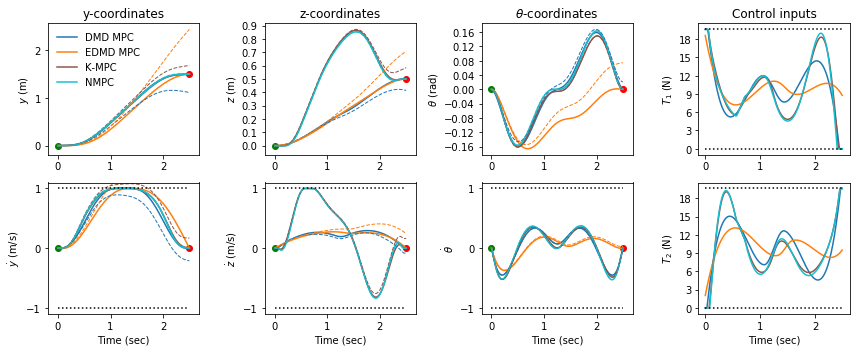

Solution statistics:

                       Normalized cost,    Realized terminal,  # of SQP      Mean comp. time           Total comp.
                    designed trajectory                 error  iterations    per iteration (secs)      time (secs)
----------------  ---------------------  --------------------  ------------  ----------------------  -------------
DMD MPC                          0.9223                0.4555  -             -                            0.228119
EDMD MPC                         0.8562                1.5702  -             -                            3.8059
bEDMD MPC                        0.996                 0.311   23            2.3579                      54.2321
NMPC (benchmark)                 1                     0.0174  8             0.1644                       1.31492


In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:cyan']

plt.figure(figsize=(12,5))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='K-MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[3], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[3], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
#        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
            plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [21]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T+hover_thrust
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T+hover_thrust
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))
    
for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

[ 0.        -0.0004905  0.         0.        -0.0981     0.       ]
[ 0.       -0.001962  0.        0.       -0.1962    0.      ]
[ 0.        -0.0044145  0.         0.        -0.2943     0.       ]
[ 0.       -0.007848  0.        0.       -0.3924    0.      ]
[ 0.        -0.0122625  0.         0.        -0.4905     0.       ]
[ 0.       -0.017658  0.        0.       -0.5886    0.      ]
[ 0.        -0.0240345  0.         0.        -0.6867     0.       ]
[ 0.       -0.031392  0.        0.       -0.7848    0.      ]
[ 0.        -0.0397305  0.         0.        -0.8829     0.       ]
[ 0.      -0.04905  0.       0.      -0.981    0.     ]
[ 0.        -0.0593505  0.         0.        -1.0791     0.       ]
[ 0.       -0.070632  0.        0.       -1.1772    0.      ]
[ 0.        -0.0828945  0.         0.        -1.2753     0.       ]
[ 0.       -0.096138  0.        0.       -1.3734    0.      ]
[ 0.        -0.1103625  0.         0.        -1.4715     0.       ]
[ 0.       -0.125568  0.    

[  0.       -20.814858   0.         0.       -20.2086     0.      ]
[  0.        -21.0174345   0.          0.        -20.3067      0.       ]
[  0.       -21.220992   0.         0.       -20.4048     0.      ]
[  0.        -21.4255305   0.          0.        -20.5029      0.       ]
[  0.      -21.63105   0.        0.      -20.601     0.     ]
[  0.        -21.8375505   0.          0.        -20.6991      0.       ]
[  0.       -22.045032   0.         0.       -20.7972     0.      ]
[  0.        -22.2534945   0.          0.        -20.8953      0.       ]
[  0.       -22.462938   0.         0.       -20.9934     0.      ]
[  0.        -22.6733625   0.          0.        -21.0915      0.       ]
[  0.       -22.884768   0.         0.       -21.1896     0.      ]
[  0.        -23.0971545   0.          0.        -21.2877      0.       ]
[  0.       -23.310522   0.         0.       -21.3858     0.      ]
[  0.        -23.5248705   0.          0.        -21.4839      0.       ]
[  0.     -2

[ 0.12256508  0.083463   -0.13331507  0.53254251  0.20740023 -0.00442928]
[ 0.12795757  0.08554661 -0.13331884  0.54595739  0.20932224  0.00367557]
[ 0.1334842   0.08764939 -0.13324204  0.55936712  0.2112336   0.01168421]
[ 0.13914487  0.08977124 -0.13308567  0.5727637   0.2131354   0.01958912]
[ 0.1449394   0.09191205 -0.13285081  0.58613921  0.21502871  0.02738302]
[ 0.15086756  0.09407177 -0.1325386   0.59948588  0.21691457  0.03505896]
[ 0.156929    0.09625031 -0.13215026  0.61279604  0.21879401  0.04261028]
[ 0.16312333  0.09844761 -0.13168705  0.62606214  0.22066803  0.05003058]
[ 0.16945007  0.10066363 -0.13115033  0.63927679  0.22253759  0.0573138 ]
[ 0.17590867  0.10289833 -0.13054149  0.65243271  0.22440364  0.06445412]
[ 0.1824985   0.10515168 -0.12986199  0.66552276  0.22626707  0.07144607]
[ 0.18921888  0.10742365 -0.12911334  0.67853998  0.22812878  0.07828441]
[ 0.19606903  0.10971423 -0.12829709  0.69147754  0.22998958  0.08496426]
[ 0.20304814  0.11202342 -0.12741487  

[1.383857   0.48742523 0.07628054 1.03458836 0.4293642  0.18500551]
[1.39416472 0.49172377 0.0781218  1.02692411 0.43034124 0.1832466 ]
[1.40439489 0.49603194 0.07994488 1.01907931 0.43129192 0.1813689 ]
[1.41454571 0.5003495  0.08174859 1.01105588 0.43221609 0.17937339]
[1.42461542 0.50467616 0.08353176 1.00285586 0.43311359 0.17726132]
[1.43460225 0.50901166 0.08529324 0.99448141 0.43398433 0.17503426]
[1.44450447 0.51335573 0.08703188 0.98593479 0.4348282  0.17269405]
[1.45432038 0.51770811 0.08874657 0.9772184  0.43564514 0.17024283]
[1.46404829 0.52206853 0.09043619 0.96833472 0.43643508 0.16768304]
[1.47368653 0.5264367  0.0920997  0.95928635 0.43719801 0.16501739]
[1.48323347 0.53081238 0.09373603 0.95007598 0.4379339  0.16224891]
[1.49268752 0.53519527 0.09534418 0.94070641 0.43864278 0.15938089]
[1.50204708 0.53958512 0.09692317 0.93118053 0.43932468 0.15641695]
[1.51131062 0.54398166 0.09847206 0.92150134 0.43997966 0.15336096]
[1.52047661 0.54838461 0.09998995 0.9116719  0.4

[ 0.16864496  0.29184023 -0.16281091  0.77338342  0.99138269  0.14570185]
[ 0.17646088  0.30176485 -0.16128775  0.78977583  0.99354567  0.15893008]
[ 0.18443886  0.31170454 -0.15963508  0.80579249  0.99439713  0.17160404]
[ 0.19257564  0.32164962 -0.15785849  0.82153489  0.99462306  0.18371346]
[ 0.20086875  0.33159578 -0.15596368  0.83705508  0.99461461  0.19524951]
[ 0.20931608  0.34154187 -0.15395641  0.85237925  0.994607    0.2062047 ]
[ 0.21791573  0.35148852 -0.15184252  0.86751631  0.99472875  0.21657283]
[ 0.22666576  0.36143693 -0.14962791  0.88245231  0.99495941  0.22634894]
[ 0.23556406  0.37138794 -0.14731852  0.89716955  0.99524871  0.23552926]
[ 0.24460837  0.38134195 -0.14492032  0.91165296  0.99555777  0.24411113]
[ 0.25379629  0.39129904 -0.1424393   0.92589114  0.9958669   0.25209295]
[ 0.26312533  0.4012592  -0.13988146  0.93987562  0.99617169  0.25947417]
[ 0.27259293  0.41122242 -0.13725282  0.95359984  0.99647672  0.26625519]
[ 0.28219644  0.42118872 -0.13455935  

[ 1.6760187   0.97261615  0.06772771  1.21226057 -0.39002715  0.19326612]
[ 1.68811394  0.96862499  0.06963652  1.20676241 -0.4082055   0.18849632]
[ 1.70015321  0.96445529  0.07149531  1.20106718 -0.42573654  0.18326171]
[ 1.71213454  0.96011371  0.07329947  1.19517388 -0.44258195  0.17756996]
[ 1.72405594  0.95560729  0.07504447  1.1890818  -0.45870378  0.17143013]
[ 1.73591542  0.95094345  0.07672588  1.18279058 -0.47406451  0.16485271]
[ 1.74771098  0.94613     0.07833939  1.1763002  -0.4886271   0.15784958]
[ 1.75944065  0.9411751   0.07988081  1.16961103 -0.50235503  0.15043404]
[ 1.77110242  0.93608727  0.08134609  1.16272384 -0.51521234  0.14262079]
[ 1.78269434  0.9308754   0.08273132  1.15563983 -0.52716368  0.13442592]
[ 1.79421444  0.92554872  0.08403278  1.14836064 -0.53817436  0.12586696]
[ 1.80566077  0.9201168   0.08524693  1.14088841 -0.54821039  0.11696279]
[ 1.81703143  0.91458957  0.08637041  1.13322577 -0.55723853  0.10773371]
[ 1.82832451  0.90897725  0.08740009  

[ 0.07887305  0.1640636  -0.15986306  0.51480087  0.92531331 -0.0678064 ]
[ 0.08411261  0.17339325 -0.16044769  0.53312137  0.94061444 -0.04911938]
[ 0.08953435  0.18286774 -0.16084591  0.5512346   0.95428369 -0.03052522]
[ 0.09513607  0.19247059 -0.16105879  0.56911197  0.96628462 -0.01204959]
[ 0.10091526  0.20218494 -0.16108763  0.58672685  0.97658623  0.00628116]
[ 0.10686918  0.21199369 -0.16093402  0.60405459  0.98516291  0.02443989]
[ 0.11299484  0.22187947 -0.16059983  0.62107254  0.99199424  0.04239859]
[ 0.11928905  0.23182476 -0.1600872   0.63776009  0.99706487  0.06012837]
[ 0.1257484   0.24181189 -0.15939856  0.65409865  1.00036433  0.07759944]
[ 0.13236933  0.25182314 -0.15853665  0.67007164  1.00188693  0.09478118]
[ 0.13914858  0.26184376 -0.15750454  0.68576165  1.00224109  0.11164215]
[ 0.14608389  0.27186611 -0.15630557  0.70128129  1.00223036  0.12815018]
[ 0.1531737   0.2818879  -0.15494346  0.71665843  1.00213203  0.14427273]
[ 0.16041656  0.29190867 -0.15342221  

[ 1.32363489  0.89292195  0.06423402  1.08354359 -0.21348583  0.27989564]
[ 1.33444537  0.89067887  0.0670347   1.07851838 -0.23513172  0.28024084]
[ 1.34520447  0.88822033  0.0698361   1.07326441 -0.25657921  0.28003904]
[ 1.35590986  0.88554852  0.0726327   1.06777769 -0.27778665  0.27928099]
[ 1.3665592   0.88266604  0.0754189   1.06205418 -0.29871136  0.27795863]
[ 1.3771501   0.87957595  0.07818902  1.0560899  -0.31930975  0.27606506]
[ 1.38768013  0.87628172  0.08093731  1.04988087 -0.33953751  0.27359459]
[ 1.39814683  0.8727873   0.083658    1.04342318 -0.35934972  0.27054273]
[ 1.40854768  0.86909706  0.08634525  1.036713   -0.37870101  0.26690623]
[ 1.41888016  0.86521585  0.08899319  1.02974662 -0.39754578  0.26268304]
[ 1.42914166  0.86114894  0.09159597  1.02252047 -0.41583832  0.25787236]
[ 1.43932959  0.8569021   0.0941477   1.01503117 -0.43353302  0.25247467]
[ 1.4494413   0.85248153  0.09664254  1.00727559 -0.45058452  0.24649168]
[ 1.45947409  0.84789388  0.09907463  

[ 0.01136756  0.02519058 -0.10884238  0.1521147   0.37047847 -0.4459068 ]
[ 0.01296089  0.02905657 -0.11322845  0.16664745  0.40270971 -0.43130596]
[ 0.01470259  0.03324637 -0.11746229  0.18178393  0.4352396  -0.41546311]
[ 0.01659851  0.03776222 -0.12153199  0.19748851  0.46792    -0.39847713]
[ 0.01865414  0.04260491 -0.12542661  0.21372245  0.50060601 -0.38044731]
[ 0.02087457  0.04777377 -0.12913622  0.23044433  0.53315662 -0.36147295]
[ 0.02326446  0.05326678 -0.13265185  0.24761046  0.56543535 -0.34165308]
[ 0.02582803  0.05908056 -0.13596554  0.26517527  0.5973107  -0.32108599]
[ 0.02856903  0.06521044 -0.13907032  0.28309179  0.6286565  -0.29986895]
[ 0.03149074  0.07165053 -0.14196015  0.301312    0.65935223 -0.27809783]
[ 0.03459595  0.07839375 -0.14462997  0.31978723  0.68928316 -0.2558667 ]
[ 0.03788697  0.08543191 -0.14707564  0.33846858  0.71834055 -0.23326758]
[ 0.04136562  0.09275575 -0.14929393  0.35730723  0.74642165 -0.21039007]
[ 0.04503322  0.10035504 -0.15128249  

[ 1.6926557   0.60950581  0.01225257  0.18879721  0.22076662 -0.11312615]
[ 1.69453784  0.61171344  0.01131751  0.18764433  0.22075983 -0.07388613]
[ 1.69640883  0.61392101  0.01077485  0.18656393  0.22075387 -0.0346461 ]
[1.69826923 0.61612852 0.01062459 0.18551752 0.22074828 0.00459393]
[ 1.60393561e-08 -3.25632431e-11 -1.96200088e-04  6.41574245e-06
 -6.76405492e-09 -3.92400176e-02]
[ 2.56629692e-07 -1.68308743e-10 -7.84800347e-04  5.13259373e-05
 -2.49159149e-08 -7.84800341e-02]
[ 1.29918770e-06 -7.47256180e-10 -1.76580076e-03  1.73225006e-04
 -1.11013175e-07 -1.17720049e-01]
[ 4.10607369e-06 -3.09041372e-09 -3.13920133e-03  4.10607222e-04
 -4.12248159e-07 -1.56960064e-01]
[ 1.00245888e-05 -1.06326997e-08 -4.90500203e-03  8.01966412e-04
 -1.21176302e-06 -1.96200077e-01]
[ 2.07819181e-05 -9.28394784e-07 -7.06284370e-03  1.38471493e-03
 -1.82550693e-04 -2.35368257e-01]
[ 3.83461280e-05 -2.14870024e-05 -9.60523898e-03  2.16810752e-03
 -3.92950328e-03 -2.73110800e-01]
[ 6.49542442e-05 

[ 0.62566958  0.7165305  -0.01480021  1.06382123  0.63441431  0.10369469]
[ 0.63631417  0.72282485 -0.01380987  1.06508151  0.62445593  0.09437341]
[ 0.64697095  0.72902085 -0.01291068  1.0662618   0.61474324  0.08546465]
[ 0.65763917  0.73512119 -0.0120982   1.06737016  0.60532622  0.0770318 ]
[ 0.66831814  0.74112892 -0.01136735  1.06841376  0.59621891  0.06913681]
[ 0.67900726  0.74704706 -0.01071247  1.06939901  0.58740884  0.061839  ]
[ 0.68970595  0.75287843 -0.01012731  1.07033171  0.57886477  0.055194  ]
[ 0.70041374  0.75862546 -0.00960508  1.07121706  0.57054287  0.0492528 ]
[ 0.71113015  0.76429013 -0.00913851  1.07205968  0.56239155  0.04406095]
[ 0.7218548   0.76987387 -0.00871991  1.07286356  0.55435511  0.03965789]
[ 0.73258731  0.77537752 -0.00834124  1.0736321   0.54637625  0.03607646]
[ 0.74332734  0.78080139 -0.00799415  1.07436799  0.53839781  0.03334243]
[ 0.75407457  0.7861452  -0.00767006  1.07507327  0.5303637   0.03147432]
[ 0.7648287   0.79140812 -0.00736028  

[ 1.65063948  0.56888752  0.05733846  0.21688957  0.12151209 -0.46508532]
[ 1.65277622  0.57018795  0.05270976  0.21054667  0.13857828 -0.4606559 ]
[ 1.65485268  0.57164955  0.04813701  0.20483107  0.15374717 -0.45389369]
[ 1.65687502  0.57325303  0.04364413  0.19972046  0.16695282 -0.44468229]
[ 1.65884916  0.57497851  0.0392562   0.19518872  0.17814575 -0.43290428]
[ 1.66078076  0.5768057   0.03499947  0.19120627  0.1872947  -0.41844126]
[ 1.66267513  0.5787141   0.03090139  0.18774034  0.19438857 -0.40117401]
[ 1.66453727  0.58068322  0.02699061  0.18475547  0.19943829 -0.38098248]
[ 1.66637181  0.5826928   0.02329697  0.18221384  0.20247879 -0.35774592]
[ 1.66818297  0.58472305  0.01985152  0.1800757   0.20357104 -0.33134287]
[ 1.66997459  0.58675492  0.01668655  0.17829973  0.20280411 -0.30165119]
[ 1.67175008  0.58877042  0.01383556  0.1768434   0.20029723 -0.26854809]
[ 1.67351242  0.59075291  0.01133327  0.17566321  0.19620198 -0.23191008]
[ 1.67526393  0.59270777  0.00920751  

[ 0.46247365  0.59789287 -0.0420495   1.0300037   0.80701619  0.26896908]
[ 0.47279132  0.60590081 -0.03940694  1.03349361  0.79457297  0.25954147]
[ 0.48314279  0.61378478 -0.03686048  1.03676438  0.7822209   0.24975015]
[ 0.49352591  0.62154583 -0.03441359  1.03982509  0.76999046  0.23962919]
[ 0.50393863  0.62918531 -0.03206937  1.04268475  0.75790828  0.22921444]
[ 0.51437898  0.63670484 -0.02983058  1.04535238  0.74599713  0.21854359]
[ 0.52484508  0.6441062  -0.02769958  1.04783697  0.7342759   0.2076562 ]
[ 0.53533515  0.65139137 -0.02567833  1.05014755  0.72275965  0.1965938 ]
[ 0.54584749  0.65856246 -0.02376836  1.05229317  0.71145967  0.18539991]
[ 0.5563805   0.66562168 -0.02197076  1.05428289  0.70038351  0.17412007]
[ 0.56693267  0.67257127 -0.02028615  1.05612584  0.68953512  0.16280191]
[ 0.57750257  0.67941352 -0.01871467  1.05783112  0.67891501  0.15149511]
[ 0.58808887  0.68615069 -0.01725593  1.05940788  0.66852037  0.14025146]
[ 0.59869033  0.69278502 -0.01590905  

[ 1.61463652  0.56159852  0.11755186  0.36489398 -0.24625303 -0.36027321]
[ 1.61820929  0.55929726  0.11386269  0.3497405  -0.21399038 -0.37756087]
[ 1.62163313  0.5573175   0.11000534  0.3351107  -0.18195246 -0.39390796]
[ 1.62491346  0.55565621  0.10598971  0.32104089 -0.15029586 -0.40921866]
[ 1.62805603  0.55430879  0.10182664  0.30756412 -0.11917886 -0.42339502]
[ 1.63106694  0.55326904  0.09752798  0.29470975 -0.08876049 -0.43633703]
[ 1.63395254  0.5525292   0.09310658  0.28250323 -0.05919953 -0.44794277]
[ 1.6367194   0.55207989  0.08857633  0.27096568 -0.03065346 -0.45810855]
[ 1.63937432  0.55191019  0.08395214  0.26011373 -0.00327723 -0.46672904]
[ 1.64192419  0.55200766  0.07925001  0.24995927  0.0227779  -0.47369739]
[ 1.64437605  0.55235834  0.07448699  0.24050928  0.04736578 -0.47890542]
[ 1.64673694  0.55294687  0.06968125  0.23176578  0.07034673 -0.48224373]
[ 1.64901392  0.55375651  0.06485202  0.22372576  0.09158905 -0.4836019 ]
[ 1.65121398  0.55476928  0.06001967  

[ 1.22935997  0.85872424  0.06788624  1.02348957 -0.32897939  0.34364123]
[ 1.23957073  0.85529301  0.07133276  1.01862234 -0.35726871  0.34566383]
[ 1.24973151  0.85158032  0.07479601  1.01349174 -0.38527238  0.34698563]
[ 1.25983961  0.84758942  0.0782689   1.00808859 -0.41291035  0.34759209]
[ 1.26989228  0.84332438  0.08174421  1.00240327 -0.44010142  0.34746986]
[ 1.27988663  0.83879007  0.08521459  0.99642574 -0.46676358  0.3466068 ]
[ 1.28981969  0.8339922   0.08867258  0.99014559 -0.49281432  0.34499202]
[ 1.29968839  0.82893729  0.09211062  0.98355209 -0.518171    0.34261584]
[ 1.30948953  0.8236327   0.09552105  0.97663426 -0.54275116  0.33946988]
[ 1.31921982  0.8180866   0.09889614  0.96938095 -0.56647293  0.33554708]
[ 1.32887584  0.81230798  0.10222808  0.96178092 -0.58925531  0.33084169]
[ 1.33845406  0.80630663  0.10550904  0.95382294 -0.61101857  0.32534936]
[ 1.34795087  0.80009314  0.10873112  0.94549593 -0.6316846   0.31906714]
[ 1.3573625   0.79367886  0.11188642  

[ 0.04246044  0.08544332 -0.15283366  0.37041228  0.74927618 -0.20586038]
[ 0.04626265  0.09307955 -0.15477045  0.39007024  0.77796318 -0.18149703]
[ 0.05026156  0.10099577 -0.15646331  0.40974823  0.80527561 -0.15707631]
[ 0.05445713  0.10917775 -0.15791211  0.42939465  0.83111522 -0.13268392]
[ 0.05884878  0.1176103  -0.15911754  0.44895981  0.85539176 -0.10840124]
[ 0.06343546  0.12627739 -0.16008107  0.46839619  0.8780229  -0.08430515]
[ 0.06821566  0.13516219 -0.16080494  0.48765867  0.89893408 -0.06046789]
[ 0.07318743  0.14424716 -0.16129206  0.50670475  0.91805835 -0.0369569 ]
[ 0.0783484   0.15351414 -0.16154602  0.52549468  0.93533623 -0.01383478]
[ 0.08369583  0.1629444  -0.16157099  0.54399163  0.95071558  0.00884074]
[ 0.08922662  0.17251873 -0.1613717   0.56216176  0.96415144  0.03101676]
[ 0.09493734  0.18221751 -0.16095339  0.57997434  0.97560591  0.05264519]
[ 0.10082427  0.19202077 -0.16032175  0.59740172  0.98504804  0.07368261]
[ 0.10688345  0.20190827 -0.15948289  

[ 1.17822042  0.8674536   0.05085665  1.0447774  -0.18910821  0.32514223]
[ 1.18865004  0.86542111  0.05413438  1.04110929 -0.21739186  0.3304028 ]
[ 1.19904185  0.86310538  0.05746162  1.03721439 -0.2457559   0.33504596]
[ 1.20939355  0.86050596  0.06083211  1.03308581 -0.27413107  0.33905174]
[ 1.21970276  0.85762309  0.06423938  1.02871621 -0.30244551  0.34240135]
[ 1.22996703  0.85445775  0.06767677  1.02409785 -0.330625    0.34507713]
[ 1.24018383  0.85101167  0.07113747  1.01922249 -0.35859329  0.34706264]
[ 1.25035056  0.84728736  0.07461449  1.01408147 -0.38627236  0.34834255]
[ 1.2604645   0.8432881   0.07810072  1.00866565 -0.41358273  0.34890275]
[ 1.27052286  0.83901798  0.08158888  1.00296546 -0.44044382  0.34873027]
[ 1.28052275  0.83448191  0.0850716   0.99697094 -0.46677421  0.34781338]
[ 1.29046117  0.82968559  0.08854138  0.99067177 -0.49249201  0.34614153]
[ 1.30033503  0.82463558  0.09199061  0.9840573  -0.51751523  0.34370542]
[ 1.31014111  0.81933921  0.09541162  

[ 0.02370386  0.04593778 -0.13624134  0.25587209  0.55353748 -0.34589074]
[ 0.02635419  0.05164531 -0.13959021  0.27426812  0.58795879 -0.32388326]
[ 0.02919026  0.05769401 -0.14271576  0.29301526  0.62177204 -0.3012276 ]
[ 0.03221531  0.06407707 -0.14561204  0.3120582   0.65483013 -0.27802893]
[ 0.03543202  0.07078623 -0.14827414  0.33134115  0.68699383 -0.25439011]
[ 0.0388425   0.0778119  -0.15069815  0.35080831  0.71813201 -0.23041123]
[ 0.04244833  0.08514321 -0.15288115  0.37040435  0.74812172 -0.20618932]
[ 0.04625053  0.09276809 -0.15482119  0.39007483  0.77684827 -0.18181796]
[ 0.05024955  0.10067338 -0.15651721  0.40976652  0.80420517 -0.15738699]
[ 0.05444538  0.1088449  -0.15796906  0.4294278   0.83009406 -0.1329822 ]
[ 0.05883744  0.11726752 -0.15917739  0.44900893  0.85442461 -0.10868512]
[ 0.0634247   0.12592523 -0.16014368  0.46846234  0.8771144  -0.08457278]
[ 0.06820565  0.13480125 -0.16087013  0.48774286  0.89808875 -0.06071758]
[ 0.07317836  0.14387811 -0.16135966  

[0.99715051 0.86055101 0.00766393 1.0774902  0.22875288 0.16655634]
[1.00792219 0.86274003 0.00938687 1.07682256 0.20905091 0.17803289]
[1.01868653 0.8647286  0.01122421 1.07602241 0.18866213 0.18943403]
[1.02944219 0.86650985 0.01317496 1.0750834  0.16758797 0.20071535]
[1.04018773 0.86807696 0.0152377  1.07399944 0.14583407 0.21183427]
[1.05092169 0.86942319 0.01741063 1.07276467 0.12341034 0.22274995]
[1.06164252 0.8705419  0.01969149 1.07137346 0.10033111 0.23342321]
[1.07234864 0.87142663 0.02207769 1.0698204  0.07661511 0.24381654]
[1.08303839 0.87207114 0.02456624 1.06810024 0.05228556 0.25389402]
[1.09371009 0.87246942 0.02715382 1.06620785 0.02737014 0.26362126]
[1.10436199 0.87261578 0.02983675 1.06413822 0.00190094 0.27296536]
[ 1.11499228  0.87250486  0.03261105  1.06188636 -0.02408556  0.28189489]
[ 1.12559911  0.8721317   0.03547243  1.05944728 -0.05054861  0.2903798 ]
[ 1.13618061  0.87149174  0.03841628  1.05681592 -0.07744324  0.29839143]
[ 1.1467348   0.87058093  0.04

[ 3.83939484e-05 -1.47853114e-05 -9.60791536e-03  2.17595943e-03
 -2.94858601e-03 -2.73503064e-01]
[ 6.49916886e-05 -7.62033313e-05 -1.25263834e-02  3.18819889e-03
 -9.33551088e-03 -3.10190541e-01]
[ 1.03178223e-04 -1.96125539e-04 -1.57972498e-02  4.49968975e-03
 -1.46496463e-02 -3.43982736e-01]
[ 1.56224191e-04 -3.58839380e-04 -1.93904002e-02  6.16630882e-03
 -1.78941204e-02 -3.74647342e-01]
[ 2.27917702e-04 -5.42902334e-04 -2.32748793e-02  8.23524047e-03
 -1.89198106e-02 -4.02248479e-01]
[ 3.22518057e-04 -7.25548586e-04 -2.74203688e-02  1.07535136e-02
 -1.76111803e-02 -4.26849432e-01]
[ 4.44751762e-04 -8.83017998e-04 -3.17971849e-02  1.37675066e-02
 -1.38849011e-02 -4.48513780e-01]
[ 0.0005998  -0.00099087 -0.03637629  0.01732238 -0.00768841 -0.46730638]
[ 0.0007933  -0.00102429 -0.04112929  0.02146144  0.00100163 -0.48329419]
[ 0.00103129 -0.00095836 -0.04602849  0.02622551  0.01218091 -0.4965469 ]
[ 0.00132021 -0.00076833 -0.05104692  0.03165231  0.02581917 -0.50713739]
[ 1.6668638

[ 0.75990845  0.77369748 -0.0063437   1.07299013  0.51974706  0.00851736]
[ 0.77064117  0.77885122 -0.00626595  1.07355339  0.51100108  0.00703321]
[ 0.78137949  0.78391615 -0.00619732  1.0741085   0.50198431  0.00669191]
[ 0.79212331  0.78888936 -0.00612639  1.07465557  0.49265712  0.00749599]
[ 0.80287256  0.79376756 -0.00604175  1.07519372  0.48298381  0.0094301 ]
[ 0.81362715  0.79854713 -0.0059323   1.07572108  0.47293064  0.01246167]
[ 0.82438694  0.80322412 -0.00578728  1.07623491  0.46246558  0.01654236]
[ 0.83515178  0.80779425 -0.00559651  1.07673159  0.45156152  0.02161011]
[ 0.84592149  0.81225308 -0.0053505   1.07720682  0.44020456  0.02759204]
[ 0.85669583  0.81659615 -0.0050405   1.07765571  0.42840962  0.0344083 ]
[ 0.8674745   0.82081928 -0.00465857  1.07807287  0.4162166   0.04197815]
[ 0.87825716  0.82491835 -0.00419754  1.07845196  0.403596    0.05022853]
[ 0.88904339  0.82888892 -0.00365095  1.07878625  0.39051991  0.05908849]
[ 0.8998327   0.83272632 -0.00301306  

[ 4.10607198e-06 -2.50864128e-09 -3.13919984e-03  4.10607054e-04
 -3.83225799e-07 -1.56959992e-01]
[ 1.00245847e-05 -9.72582578e-09 -4.90499976e-03  8.01966089e-04
 -1.17576499e-06 -1.96199991e-01]
[ 2.07869597e-05 -2.92086562e-08 -7.06319966e-03  1.38579484e-03
 -2.93126513e-06 -2.35439989e-01]
[ 3.83965382e-05 -1.44575183e-05 -9.60804588e-03  2.17650751e-03
 -2.88306655e-03 -2.73529256e-01]
[ 6.50030434e-05 -7.49194153e-05 -1.25268962e-02  3.18943893e-03
 -9.20980615e-03 -3.10240808e-01]
[ 1.03200843e-04 -1.93692920e-04 -1.57985391e-02  4.50070288e-03
 -1.45456104e-02 -3.44087780e-01]
[ 1.56256013e-04 -3.55468140e-04 -1.93929915e-02  6.16714452e-03
 -1.78104324e-02 -3.74802689e-01]
[ 2.27957431e-04 -5.38789886e-04 -2.32792540e-02  8.23600283e-03
 -1.88552574e-02 -4.02449812e-01]
[ 3.22565717e-04 -7.20880685e-04 -2.74269660e-02  1.07543617e-02
 -1.75646439e-02 -4.27092594e-01]
[ 4.44809243e-04 -8.77969623e-04 -3.18064029e-02  1.37686546e-02
 -1.38553442e-02 -4.48794779e-01]
[ 0.000599

[ 0.68540277  0.73533756 -0.00785102  1.06901479  0.57726753  0.04737866]
[ 0.69609638  0.74106915 -0.00741792  1.06970042  0.56905233  0.03924181]
[ 0.70679666  0.7467187  -0.00706255  1.0703508   0.56085647  0.03183057]
[ 0.7175033   0.75228622 -0.0067773   1.07097236  0.55264857  0.02521989]
[ 0.72821603  0.75777156 -0.00655374  1.07157098  0.54441973  0.01949147]
[ 0.73893466  0.76317436 -0.00638266  1.0721516   0.53613845  0.01472458]
[ 0.74965902  0.76849381 -0.0062541   1.07271818  0.52775287  0.01098823]
[ 0.76038899  0.77372861 -0.00615747  1.07327374  0.5192069   0.00833766]
[ 0.77112446  0.77887689 -0.00608172  1.07382036  0.51044835  0.00681189]
[ 0.78186536  0.78393629 -0.0060155   1.07435917  0.50143146  0.00643224]
[ 0.79261162  0.78890402 -0.00594733  1.07489029  0.49211624  0.00720158]
[ 0.80336314  0.79377694 -0.0058658   1.07541288  0.48246632  0.00910446]
[ 0.81411984  0.7985515  -0.00575974  1.0759251   0.47244698  0.01210778]
[ 0.82488159  0.80322386 -0.00561839  

  1.62688748e-01 -3.74653931e-02]
[1.68580213e+00 5.84436239e-01 6.82044932e-04 1.70031583e-01
 1.62688722e-01 1.77460745e-03]
[ 1.60393489e-08 -6.24234078e-12 -1.96199989e-04  6.41573956e-06
 -1.49987421e-09 -3.92399979e-02]
[ 2.56629578e-07 -6.27096892e-11 -7.84799958e-04  5.13259144e-05
 -1.43244611e-08 -7.84799958e-02]
[ 1.29918712e-06 -5.09222901e-10 -1.76579991e-03  1.73224930e-04
 -9.51177649e-08 -1.17719994e-01]
[ 4.10607189e-06 -2.66743795e-09 -3.13919983e-03  4.10607044e-04
 -3.91155023e-07 -1.56959992e-01]
[ 1.00245845e-05 -9.97373258e-09 -4.90499974e-03  8.01966070e-04
 -1.18565779e-06 -1.96199990e-01]
[ 2.07869592e-05 -2.95652401e-08 -7.06319963e-03  1.38579481e-03
 -2.94310776e-06 -2.35439988e-01]
[ 3.83930472e-05 -1.48991406e-05 -9.60786938e-03  2.17576922e-03
 -2.97130750e-03 -2.73493963e-01]
[ 6.49877611e-05 -7.66473176e-05 -1.25262052e-02  3.18777180e-03
 -9.37882067e-03 -3.10173203e-01]
[ 1.03172031e-04 -1.96846208e-04 -1.57967648e-02  4.49967612e-03
 -1.46616732e-02

[ 0.684885    0.7352793  -0.00816777  1.06880897  0.57697355  0.0471878 ]
[ 0.6955767   0.74100797 -0.00773635  1.06952316  0.56875982  0.03909732]
[ 0.70627535  0.7466546  -0.0073822   1.07020226  0.56056732  0.03173297]
[ 0.71698065  0.75221928 -0.00709768  1.07085265  0.55236749  0.02516975]
[ 0.72769233  0.75770184 -0.0068744   1.07148013  0.54414613  0.01948773]
[ 0.73841019  0.76310194 -0.00670312  1.07208961  0.53587391  0.01476701]
[ 0.74913407  0.76841881 -0.0065739   1.07268498  0.5274984   0.01107751]
[ 0.75986385  0.77365111 -0.00647614  1.07326919  0.51896171  0.00847527]
[ 0.77059942  0.77879696 -0.00639876  1.07384426  0.51020948  0.00699976]
[ 0.7813407   0.78385398 -0.0063304   1.07441123  0.50119395  0.00667237]
[ 0.79208762  0.78881932 -0.00625956  1.07497017  0.49187354  0.00749561]
[ 0.80284007  0.79368974 -0.00617482  1.07552015  0.48221081  0.00945321]
[ 0.81359798  0.79846165 -0.006065    1.0760593   0.47217084  0.01251092]
[ 0.82436121  0.80313111 -0.00591935  

[ 1.64459178  0.54868916  0.07399957  0.23776683  0.07317702 -0.48072083]
[ 1.64692591  0.54953084  0.06917672  0.22915488  0.0951657  -0.48385005]
[ 1.64917746  0.55058306  0.06433253  0.22125133  0.11528504 -0.48498724]
[ 1.65135348  0.55182653  0.05948748  0.21404649  0.13341386 -0.48402344]
[ 1.65346088  0.55324079  0.05466311  0.20752575  0.1494431  -0.48084939]
[ 1.65550641  0.55480436  0.04988209  0.20166983  0.16327752 -0.47535561]
[ 1.65749661  0.55649492  0.04516815  0.19645502  0.17483751 -0.46743264]
[ 1.65943774  0.55828939  0.04054613  0.19185357  0.18406085 -0.45697116]
[ 1.66133578  0.56016421  0.03604196  0.18783403  0.19090456 -0.44386214]
[ 1.66319639  0.56209545  0.03168267  0.18436175  0.19534678 -0.42799703]
[ 1.66502484  0.56405912  0.02749634  0.1813993   0.19738864 -0.4092678 ]
[ 1.66682605  0.56603133  0.02351217  0.17890704  0.19705616 -0.3875671 ]
[ 1.66860451  0.56798862  0.01976039  0.17684359  0.19440216 -0.36278831]
[ 1.67036428  0.56990816  0.01627232  

[ 1.38601791  0.76811776  0.12088095  0.90811694 -0.69702458  0.28648834]
[ 1.39504745  0.7610787   0.12369424  0.89775169 -0.7107923   0.27617026]
[ 1.40397121  0.7539095   0.12640048  0.88696053 -0.7230524   0.26507667]
[ 1.41278489  0.74662552  0.12899194  0.87573745 -0.73374854  0.25321628]
[ 1.42148415  0.73924266  0.13146102  0.86407778 -0.7428287   0.24059961]
[ 1.4300646   0.73177731  0.13380021  0.85197836 -0.75024552  0.2272391 ]
[ 1.43852185  0.72424632  0.13600216  0.83943772 -0.7559566   0.21314915]
[ 1.44685148  0.71666694  0.13805963  0.82645622 -0.75992479  0.19834616]
[ 1.4550491   0.70905675  0.13996561  0.81303622 -0.76211841  0.18284865]
[ 1.46311033  0.70143362  0.14171324  0.79918219 -0.76251161  0.16667729]
[ 1.47103088  0.69381565  0.1432959   0.78490091 -0.76108452  0.14985495]
[ 1.47880651  0.68622113  0.14470721  0.77020153 -0.75782356  0.13240681]
[ 1.4864331   0.67866842  0.14594104  0.75509574 -0.75272163  0.11436037]
[ 1.49390666  0.67117593  0.14699157  

[ 0.11952895  0.22124722 -0.15735544  0.64766728  1.0009487   0.1328624 ]
[ 0.12608429  0.23126345 -0.15593496  0.66337634  1.00230156  0.15123242]
[ 0.1327948   0.2412858  -0.15433451  0.67869941  1.00217117  0.16885794]
[ 0.1396577   0.25130683 -0.15256162  0.69385303  1.00203979  0.18571902]
[ 0.14667123  0.26132654 -0.15062404  0.7088205   1.00190819  0.20179844]
[ 0.15383343  0.27134495 -0.14852964  0.72358595  1.00177727  0.21708169]
[ 0.16114222  0.28136204 -0.14628644  0.73813427  1.00164745  0.23155685]
[ 0.16859534  0.29137786 -0.14390259  0.75245145  1.00152109  0.2452144 ]
[ 0.17619042  0.30139242 -0.14138628  0.76652394  1.00139792  0.25804705]
[ 0.18392495  0.31140577 -0.1387458   0.78033892  1.00127691  0.27004962]
[ 0.1917963   0.32141792 -0.13598945  0.79388494  1.00116057  0.28121886]
[ 0.19980171  0.33142893 -0.13312559  0.80715093  1.00104822  0.29155331]
[ 0.20793834  0.34143885 -0.13016256  0.82012684  1.00094035  0.30105319]
[ 0.21620324  0.3514477  -0.12710869  

[ 1.32015342  0.81247886  0.09882909  0.96961148 -0.5641167   0.33662507]
[ 1.32981158  0.8067257   0.10217138  0.96197777 -0.58651846  0.33183257]
[ 1.3393916   0.80075363  0.1054618   0.95398414 -0.60790116  0.32625063]
[ 1.34888983  0.79457321  0.10869243  0.94561965 -0.62818734  0.31987672]
[ 1.3583025   0.78819578  0.11185537  0.93687362 -0.64730153  0.31270975]
[ 1.36762576  0.78163345  0.11494267  0.92773578 -0.66517065  0.30475013]
[ 1.37685562  0.774899    0.11794642  0.9181964  -0.68172427  0.29599982]
[ 1.38598804  0.76800592  0.12085873  0.90824644 -0.69689503  0.28646239]
[ 1.39501886  0.76096838  0.12367175  0.89787772 -0.71061895  0.27614305]
[ 1.40394385  0.75380113  0.12637771  0.88708309 -0.72283574  0.26504873]
[ 1.41275874  0.74651953  0.1289689   0.87585656 -0.73348915  0.25318814]
[ 1.42145918  0.73913947  0.1314377   0.86419348 -0.74252728  0.24057181]
[ 1.43004077  0.73167734  0.13377662  0.85209072 -0.74990286  0.22721219]
[ 1.43849913  0.72414998  0.1359783   

[ 0.08916888  0.17194734 -0.16137973  0.56205719  0.96329781  0.0306889 ]
[ 0.09487866  0.18163823 -0.16096463  0.5798919   0.97488178  0.05233066]
[ 0.10076489  0.19143493 -0.16033606  0.59734273  0.98445985  0.07338234]
[ 0.1068236   0.20131726 -0.15950013  0.61438507  0.99200759  0.09380478]
[ 0.1130506   0.21126482 -0.15846329  0.63099745  0.99750725  0.11356325]
[ 0.1194415   0.22125707 -0.15723234  0.64716149  1.00094761  0.1326272 ]
[ 0.12599174  0.23127341 -0.15581435  0.66286182  1.00232388  0.15097012]
[ 0.13269704  0.24129597 -0.15421665  0.67817256  1.00219114  0.16856908]
[ 0.13955462  0.2513172  -0.15244679  0.69331454  1.00205999  0.18540421]
[ 0.1465627   0.26133712 -0.15051247  0.70827084  1.0019296   0.2014583 ]
[ 0.15371936  0.27135575 -0.1484216   0.72302575  1.00180172  0.2167169 ]
[ 0.16102249  0.28137311 -0.14618217  0.73756389  1.00167498  0.2311681 ]
[ 0.16846986  0.29138921 -0.14380232  0.75187109  1.00155032  0.24480243]
[ 0.17605909  0.30140407 -0.14129025  

[ 1.32942025  0.80655644  0.10217791  0.96222202 -0.58589628  0.33212321]
[ 1.33900269  0.80059078  0.10547117  0.95422383 -0.60724107  0.32652814]
[ 1.3485033   0.79441715  0.10870451  0.94585449 -0.62748996  0.32014129]
[ 1.35791829  0.78804688  0.11187003  0.93710334 -0.64656759  0.31296162]
[ 1.36724382  0.78149206  0.11495978  0.92796013 -0.66440097  0.30498957]
[ 1.3764759   0.77476548  0.11796587  0.91841517 -0.68091982  0.29622712]
[ 1.38561047  0.76788062  0.12088039  0.90845943 -0.69605688  0.28667788]
[ 1.39464339  0.76085162  0.12369552  0.89808478 -0.70974828  0.27634708]
[ 1.40357043  0.75369324  0.12640346  0.88728406 -0.72193385  0.26524167]
[ 1.4123873   0.7464208   0.12899652  0.87605132 -0.73255743  0.25337041]
[ 1.42108964  0.73905021  0.13146709  0.86438195 -0.74156721  0.24074383]
[ 1.4296731   0.73159781  0.13380768  0.85227283 -0.74891605  0.2273744 ]
[ 1.43813324  0.72408045  0.13601094  0.83972255 -0.75456171  0.21327653]
[ 1.44646567  0.71651532  0.13806966  

[ 0.08921835  0.17201292 -0.16149064  0.56239062  0.96335418  0.03072043]
[ 0.09493152  0.18170432 -0.16107511  0.58023589  0.97492637  0.05238562]
[ 0.10082124  0.1915014  -0.16044588  0.59769684  0.98449182  0.07346081]
[ 0.10688354  0.20138398 -0.15960904  0.61474886  0.99202604  0.09390681]
[ 0.11311423  0.21133165 -0.15857106  0.63137044  0.99751125  0.11368881]
[ 0.1195089   0.22132387 -0.15733874  0.64754317  1.00093621  0.13277625]
[ 0.12606299  0.23134002 -0.15591914  0.66325168  1.00229608  0.15114251]
[ 0.13277224  0.2413623  -0.15431961  0.6785732   1.00216561  0.16876466]
[ 0.13963388  0.25138328 -0.15254767  0.69372533  1.00203396  0.18562275]
[ 0.14664612  0.26140294 -0.15061106  0.70869164  1.00190364  0.20169954]
[ 0.15380703  0.2714213  -0.14851766  0.723456    1.00177377  0.21698052]
[ 0.16111451  0.28143837 -0.14627549  0.7380034   1.00164547  0.23145372]
[ 0.16856632  0.29145417 -0.14389267  0.75231947  1.00151869  0.24510961]
[ 0.17616008  0.3014687  -0.14137742  

[ 1.30069419  0.82320974  0.09201828  0.98425379 -0.51620029  0.34418238]
[ 1.31050221  0.81792675  0.09544392  0.9773067  -0.54040238  0.34094661]
[ 1.32023906  0.81240603  0.09883331  0.97002172 -0.56374529  0.33693019]
[ 1.32990132  0.80665658  0.1021786   0.96238772 -0.58614861  0.33212782]
[ 1.33948544  0.80068819  0.10547192  0.95439362 -0.60753322  0.32653559]
[ 1.34898776  0.79451144  0.10870535  0.94602847 -0.62782165  0.32015097]
[ 1.35840452  0.78813766  0.11187097  0.93728159 -0.64693845  0.31297291]
[ 1.36773184  0.78157894  0.11496084  0.92814271 -0.66481052  0.30500184]
[ 1.37696577  0.77484808  0.11796705  0.91860211 -0.68136747  0.29623976]
[ 1.38610224  0.76795855  0.1208817   0.90865076 -0.69654195  0.28669025]
[ 1.39513709  0.76092452  0.12369694  0.89828049 -0.71026999  0.27635856]
[ 1.40406611  0.75376074  0.126405    0.88748414 -0.72249133  0.26525166]
[ 1.412885    0.74648255  0.12899814  0.87625574 -0.73314976  0.25337827]
[ 1.42158941  0.73910586  0.13146878  

[ 0.07312603  0.14377758 -0.16128867  0.50647024  0.91683758 -0.03747951]
[ 0.07828474  0.15303287 -0.16154786  0.52527702  0.9342195  -0.01435861]
[ 0.08363009  0.16245252 -0.16157806  0.54379287  0.94971164  0.008318  ]
[ 0.08915899  0.17201742 -0.16138399  0.56198389  0.96326886  0.03049719]
[ 0.09486804  0.18170802 -0.16097085  0.57981923  0.97485306  0.05213062]
[ 0.10075355  0.19150445 -0.16034432  0.59727116  0.98443303  0.0731746 ]
[ 0.10681156  0.20138652 -0.1595105   0.61431509  0.99198437  0.09359003]
[ 0.11303787  0.21133387 -0.15847584  0.63092954  0.99748931  0.11334217]
[ 0.1194281   0.22132599 -0.15724712  0.64709611  1.00093664  0.1324005 ]
[ 0.1259777   0.23134226 -0.15583143  0.66279942  1.00232154  0.15073848]
[ 0.13268238  0.24136479 -0.15423607  0.67811196  1.00218858  0.16833322]
[ 0.13953937  0.251386   -0.15246858  0.69325596  1.00205715  0.18516484]
[ 0.14654688  0.26140589 -0.15053667  0.70821437  1.00192547  0.20121612]
[ 0.15370298  0.27142446 -0.14844823  

[ 1.28073865  0.83273924  0.08508316  0.9976339  -0.46504595  0.348517  ]
[ 1.29068366  0.82796062  0.08855978  0.99132647 -0.49068153  0.34680701]
[ 1.30056402  0.82292913  0.09201547  0.98470285 -0.5156213   0.34433129]
[ 1.3103765   0.81765212  0.09544254  0.97775215 -0.53978338  0.34108195]
[ 1.32011779  0.81213779  0.09883321  0.97046335 -0.56308646  0.3370524 ]
[ 1.32978445  0.80639513  0.10217966  0.96282533 -0.58545023  0.33223738]
[ 1.33937292  0.80043392  0.10547401  0.95482702 -0.60679562  0.326633  ]
[ 1.34887955  0.79426474  0.10870836  0.94645749 -0.62704526  0.32023676]
[ 1.35830058  0.78789892  0.11187478  0.9377061  -0.64612379  0.31304764]
[ 1.36763213  0.78134853  0.11496535  0.92856259 -0.66395817  0.3050661 ]
[ 1.37687023  0.77462638  0.11797215  0.91901726 -0.68047811  0.29629415]
[ 1.38601082  0.76774593  0.1208873   0.90906111 -0.69561634  0.28673541]
[ 1.39504976  0.76072133  0.12370295  0.89868599 -0.70930896  0.27639515]
[ 1.4039828   0.75356733  0.12641133  

[ 0.07833351  0.15303492 -0.16165515  0.52564098  0.93428607 -0.01419738]
[ 0.08368256  0.16245522 -0.16168357  0.54416862  0.94977436  0.00851337]
[ 0.08921527  0.17202072 -0.16148737  0.56237071  0.96332606  0.03072661]
[ 0.09492825  0.18171186 -0.16107177  0.58021637  0.97490298  0.05239393]
[ 0.10081777  0.19150874 -0.16044244  0.59767782  0.98447384  0.07347157]
[ 0.10687989  0.20139116 -0.15960548  0.61473045  0.99201417  0.09392034]
[ 0.11311039  0.21133875 -0.15856735  0.63135272  0.99750613  0.11370544]
[ 0.11950489  0.22133096 -0.15733484  0.64752623  1.00093846  0.13279626]
[ 0.12605882  0.23134716 -0.15591503  0.66323559  1.00230628  0.1511662 ]
[ 0.13276791  0.24136956 -0.15431524  0.67855696  1.00217759  0.16879231]
[ 0.13962939  0.25139066 -0.152543    0.69370878  1.00204684  0.18565461]
[ 0.14664146  0.26141045 -0.15060605  0.70867452  1.00191595  0.20173587]
[ 0.1538022   0.27142893 -0.14851226  0.72343817  1.00178479  0.21702153]
[ 0.16110949  0.2814461  -0.14626966  

[ 1.29053558  0.82812088  0.08862937  0.99029279 -0.49104726  0.34657343]
[ 1.30040559  0.82308553  0.09208277  0.98366763 -0.51602577  0.3441081 ]
[ 1.31020772  0.81780429  0.09550766  0.97671562 -0.54022637  0.34086868]
[ 1.31993864  0.81228534  0.09889624  0.9694257  -0.56356766  0.33684855]
[ 1.32959491  0.80653768  0.1022407   0.96178675 -0.58596916  0.33204243]
[ 1.33917299  0.8005711   0.10553314  0.95378765 -0.60735174  0.32644641]
[ 1.34866923  0.79439617  0.10876567  0.94541747 -0.62763789  0.32005799]
[ 1.35807985  0.78802424  0.11193034  0.93666552 -0.64675214  0.31287611]
[ 1.36740099  0.7814674   0.11501922  0.92752153 -0.66462137  0.30490123]
[ 1.37662868  0.77473844  0.11802441  0.91797578 -0.68117518  0.29613535]
[ 1.38575886  0.76785086  0.12093799  0.90801924 -0.69634621  0.28658207]
[ 1.39478737  0.7608188   0.12375214  0.89764373 -0.71007048  0.27624664]
[ 1.40371     0.75365703  0.12645905  0.8868421  -0.72228774  0.26513605]
[ 1.41252244  0.74638091  0.12905103  

[ 0.07827257  0.15300642 -0.16152395  0.52519587  0.93415454 -0.01438669]
[ 0.0836171   0.16242546 -0.16155446  0.5437099   0.94965254  0.0082846 ]
[ 0.08914516  0.1719898  -0.16136074  0.56189929  0.96321625  0.03045863]
[ 0.09485336  0.18167991 -0.16094801  0.57973319  0.97480758  0.05208705]
[ 0.100738    0.19147592 -0.16032195  0.59718389  0.98439533  0.0731262 ]
[ 0.10679513  0.20135766 -0.15948863  0.61422678  0.99195507  0.09353695]
[ 0.11302055  0.21130477 -0.15845452  0.63084038  0.99746904  0.11328459]
[ 0.11940989  0.22129672 -0.15722641  0.64700629  1.00092601  0.13233857]
[ 0.12595858  0.23131294 -0.15581135  0.66270914  1.00232116  0.15067238]
[ 0.13266236  0.24133547 -0.15421668  0.67801967  1.00218799  0.16826311]
[ 0.13951841  0.25135666 -0.15244991  0.69316166  1.00205588  0.18509088]
[ 0.14652497  0.26137654 -0.15051876  0.70811828  1.0019245   0.20113849]
[ 0.1536801   0.27139511 -0.14843111  0.7228737   1.00179479  0.21639147]
[ 0.16098171  0.2814124  -0.14619496  

[ 1.28066152  0.83259937  0.0850708   0.99769618 -0.46523598  0.34860944]
[ 1.29060715  0.82781892  0.08854833  0.99138833 -0.49085673  0.34689734]
[ 1.30048812  0.82278575  0.09200491  0.98476411 -0.51578098  0.34441943]
[ 1.31030122  0.81750723  0.09543285  0.97781265 -0.53992688  0.34116783]
[ 1.32004311  0.81199155  0.09882437  0.97052291 -0.56321319  0.33713598]
[ 1.32971035  0.80624771  0.10217164  0.96288378 -0.58555959  0.33231862]
[ 1.3392994   0.8002855   0.10546679  0.9548842  -0.6068871   0.32671186]
[ 1.3488066   0.79411549  0.10870192  0.94651324 -0.62711837  0.32031325]
[ 1.35822817  0.78774904  0.11186909  0.93776025 -0.64617808  0.31312175]
[ 1.36756026  0.7811982   0.11496039  0.92861498 -0.66399326  0.30513784]
[ 1.37679888  0.77447579  0.1179679   0.91906774 -0.68049365  0.29636355]
[ 1.38593996  0.76759529  0.12088373  0.90910954 -0.69561202  0.2868025 ]
[ 1.39497937  0.76057083  0.12370004  0.89873222 -0.70928454  0.27645996]
[ 1.40391287  0.75341718  0.12640906  

[ 0.09494591  0.18168428 -0.16112668  0.58036174  0.97486029  0.05231666]
[ 0.10083692  0.19148076 -0.16049809  0.59783029  0.98443722  0.07340182]
[ 0.1069006   0.20136286 -0.15966179  0.61488999  0.99198379  0.09385828]
[ 0.11313274  0.21131017 -0.15862424  0.63151931  0.99748217  0.11365121]
[ 0.11952894  0.22130217 -0.15739223  0.64769981  1.00092104  0.13274999]
[ 0.12608463  0.23131824 -0.15597284  0.66341609  1.00229553  0.151128  ]
[ 0.13279556  0.24134052 -0.15437339  0.67874308  1.0021655   0.16876224]
[ 0.13965892  0.25136149 -0.15260142  0.69390051  1.00203328  0.18563274]
[ 0.14667294  0.26138114 -0.15066464  0.70887199  1.00190154  0.20172224]
[ 0.15383568  0.27139948 -0.14857095  0.72364154  1.00177058  0.21701617]
[ 0.16114504  0.28141651 -0.14632836  0.73819406  1.00164095  0.23150254]
[ 0.16859878  0.29143225 -0.14394498  0.75251527  1.00151331  0.24517176]
[ 0.17619452  0.30144673 -0.14142904  0.76659179  1.00138857  0.25801649]
[ 0.18392975  0.31145998 -0.1387888   

[ 1.3204133   0.81224819  0.09884173  0.96997549 -0.56364362  0.33686821]
[ 1.33007509  0.80649977  0.10218639  0.96234077 -0.58604595  0.33206462]
[ 1.33965874  0.80053241  0.10547907  0.95434597 -0.60742937  0.32647105]
[ 1.34916058  0.79435671  0.10871185  0.94598013 -0.62771638  0.32008498]
[ 1.35857685  0.78798399  0.1118768   0.93723257 -0.64683151  0.31290539]
[ 1.36790368  0.78142635  0.11496599  0.92809302 -0.66470166  0.3049327 ]
[ 1.37713711  0.77469658  0.1179715   0.91855177 -0.68125642  0.29616893]
[ 1.38627307  0.76780818  0.12088544  0.90859978 -0.69642843  0.28661767]
[ 1.39530741  0.76077529  0.12369994  0.89822888 -0.71015373  0.27628419]
[ 1.40423591  0.75361269  0.12640724  0.88743193 -0.72237206  0.26517546]
[ 1.41305427  0.74633572  0.12899962  0.87620294 -0.73302721  0.25330023]
[ 1.42175816  0.73896027  0.13146947  0.86453729 -0.74206731  0.24066908]
[ 1.43034318  0.73150273  0.13380929  0.85243186 -0.74944515  0.22729449]
[ 1.43880493  0.72397994  0.13601171  

[ 0.07824656  0.15298646 -0.16145798  0.52500359  0.93408317 -0.01435098]
[ 0.08358913  0.16240482 -0.16148818  0.54351122  0.94958921  0.00830965]
[ 0.08911517  0.17196858 -0.16129427  0.5616945   0.96316214  0.0304731 ]
[ 0.0948213   0.1816582  -0.16088145  0.5795226   0.97476387  0.05209105]
[ 0.1007038   0.19145383 -0.16025539  0.59696782  0.98436321  0.07311986]
[ 0.10675874  0.20133531 -0.15942219  0.61400556  0.99193573  0.09352042]
[ 0.11298193  0.21128229 -0.1583883   0.63061435  0.99746368  0.11325801]
[ 0.11936899  0.22127427 -0.1571605   0.6467758   1.00093582  0.13230214]
[ 0.12591536  0.23129067 -0.15574586  0.66247453  1.00234734  0.15062627]
[ 0.13261675  0.24131345 -0.15415169  0.67777834  1.00221309  0.16820754]
[ 0.13947036  0.2513349  -0.15238552  0.69291388  1.00208127  0.18502607]
[ 0.1464744   0.26135503 -0.15045507  0.70786411  1.00195009  0.20106468]
[ 0.15362696  0.27137387 -0.1483682   0.7226134   1.00182177  0.21630892]
[ 0.16092595  0.28139143 -0.14613292  

[ 1.19870525  0.86105627  0.05740959  1.0376291  -0.24467777  0.33622447]
[ 1.20906107  0.85846818  0.06079172  1.0334972  -0.27294231  0.3402015 ]
[ 1.21937438  0.85559775  0.06421033  1.02912309 -0.30114575  0.34351944]
[ 1.22964269  0.85244597  0.06765873  1.02449901 -0.32921361  0.34616084]
[ 1.23986347  0.84901457  0.07113008  1.01961673 -0.35706943  0.3481094 ]
[ 1.2500341   0.84530606  0.07461738  1.01446758 -0.38463498  0.34935   ]
[ 1.26015185  0.84132375  0.07811347  1.00904242 -0.41183061  0.34986868]
[ 1.27021393  0.83707173  0.08161108  1.00333168 -0.43857559  0.34965268]
[ 1.28021742  0.83255493  0.08510279  0.99732541 -0.46478839  0.34869041]
[ 1.29015933  0.82777907  0.0885811   0.99101327 -0.49038707  0.34697152]
[ 1.30003653  0.82275071  0.09203839  0.98438464 -0.51528958  0.3444869 ]
[ 1.30984581  0.81747721  0.09546697  0.97742865 -0.53941411  0.34122869]
[ 1.31958383  0.81196676  0.09885907  0.97013427 -0.56267948  0.33719033]
[ 1.32924717  0.80622836  0.10220685  

[ 0.03540512  0.07077757 -0.14818257  0.33103758  0.68639635 -0.2544565 ]
[ 0.03881249  0.07779715 -0.15060743  0.35048916  0.71751108 -0.23051479]
[ 0.04241506  0.08512216 -0.15279164  0.37007072  0.74748331 -0.20632881]
[ 0.04621385  0.0927406  -0.15473325  0.38972792  0.77619862 -0.18199192]
[ 0.05020935  0.10063937 -0.15643118  0.40940768  0.80355072 -0.15759379]
[ 0.05440153  0.10880436 -0.15788524  0.42905845  0.82944146 -0.13322006]
[ 0.05878985  0.11722049 -0.15909611  0.44863059  0.85378067 -0.10895214]
[ 0.06337329  0.12587184 -0.1600652   0.46807661  0.87648602 -0.08486698]
[ 0.06815036  0.13474169 -0.16079472  0.48735138  0.89748294 -0.0610369 ]
[ 0.07311913  0.14381264 -0.16128755  0.50641236  0.91670443 -0.03752949]
[ 0.07827726  0.15306662 -0.16154724  0.52521979  0.93409091 -0.01440753]
[ 0.08362204  0.16248502 -0.16157792  0.54373675  0.94959011  0.00827104]
[ 0.08915039  0.17204876 -0.1613843   0.56192933  0.9631569   0.0304531 ]
[ 0.09485891  0.1817383  -0.16097158  

[ 1.15715369  0.86859607  0.04440547  1.05168541 -0.13210864  0.31388541]
[ 1.16765456  0.86713585  0.04757645  1.04845164 -0.15993666  0.32030948]
[ 1.17812202  0.86539629  0.05080877  1.04500282 -0.18797783  0.32615605]
[ 1.18855389  0.86337557  0.05409657  1.04133282 -0.21616839  0.3314029 ]
[ 1.19894792  0.86107253  0.05743373  1.03743514 -0.2444415   0.33602903]
[ 1.20930181  0.8584867   0.06081395  1.03330289 -0.27272745  0.34001461]
[ 1.21961316  0.8556183   0.06423072  1.02892872 -0.30095395  0.34334101]
[ 1.22987953  0.85246831  0.06767738  1.02430489 -0.32904639  0.34599074]
[ 1.24009838  0.84903846  0.07114707  1.01942316 -0.35692815  0.34794747]
[ 1.25026707  0.84533123  0.07463279  1.01427484 -0.38452085  0.34919605]
[ 1.26038291  0.84134991  0.07812738  1.00885079 -0.41174472  0.34972252]
[ 1.27044308  0.83709861  0.08162357  1.00314145 -0.43851889  0.34951406]
[ 1.28044468  0.83258223  0.08511393  0.99713683 -0.46476172  0.3485591 ]
[ 1.2903847   0.82780648  0.08859096  

[ 0.0291793   0.05764657 -0.14270404  0.29289366  0.62114234 -0.30143519]
[ 0.03220311  0.06402324 -0.14560249  0.31193249  0.65418195 -0.27825538]
[ 0.03541855  0.07072585 -0.14826694  0.33121229  0.68633197 -0.25463382]
[ 0.03882773  0.07774486 -0.15069346  0.35067735  0.71746145 -0.23067046]
[ 0.04243225  0.08506944 -0.15287913  0.37027242  0.74744762 -0.20646221]
[ 0.04623312  0.09268759 -0.15482195  0.38994308  0.7761759  -0.18210255]
[ 0.05023084  0.1005862  -0.15652087  0.40963616  0.80353988 -0.15768124]
[ 0.05442537  0.10875113 -0.15797569  0.42930008  0.82944128 -0.13328404]
[ 0.05881617  0.1171673  -0.15918708  0.44888511  0.85378981 -0.10899245]
[ 0.06340222  0.12581878 -0.16015646  0.46834368  0.87650303 -0.08488352]
[ 0.06818202  0.13468884 -0.16088602  0.48763063  0.89750628 -0.06102967]
[ 0.07315364  0.14376004 -0.16137866  0.50670337  0.91673244 -0.0374986 ]
[ 0.07831474  0.15301432 -0.16163792  0.52552205  0.93412187 -0.01435315]
[ 0.0836626   0.16243304 -0.16166795  

[1.10455469 0.87201641 0.02967595 1.06482697 0.00172497 0.27378474]
[ 1.11519192  0.87190388  0.03245853  1.06258548 -0.0242312   0.28273049]
[ 1.1258058   0.8715294   0.03532832  1.06015605 -0.05066515  0.29122826]
[ 1.13639442  0.87088843  0.03828071  1.05753363 -0.07753172  0.29924951]
[ 1.14695584  0.86997687  0.04131079  1.05471305 -0.10478164  0.306767  ]
[ 1.15748803  0.86879116  0.0444134   1.05168898 -0.13236178  0.31375482]
[ 1.16798894  0.86732828  0.04758312  1.04845586 -0.16021525  0.32018827]
[ 1.17845644  0.8655858   0.05081428  1.04500786 -0.18828161  0.32604395]
[ 1.18888837  0.86356192  0.054101    1.04133882 -0.21649711  0.33129963]
[ 1.19928247  0.86125547  0.05743717  1.03744224 -0.24479488  0.33593429]
[ 1.20963643  0.85866598  0.06081648  1.03331122 -0.27310521  0.33992809]
[ 1.21994788  0.85579369  0.06423243  1.02893842 -0.30135578  0.34326238]
[ 1.23021435  0.85263957  0.06767834  1.02431606 -0.32947196  0.34591966]
[ 1.24043332  0.84920533  0.07114736  1.0194

[ 0.01682773  0.02048293 -0.11617108  0.1734052   0.127561   -0.32589666]
[ 0.01862141  0.02177429 -0.11935173  0.18538456  0.13070466 -0.31023359]
[ 0.02053644  0.02309668 -0.12237282  0.19767272  0.13376844 -0.29398458]
[ 0.02257583  0.02444932 -0.1252288   0.21025288  0.13675344 -0.277211  ]
[ 0.02474241  0.02583142 -0.12791472  0.22310777  0.13966097 -0.25997269]
[ 0.02703883  0.02724222 -0.13042622  0.23621966  0.14249255 -0.24232799]
[ 0.02946759  0.02868096 -0.13275953  0.24957044  0.14524987 -0.2243337 ]
[ 0.03203097  0.03014691 -0.13491142  0.26314173  0.14793483 -0.2060451 ]
[ 0.03473108  0.03163935 -0.13687923  0.27691484  0.15054945 -0.18751593]
[ 0.03756986  0.0331576  -0.1386608   0.2908709   0.15309591 -0.16879843]
[ 0.04054904  0.03470098 -0.14025451  0.3049909   0.15557654 -0.14994329]
[ 0.04367015  0.03626885 -0.14165922  0.3192557   0.15799375 -0.13099971]
[ 0.04693456  0.03786058 -0.1428743   0.33364612  0.16035006 -0.11201533]
[ 0.05034342  0.03947558 -0.14389955  

[0.89226849 0.28757362 0.0636676  0.81841876 0.23997694 0.28431179]
[0.90042141 0.28996609 0.06654079 0.81211881 0.23851475 0.29032551]
[0.90850995 0.29234364 0.06947209 0.80554129 0.23699141 0.29593575]
[0.9165313  0.29470564 0.07245734 0.79868107 0.23540573 0.30111413]
[0.92448262 0.29705147 0.07549208 0.79153349 0.23375653 0.30583378]
[0.932361   0.29938049 0.0785716  0.78409432 0.23204258 0.31006938]
[0.94016352 0.30169203 0.08169093 0.77635981 0.23026269 0.31379709]
[0.94788721 0.30398544 0.08484489 0.76832671 0.22841566 0.31699466]
[0.95552906 0.30626005 0.08802807 0.75999229 0.22650028 0.31964129]
[0.96308605 0.30851515 0.09123487 0.75135438 0.22451539 0.32171777]
[0.97055514 0.31075005 0.09445949 0.74241133 0.22245985 0.32320638]
[0.97793326 0.31296404 0.09769597 0.73316208 0.22033255 0.32409092]
[0.98521736 0.31515639 0.10093821 0.72360616 0.21813243 0.32435674]
[0.99240437 0.31732637 0.10417995 0.7137437  0.21585849 0.32399068]
[0.99949122 0.31947324 0.10741481 0.70357542 0.2

[ 0.01363567  0.01811889 -0.12596742  0.18401904  0.36854058 -0.48283073]
[ 0.01556463  0.02200597 -0.13069657  0.20188331  0.4088611  -0.46299999]
[ 0.01767582  0.02629848 -0.1352208   0.2204589   0.44962773 -0.44184646]
[ 0.01997602  0.03099947 -0.13952757  0.23968149  0.49055601 -0.41950696]
[ 0.02247046  0.03610272 -0.14360827  0.25929872  0.5300814  -0.39663369]
[ 0.02516287  0.04159434 -0.14745762  0.27927121  0.5682295  -0.37323551]
[ 0.02805662  0.04746067 -0.1510704   0.29955981  0.60502457 -0.34932056]
[ 0.03115467  0.0536883  -0.15444149  0.32012568  0.64048987 -0.32489644]
[ 0.0344596   0.06026405 -0.15756582  0.3409303   0.67464817 -0.29997043]
[ 0.03797362  0.06717495 -0.16043842  0.36193555  0.70752199 -0.27454957]
[ 0.04169853  0.07440827 -0.16305437  0.38310378  0.73913404 -0.24864089]
[ 0.04563579  0.08195152 -0.16540883  0.40439784  0.7695074  -0.22225146]
[ 0.04978646  0.08979243 -0.16749703  0.42578114  0.79866588 -0.19538859]
[ 0.05415127  0.09791896 -0.16931428  

[ 0.97291544  0.88814397 -0.01017245  1.09747927  0.43209466  0.05299731]
[ 0.9838941   0.89236194 -0.00956118  1.09824508  0.41149974  0.06925651]
[ 0.9948801   0.89636716 -0.00878501  1.09894464  0.38954472  0.08597731]
[ 1.00587272  0.9001464  -0.00783976  1.09956797  0.36630248  0.10307177]
[ 1.01687115  0.90368732 -0.00672213  1.10010551  0.34188285  0.12045382]
[ 1.0278745   0.90697876 -0.00542966  1.10054782  0.31640399  0.13804019]
[ 1.03888175  0.91001011 -0.00396071  1.10088487  0.28986547  0.15575032]
[ 1.04989181  0.91277076 -0.00231443  1.10110711  0.26226583  0.1735062 ]
[ 1.06090348e+00  9.15250117e-01 -4.90737356e-04  1.10120553e+00
  2.33605281e-01  1.91232265e-01]
[1.07191548 0.91743757 0.0015097  1.1011717  0.20388635 0.2088553 ]
[1.08292645 0.91932258 0.0036855  1.10099779 0.17311481 0.22630433]
[1.09393495 0.92089466 0.00603457 1.10067658 0.14130078 0.24351056]
[1.10493947 0.92214346 0.00855416 1.10020147 0.10845998 0.26040733]
[1.11593846 0.92305884 0.01124085 1.0

[ 2.23423460e-04 -7.99258441e-04 -2.33674168e-02  7.83935339e-03
 -4.05744627e-02 -4.07770398e-01]
[ 3.13056775e-04 -1.24142617e-03 -2.75730926e-02  1.01509651e-02
 -4.78607045e-02 -4.33364753e-01]
[ 4.28150252e-04 -1.74283901e-03 -3.20174022e-02  1.29370148e-02
 -5.24239269e-02 -4.55497171e-01]
[ 0.0005737  -0.00227555 -0.03666633  0.01624749 -0.05412025 -0.47428818]
[ 0.00075519 -0.00281039 -0.04148707  0.02013117 -0.05285155 -0.48986053]
[ 0.0009786  -0.00331744 -0.04644807  0.02463484 -0.04856181 -0.50233904]
[ 0.00125034 -0.00376639 -0.05151902  0.02980238 -0.04123367 -0.5118503 ]
[ 0.00157726 -0.00412696 -0.05667088  0.03567403 -0.03088503 -0.51852243]
[ 0.00196657 -0.00436919 -0.06187592  0.0422856  -0.01756575 -0.52248481]
[ 0.00242584 -0.00446376 -0.06710768  0.04966784 -0.00135454 -0.52386775]
[ 0.0029629  -0.00438227 -0.07234103  0.05784583  0.01764413 -0.5228022 ]
[ 0.0035858  -0.0040975  -0.07755214  0.06683853  0.03930289 -0.51941943]
[ 0.00430276 -0.00358357 -0.08271849 

[ 1.15367893  0.83175037  0.07209539  0.94295182 -0.24154567  0.36122562]
[ 1.16308416  0.82917517  0.07572378  0.93805403 -0.27349662  0.36445065]
[ 1.17243927  0.82627954  0.07938079  0.93292815 -0.30563162  0.36695243]
[ 1.18174194  0.82306215  0.08305912  0.9275656  -0.33785064  0.36871424]
[ 1.19098975  0.81952266  0.0867513   0.92195685 -0.37004986  0.3697204 ]
[ 1.2001802   0.81566182  0.09044968  0.91609143 -0.40212225  0.36995627]
[ 1.20931065  0.81148144  0.0941465   0.90995791 -0.43395802  0.3694083 ]
[ 1.21837836  0.80698444  0.09783387  0.90354395 -0.46544523  0.368064  ]
[ 1.22738047  0.80217489  0.10150375  0.89683633 -0.4964703   0.36591197]
[ 1.23631396  0.79705796  0.10514802  0.889821   -0.52691859  0.36294196]
[ 1.24517569  0.79164002  0.10875845  0.88248322 -0.55667498  0.35914486]
[ 1.25396235  0.78592854  0.11232674  0.87480758 -0.58562444  0.35451277]
[ 1.26267048  0.77993218  0.1158445   0.8667782  -0.61365261  0.34903906]
[ 1.27129647  0.77366071  0.11930328  

[ 0.02106879  0.03264505 -0.13169232  0.23774065  0.48602909 -0.34801628]
[ 0.02353646  0.03769037 -0.13506313  0.25586941  0.52302386 -0.32614684]
[ 0.02618745  0.04310394 -0.138212    0.27440037  0.55968136 -0.30362646]
[ 0.0290255   0.04888148 -0.1411329   0.29327501  0.59581772 -0.28055438]
[ 0.03205375  0.05501689 -0.14382081  0.31243354  0.63125567 -0.25702655]
[ 0.03527472  0.06150234 -0.14627162  0.33181553  0.66582513 -0.23313554]
[ 0.03869036  0.06832832 -0.14848215  0.35136042  0.69936373 -0.20897046]
[ 0.04230199  0.07548375 -0.15045009  0.37100804  0.73171738 -0.18461688]
[ 0.04611034  0.08295607 -0.15217395  0.3906991   0.76274052 -0.16015679]
[ 0.05011555  0.09073128 -0.15365308  0.41037568  0.79229656 -0.13566855]
[ 0.05431721  0.09879408 -0.15488756  0.42998163  0.82025807 -0.11122688]
[ 0.05871433  0.10712792 -0.15587821  0.44946292  0.84650699 -0.08690288]
[ 0.06330541  0.11571514 -0.15662654  0.46876805  0.87093479 -0.06276397]
[ 0.06808844  0.12453703 -0.15713473  

[ 1.26513856  0.78706888  0.11424302  0.87485037 -0.6536266   0.35707084]
[ 1.27384417  0.78041199  0.11778172  0.86622982 -0.67775652  0.35066971]
[ 1.28246157  0.77351966  0.12125204  0.85720556 -0.70071406  0.34339423]
[ 1.29098663  0.76640406  0.12464523  0.84776388 -0.72241204  0.33524399]
[ 1.29941512  0.7590782   0.12795255  0.83789147 -0.74276572  0.32622009]
[ 1.30774267  0.75155593  0.13116528  0.82757553 -0.76169328  0.3163252 ]
[ 1.31596478  0.74385191  0.13427472  0.81680401 -0.77911616  0.30556365]
[ 1.32407683  0.73598156  0.13727225  0.80556579 -0.79495947  0.29394147]
[ 1.33207412  0.72796103  0.14014929  0.79385086 -0.80915244  0.28146647]
[ 1.33995182  0.71980715  0.14289736  0.78165058 -0.82162872  0.26814836]
[ 1.34770505  0.7115374   0.1455081   0.76895785 -0.83232687  0.25399877]
[ 1.35532886  0.70316984  0.14797325  0.75576732 -0.84119062  0.23903142]
[ 1.36281825  0.69472307  0.15028472  0.74207564 -0.84816937  0.22326213]
[ 1.3701682   0.68621615  0.15243457  

[ 0.37505306  0.51347899 -0.05336664  0.95740765  0.88272026  0.33653635]
[ 0.38464942  0.52224174 -0.05003711  0.96181672  0.86983284  0.32937053]
[ 0.39428841  0.53087473 -0.04678242  0.96593589  0.8567674   0.32156798]
[ 0.4039672   0.53937652 -0.04360878  0.96977614  0.8435924   0.31315925]
[ 0.41368304  0.54774634 -0.0405221   0.97334812  0.83037213  0.30417662]
[ 0.4234333   0.55598402 -0.03752795  0.97666213  0.81716642  0.29465403]
[ 0.43321546  0.56409    -0.03463154  0.97972823  0.80403043  0.2846272 ]
[ 0.44302708  0.57206521 -0.03183774  0.98255626  0.79101441  0.27413359]
[ 0.45286583  0.5799111  -0.02915101  0.98515591  0.77816353  0.26321248]
[ 0.46272948  0.5876295  -0.02657542  0.98753675  0.76551775  0.25190494]
[ 0.47261588  0.59522264 -0.02411463  0.98970829  0.75311164  0.2402539 ]
[ 0.48252299  0.60269307 -0.02177184  0.99168004  0.74097437  0.22830415]
[ 0.49244886  0.61004358 -0.0195498   0.99346152  0.72912954  0.21610239]
[ 0.50239163  0.61727721 -0.01745081  

[ 3.84557698e-05 -6.97191115e-06 -9.61104107e-03  2.18903670e-03
 -1.38591730e-03 -2.74128161e-01]
[ 6.52339210e-05 -4.83001540e-05 -1.25375454e-02  3.21176202e-03
 -6.88023067e-03 -3.11172709e-01]
[ 1.03390031e-04 -1.63766164e-04 -1.58268235e-02  4.46812301e-03
 -1.62136606e-02 -3.46682911e-01]
[ 1.55772860e-04 -3.63652098e-04 -1.94533204e-02  6.06317219e-03
 -2.37644910e-02 -3.78616459e-01]
[ 2.26039004e-04 -6.27307439e-04 -2.33811234e-02  8.05086985e-03
 -2.89678790e-02 -4.06944156e-01]
[ 3.18360246e-04 -9.30469314e-04 -2.75747663e-02  1.04800587e-02
 -3.16661945e-02 -4.31784415e-01]
[ 4.37394221e-04 -1.24750250e-03 -3.19999728e-02  1.33990322e-02
 -3.17425954e-02 -4.53256894e-01]
[ 0.00058828 -0.00155179 -0.03662367  0.01685489 -0.02911825 -0.47148248]
[ 0.0007766  -0.00181612 -0.041414    0.02089286 -0.02374962 -0.48658323]
[ 0.00100841 -0.00201297 -0.04634033  0.02555559 -0.01562573 -0.49868225]
[ 0.00129014 -0.00211491 -0.05137325  0.03088243 -0.00476558 -0.5079036 ]
[ 0.0016286

[7.02643728e-01 7.42829797e-01 2.45940782e-04 1.00410132e+00
 5.35689334e-01 8.71362573e-04]
[ 7.12684632e-01  7.48142360e-01  2.38716925e-04  1.00407946e+00
  5.26823415e-01 -2.31613401e-03]
[ 7.22725324e-01  7.53365239e-01  2.04759002e-04  1.00405956e+00
  5.17752388e-01 -4.47545061e-03]
[ 7.32765836e-01  7.58496351e-01  1.54425105e-04  1.00404353e+00
  5.08469877e-01 -5.59132869e-03]
[ 7.42806211e-01  7.63533575e-01  9.81877160e-05  1.00403233e+00
  4.98974883e-01 -5.65614920e-03]
[ 7.52846499e-01  7.68474798e-01  4.65572421e-05  1.00402601e+00
  4.89269717e-01 -4.66994558e-03]
[ 7.62886745e-01  7.73317935e-01  1.00055688e-05  1.00402366e+00
  4.79357817e-01 -2.64038908e-03]
[ 7.72926980e-01  7.78060932e-01 -1.11011074e-06  1.00402350e+00
  4.69241519e-01  4.17253166e-04]
[7.82967213e-01 7.82701739e-01 2.33771228e-05 1.00402282e+00
 4.58919859e-01 4.48019354e-03]
[7.93007422e-01 7.87238270e-01 9.33693177e-05 1.00401807e+00
 4.48386444e-01 9.51824543e-03]
[8.03047546e-01 7.91668340e-

[ 1.29918720e-06 -4.85519602e-10 -1.76580000e-03  1.73224940e-04
 -9.35494318e-08 -1.17720000e-01]
[ 4.10607213e-06 -2.62555094e-09 -3.13920000e-03  4.10607068e-04
 -3.89086619e-07 -1.56960000e-01]
[ 1.00245851e-05 -9.90874080e-09 -4.90500000e-03  8.01966116e-04
 -1.18310526e-06 -1.96200000e-01]
[ 2.07869604e-05 -2.94723942e-08 -7.06320000e-03  1.38579489e-03
 -2.94008949e-06 -2.35440000e-01]
[ 3.84545937e-05 -7.12052409e-06 -9.61098138e-03  2.18878812e-03
 -1.41561175e-03 -2.74116276e-01]
[ 6.52289797e-05 -4.88622157e-05 -1.25373203e-02  3.21124365e-03
 -6.93322581e-03 -3.11151502e-01]
[ 1.03378553e-04 -1.64947758e-04 -1.58263505e-02  4.46732060e-03
 -1.62845718e-02 -3.46654535e-01]
[ 1.55761287e-04 -3.65060528e-04 -1.94523189e-02  6.06400571e-03
 -2.37389477e-02 -3.78539162e-01]
[ 2.26044899e-04 -6.27991044e-04 -2.33791282e-02  8.05357608e-03
 -2.88484582e-02 -4.06822695e-01]
[ 3.18403122e-04 -9.29511237e-04 -2.75713597e-02  1.04847887e-02
 -3.14572797e-02 -4.31623606e-01]
[ 4.374945

  4.78321590e-01 -3.79056134e-03]
[ 7.72830440e-01  7.77872010e-01 -2.36364390e-04  1.00426670e+00
  4.68169262e-01 -6.66424604e-04]
[ 7.82873210e-01  7.82501915e-01 -2.22304882e-04  1.00428713e+00
  4.57811763e-01  3.47832636e-03]
[ 7.92916171e-01  7.87027191e-01 -1.61852564e-04  1.00430432e+00
  4.47243352e-01  8.61213717e-03]
[ 8.02959271e-01  7.91445660e-01 -4.53128162e-05  1.00431380e+00
  4.36450436e-01  1.46958124e-02]
[8.13002404e-01 7.95754961e-01 1.36580089e-04 1.00431034e+00
 4.25409762e-01 2.16827686e-02]
[8.23045414e-01 7.99952446e-01 3.92591124e-04 1.00428794e+00
 4.14087245e-01 2.95194385e-02]
[8.33088079e-01 8.04035071e-01 7.30917699e-04 1.00424000e+00
 4.02437853e-01 3.81458764e-02]
[0.84313011 0.8079993  0.00115913 1.00415933 0.39040716 0.04749662]
[0.85317113 0.81184101 0.00168412 1.00403832 0.3779353  0.05750188]
[0.86321071 0.81555551 0.00231208 1.00386897 0.36496416 0.06808908]
[0.87324832 0.81913757 0.00304845 1.00364304 0.35144894 0.07918482]
[0.88328336 0.82258

[ 0.05833811  0.10667026 -0.1548777   0.44617451  0.84237459 -0.08785123]
[ 0.06289577  0.11521674 -0.15563721  0.46537291  0.86691874 -0.06404959]
[ 0.06764437  0.1239993  -0.15615989  0.48435794  0.88959321 -0.04048638]
[ 0.07258156  0.13299882 -0.15644842  0.50308449  0.91030936 -0.01722036]
[ 0.07770453  0.14219531 -0.15650606  0.52151057  0.92898787  0.00569313]
[ 0.08301008  0.15156804 -0.15633658  0.53959749  0.94555879  0.02820206]
[ 0.08849466  0.16109563 -0.15594428  0.55730997  0.95996139  0.05025769]
[ 0.09415434  0.17075615 -0.15533392  0.57461626  0.97214415  0.07181444]
[ 0.09998494  0.18052718 -0.1545107   0.59148815  0.98206456  0.09282989]
[ 0.10598198  0.19038594 -0.15348023  0.60790102  0.98968904  0.11326464]
[ 0.11214076  0.20030933 -0.15224849  0.62383378  0.99499269  0.13308225]
[ 0.11845639  0.21027407 -0.15082184  0.63926887  0.99795916  0.15224913]
[ 0.12492383  0.22025674 -0.14920692  0.65419195  0.99857918  0.17073449]
[ 0.13153921  0.23024268 -0.1474107   

[ 1.0823476   0.85121524  0.04645425  0.97221749 -0.09136112  0.32230891]
[ 1.09205325  0.8501586   0.0497176   0.96887376 -0.11996844  0.33036094]
[ 1.10172442  0.84881365  0.05305847  0.96532307 -0.14902525  0.33781307]
[ 1.11135903  0.84717618  0.05647073  0.96155984 -0.17847035  0.34463916]
[ 1.12095492  0.84524265  0.059948    0.95757813 -0.20823825  0.35081455]
[ 1.13050987  0.84301017  0.06348365  0.95337155 -0.2382594   0.35631603]
[ 1.1400216   0.84047658  0.06707084  0.94893327 -0.2684605   0.3611218 ]
[ 1.14948775  0.83764047  0.07070251  0.94425587 -0.29876472  0.36521145]
[ 1.15890589  0.8345012   0.0743714   0.9393314  -0.32909208  0.36856592]
[ 1.16827351  0.83105896  0.07807006  0.93415128 -0.3593597   0.3711675 ]
[ 1.17758801  0.82731477  0.0817909   0.92870631 -0.38948219  0.37299978]
[ 1.18684669  0.82327052  0.08552614  0.92298665 -0.41937194  0.37404768]
[ 1.19604675  0.81892898  0.08926786  0.91698184 -0.44893954  0.37429737]
[ 1.20518528  0.81429383  0.09300803  

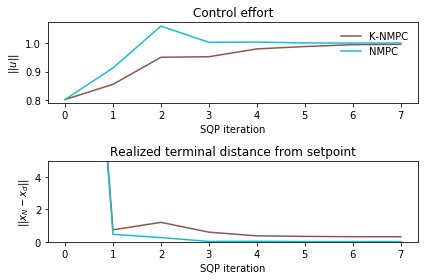

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       8               0.164364              0.108394        1.31492
Koopman bilinear MPC               23               2.35792               1.69155        54.2321


In [22]:
plt.figure(figsize=(6,4))
#plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='K-NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='NMPC')
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2], label=labels[2])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[3], label=labels[3])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [23]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = 5e2*np.diag([1, 1, 1, 2e-1, 2e-1, 2e-1])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 1.
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(300)*dt

# Solver settings closed loop:
polish_osqp = False
max_iter_osqp = 10
linsys_solver_osqp = 'qdldl'
warm_start_osqp = True

controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCController(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)
controller_bedmd_cl.nom_controller.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

controller_nmpc_cl = NonlinearMPCController(quadrotor_d, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

#### Simulate designed trajectories closed-loop

In [24]:
xs_dmd_cl, us_dmd_cl = quadrotor.simulate(x0_cl, controller_dmd_cl, t_eval_cl)
xs_dmd_cl, us_dmd_cl = xs_dmd_cl.T, us_dmd_cl.T

xs_edmd_cl, us_edmd_cl = quadrotor.simulate(x0_cl, controller_edmd_cl, t_eval_cl)
xs_edmd_cl, us_edmd_cl = xs_edmd_cl.T, us_edmd_cl.T

controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = quadrotor.simulate(x0_cl, controller_bedmd_cl, t_eval_cl)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = quadrotor.simulate(x0_cl, controller_nmpc_cl, t_eval_cl)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[ 1.53427726e-08  1.02152014e-04 -1.55329997e-04  6.13710905e-06
  2.04304026e-02 -3.10659995e-02]
[ 2.47169661e-07  4.15490670e-04 -6.18571061e-04  4.94859037e-05
  4.22373252e-02 -6.15822131e-02]
[ 1.26027428e-06  9.58122467e-04 -1.38248795e-03  1.68687311e-04
  6.62890189e-02 -9.12011657e-02]
[ 4.00948276e-06  1.75158397e-03 -2.43846982e-03  4.03015713e-04
  9.24032408e-02 -1.19995207e-01]
[ 9.84491435e-06  2.81593266e-03 -3.77849403e-03  7.92247555e-04
  1.20466410e-01 -1.48009636e-01]
[ 2.05163584e-05  4.17019377e-03 -5.39494921e-03  1.37653082e-03
  1.50385654e-01 -1.75281400e-01]
[ 3.81762174e-05  5.83248752e-03 -7.28058363e-03  2.19622951e-03
  1.82072838e-01 -2.01845483e-01]
[ 6.53813138e-05  7.82010864e-03 -9.42847297e-03  3.29185653e-03
  2.15450992e-01 -2.27732385e-01]
[ 1.05094013e-04  1.01496252e-02 -1.18319803e-02  4.70400150e-03
  2.50451746e-01 -2.52969074e-01]
[ 1.60682756e-04  1.28369616e-02 -1.44847217e-02  6.47328465e-03
  2.87014751e-01 -2.77579208e-01]
[ 2.359222

[0.67876746 0.45696063 0.01263294 0.99134808 0.10353957 0.23066769]
[0.68867452 0.45798419 0.01492545 0.99002866 0.10117169 0.22783397]
[0.6985673  0.4589843  0.01718931 0.98849036 0.0988492  0.22493897]
[0.70844361 0.45996141 0.01942392 0.98673575 0.09657132 0.22198316]
[0.7183013  0.46091595 0.02162867 0.98476746 0.0943373  0.2189672 ]
[0.72813825 0.46184837 0.02380297 0.98258819 0.09214642 0.21589188]
[0.73795237 0.4627591  0.02594622 0.98020069 0.08999797 0.21275812]
[0.74774158 0.46364855 0.02805784 0.97760779 0.08789126 0.20956701]
[0.75750385 0.46451714 0.03013728 0.97481237 0.08582561 0.20631976]
[0.76723716 0.46536528 0.03218397 0.97181739 0.08380037 0.20301768]
[0.77693954 0.46619336 0.03419736 0.96862584 0.0818149  0.19966222]
[0.78660903 0.46700178 0.03617695 0.9652408  0.07986858 0.19625494]
[0.79624372 0.46779093 0.03812221 0.96166537 0.07796081 0.19279747]
[0.80584171 0.4685612  0.04003266 0.95790275 0.07609101 0.18929156]
[0.81540115 0.46931295 0.04190781 0.95395615 0.0

[ 1.47769037  0.500309    0.01906644  0.04782125  0.00554131 -0.05932458]
[ 1.47815934  0.50036409  0.01847809  0.04598079  0.00547556 -0.05834493]
[ 1.47861018  0.50041851  0.01789956  0.04419755  0.0054098  -0.05736174]
[ 1.47904347  0.50047228  0.01733087  0.04247056  0.00534405 -0.05637565]
[ 1.47945978  0.50052539  0.01677205  0.04079885  0.00527834 -0.05538728]
[ 1.47985963  0.50057785  0.01622313  0.03918145  0.00521268 -0.05439724]
[ 1.48024358  0.50062964  0.01568411  0.0376174   0.00514708 -0.05340614]
[ 1.46755723e-08  1.43026801e-04 -1.38989279e-04  5.87022890e-06
  2.86053600e-02 -2.77978559e-02]
[ 2.33714897e-07  5.66967920e-04 -5.58012822e-04  4.67146079e-05
  5.61828608e-02 -5.60068526e-02]
[ 1.18101154e-06  1.26312893e-03 -1.26054831e-03  1.57376951e-04
  8.30493272e-02 -8.45002454e-02]
[ 3.73037297e-06  2.22607089e-03 -2.24877097e-03  3.73015730e-04
  1.09539031e-01 -1.13144287e-01]
[ 9.10979794e-06  3.45336609e-03 -3.52365011e-03  7.29318947e-04
  1.35919932e-01 -1.4

[ 0.52070201  0.43315539 -0.01142473  0.99983756  0.16052083  0.29082433]
[ 0.53070532  0.43474205 -0.00854805  1.00077972  0.15681233  0.28451246]
[ 0.54071671  0.43629184 -0.00573397  1.00145359  0.15314486  0.27830318]
[ 0.55073352  0.43780512 -0.00298148  1.00186477  0.14951187  0.27219468]
[ 5.60753146e-01  4.39282256e-01 -2.89571068e-04  1.00201886e+00
  1.45915335e-01  2.66187119e-01]
[0.57077305 0.44072367 0.00234278 1.00192133 0.14236704 0.26028405]
[0.58079075 0.44212993 0.00491666 1.00157744 0.13888504 0.25449083]
[0.5908038  0.4435018  0.00743318 1.00099219 0.13548957 0.24881313]
[0.6008098  0.44484027 0.00989354 1.00017033 0.13220262 0.2432581 ]
[0.61080643 0.4461465  0.01229898 0.99911637 0.12904365 0.23783173]
[0.62079137 0.44742219 0.01465107 0.99783371 0.12609479 0.23258466]
[0.63076235 0.44866922 0.01695139 0.99632709 0.12330901 0.22748094]
[0.64071718 0.44988885 0.0192012  0.99460188 0.12061732 0.22247949]
[0.65065368 0.45108184 0.02140136 0.99266322 0.11797942 0.217

[ 1.36367536  0.49636876  0.06020484  0.32357464  0.00919585 -0.06993725]
[ 1.36688172  0.49645967  0.0595031   0.3177085   0.00898573 -0.07041199]
[ 1.37002976  0.4965485   0.05879681  0.31191117  0.00878151 -0.07084521]
[ 1.37312017  0.49663532  0.0580864   0.3061831   0.00858302 -0.07123747]
[ 1.37615365  0.49672018  0.05737226  0.30052467  0.0083901  -0.07158937]
[ 1.3791309   0.49680314  0.05665481  0.29493625  0.00820258 -0.07190153]
[ 1.38205261  0.49688425  0.05593443  0.28941816  0.0080203  -0.07217456]
[ 1.3849195   0.49696357  0.05521151  0.28397067  0.00784312 -0.0724091 ]
[ 1.38773226  0.49704113  0.05448643  0.27859402  0.00767087 -0.07260579]
[ 1.39049162  0.497117    0.05375958  0.27328842  0.00750341 -0.0727653 ]
[ 1.39319827  0.49719122  0.05303131  0.26805404  0.0073406  -0.0728883 ]
[ 1.39585293  0.49726383  0.05230199  0.262891    0.00718229 -0.07297545]
[ 1.39845633  0.49733488  0.05157198  0.25779939  0.00702835 -0.07302746]
[ 1.40100916  0.49740441  0.05084161  

[ 0.02399325  0.08085242 -0.12942511  0.19999052  0.15828264 -0.1896475 ]
[ 0.02603678  0.08227835 -0.13118701  0.20873557  0.12690237 -0.16273133]
[ 0.02816594  0.08337247 -0.13268705  0.21711305  0.09191923 -0.13727731]
[ 0.03037855  0.08411089 -0.13393483  0.22542135  0.05576253 -0.11227811]
[ 0.03267296  0.08447557 -0.13493751  0.23347132  0.01717188 -0.08825757]
[ 0.03504631  0.08444077 -0.13570547  0.24120523 -0.02413337 -0.06533594]
[ 0.03749595  0.08398381 -0.13624786  0.24872811 -0.06725757 -0.04314069]
[ 0.04001928  0.08308341 -0.13657321  0.25593994 -0.11282422 -0.02193026]
[ 0.04261308  0.08171489 -0.13669148  0.26282154 -0.16087842 -0.00172358]
[ 0.04527325  0.07984793 -0.13661492  0.26921159 -0.2125142   0.01703631]
[ 0.04799509  0.0774486  -0.13635723  0.27515379 -0.26735253  0.03450226]
[ 0.05077397  0.07448403 -0.13593167  0.28061925 -0.32556023  0.05060824]
[ 0.05360512  0.07092066 -0.13535182  0.28560774 -0.38711245  0.0653629 ]
[ 0.05648362  0.066724   -0.1346316   

[ 0.49376719  0.38593855 -0.04590808  0.44320861  1.22891455 -0.14690875]
[ 0.49822873  0.39837174 -0.04731022  0.4491294   1.25772274 -0.13351996]
[ 0.50275345  0.41115803 -0.04858367  0.45584424  1.29953253 -0.12116966]
[ 0.50734116  0.42426003 -0.04973392  0.46172149  1.32086788 -0.10888033]
[ 0.51199135  0.4376359  -0.05076699  0.4683381   1.35430519 -0.09773405]
[ 0.51670317  0.45124477 -0.05169089  0.47404391  1.36746715 -0.08704661]
[ 0.52147554  0.46504261 -0.05251405  0.48044536  1.39210001 -0.07758423]
[ 0.52630715  0.47898737 -0.05324504  0.48588994  1.39685135 -0.0686144 ]
[ 0.53119617  0.49302828 -0.05388825  0.49192697  1.41132968 -0.0600275 ]
[ 0.53614066  0.50711681 -0.05444587  0.49697808  1.40637687 -0.05149574]
[ 0.54113859  0.52120503 -0.05492041  0.5026162   1.41126667 -0.04341369]
[ 0.54618822  0.53525309 -0.05531515  0.50731635  1.39834469 -0.03553476]
[ 0.55128774  0.54922098 -0.05563088  0.51259167  1.3952329  -0.02760992]
[ 0.55643547  0.5630739  -0.05586628  

[ 1.15192093  0.52281534  0.03455529  0.58047577 -0.16270924  0.09558767]
[ 1.15770894  0.52117775  0.03550301  0.57711148 -0.16480956  0.09395721]
[ 1.16346245  0.51953032  0.03643395  0.57357653 -0.16467694  0.09222957]
[ 1.16918038  0.51787853  0.037347    0.56999285 -0.16568125  0.09038092]
[ 1.17486159  0.51622795  0.03824099  0.56623621 -0.16443509  0.08841802]
[ 1.18050504  0.51458365  0.03911487  0.56243943 -0.16442443  0.08635639]
[ 1.18610972  0.51294904  0.0399678   0.55848209 -0.16249985  0.08423083]
[ 1.19167472  0.51132574  0.04079911  0.55450441 -0.16216014  0.08203013]
[ 1.1971992   0.50971411  0.04160834  0.55037763 -0.16016595  0.07981647]
[ 1.20268235  0.50811439  0.04239518  0.54623838 -0.15977883  0.07755221]
[ 1.20812329  0.50652843  0.0431595   0.54193797 -0.15741443  0.07531212]
[ 1.21352111  0.50496014  0.04390135  0.53761372 -0.15624303  0.07305651]
[ 1.21887479  0.5034157   0.04462067  0.53310941 -0.15264667  0.07080777]
[ 1.2241833   0.50190182  0.0453172   

[ 0.25591556  0.37859711 -0.08322482  0.87209069  1.29633752  0.37051441]
[ 0.26471091  0.39197579 -0.07954879  0.88686737  1.37940848  0.36469073]
[ 0.27365078  0.40618642 -0.07593064  0.90099827  1.46272532  0.35893983]
[ 0.28272919  0.42123697 -0.0723674   0.91457441  1.5473931   0.35370727]
[ 0.29194061  0.43714146 -0.06885368  0.92760315  1.63351201  0.34903697]
[ 0.30127955  0.45391384 -0.06538408  0.94007576  1.72097106  0.3448835 ]
[ 0.31074023  0.47156471 -0.06195457  0.95195533  1.80921073  0.34101812]
[ 0.32031686  0.49010358 -0.0585616   0.96326431  1.89856815  0.33757559]
[ 0.33000377  0.50954241 -0.05520063  0.97401097  1.98920441  0.33461984]
[ 0.33979537  0.52989504 -0.05186628  0.98420359  2.08132686  0.33225021]
[ 0.34968591  0.55117263 -0.04855423  0.99379998  2.17419695  0.33015907]
[ 0.35966921  0.57337792 -0.04526354  1.00275495  2.26686557  0.32797809]
[ 0.36973919  0.59651609 -0.04199217  1.01113692  2.360774    0.32629661]
[ 0.37988992  0.62059487 -0.038737    

[ 1.37543641  1.31943111  0.03708264  0.66403084 -1.08407755 -0.16571943]
[ 1.38204276  1.30902888  0.03544605  0.65729023 -0.99636715 -0.16159722]
[ 1.38858336  1.2994997   0.0338524   0.65087826 -0.90946757 -0.15713272]
[ 1.395063    1.29078833  0.03232417  0.64509479 -0.83280421 -0.14851339]
[ 1.4014856   1.28285988  0.03087562  0.63946861 -0.75288499 -0.1411979 ]
[ 1.40785224  1.27576252  0.0294872   0.63390217 -0.66658422 -0.13648492]
[ 1.41416471  1.26952056  0.02814897  0.62863135 -0.58180687 -0.13116209]
[ 1.42042642  1.26409911  0.02687518  0.6237499  -0.50248175 -0.12359541]
[ 1.42664044  1.2594708   0.02567722  0.61908853 -0.42318066 -0.1159969 ]
[ 1.43280828  1.25565921  0.02454564  0.61451452 -0.33913625 -0.11031804]
[ 1.43893147  1.25268501  0.02347189  0.6101562  -0.25570348 -0.10443349]
[ 1.44501244  1.25052776  0.02246391  0.60606693 -0.17574516 -0.09716129]
[ 1.45105372  1.24915491  0.02153496  0.6022172  -0.09882457 -0.0886287 ]
[ 1.45705777  1.24852927  0.02070019  

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

#### Plot/analyze the results

In [ ]:
plot_inds = [0, 1, 2, 0, 1]
subplot_inds = [1, 2, 3, 4, 8]

plt.figure(figsize=(12,3))
for ii in range(5):
    ind = plot_inds[ii]
    if ii < 3:
        ax = plt.subplot(1,4,subplot_inds[ii])
        plt.plot(t_eval_cl, xs_dmd_cl[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval_cl, xs_edmd_cl[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl, xs_bedmd_cl[ind, :], colors[2], label='K-NMPC')
        plt.plot(t_eval_cl, xs_nmpc_cl[ind,:], colors[3], label='NMPC')

        plt.scatter(t_eval_cl[0], x0_cl[ind], color='g')
        plt.scatter(t_eval_cl[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[subplot_inds[ii]-1])
        plt.xlabel('Time (sec)')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    else:
        bx = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval_cl[:-1],us_dmd_cl[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval_cl[:-1], us_edmd_cl[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl[:-1], us_bedmd_cl[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval_cl[:-1],us_nmpc_cl[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval_cl[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval_cl[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii+3])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii] == 4:
            plt.title('Control inputs')
        else:
            plt.xlabel('Time (sec)')
if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop.pdf', format='pdf', dpi=2400)
plt.show()
    
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import ndimage

draw_inds = np.arange(0,t_eval_cl.size)[::50]

plt.figure(figsize=(12,2))
ax = plt.subplot(1,1,1, frameon=False)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='Koopman NMPC closed loop trajectory with quadrotor orientation sampled at 2 hz')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.ylim(-0.1, xs_bedmd[1,-1]+0.3)
plt.legend(loc='upper left', frameon=False)
for ii in draw_inds:
    im_quad = read_png('quad_figure.png')
    im_quad = ndimage.rotate(im_quad, xs_bedmd_cl[2,ii]*180)
    imagebox_quad = OffsetImage(im_quad, zoom=.11)
    ab = AnnotationBbox(imagebox_quad, [xs_bedmd_cl[0,ii], xs_bedmd_cl[1,ii]], frameon=False)
    ax.add_artist(ab)

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop_2.pdf', format='pdf', dpi=2400)
plt.show()

cost_cl_dmd = np.sum(np.diag((xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_dmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_dmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_dmd_cl.T@R_mpc_cl@us_dmd_cl))
cost_cl_edmd = np.sum(np.diag((xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_edmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_edmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_edmd_cl.T@R_mpc_cl@us_edmd_cl))
cost_cl_bedmd = np.sum(np.diag((xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc_cl@us_bedmd_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc_cl@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_cl_dmd/cost_cl_nmpc), np.mean(controller_dmd_cl.nom_controller.comp_time), np.std(controller_dmd_cl.nom_controller.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_cl_edmd/cost_cl_nmpc),np.mean(controller_edmd_cl.nom_controller.comp_time), np.std(controller_edmd_cl.nom_controller.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_cl_bedmd/cost_cl_nmpc), np.mean(controller_bedmd_cl.nom_controller.comp_time), np.std(controller_bedmd_cl.nom_controller.comp_time)],
                ['NMPC (benchmark, known model)',1, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]], 
               headers=['Normalized cost,\nrealized trajectory', 'Mean comp. time (secs)', 'std comp. time (secs)']))